# SEISMO-VRE for a multiparametric and multidisciplinary analysis of an earthquake  
Except where otherwise noted, this Jupyter Notebook is made available under the GPL-3.0 license. For details, please see the `LICENSE` file in the main directory.
# MATLAB Version
## MINI ABSTRACT  

The study presents the development of a Virtual Research Environment (VRE) for analysing an earthquake using a multiparametric and multidisciplinary approach. The case study of the 2016-2017 Amatrice-Norcia (Italy) seismic sequence was selected as an example. Implemented through Jupyter Notebooks, the VRE enables researchers to reproduce analyses, modify parameters, and visualise results interactively. It leverages the European Plate Observing System (EPOS) platform, which integrates diverse geophysical datasets. The system accesses earthquake data via EPOS APIs and could potentially be deployed as software within the EPOS portal in the future.

## IMPLEMENTATION OVERVIEW
### Data 
The VRE at this preliminary stage of implementation uses:
1. **[Lithosphere](#Lithospheric-analysis):** earthquake catalogue retrieved by EPOS; [GNSS station positions retrieved by EPOS](#Analysis-of-vatiations-of-plates-movements-from-EPOS-GNSS-Positions);  
2. **[Atmosphere](#Atmospheric-analysis):** Climatological measurements from the MERRA-2 archive by NASA (parameters: SO_2, dimethyl sulphide, aerosol optical thickness, CO, Surface Air Temperature, relative humidity, Surface Latent Heat Flux, Total Precipitation);
3. **[Ionosphere](#Ionospheric-analysis):**  Swarm three identical satellite magnetic data 

### Analyses workflow 
1. [Lithosphere](#Lithospheric-analysis)  
2. [Atmospheric analysis](#Atmospheric-analysis)
3. [Ionosphere](#Ionospheric-analysis)
4. [Comparison of the three Geo-layers](#Comparison-of-Lithosphere-Atmosphere-and-Ionosphere-analyses).

### Reconfigurable parameters
The VRE is reconfigurable for another target earthquake (possible limitation for events close to -180 or +180 longitude) changing:
1. **Earthquake origin time:** EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second;
2. **earthquake magnitude:** EQ_mag;
3. **Epicentral coordinates:** epilat, epilon.
4. **Hypocentral depth:** EQ_depth
5. **Fault strike:** Fault_strike (this is the angle of orientation of the fault determined from one of the two nodal planes 
It's also possible to change the time to be analysed before and after the target earthquake (in days):
6. **day before the earthquake:** day_before;
7. **day after the earthquake:** day_after

In [20]:
% Global variables initialization

% Earthquake origin time
EQ_year = 2016; EQ_month=8; EQ_day=24; EQ_hour=1; EQ_minute=36; EQ_second = 32;
%Epicenter latitude and longitude
epilat = 42.6980; epilon = 13.2340;
%Mainshock magnitude
EQ_mag = 6.5;
EQ_depth = 10;
Fault_strike = 153; %Here is inserted a mean strike of the two main faults: Amatrice 155 and Norcia 151
%This strike must be a positive value
day_before = 8*30;
day_after = 0;

# Lithospheric analysis 
## step 1
1. Lithospheric analysis
1.1  
we retrieve the seismic catalogue to study the Lithosphere from the EPOS Platform

In [2]:
format compact

% Calculus of the origin time of the earthquake
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
%Calculus of time span for analysis
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
%Calculus of the research region border for this study
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = epilat - radius_Dobrovolsky - 5;
max_lat = epilat + radius_Dobrovolsky + 5;
min_lon = epilon - radius_Dobrovolsky - 5;
max_lon = epilon + radius_Dobrovolsky + 5;
%Minimun magnitude to be retrieved by the catalogue
EQ_min_mag= 1.0;

%Cycle to retrieve the earthquake catalogue data from EPOS (EMSC).
EQ = [];
for time_tba = time_start:time_end-1
    time_tba_end = time_tba + (23+59/60.0+59/3600.0)/24;
    weburl_to_retrive_the_data = ['https://www.seismicportal.eu/fdsnws/event/1/query?starttime=', datestr(time_tba, 'yyyy-mm-dd'), 'T',  datestr(time_tba, 'HH'),':', datestr(time_tba, 'MM'), ':', datestr(time_tba, 'SS'),'Z&endtime=', datestr(time_tba_end, 'yyyy-mm-dd'), 'T', datestr(time_tba_end, 'HH'),':', datestr(time_tba_end, 'MM'), ':', datestr(time_tba_end, 'SS'), 'Z&minmagnitude=', num2str(EQ_min_mag, '%.1f'), '&minlatitude=', num2str(min_lat, '%.4f'), '&maxlatitude=', num2str(max_lat, '%.4f'), '&minlongitude=', num2str(min_lon, '%.4f'), '&maxlongitude=', num2str(max_lon, '%.4f'), '&includeallorigins=false&includearrivals=false&limit=480&format=json&nodata=204'];%'&preferredOnly=true&format=text&limit=2500'];
    EQ_p = webread(weburl_to_retrive_the_data);
    EQ = [EQ; EQ_p];
end
disp(EQ)


  240x1 struct array with fields:
    type
    metadata
    features


The following part, convert the earthquake catalogue in an array with the ZMap (Wiemer, 2001) standard, that  is:
longitude | latitude | year | month | day | magnitude | depth | hour | minute | second

<b> References: </b>
Wiemer, S. A Software Package to Analyze Seismicity: ZMAP. Seismological Research Letters 2001, 72, 373–382, doi:10.1785/gssrl.72.3.373.



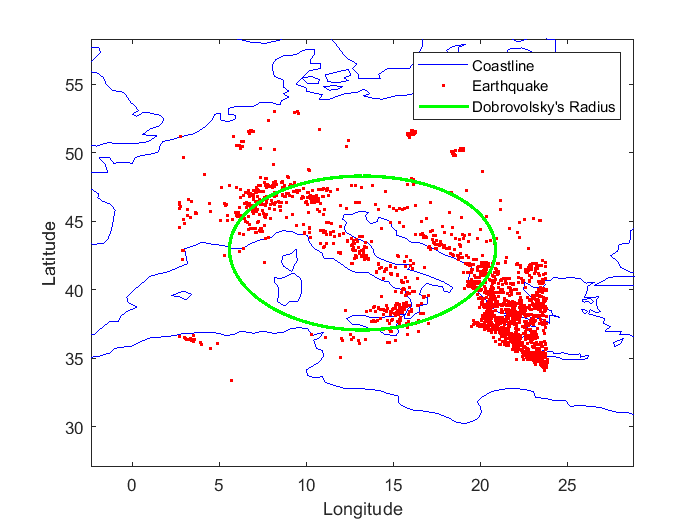

In [4]:
format compact

% The retrieved data are divided into packages. The number of them is provided as an output in the previous cell. 
% The following cycle, unwrap the packages of data retrieved from each request in an array, assuring that each row corresponds to a single earthquake event. 
k=1;
EQ_new = nan(size(EQ,1)*3,10);
for i = 1:size(EQ,1)
    EQ_temp = EQ(i).features;
    for j = 1:size(EQ_temp,1)
        hypocenter = EQ_temp(j).geometry.coordinates;
        EQ_magnitude = EQ_temp(j).properties.mag;
        EQ_origin_time = EQ_temp(j).properties.time;
        EQ_origin_time_1 = datetime([EQ_origin_time(1:10), ' ', EQ_origin_time(12:21)]);
        EQ_origin_time_vector = datevec(EQ_origin_time_1);
        EQ_new(k,:) = [hypocenter(1:2)', EQ_origin_time_vector(1:3), EQ_magnitude, -hypocenter(3), EQ_origin_time_vector(4:6)];
        k = k + 1;
    end
end
EQ_new = EQ_new(1:k-1,:);

%Creation of the map with all the retrieved events and the circle of Dobrovolsky's area to sub-select the new sub-catalog selection
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(EQ_new(:,1), EQ_new(:,2), '.r');
[aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
plot(bbs,aas,'-g', 'LineWidth',2);
axis([min_lon-5 max_lon+5 min_lat-5 max_lat+5]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', ['Dobrovolsky', 39, 's Radius']);

# Selection of earthquakes of interest
In the following lines, only the most interesting earthquakes are selected. In fact, we will consider a circular area defined by Dobrovolsky's Radius (km) = $10^{0.43 \times MAG}$ (Dobrovolsky et al., 1979). This is one of the possible areas that define the preparation of an earthquake, but it's widely used, and it corresponds to the distance where the seismic shaking is equal to the terrestrial tidal deformation.

In addition, we need to select only the earthquakes with a magnitude equal to or greater than the completeness magnitude of the earthquake catalogue.  
Last but not least, a selection of shallow earthquakes can be applied as deeper events are unlikely related to the interactions with the atmosphere and ionosphere. 

<b> References: </b>  
Dobrovolsky, I.P.; Zubkov, S.I.; Miachkin, V.I. Estimation of the Size of Earthquake Preparation Zones. PAGEOPH 1979, 117, 1025–1044, doi:10.1007/BF00876083.


In [5]:
%Calculus of the distance of each earthquake from the target event.
distance_from_target_EQ = distance(epilat, epilon, EQ_new(:,2), EQ_new(:,1));
%sub-selection of  events from the retrieved earthquake catalogue inside the green circle.
EQ_sel = EQ_new(distance_from_target_EQ <= radius_Dobrovolsky, :);
distance_from_target_EQ = distance_from_target_EQ(distance_from_target_EQ <= radius_Dobrovolsky);

Completeness_magnitude = 2.0; % From ZMap using Max curvature criterium
%in a future update, the MC can be calculated inside the VRE
%sub-selection of  events from the previous selection with magnitude equal or greater than MC.
distance_from_target_EQ = distance_from_target_EQ(EQ_sel(:,6) >= Completeness_magnitude);
EQ_sel = EQ_sel(EQ_sel(:,6) >= Completeness_magnitude, :);

max_depth = 50;
%sub-selection of  events from the previous selection with depth minor or equal to the max_depth.
distance_from_target_EQ = distance_from_target_EQ(EQ_sel(:,7) <= max_depth);
EQ_sel = EQ_sel(EQ_sel(:,7) <= max_depth, :);

%Ordering all the events for their origin time (i.e., chronologically)
EQ_sel = sortrows(EQ_sel, [3,4,5,8,9,10]);

%show the final number of earthquakes in the selection for further analyses.
size(EQ_sel,1)

ans = 591

# Calculus of Cumulative Benioff Strain   
The Benioff cumulative strain is computed according to the original formulation of Benioff:  
$S(t) = \sum_{i}^{N}{\sqrt{E_i}}$  
where S is the Benioff Strain at time t and E_i is the earthquake energy calculated with the Richter equation:  
$E_i(J) = 10^{(1.5 \cdot M_i + 4.8)}$  
where M is the magnitude of the event i

<b> Reference: </b>  
Benioff, H. Global Strain Accumulation and Release as Revealed by Great Earthquakes. GSA Bulletin 1951, 62, 331–338, doi:10.1130/0016-7606(1951)62[331:GSAARA]2.0.CO;2.


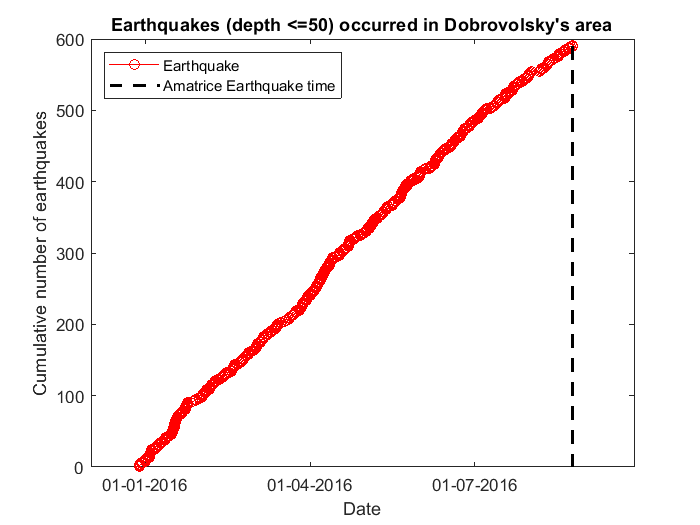

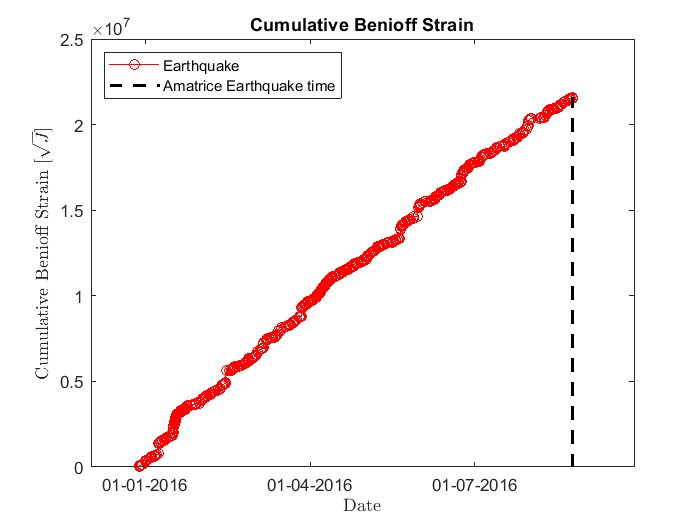

In [6]:
%Calculus of a vector that increases by one for each event.
cumulative_number = (1:size(EQ_sel,1))';
time_EQ_sel = datenum([EQ_sel(:,3:5), EQ_sel(:,8:10)]); 

%plot of the cumulative number of earthquakes over time.
figure;
plot(time_EQ_sel, cumulative_number, '-or');
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 cumulative_number(end)+1], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date')
ylabel('Cumulative number of earthquakes');
title(['Earthquakes (depth <=', num2str(max_depth), ') occurred in Dobrovolsky', 39, 's area']);
legend('Earthquake', 'Amatrice Earthquake time', 'Location', 'NorthWest')

%Calculus of Richter earthquake energy released for each event in Joules
EQ_energy = 10.^(1.5*EQ_sel(:,6)+4.8);

%Calculus of the square root of earthquake energy for each event
EQ_sqrt_energy = nan(size(EQ_sel,1),1);
%Calculus of cumulative Benioff Strain as the sum of the square root of energy calculated above.
EQ_sqrt_energy(1,1) = sqrt(EQ_energy(1));
for i=2:size(EQ_sel, 1)
EQ_sqrt_energy(i,1) = EQ_sqrt_energy(i-1,1) + sqrt(EQ_energy(i));
end

%plot of the square root of the energy
figure;
plot(time_EQ_sel, EQ_sqrt_energy, '-or');
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 EQ_sqrt_energy(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Cumulative Benioff Strain [$\sqrt{J}$]', 'Interpreter', 'latex');
title(['Cumulative Benioff Strain']);
legend('Earthquake', 'Amatrice Earthquake time', 'Location', 'NorthWest')



# Earthquake released energy as a function of the distance to the target earthquake
In the following, the earthquake released energy is weighted with the square distance to the incoming earthquake, according to the parameter $E_S$ introduced by prof. Katsumi Hattori (e.g., Hattori et al., 2013):  
$E_S = \sum_i{E_i \over r^2}$  
The parameter $E_S$ is calculated on all i-th events occurred in a single day.  
The concept is that an earthquake that happened closer to the future larger target is more important than one which is far.

<b> References: </b>  
Hattori, K.; Han, P.; Yoshino, C.; Febriani, F.; Yamaguchi, H.; Chen, C.-H. Investigation of ULF Seismo-Magnetic Phenomena in Kanto, Japan During 2000–2010: Case Studies and Statistical Studies. Surv Geophys 2013, 34, 293–316, doi:10.1007/s10712-012-9215-x.


number_of_analysed_days = 241

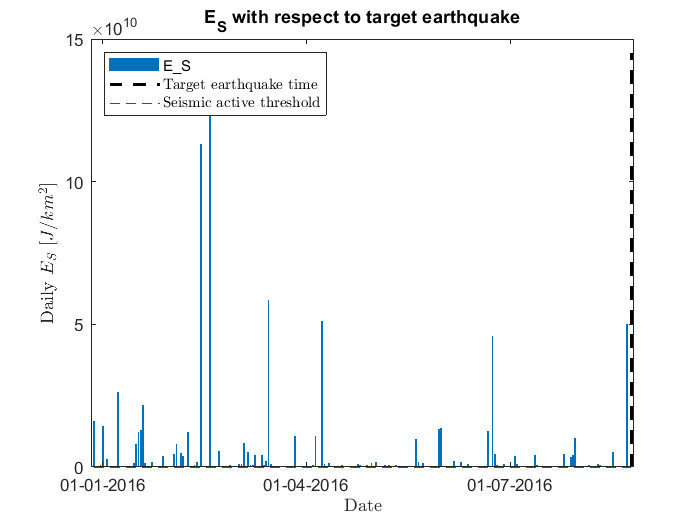

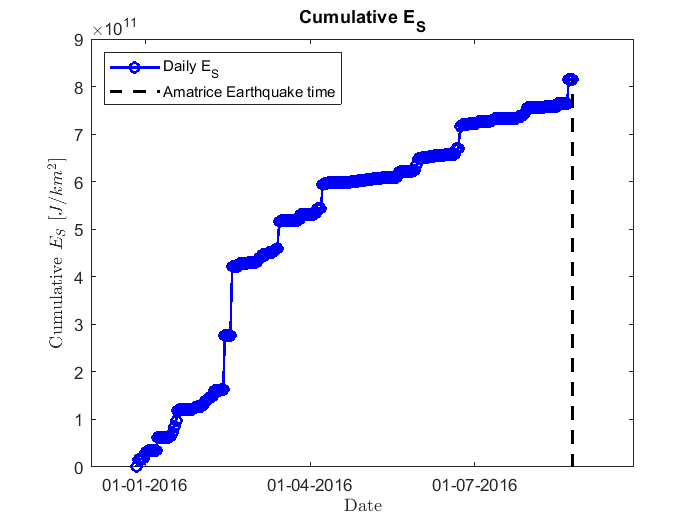

In [7]:
% Calculus of the Energy released by each earthquake divided by the square distance of the target event.
EQ_energy_for_ES = EQ_energy ./ (distance_from_target_EQ.^2);

% Calculus of daily Energy ES. At this purpose, the time span is firstly selected and then sum the energy ES for each event day-by-day
day_start = fix(time_start);
day_end = fix(time_end);
number_of_analysed_days = day_end - day_start + 1
% Creation of vector with daily energy ES basically equal to zero.
ES_Daily = zeros(number_of_analysed_days, 2);
% Calculus of actual daily energy ES.
k = 1;
for day_to_analysed = day_start:day_end
    [year_tba, month_tba, day_tba] = datevec(day_to_analysed);
    ES_Daily(k, :) = [day_to_analysed, sum(EQ_energy_for_ES(EQ_sel(:,3) == year_tba & EQ_sel(:,4) == month_tba & EQ_sel(:,5) == day_tba))];
    k = k + 1;
end

% plot of daily energy ES
figure;
bar(ES_Daily(:,1), ES_Daily(:,2));
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 max(ES_Daily(:,2))], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
line([day_start, day_end], [1e8, 1e8], 'LineStyle', '--', 'LineWidth', 1, 'Color', 'r');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Daily $E_S$ [$J/km^2$]', 'Interpreter', 'latex');
title(['E_S with respect to target earthquake']);
legend('E_S', 'Target earthquake time', 'Seismic active threshold', 'Location', 'NorthWest', 'Interpreter', 'latex')

% Calculus of cumulative ES over time
cumulative_ES = zeros(size(ES_Daily,1)+1,2);
cumulative_ES(1,1) = day_start - 1;
k = 2;
for i = 1:size(ES_Daily, 1)
    cumulative_ES(k,:) = [ES_Daily(i,1), cumulative_ES(k-1, 2)+ES_Daily(i,2)];
    k = k + 1;
end

% Plot of the cumulative ES over time
figure
plot(cumulative_ES(:,1), cumulative_ES(:,2), '-ob', 'Linewidth', 1.5);
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 cumulative_ES(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Cumulative $E_S$ [$J/km^2$]', 'Interpreter', 'latex');
title(['Cumulative E_S']);
legend('Daily E_S', 'Amatrice Earthquake time', 'Location', 'NorthWest')

# Analysis of vatiations of plates movements from EPOS GNSS Positions 
The following code extract the data from EPOS GNSS data service, searching for available stations inside the square inscribed in the Dobrovolskys's circle and then process the data calculating the differences between eventual GNSS stations along transects of the target fault strike.

number_of_GNSS_stations = 304

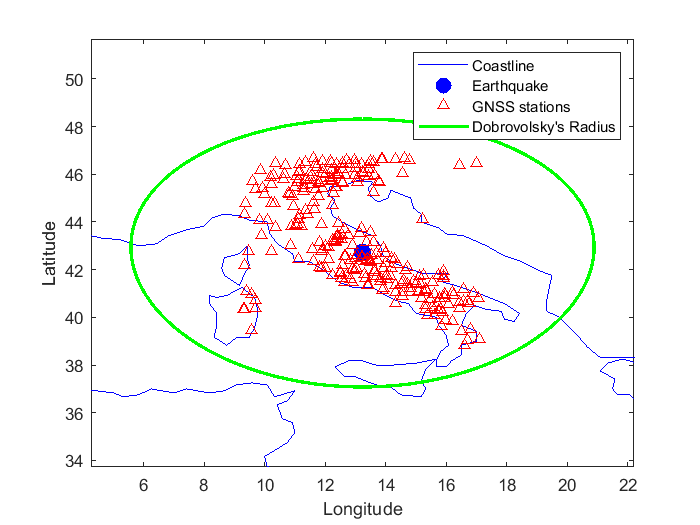

In [3]:
%Calculus of basic scientific parameters to setup the data request
%Calculus of earthquake origin time
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
%Calculus of time start and end of the VRE analysis
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
[year_start, month_start, day_start] = datevec(time_start);
[year_end, month_end, day_end] = datevec(time_end);
%Calculus of the research area and the limits in latitude and longitude to search for GNSS data (square inscribed in Dobrovolsky's area)
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = epilat - radius_Dobrovolsky/sqrt(2);
max_lat = epilat + radius_Dobrovolsky/sqrt(2);
min_lon = epilon - radius_Dobrovolsky/sqrt(2);
max_lon = epilon + radius_Dobrovolsky/sqrt(2);

%Construction of the URL to retrieve GNSS data with the above constraints
weburl_to_retrive_the_GNSS_station_list = ['https://gnssproducts.epos.ubi.pt/glass/products/velocities/geojson/SGO-EPND/', num2str(min_lon, '%.4f'), '/', num2str(min_lat, '%.4f'), '/', num2str(max_lon, '%.4f'), '/', num2str(max_lat, '%.4f'), '/'];
%Request of GNSS station list to EPOS data portal
GNSS_station_list = webread(weburl_to_retrive_the_GNSS_station_list);
%Organisation of the result from the EPOS data portal in a struct with one item for each retrieved stations
data_from_GNSS = {};
k_GNSS = 1;
if size(GNSS_station_list, 1) > 0
    GNSS_station_list = GNSS_station_list.features;
    number_of_GNSS_stations = size(GNSS_station_list, 1)
    if number_of_GNSS_stations > 0
        coordinates_of_GNSS = nan(number_of_GNSS_stations, 2);
        for i = 1:number_of_GNSS_stations
%It's necessary to insert a test of time availability inside the VRE time of interest
            coordinates_of_GNSS(i,1) = GNSS_station_list(i).properties.Longitude;
            coordinates_of_GNSS(i,2) = GNSS_station_list(i).properties.Latitude;
            weburl_to_retrive_the_data = ['https://gnssproducts.epos.ubi.pt/GlassFramework/webresources/products/timeseries/', GNSS_station_list(i).properties.GNSSStationID, '/SGO-EPND/weekly/enu/json/?epoch_start=', num2str(year_start), '-', num2str(month_start, '%02.0f'), '-', num2str(day_start, '%02.0f'), '&epoch_end=', num2str(year_end), '-', num2str(month_end, '%02.0f'), '-', num2str(day_end, '%02.0f')]; 
            GNSS_data = webread(weburl_to_retrive_the_data);
            if strcmp(GNSS_data, 'No data available') == 0
%In this case, there is available data, and we keep this data
                GNSS_data = GNSS_data.results;
%Organise the data from the stations in the array "extracted_data" with each row for a specific epoch:
% timestamp | North component | East component | Up component
                extracted_data = nan(size(GNSS_data,1), 4);
                for k = 1:size(GNSS_data,1)
                    extracted_data(k,1) = datenum(GNSS_data(k).epoch);
                    extracted_data(k,2) = GNSS_data(k).dn; %North GNSS component timeseries
                    extracted_data(k,3) = GNSS_data(k).de; %East GNSS component timeseries
                    extracted_data(k,4) = GNSS_data(k).du; %Up GNSS component timeseries
                end
% Extraction of the coordinates of the specific GNSS station
                data_from_GNSS{k_GNSS, 1}.coordinates = coordinates_of_GNSS(i,:);
                data_from_GNSS{k_GNSS, 1}.data = extracted_data;
                k_GNSS = k_GNSS + 1;
            end                      
        end
    end
end

%Plot of the map of the available GNSS stations from EPOS data portal 
coordinates_for_map = nan(k_GNSS-1, 2);
for i=1:(k_GNSS-1)
    coordinates_for_map(i,:) = data_from_GNSS{i}.coordinates;
end
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(epilon, epilat, 'ob', 'MarkerSize', 10, 'MarkerFaceColor', 'b')
plot(coordinates_for_map(:,1), coordinates_for_map(:,2), '^r');
[aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
plot(bbs,aas,'-g', 'LineWidth',2);
axis([min_lon-5 max_lon+5 min_lat-5 max_lat+5]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', 'GNSS stations', ['Dobrovolsky', 39 ,'s Radius']);

The following block calculates some basic parameters to analyse the data from the GNSS stations.  
In particular, the **angular tolerance** is a parameter to consider aligning two different stations eventually with respect to the fault direction (or its perpendicular direction for transect). The **maximum distance** is the segment, along the fault direction, to be investigated and it's defined as 10 times the broken fault segment.

In [4]:
angular_tollerance = 5; %maximum angular difference to be considered on the same direction
distance_GNSS_station_EQ = distance(coordinates_for_map(:,2), coordinates_for_map(:,1), epilat, epilon)*111;
angle_to_EQ = atan2d((coordinates_for_map(:,2)-epilat),(coordinates_for_map(:,1)-epilon));
Length_of_broken_fault = 3 * EQ_depth; %Proposed in Doglioni et al., Sci. Rep., 2015
Maximum_distance = 10 * Length_of_broken_fault / 2 %searching for a distance of 10 times the broken segment and symmetrical to the epicenter.
%Maximum distance is calculated in km


Maximum_distance = 150

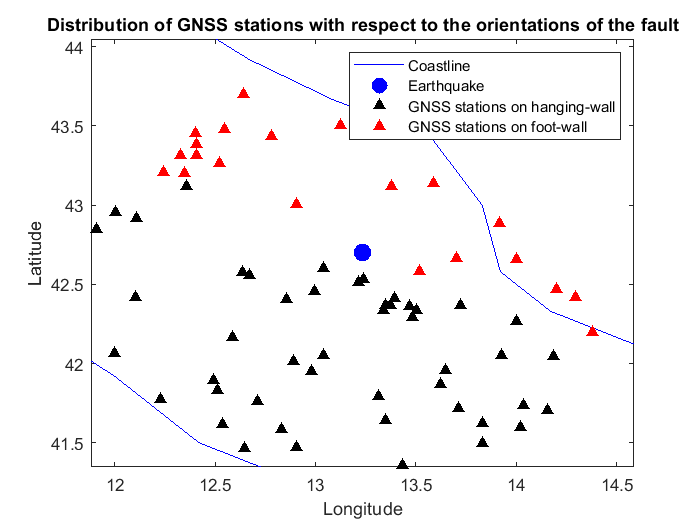

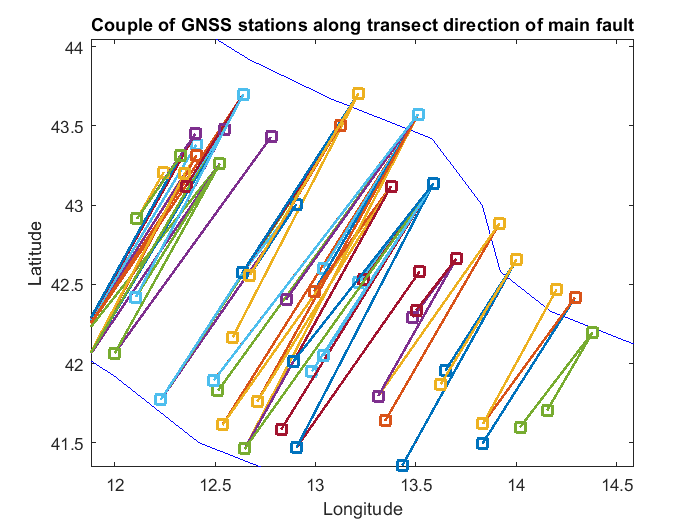

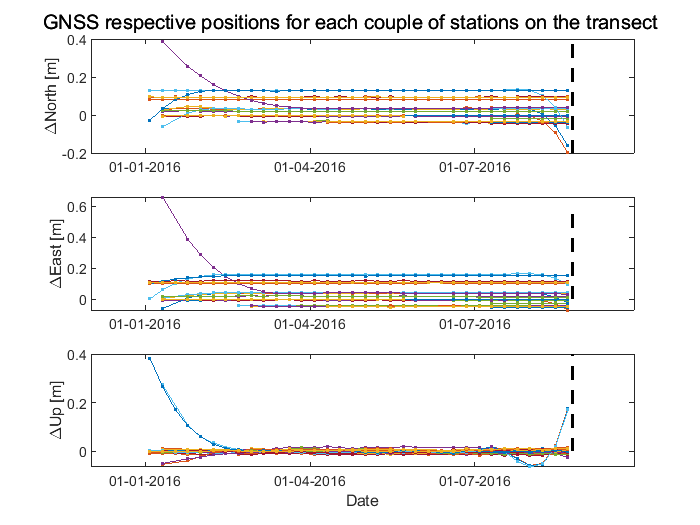

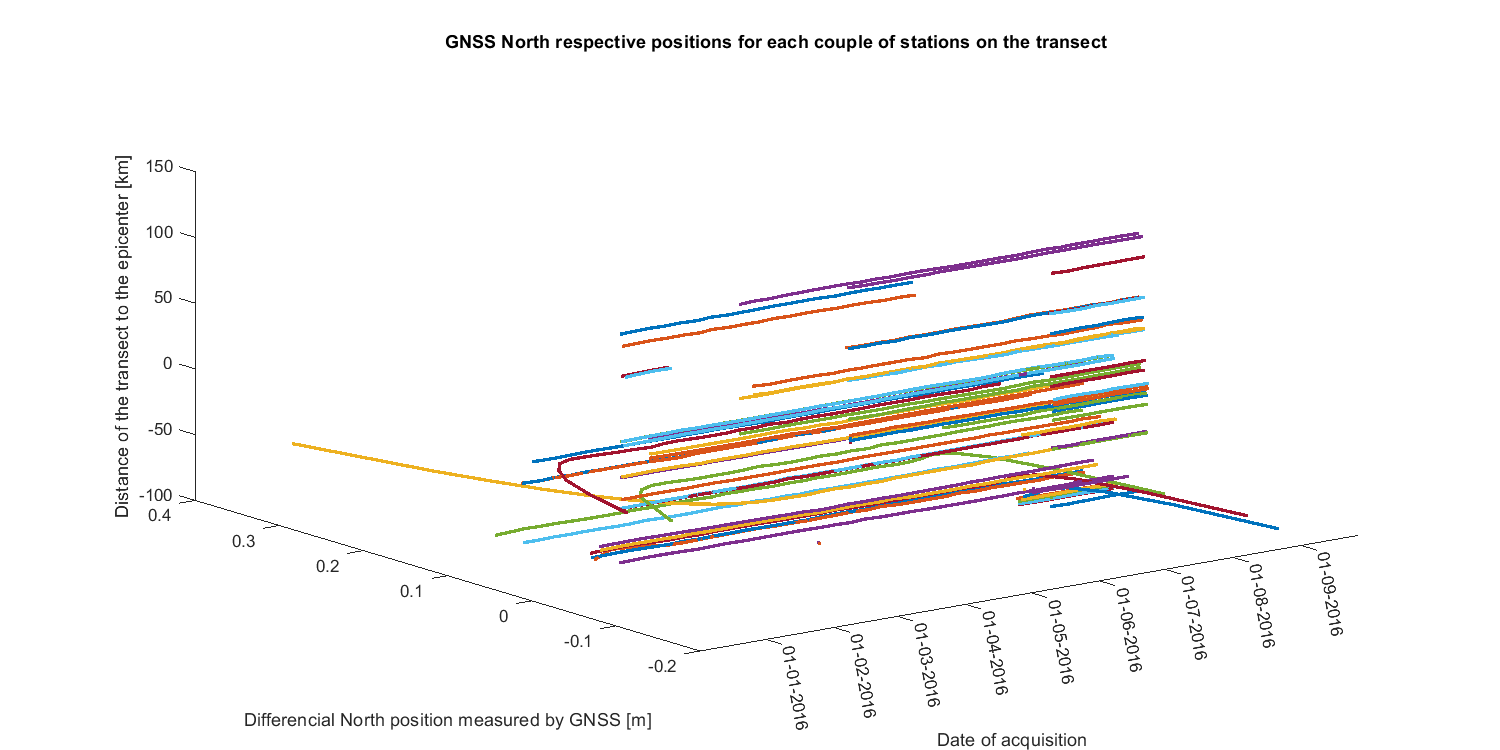

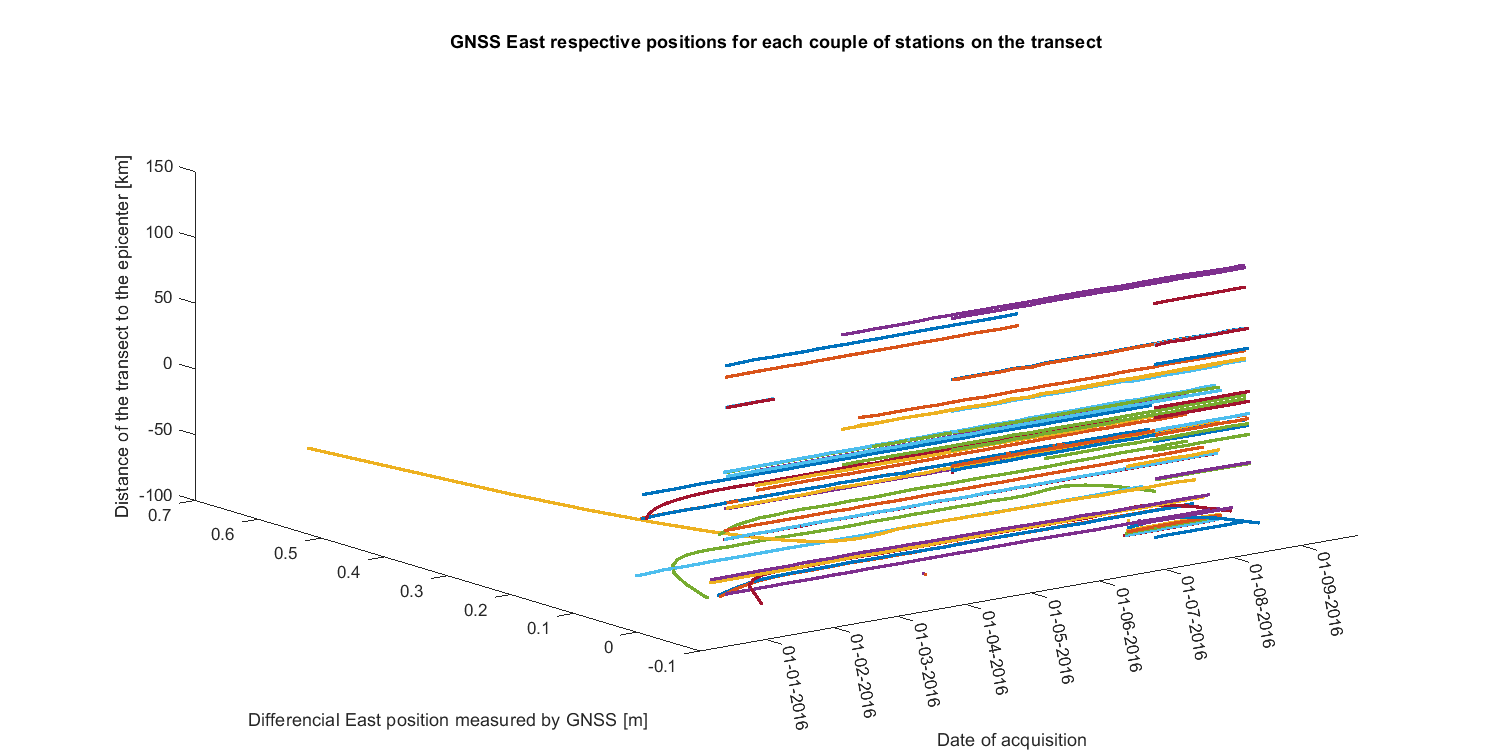

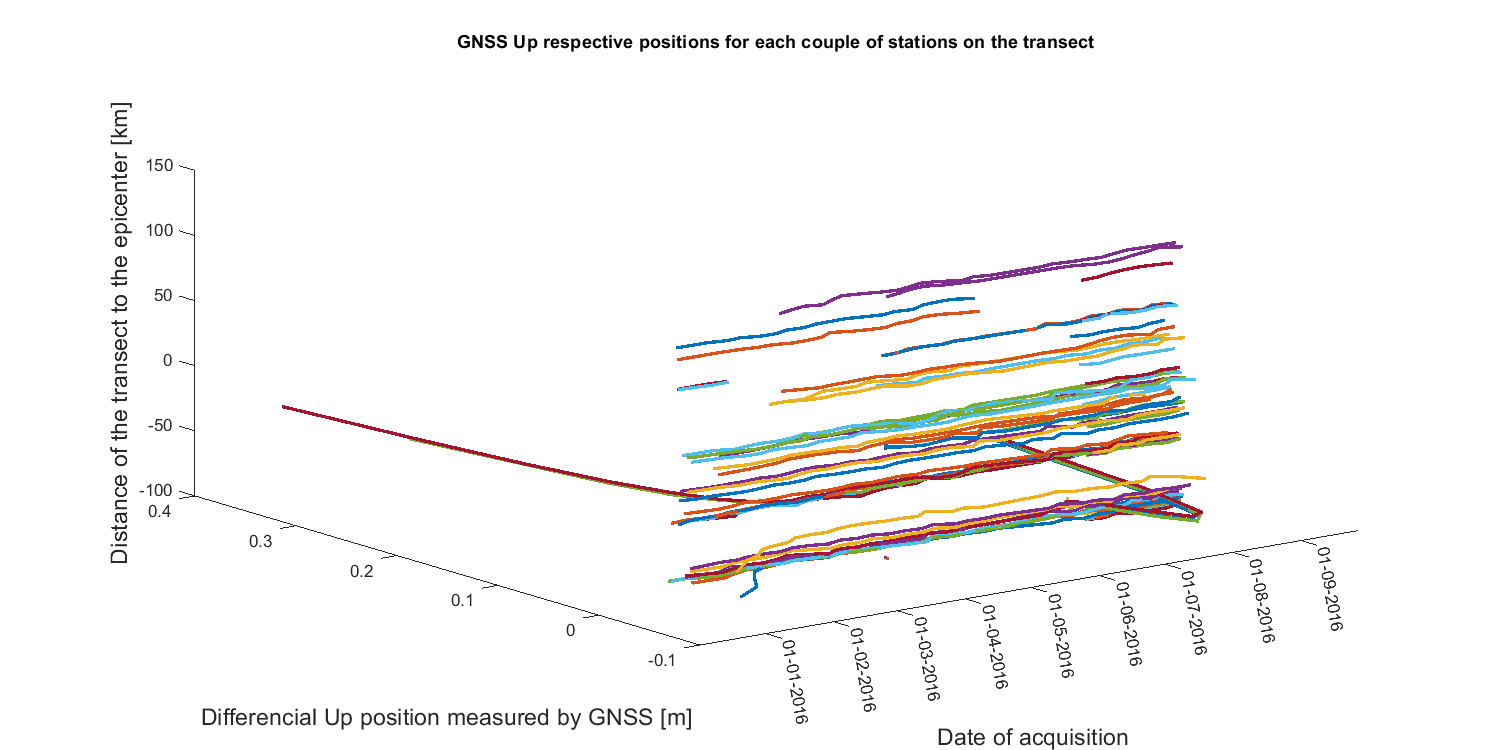

In [16]:
%Calculus of the straight angle of fault strike (same direction opposite verse)
Complementary_strike_angle = Fault_strike - 180;
%Calculus of the perpendicular direction to the one of the fault (transect direction)
Perpendicular_angle = Fault_strike - 90;
%Selection of the GNSS stations that rely on the side of the footwall or hanging wall with respect to the main fault.
%The selection is based on the comparison of the angle of the specific station with respect to the target earthquake.
GNSS_stations_on_footwall = data_from_GNSS((angle_to_EQ > Complementary_strike_angle & angle_to_EQ < Fault_strike) & distance_GNSS_station_EQ <= Maximum_distance);
GNSS_stations_on_hanging = data_from_GNSS((angle_to_EQ < Complementary_strike_angle | angle_to_EQ > Fault_strike) & distance_GNSS_station_EQ <= Maximum_distance);
%Collection of the GNSS coordinates for the two groups of stations
for i = 1:size(GNSS_stations_on_hanging, 1)
    GNSS_stations_on_hanging_coordinates(i,:) = GNSS_stations_on_hanging{i}.coordinates;
end
for i = 1:size(GNSS_stations_on_footwall, 1)
    GNSS_stations_on_footwall_coordinates(i,:) = GNSS_stations_on_footwall{i}.coordinates;
end

%Creation of a map with the division of GNSS stations on the side of the footwall or hanging wall
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(epilon, epilat, 'ob', 'MarkerSize', 10, 'MarkerFaceColor', 'b')
plot(GNSS_stations_on_hanging_coordinates(:,1), GNSS_stations_on_hanging_coordinates(:,2), '^k', 'MarkerFaceColor', 'k');
plot(GNSS_stations_on_footwall_coordinates(:,1), GNSS_stations_on_footwall_coordinates(:,2), '^r', 'MarkerFaceColor', 'r');
axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', 'GNSS stations on hanging-wall', 'GNSS stations on foot-wall');
title('Distribution of GNSS stations with respect to the orientations of the fault');

% Preparation of two figures: one is the map (figure_2_handle) with a couple of GNSS stations whose direction is perpendicular to the fault strike.
% The other figure (figure_1_handle) presents the results of the differential displacement for each couple of GNSS stations
figure_2_handle = figure;
load coastlines
plot(coastlon, coastlat, '-b');
hold on;
axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
xlabel('Longitude')
ylabel('Latitude')
title('Couple of GNSS stations along transect direction of main fault');

figure_1_handle = figure;
%this figure is divided in three panels for each component of GNSS signal in the form of time series.
%North
subplot(3,1,1)
plot([EQ_time, EQ_time], [-0.2, 0.4], '--k', 'LineWidth', 2);
hold on; %Allows to superpose the time series from different couples of GNSS stations    
%East
subplot(3,1,2)
plot([EQ_time, EQ_time], [0, 0.6], '--k', 'LineWidth', 2);
hold on;
%Up
subplot(3,1,3)
plot([EQ_time, EQ_time], [0, 0.4], '--k', 'LineWidth', 2);
hold on;

%the results are also stored in a structure called results_from_perpendicular_stations
results_from_perpendicular_stations = {};
k_stations = 1;
for i = 1:size(GNSS_stations_on_hanging, 1)
    % Calculate the angle of a station on footwall with respect to the i-station on hanging wall 
    angle_to_station = atan2d(GNSS_stations_on_footwall_coordinates(:,2)-GNSS_stations_on_hanging_coordinates(i,2),GNSS_stations_on_footwall_coordinates(:,1)-GNSS_stations_on_hanging_coordinates(i,1));
    % Select only the stations that are perpendicular to fault strike (i.e., they are on a transect).
    index_good_stations_footwall = find(abs(angle_to_station - (Fault_strike-90))  <= angular_tollerance | abs(angle_to_station - (Fault_strike - 270)) <= angular_tollerance);
    if size(index_good_stations_footwall, 1) > 0
        % Extract the data from the first station
        data_from_station_1 = GNSS_stations_on_hanging{i}.data;
        for k=1:size(index_good_stations_footwall, 1)
            % Extract the data from the second station
            data_from_station_2 = GNSS_stations_on_footwall{index_good_stations_footwall(k)}.data;
            % In order to compare the observations the measurements from second station are resampled on the time of the first station that in principle they could be different
            data_from_station_2_resamples = nan(size(data_from_station_1,1), 4);
            data_from_station_2_resamples(:,1) = data_from_station_1(:,1);
            data_from_station_2_resamples(:,2) = interp1(data_from_station_2(:,1),data_from_station_2(:,2), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            data_from_station_2_resamples(:,3) = interp1(data_from_station_2(:,1),data_from_station_2(:,3), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            data_from_station_2_resamples(:,4) = interp1(data_from_station_2(:,1),data_from_station_2(:,4), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            % Differences of GNSS measurements for the three components for a specific couple of GNSS station
            differences_GNSS = (data_from_station_1(:,2:4) - data_from_station_2_resamples(:,2:4));
            % The following calculus computes the distance of the transect from the epicenter.
            %The Heron's  formula is used: area  = sqrt(s(s-a)*(s-b)*(s-c))
            % Calculus of the length of the first side
            distance_st1_st2 = distance(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), ...
            GNSS_stations_on_hanging{i}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(1));
            % Calculus of the length of the second side
            distance_st1_EQ = distance(epilat, epilon, GNSS_stations_on_hanging{i}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(1));
            % Calculus of the length of the third side
            distance_EQ_st2 = distance(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), epilat, epilon); 
            semiperimeter = 0.5 * (distance_st1_st2+distance_st1_EQ+distance_EQ_st2);
            area = sqrt(semiperimeter*(semiperimeter-distance_st1_st2)*(semiperimeter-distance_st1_EQ)*(semiperimeter-distance_EQ_st2));
            height_triangle = 2 * area / distance_st1_st2;
            % Calculus of the distance of transect in km considering that 1 degree is about 111 km on Earth's Surface
            distance_st1_st2_from_EQ = height_triangle * 111;
            % Check if the transect is in one or opposite side of the earthquake
            angle_of_st2_to_EQ = atan2d(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2)-epilat,GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1)-epilon);
            % In case is in the opposite side the distance is converted as negative
            if angle_of_st2_to_EQ > Perpendicular_angle
                distance_st1_st2_from_EQ = - distance_st1_st2_from_EQ;
            end
            % Plot the coordinates of the couple of stations on the map
            figure(figure_2_handle)
            plot([GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), GNSS_stations_on_hanging{i}.coordinates(1)], [GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(2)], 's-', 'LineWidth', 1.5, 'MarkerSize', 8);
            % Store the results
            results_from_perpendicular_stations{k_stations,1}.distance = distance_st1_st2_from_EQ;
            results_from_perpendicular_stations{k_stations,1}.differences_GNSS = differences_GNSS;
            results_from_perpendicular_stations{k_stations,1}.time_differences_GNSS = data_from_station_1(:,1);
            results_from_perpendicular_stations{k_stations,1}.distance_st1_st2 = distance_st1_st2;
            k_stations = k_stations + 1;
            % Plot the time series in the other graph
            figure(figure_1_handle)
            subplot(3,1,1)
            % North GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,1), '.-');
            subplot(3,1,2)
            % East  GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,2), '.-');
            subplot(3,1,3)
            % Up  GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,3), '.-');
        end
    end
end

% Complete the time series graph with labels and convert the time axis into a better visualization
subplot(3,1,1)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
ylabel('\DeltaNorth [m]');
%legend('NumColumns', 3);
subplot(3,1,2)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
ylabel('\DeltaEast [m]');
subplot(3,1,3)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date')
ylabel('\DeltaUp [m]');
sgtitle("GNSS respective positions for each couple of stations on the transect", 'FontSize', 12)


% Repeat the previous graph of the time series in a separated 3D plot for time series with the vertical axis 
% in function of the transect distance to the earthquake 
%Preparation of large figure for North component
figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,1), distance_GNSS*ones(size(time_data_station, 1), 1), '.-', 'LineWidth', 2);
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial North position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');
title("GNSS North respective positions for each couple of stations on the transect")

%Preparation of large figure for East component
figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,2), distance_GNSS*ones(size(time_data_station, 1), 1), '.-', 'LineWidth', 2);
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial East position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');
title("GNSS East respective positions for each couple of stations on the transect")

%Preparation of large figure for Up component
figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,3), distance_GNSS*ones(size(time_data_station, 1), 1), '.-', 'LineWidth', 2);
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition', 'FontSize', 14)
ylabel('Differencial Up position measured by GNSS [m]', 'FontSize', 14)
zlabel('Distance of the transect to the epicenter [km]', 'FontSize', 14);
title("GNSS Up respective positions for each couple of stations on the transect")

The following code calculate the rate of GNSS displacement in the form of maps.  
It firstly homogenize the data in a three dimensional vector with time and space positions as coordinates. It fills the missing gaps whenever is possible and after it calcualte the difference of GNSS positions for each compoent divided for the time span between the two measurements that generally is one week.  
It then plot the interpolated maps for North, East Up compoent for each time step (generally one week if data are available).

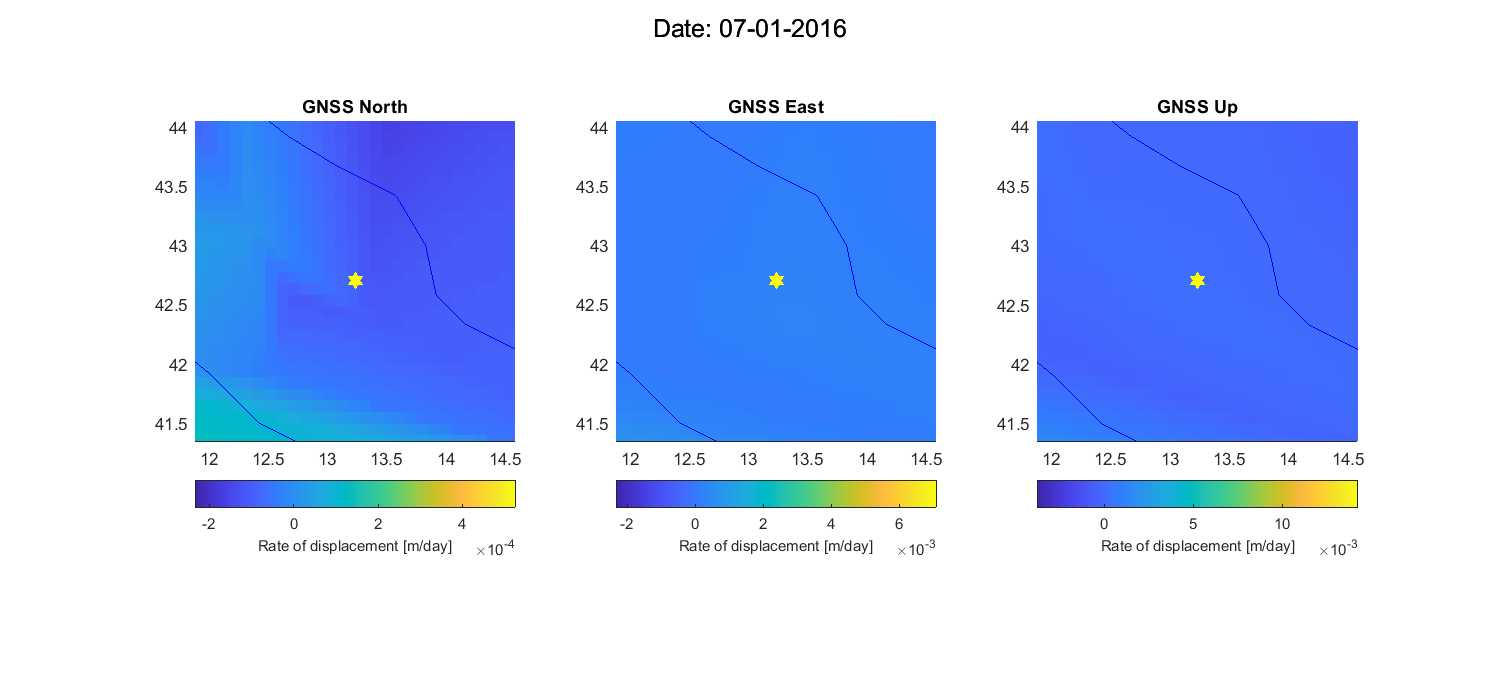

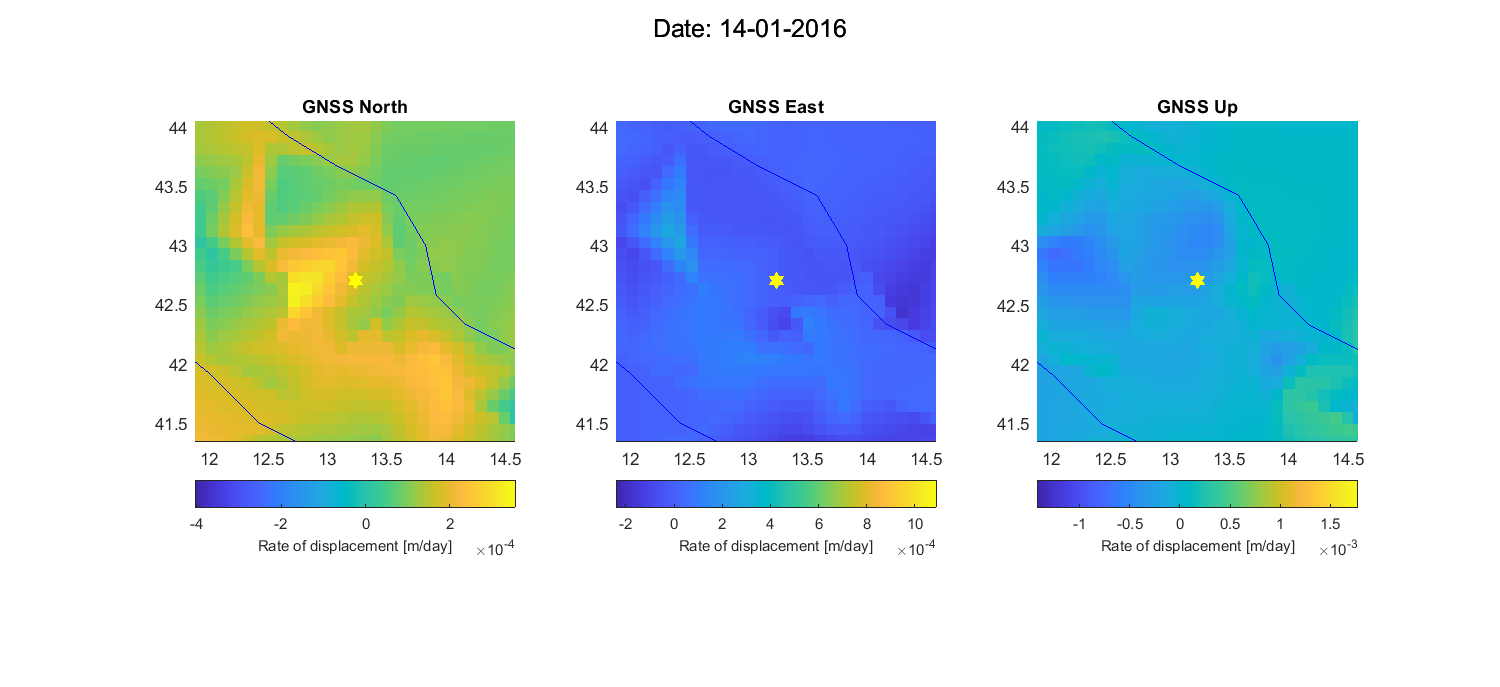

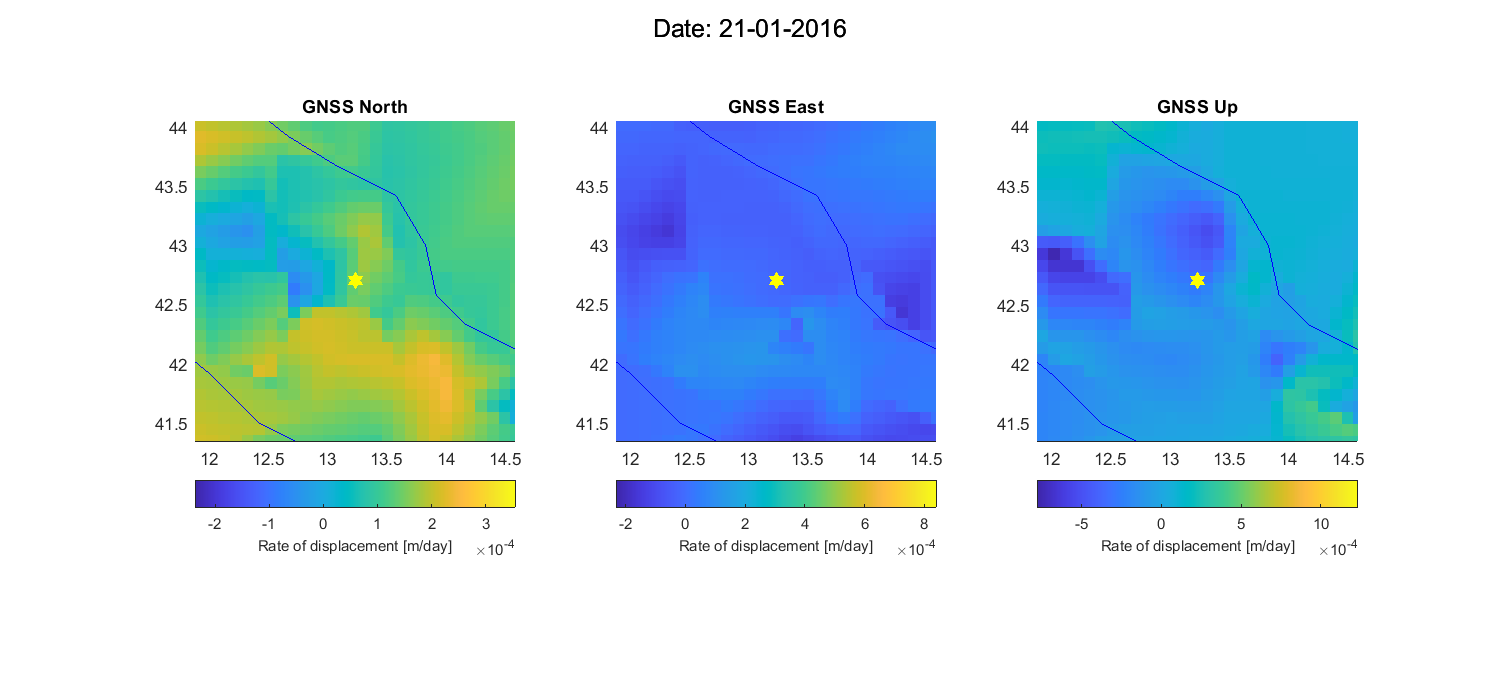

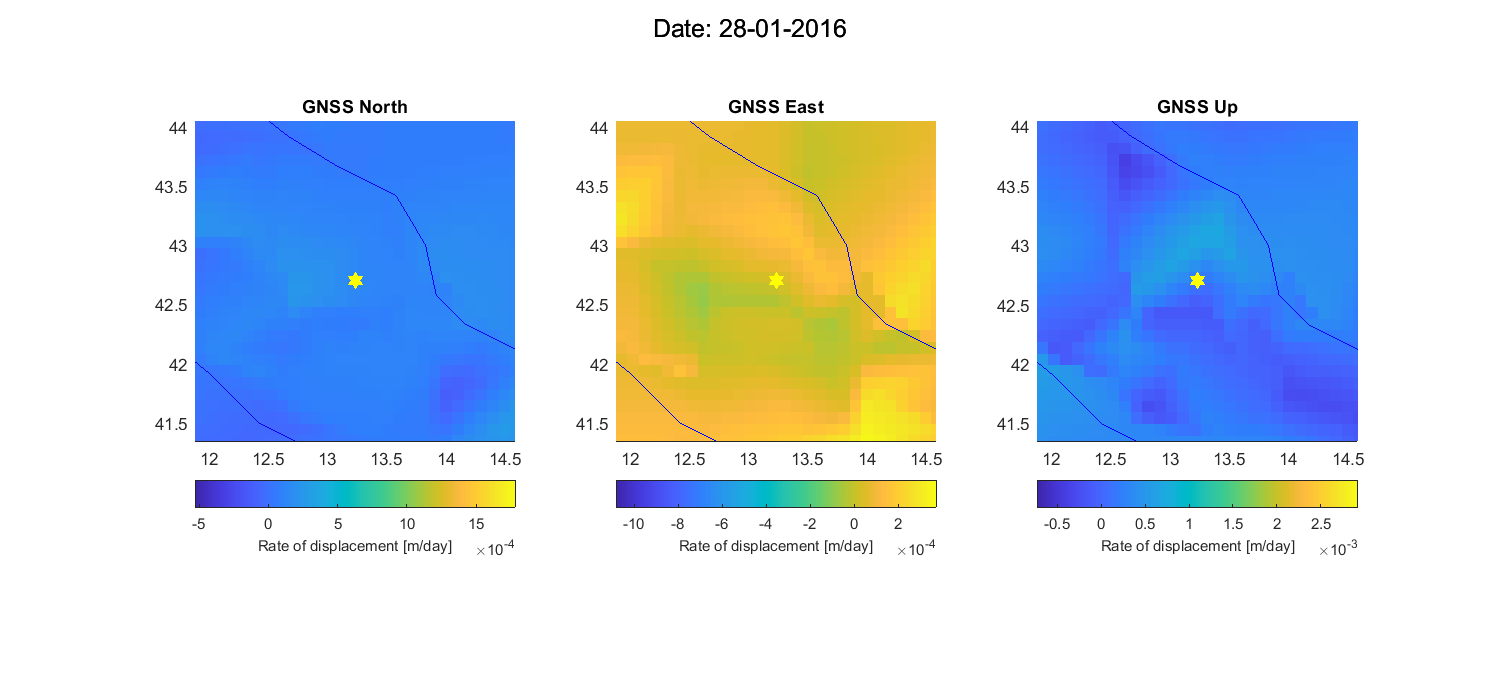

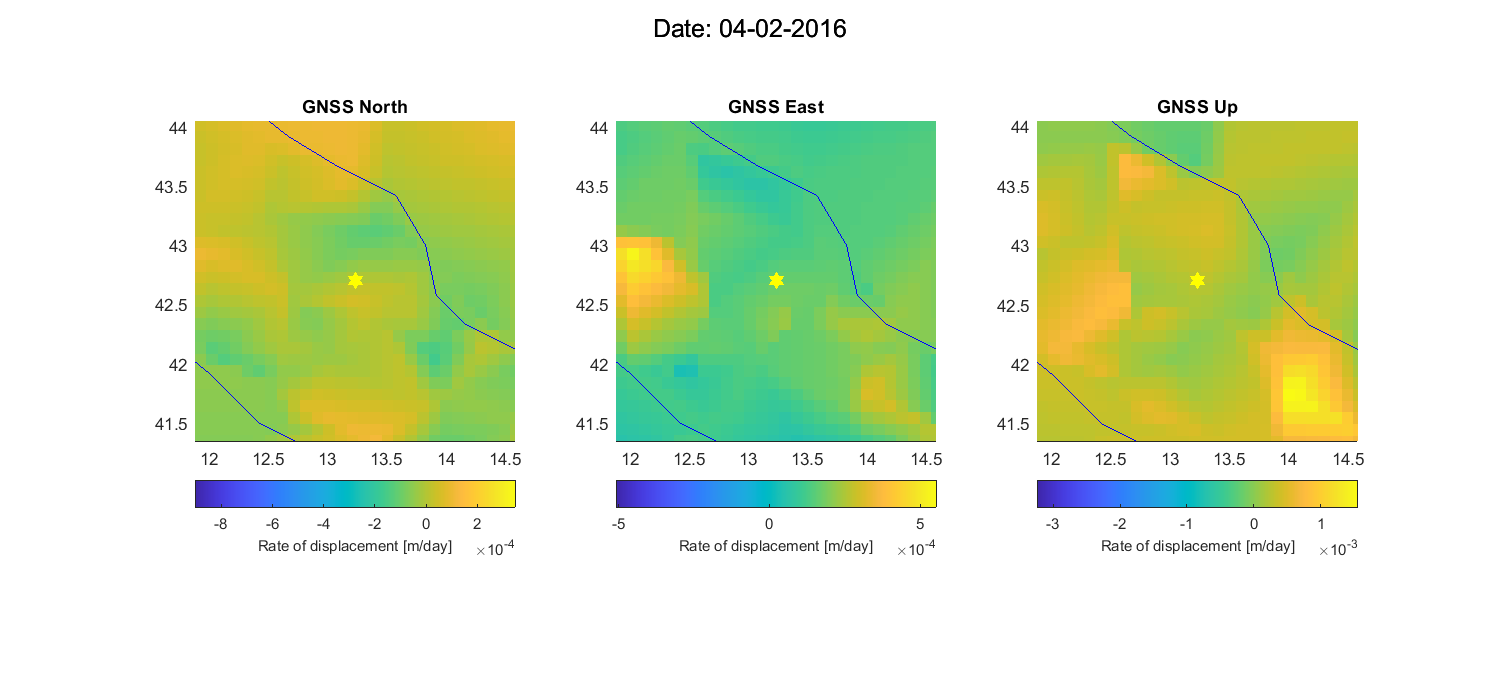

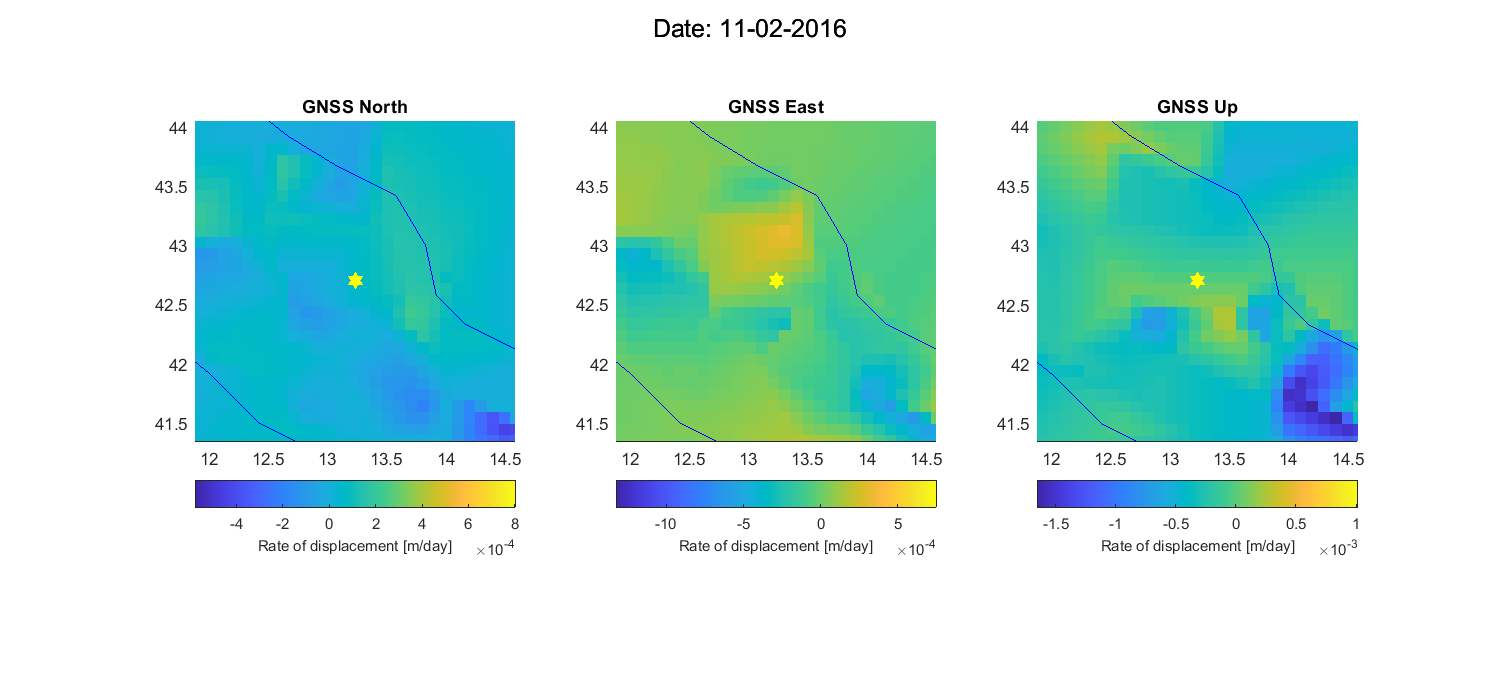

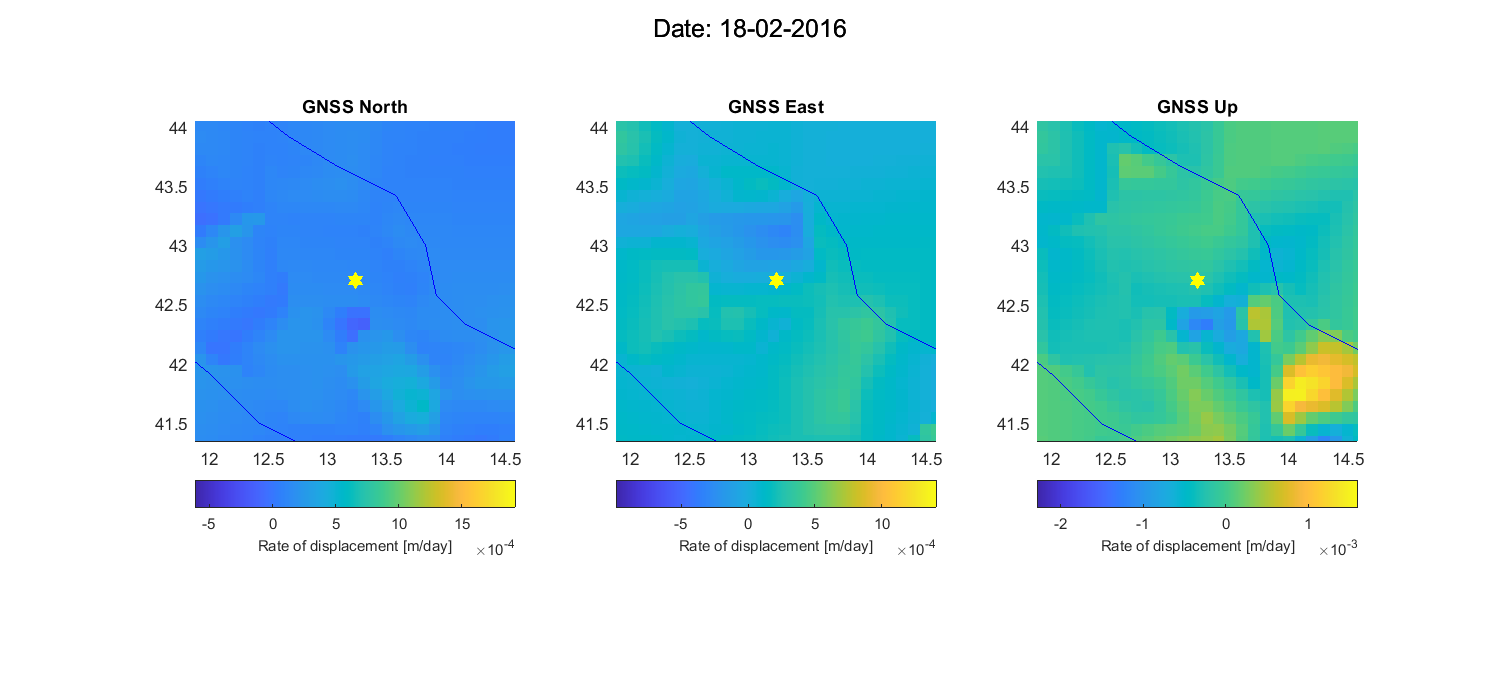

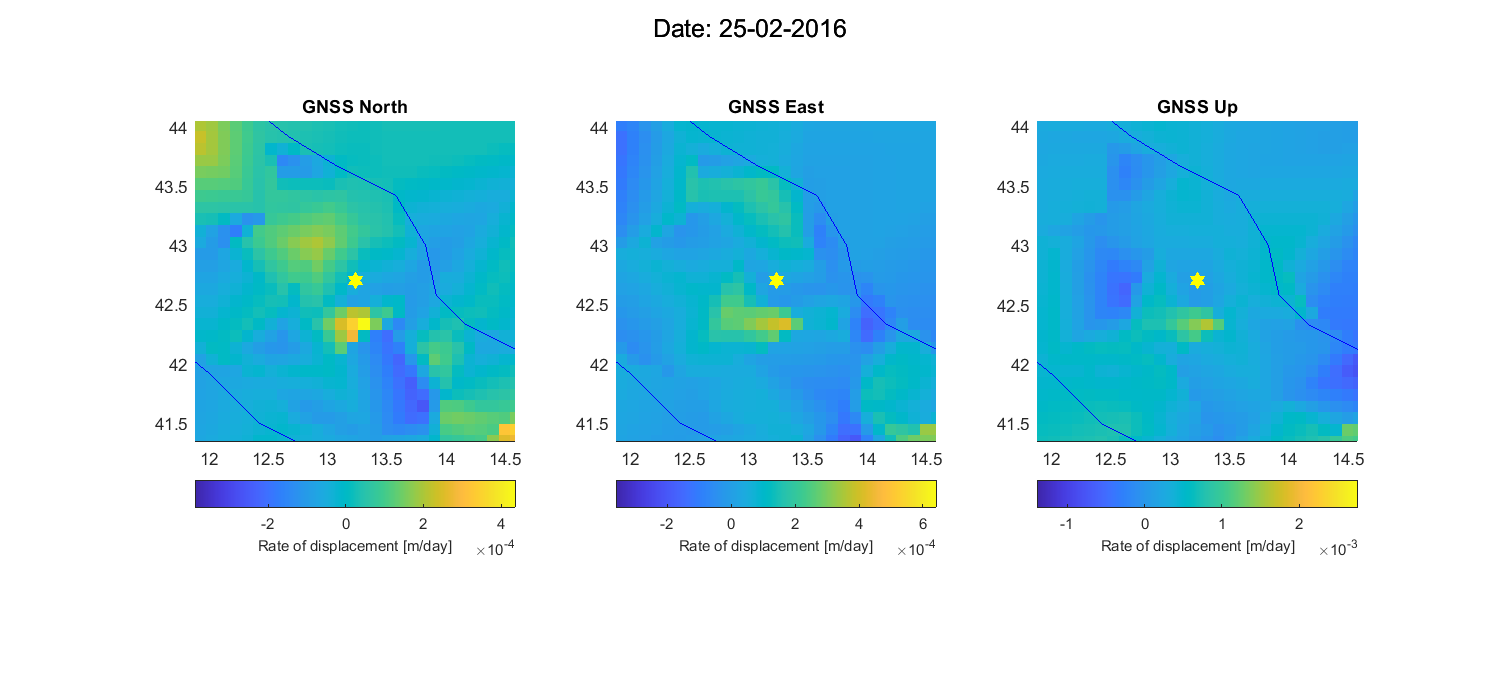

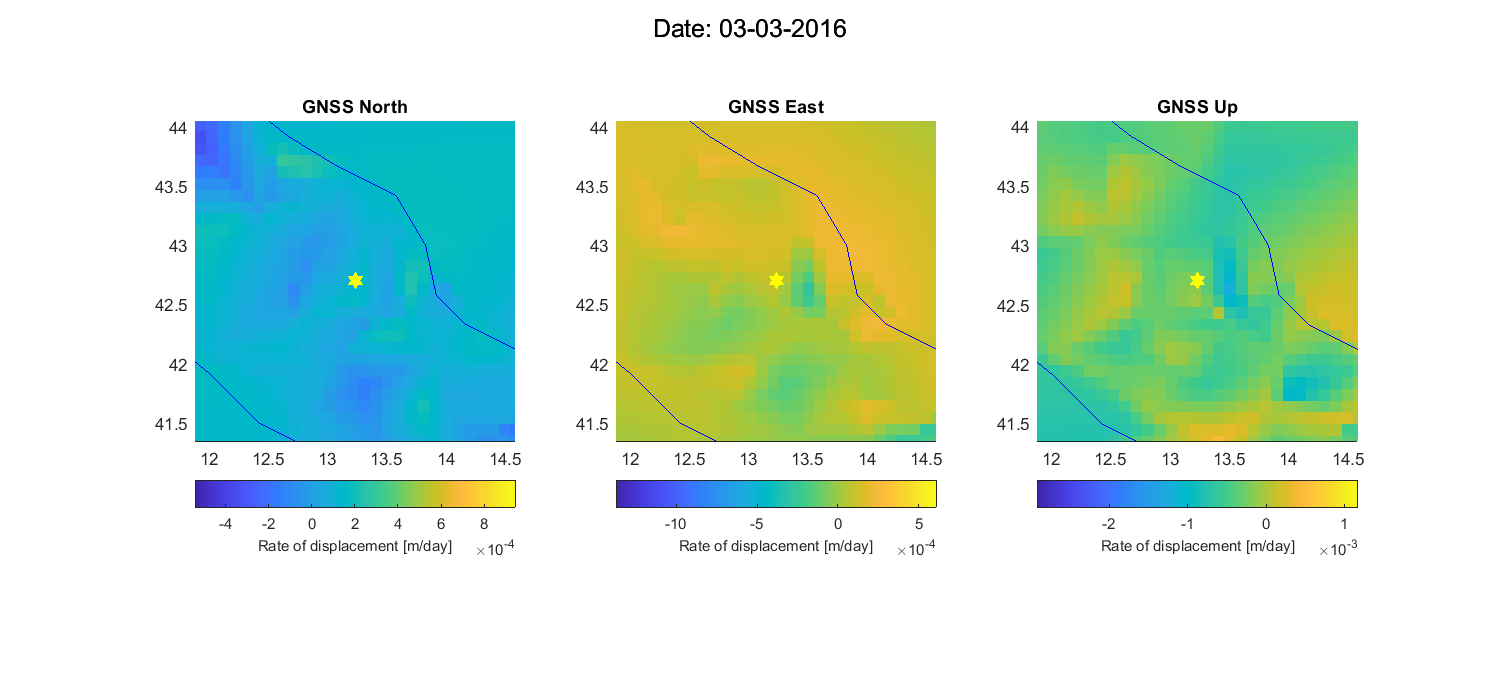

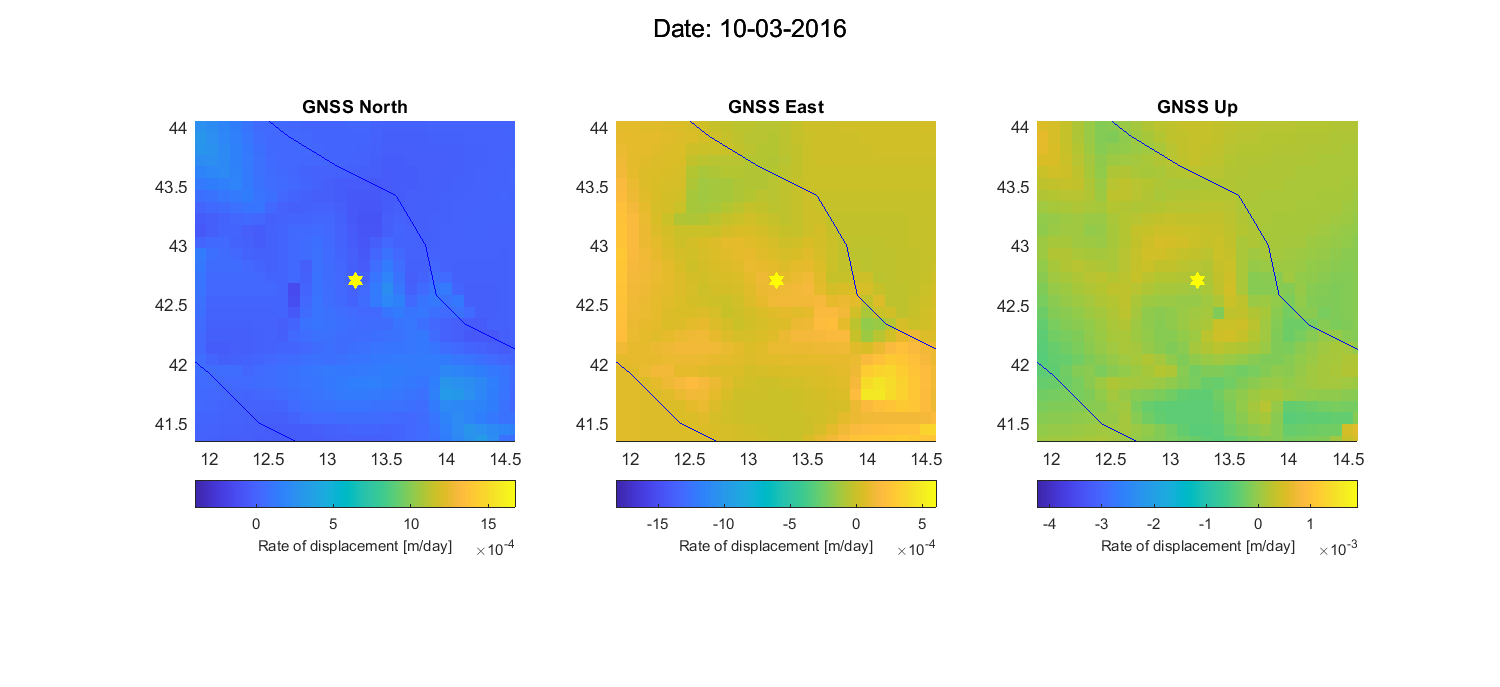

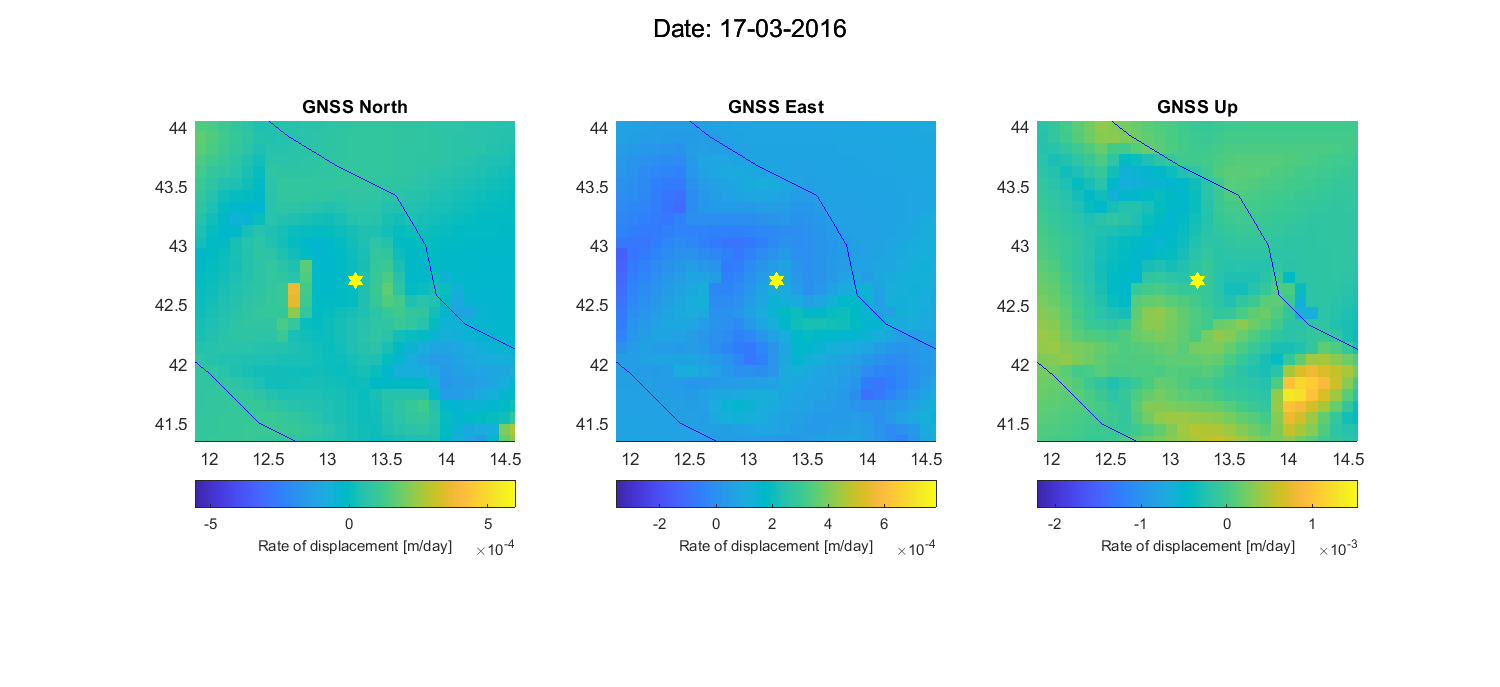

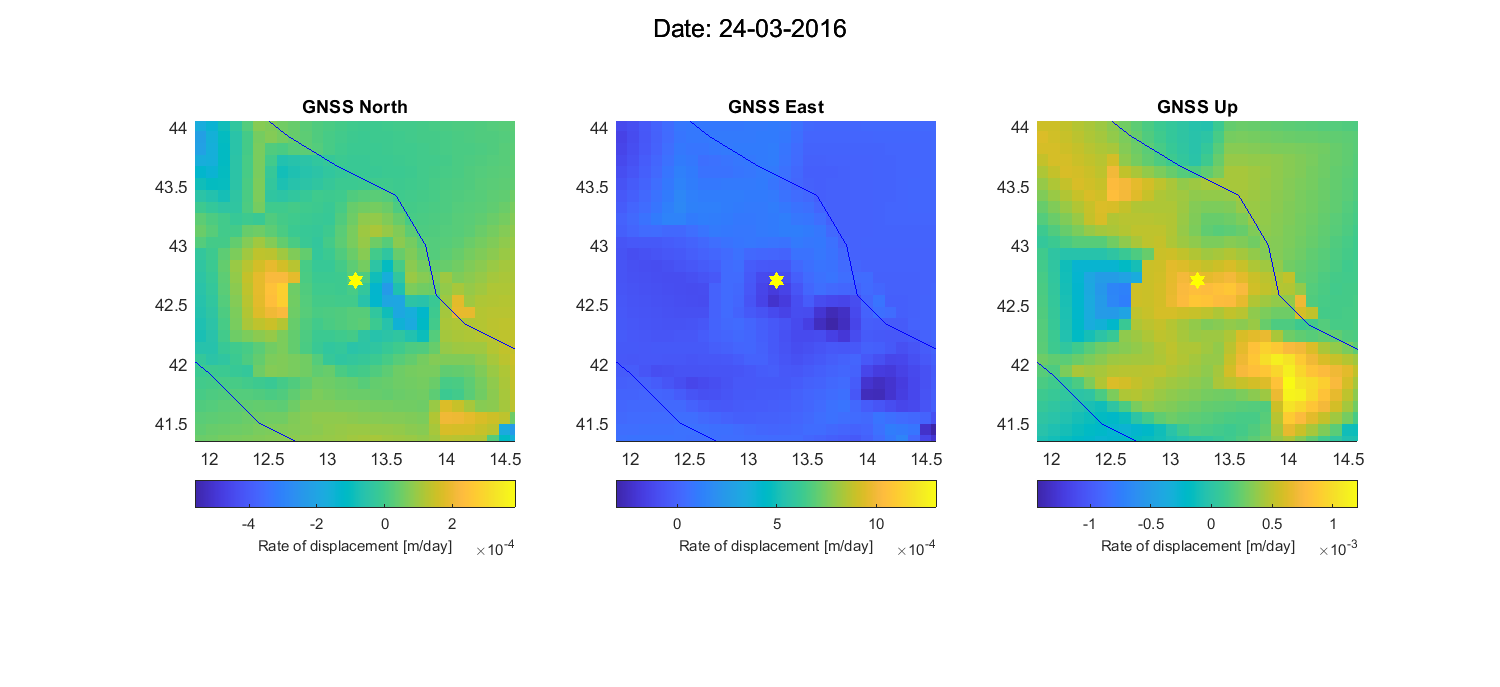

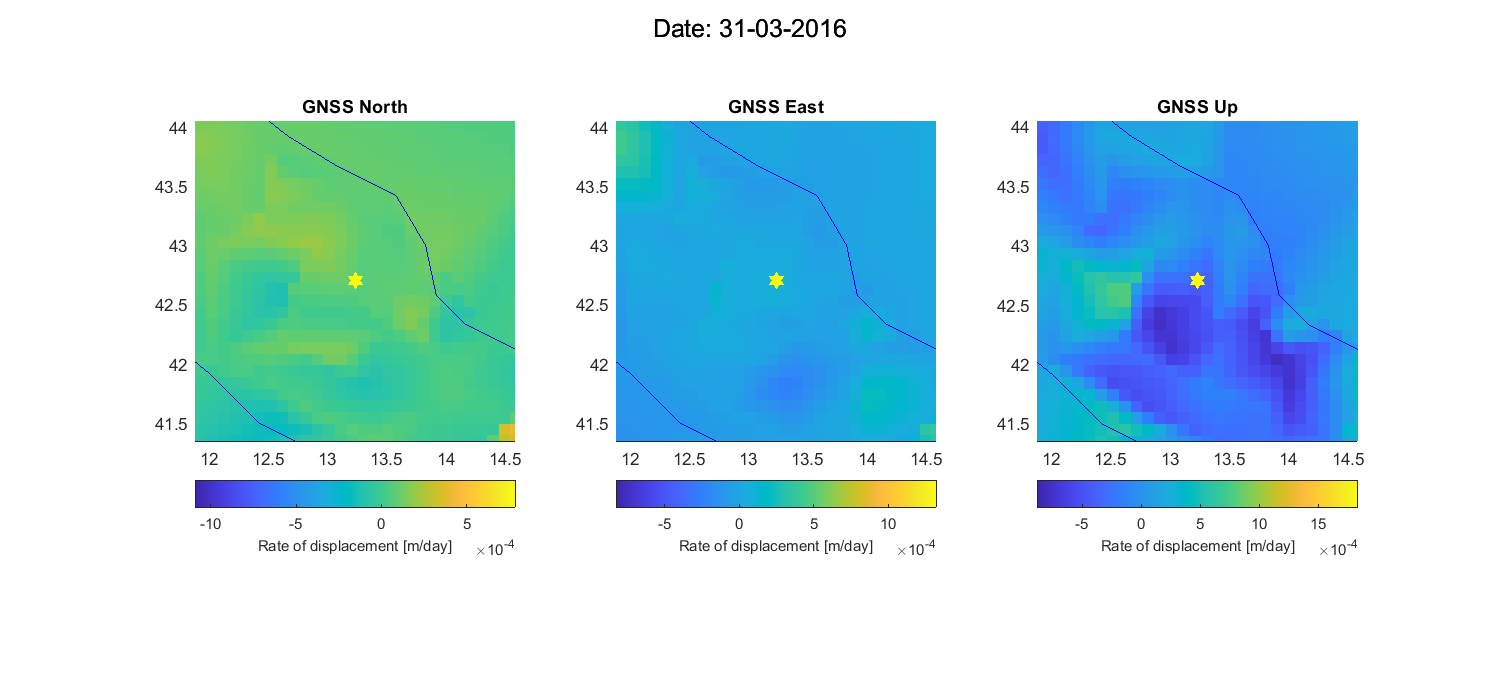

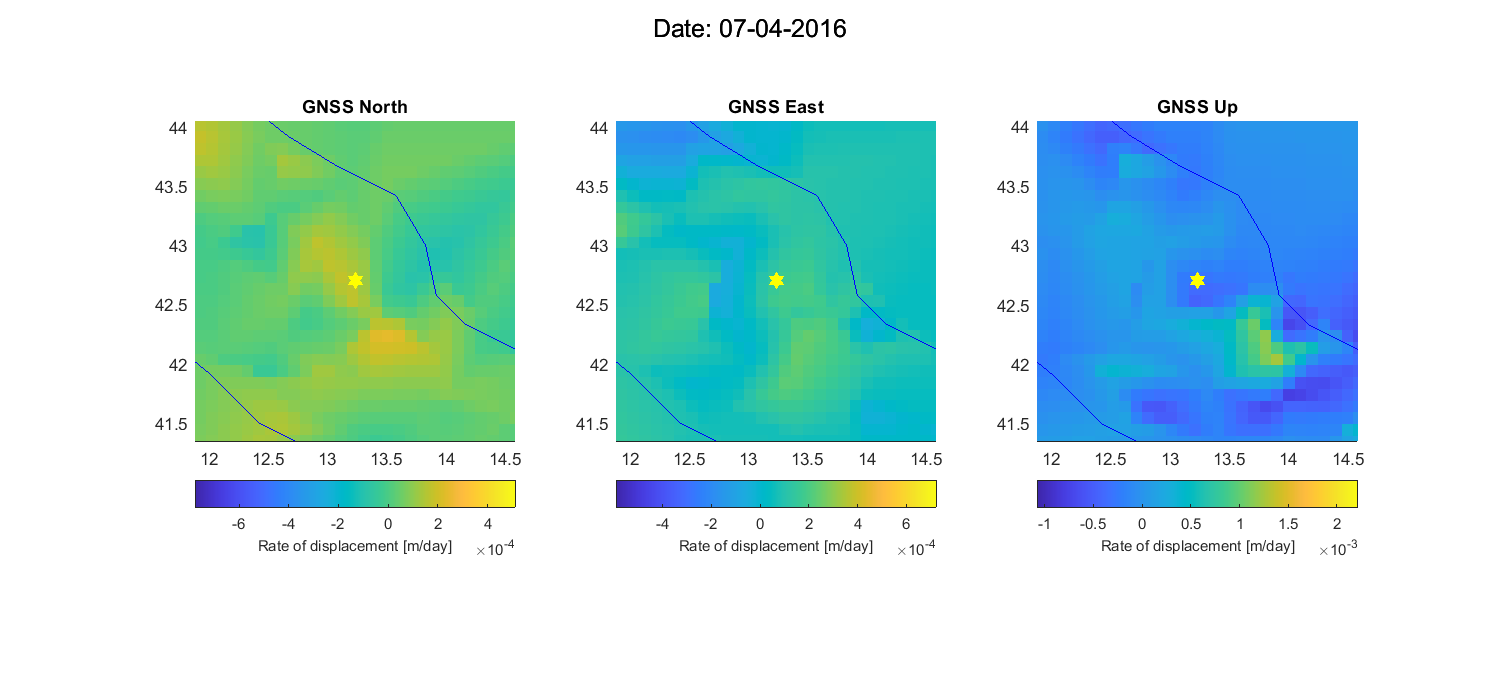

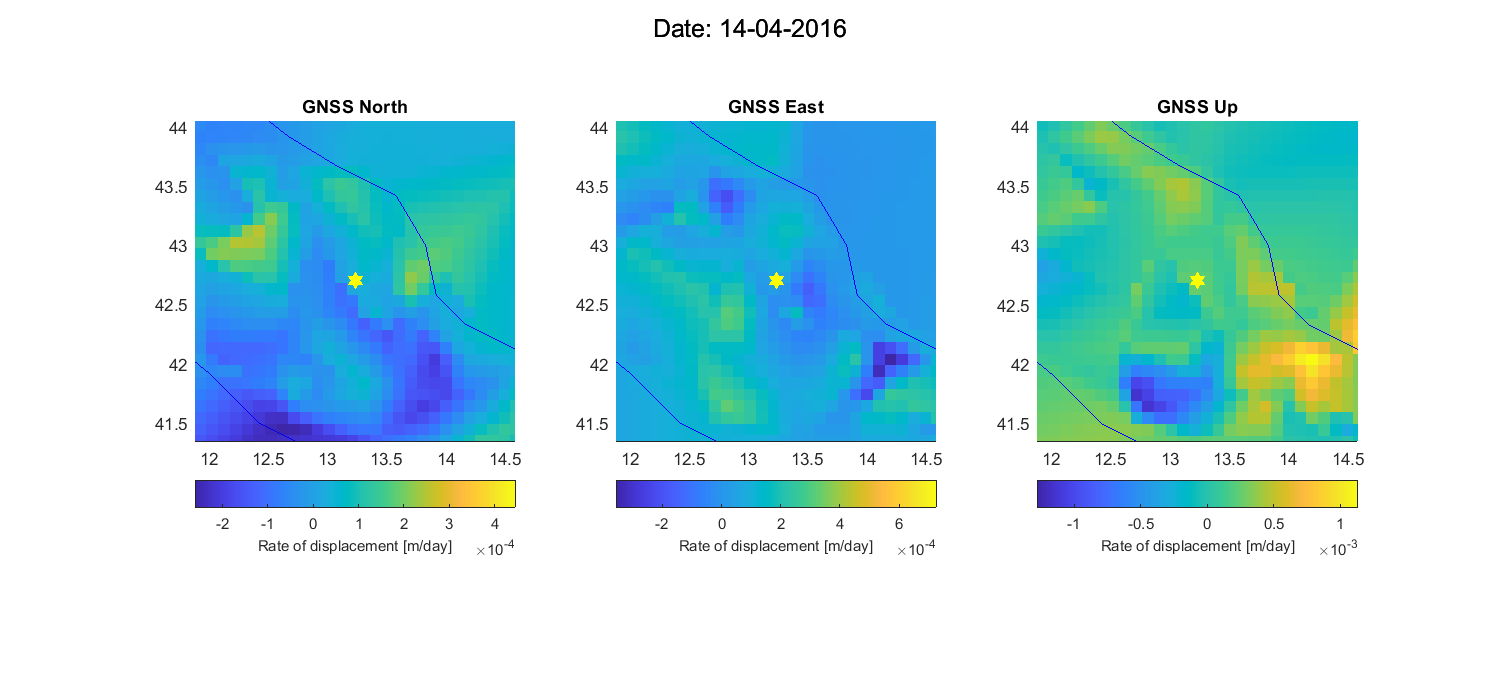

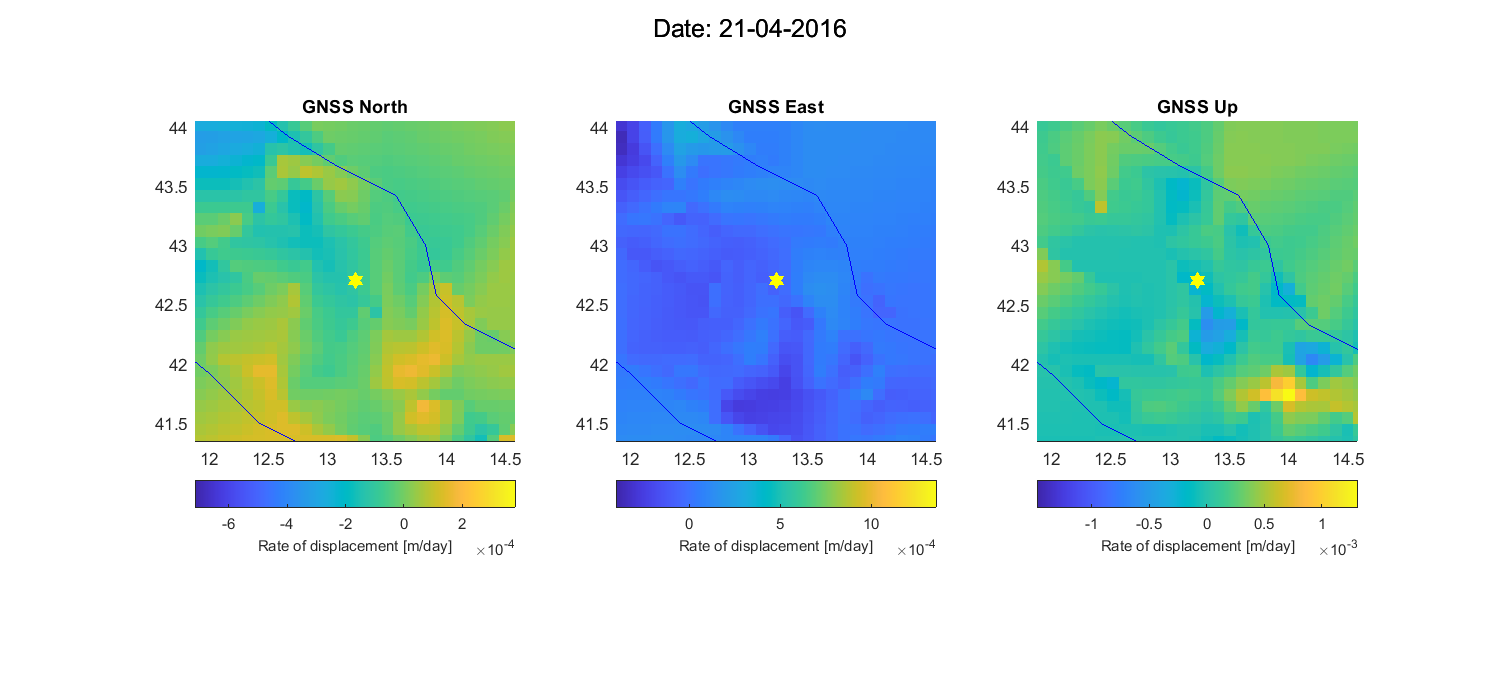

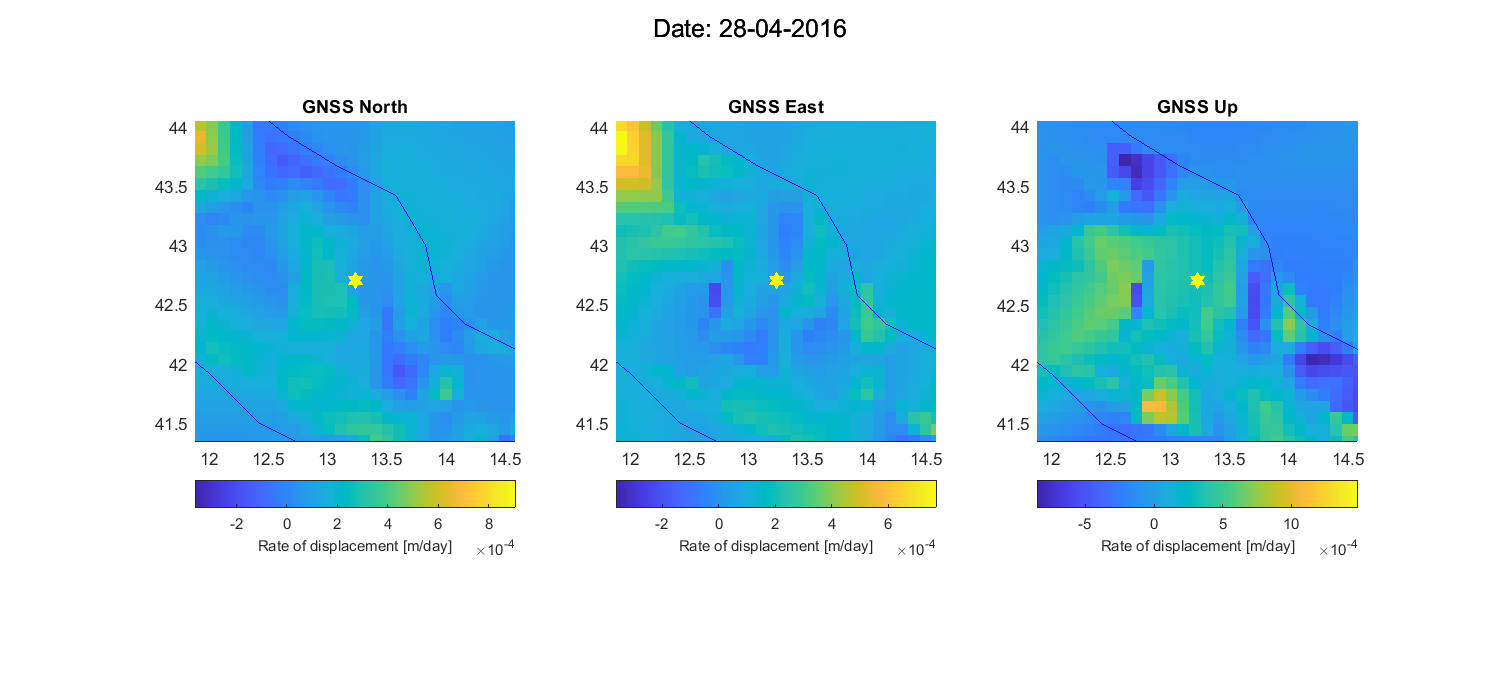

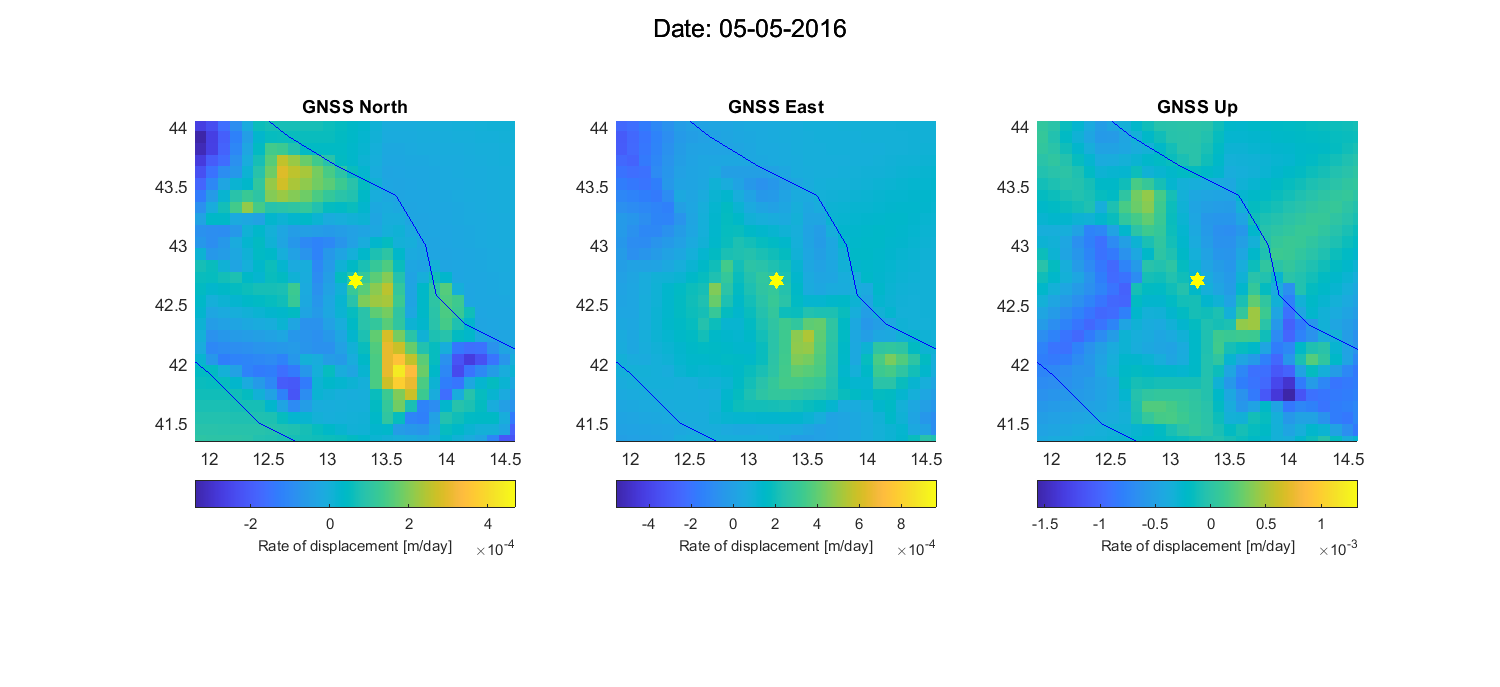

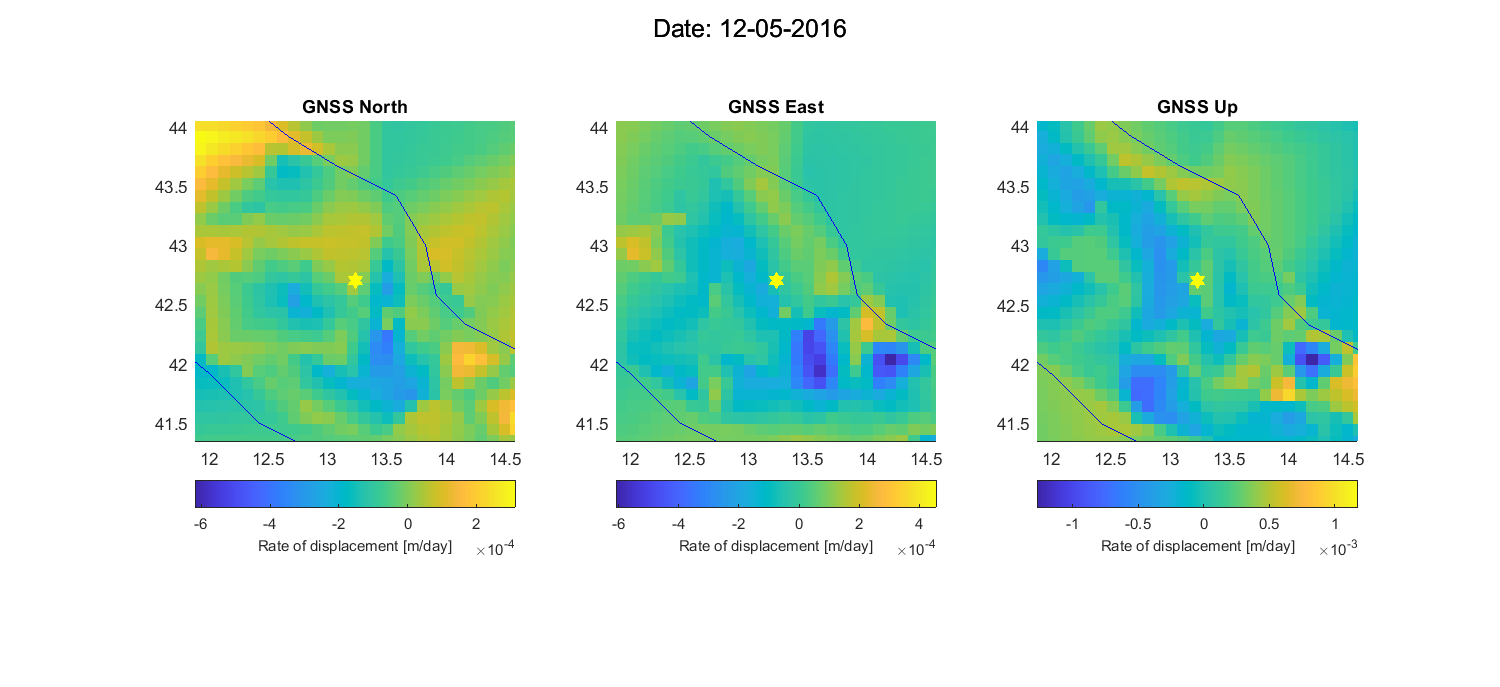

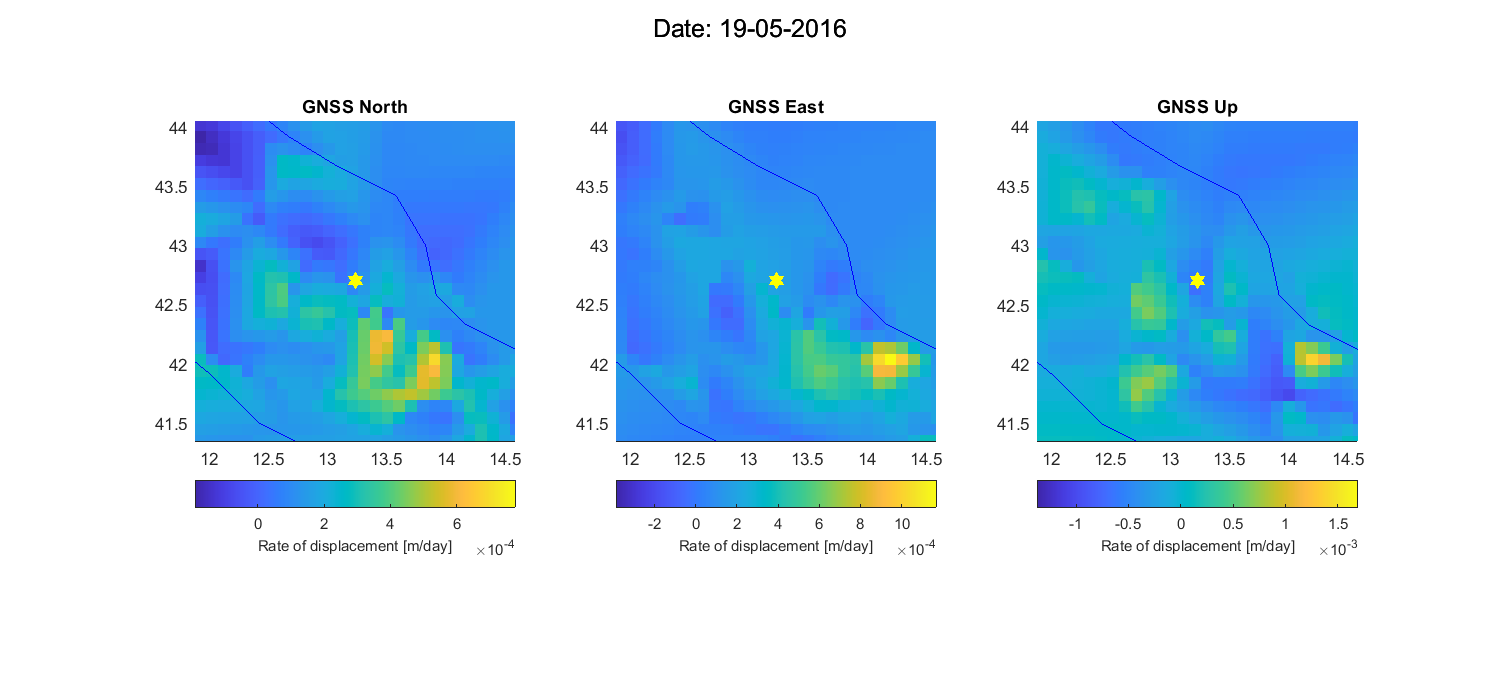

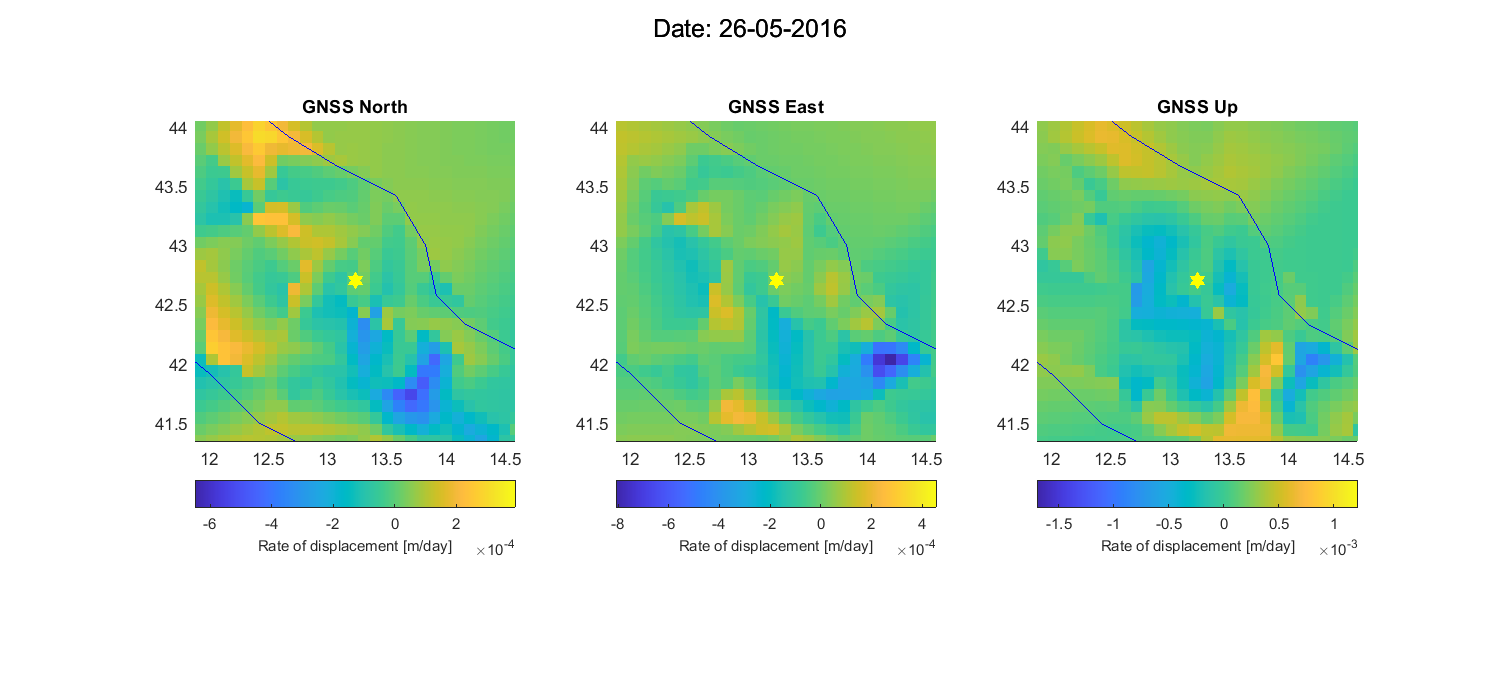

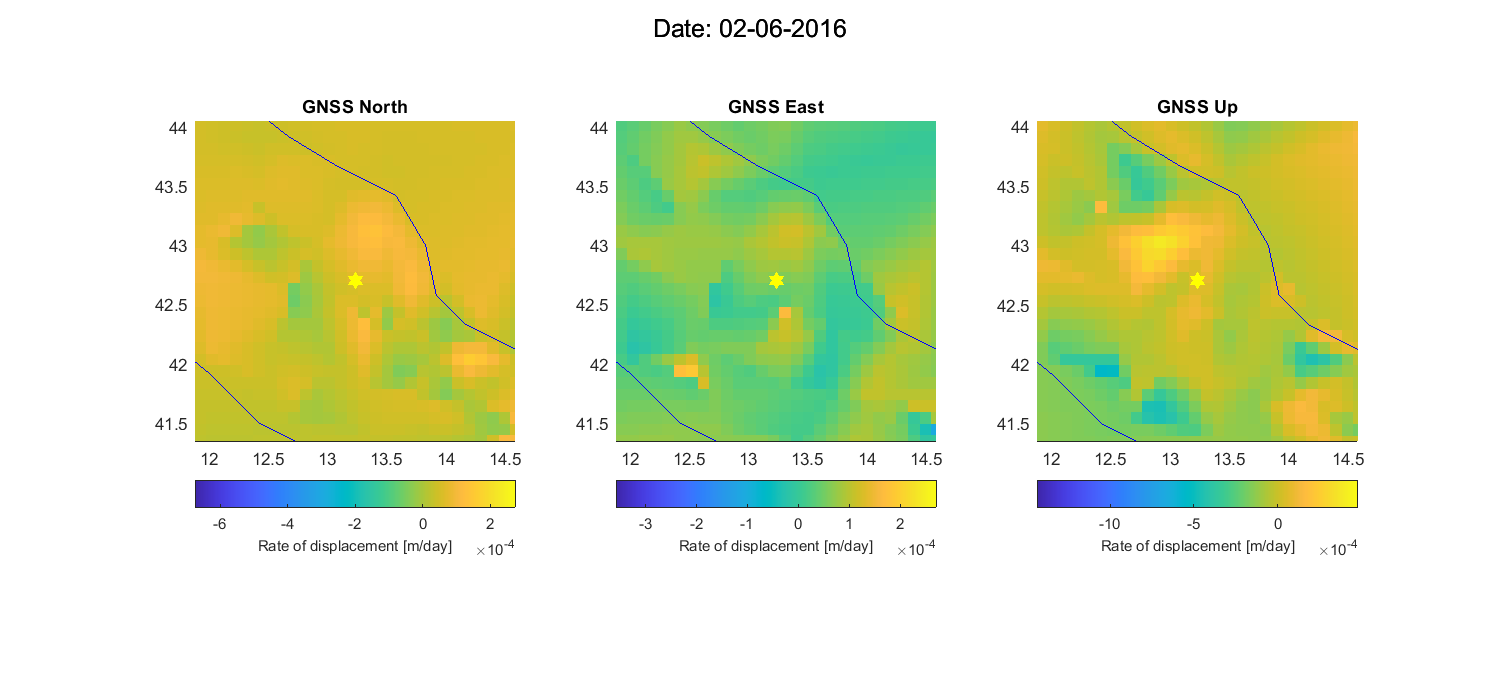

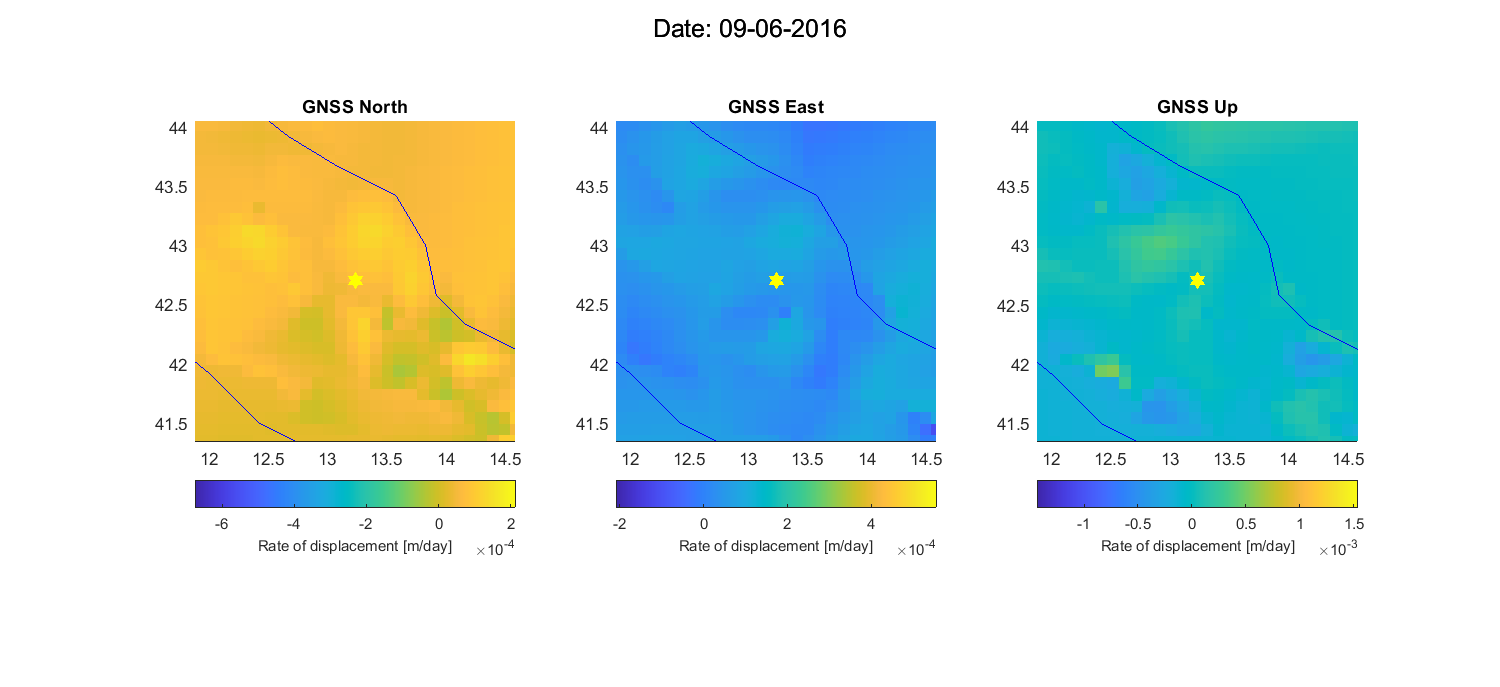

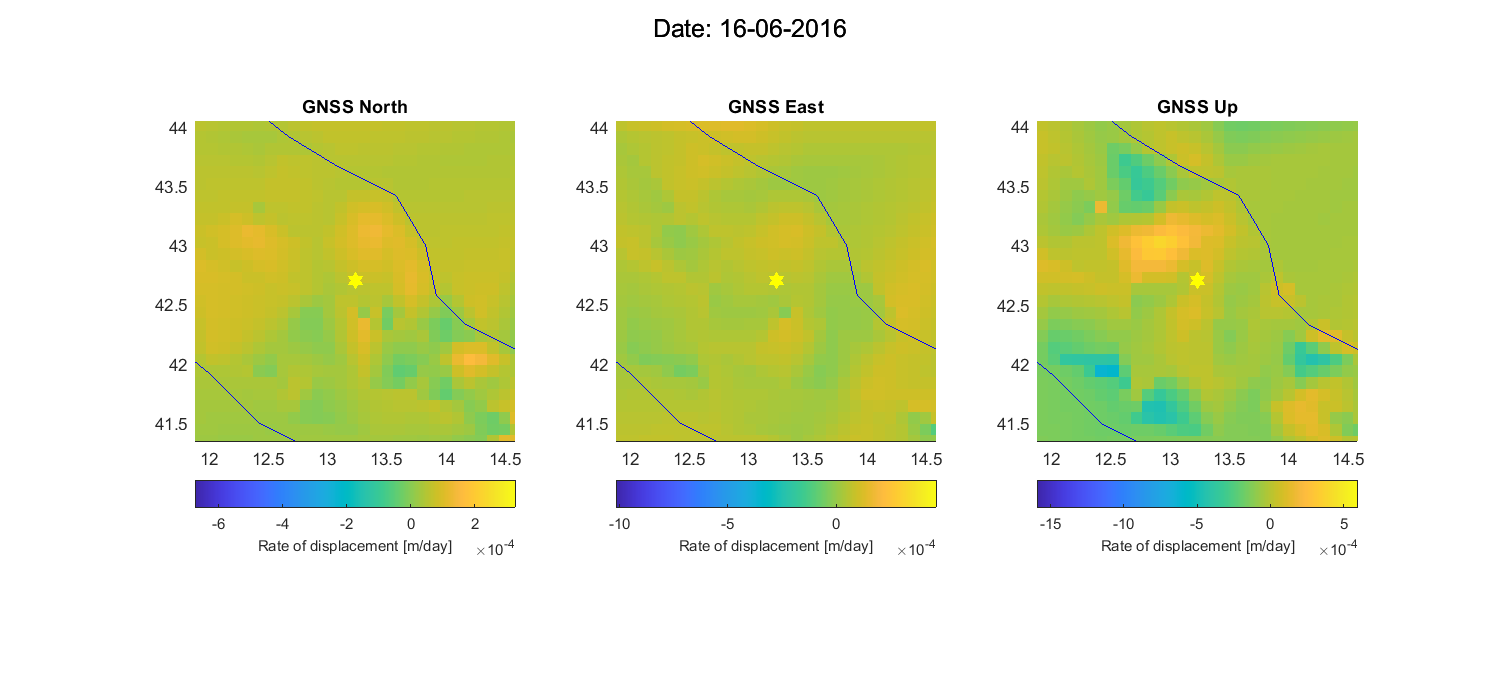

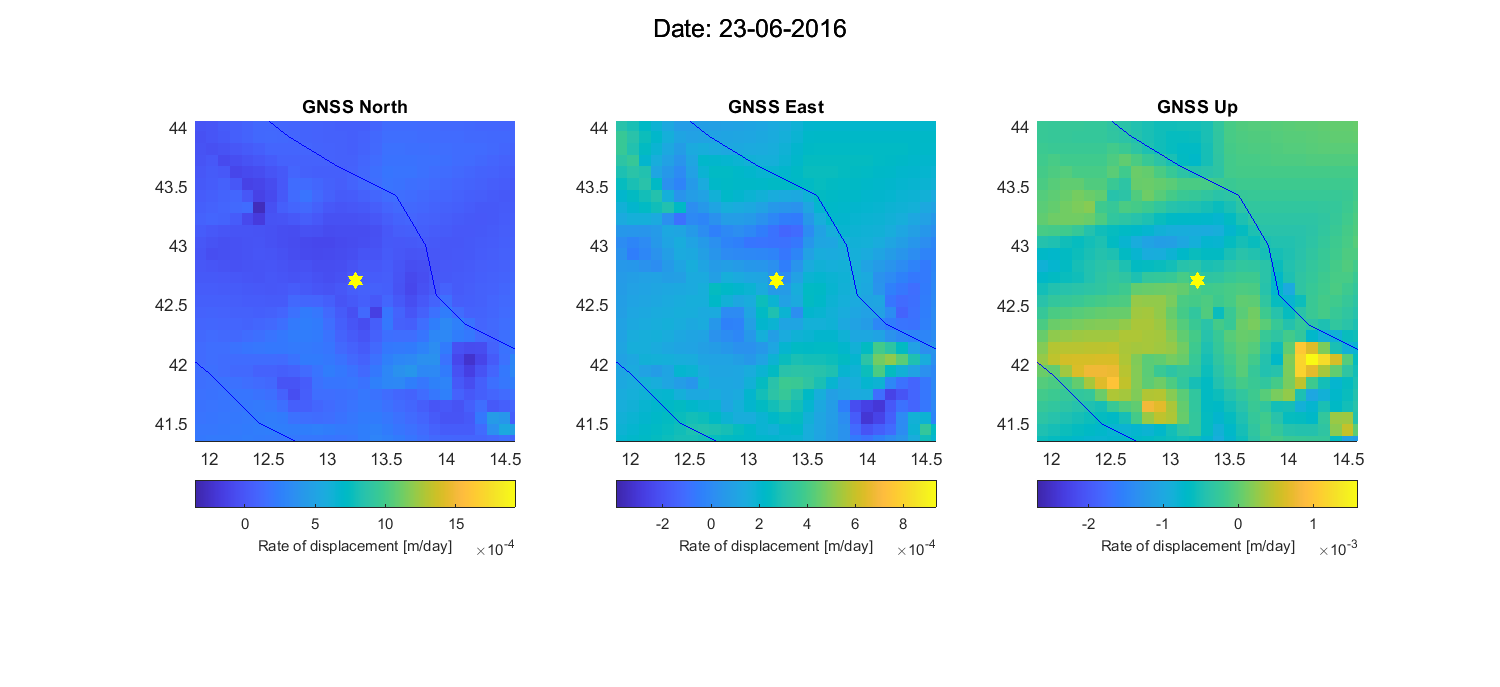

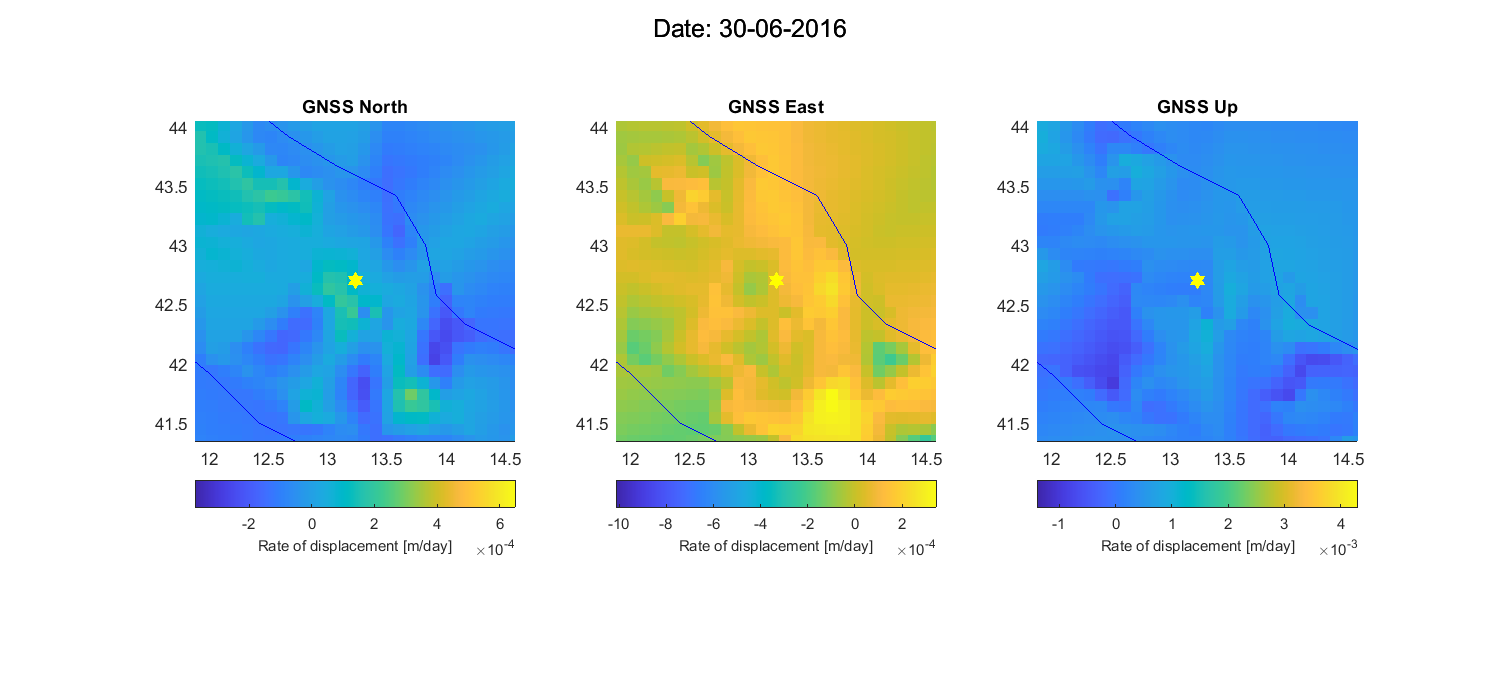

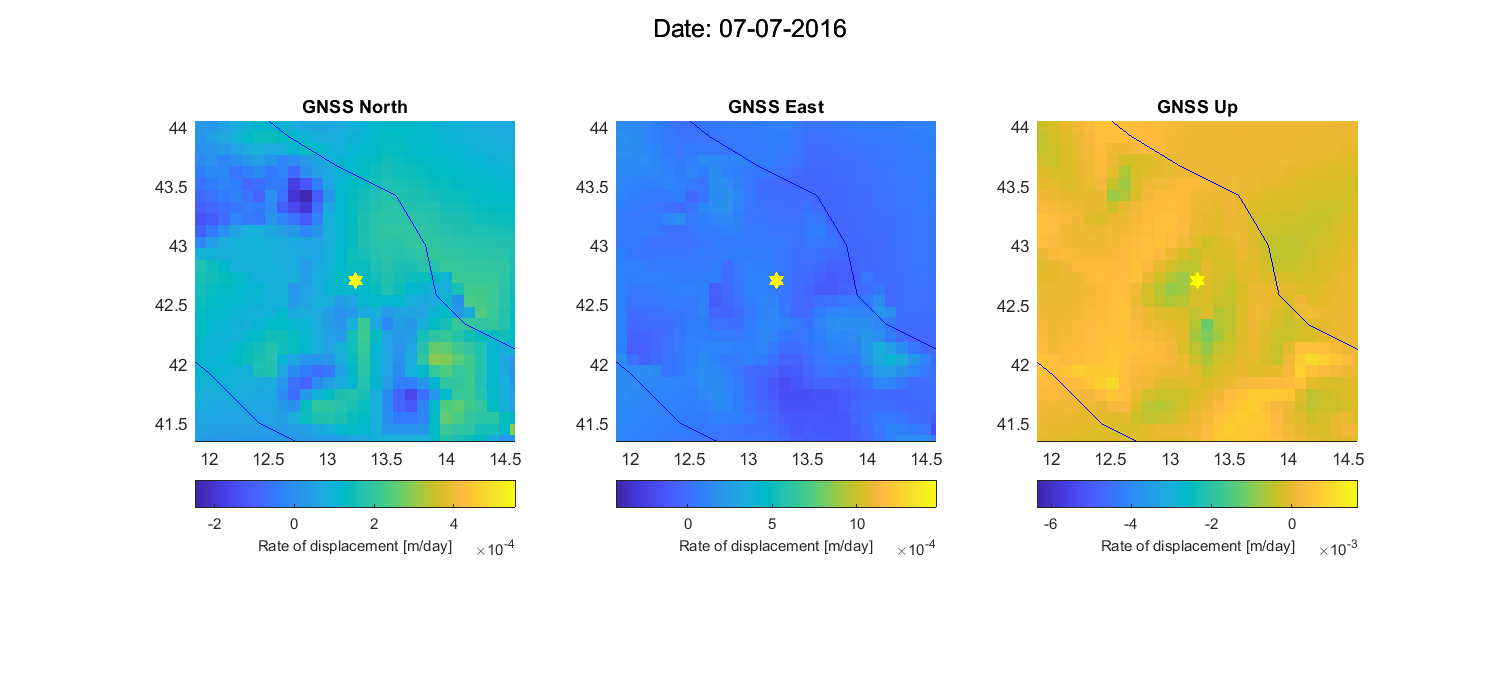

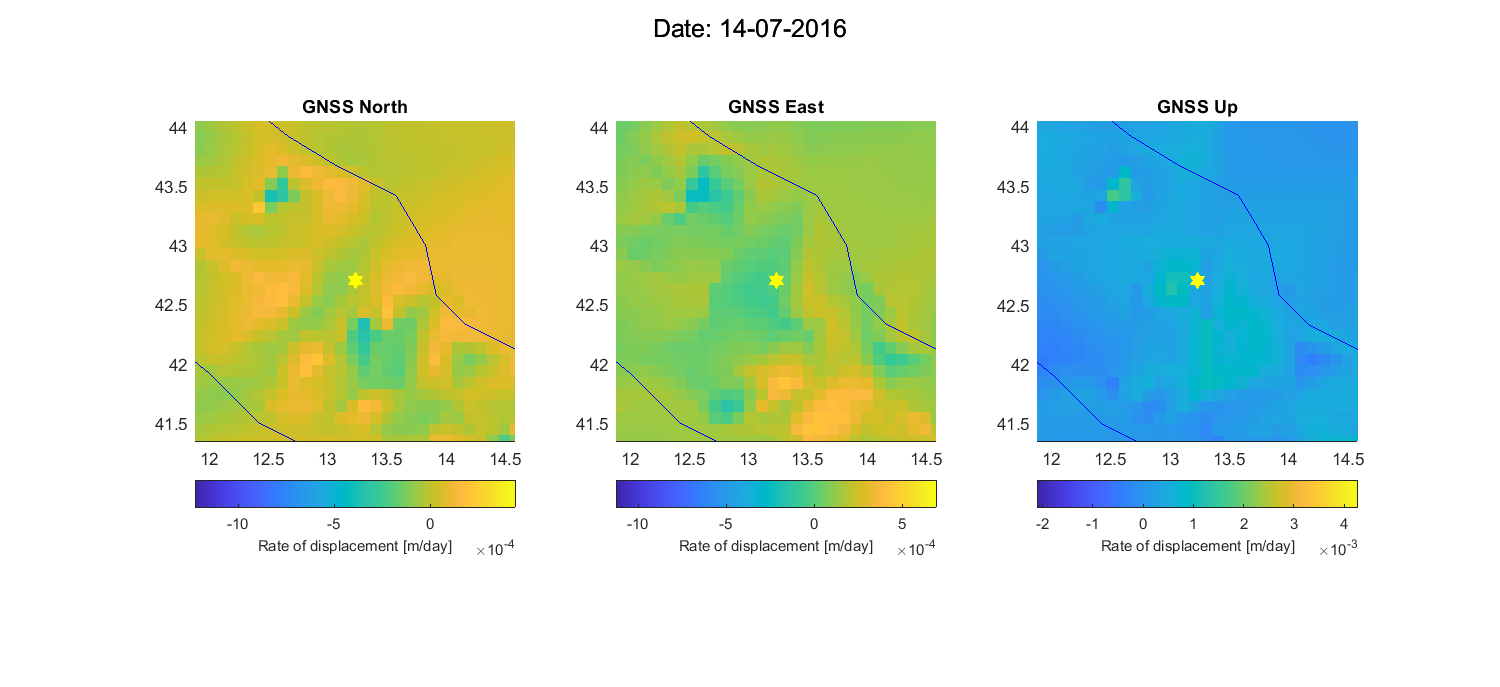

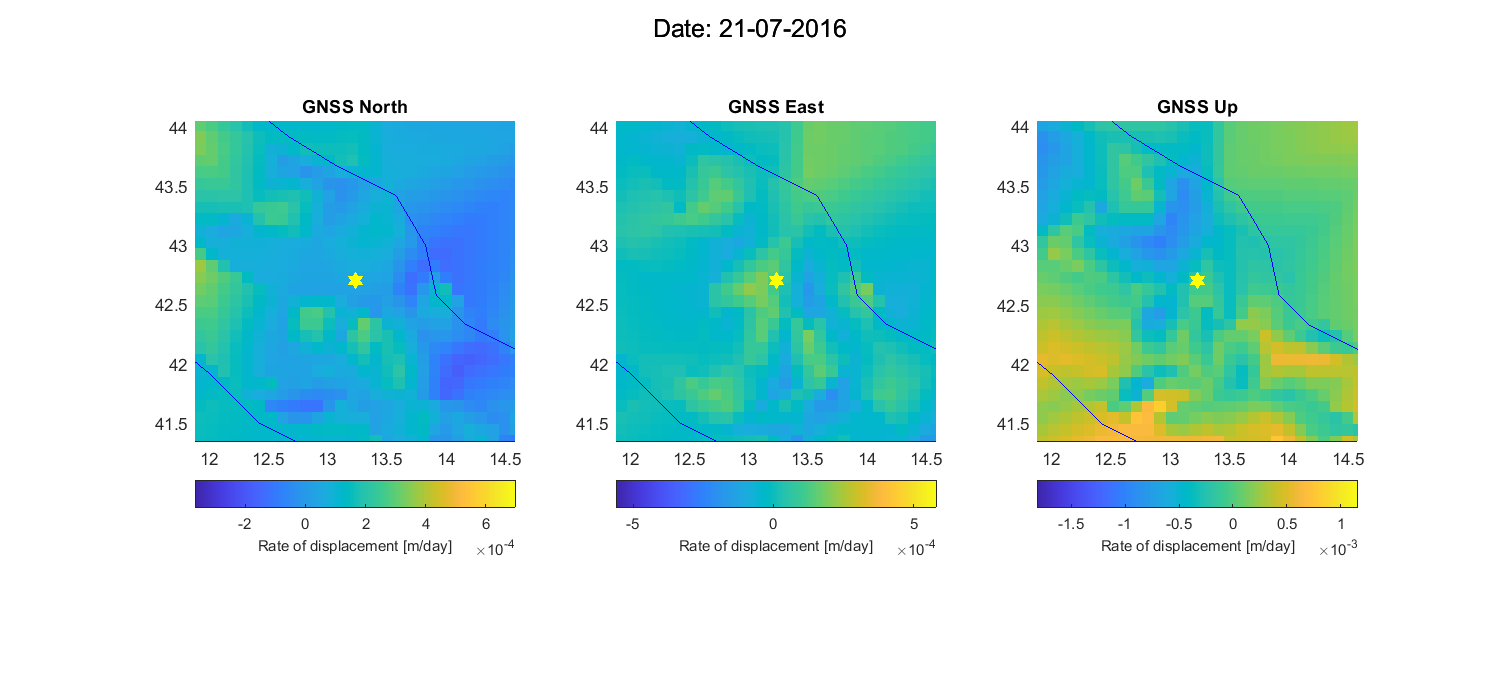

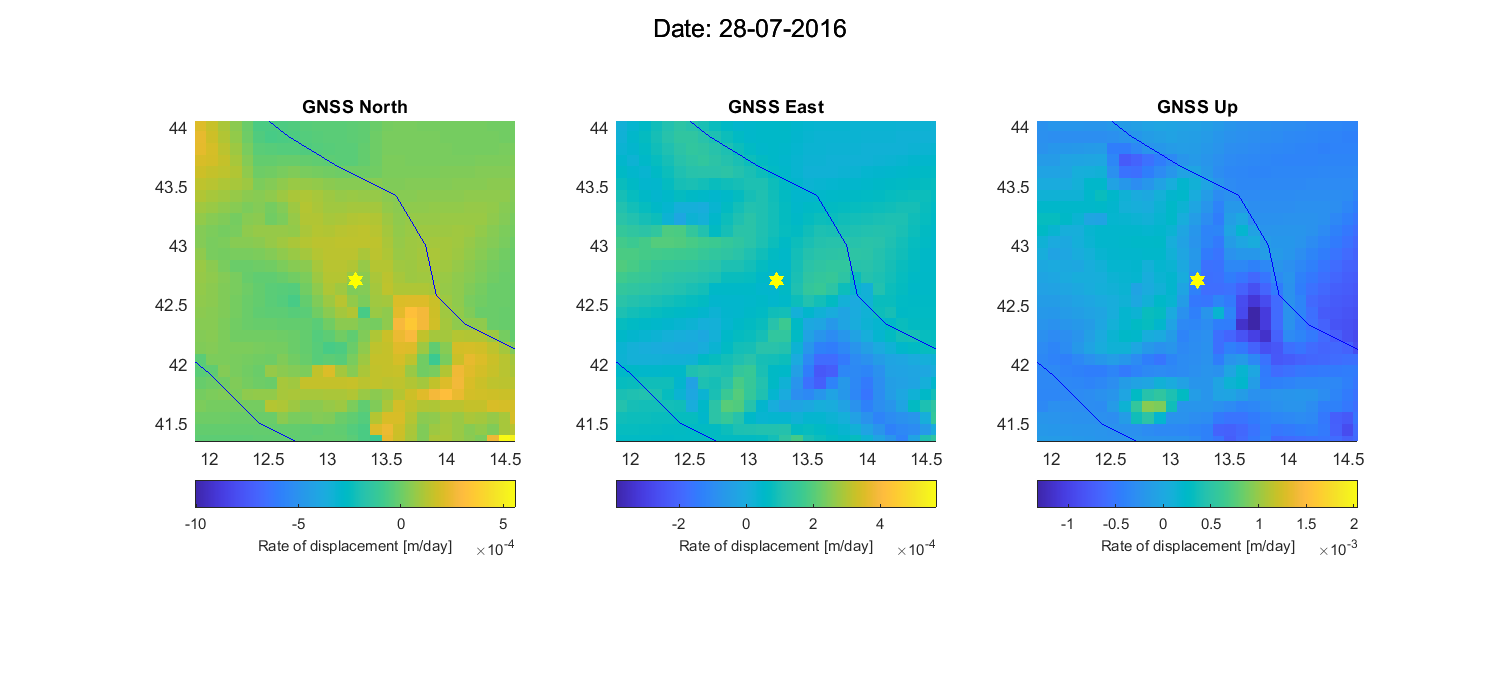

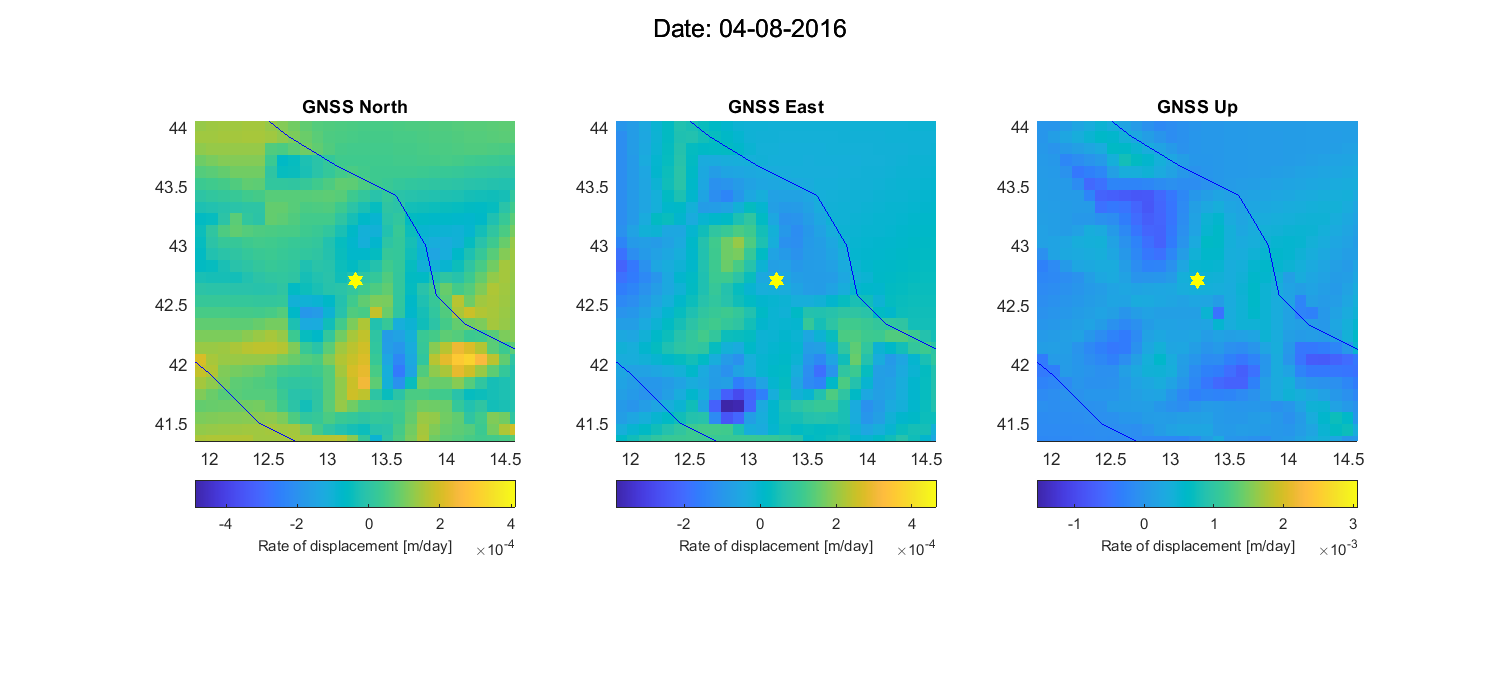

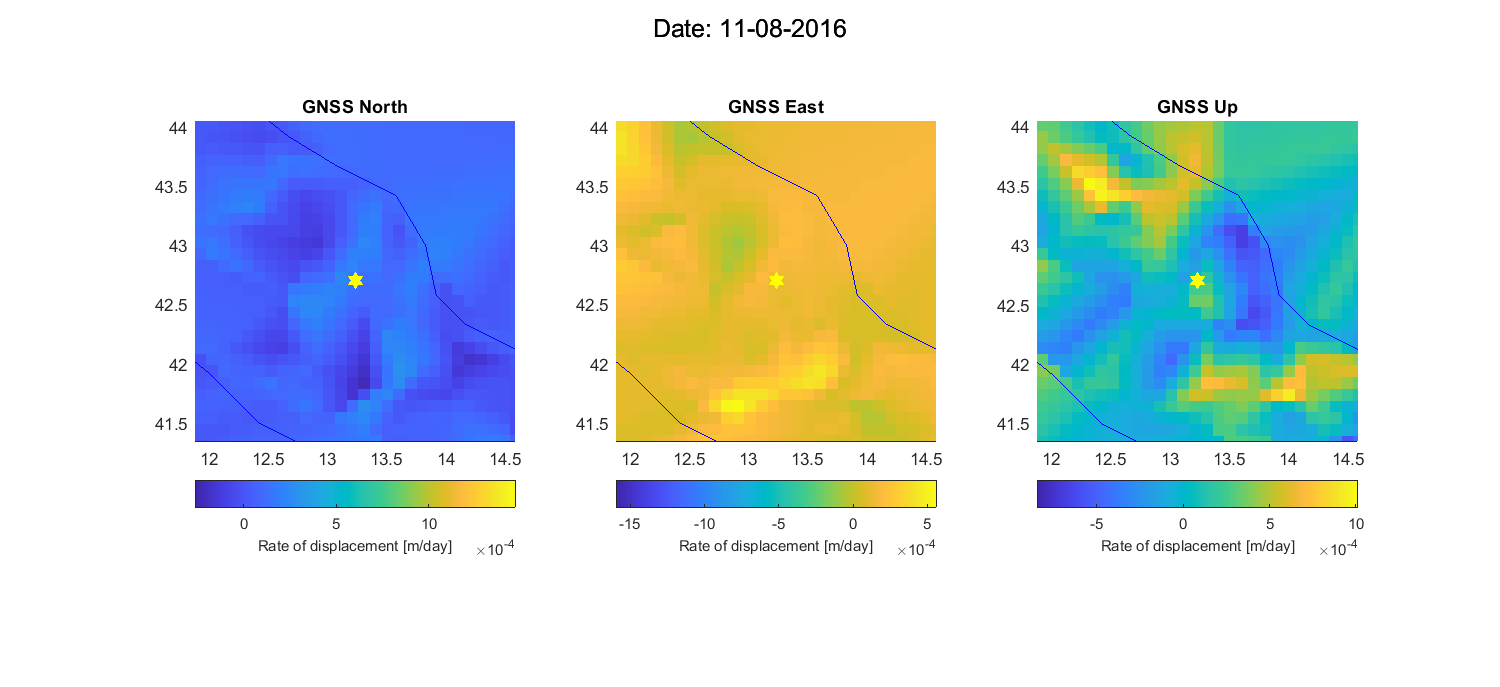

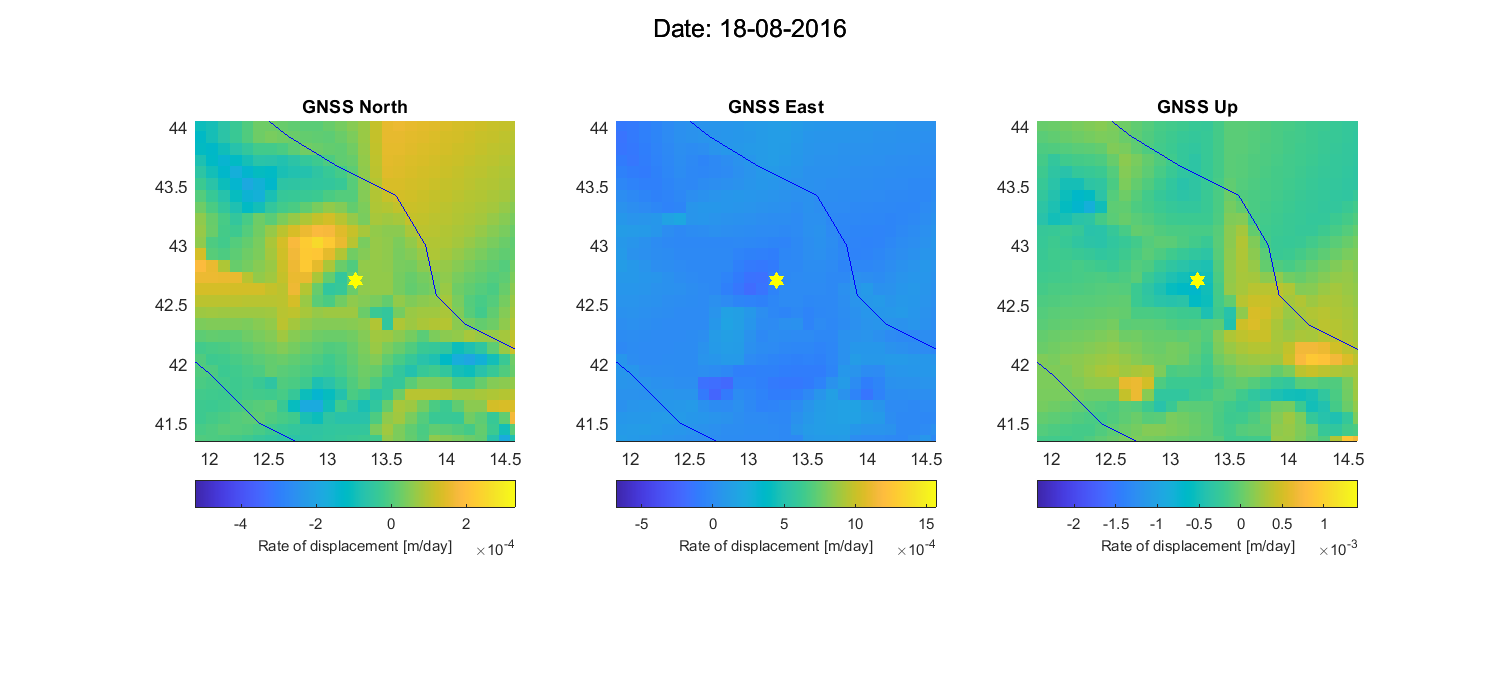

In [17]:
% Organization of the time of acquisition of the GNSS data inside the vector  GNSS_timestamp
GNSS_timestamp = nan(size(data_from_GNSS, 1)*30,1);
k = 1;
for i = 1:size(data_from_GNSS, 1)
    timestamp_1 = data_from_GNSS{i}.data(:,1);
    GNSS_timestamp(k:k+size(timestamp_1,1)-1) = timestamp_1;
    k = k + size(timestamp_1,1);
end
GNSS_timestamp = GNSS_timestamp(1:k-1);
%Extraction and order of the available time steps, considering only the unique ones.
GNSS_timestamp = unique(GNSS_timestamp);

% Preparation of the tensor that stores the data from all the stations at all times.
% Dimensions are: time, stations, components
GNSS_all_data = nan(size(GNSS_timestamp,1), size(data_from_GNSS, 1), 3);
for i = 1:size(data_from_GNSS,1)
    GNSS_station_1 = data_from_GNSS{i}.data;
    time_stamp_station = GNSS_station_1(:,1);
    for k = 1:size(GNSS_timestamp,1)
        data_to_be_assigned = GNSS_station_1(time_stamp_station == GNSS_timestamp(k),2:4);
        if size(data_to_be_assigned,1)>0
            GNSS_all_data(k,i,:) =data_to_be_assigned;
        end
    end
end

% filling missing values with interpolated values
% The first step is the selection of good stations.
station_good = nan(size(data_from_GNSS,1), 1);
station_coordinates = nan(size(data_from_GNSS,1), 2);
for i = 1:size(data_from_GNSS,1)
    if sum(isnan(GNSS_all_data(:,i,1)) | GNSS_all_data(:,i,1) == 0) >= size(GNSS_all_data,1) - 1
        station_good(i,1) = 0;
    else
        station_good(i,1) = 1;
    end
    station_coordinates(i,1:2) = data_from_GNSS{i}.coordinates;
end
GNSS_all_data = GNSS_all_data(:, station_good == 1, :);
station_coordinates = station_coordinates(station_good == 1, :);

% Linear interpolation of the values among the time axis
for i = 1:size(GNSS_all_data,2)
    for j = 1:3
        data_to_be_analysed = GNSS_all_data(:,i,j);
        time_of_data_to_be_analysed = GNSS_timestamp(isfinite(data_to_be_analysed));
        data_to_be_analysed = data_to_be_analysed(isfinite(data_to_be_analysed));
        data_interpolated = interp1(time_of_data_to_be_analysed, data_to_be_analysed, GNSS_timestamp, 'linear');
        GNSS_all_data(:,i,j) = data_interpolated;
    end
end

% Geographical edges of the stations with good data 
min_lat_GNSS = min(station_coordinates(:,2));
max_lat_GNSS = max(station_coordinates(:,2));
min_lon_GNSS = min(station_coordinates(:,1));
max_lon_GNSS = max(station_coordinates(:,1));

resolution_GNSS = 0.1; %Resolution of maps from GNSS data, achieved by spatial interpolation

% Preparation of elements for spatial interpolation
lon_vector = min_lon_GNSS:resolution_GNSS:max_lon_GNSS;
lat_vector = min_lat_GNSS:resolution_GNSS:max_lat_GNSS;
[grid_LAT, grid_LON] = meshgrid(lat_vector, lon_vector);

%Load of coastline data
load coastlines;

% Calculus of differences of GNSS values for the displacement rate
GNSS_all_data_diff = diff(GNSS_all_data, 1, 1);
%Calculus of differences of time
GNSS_timestamp_diff = GNSS_timestamp(1:end-1)/2 + GNSS_timestamp(2:end)/2;
for i = 1:size(GNSS_all_data_diff,1)
    % Calculus of the displacement rate as the first order derivative. 
    GNSS_all_data_diff(i,:,:) = GNSS_all_data_diff(i,:,:) ./ (GNSS_timestamp(i+1)-GNSS_timestamp(i));
    % Preparation of data for spatial interpolation
    data_for_map = reshape(GNSS_all_data_diff(i,:,:), size(GNSS_all_data_diff, 2), size(GNSS_all_data_diff, 3));
    station_coordinates_p = station_coordinates(isfinite(data_for_map(:,1)), :);
    data_for_map = data_for_map(isfinite(data_for_map(:,1)), :);
    % Interpolation of scattered data into a regular grid defined by resolution_GNSS
    F_N = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,1));
    F_E = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,2));
    F_U = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,3));
    interpolated_data_N = F_N(grid_LAT, grid_LON);
    interpolated_data_E = F_E(grid_LAT, grid_LON);
    interpolated_data_U = F_U(grid_LAT, grid_LON);
    %Preparation of the figure map for the specific time interval for each GNSS component
    figure('Position', [1 1 1200 550])
    subplot(1,3,1)
    % Plot of the map of GNSS North rate of displacement
    geoshow(grid_LAT, grid_LON, interpolated_data_N, 'DisplayType', 'texturemap');
    hold on
    plot(coastlon, coastlat, '-b'); % Overplot of coastlines
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y'); % Overplot of epicentre position by a yellow star
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); % Set of map limits
    title('GNSS North');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    subplot(1,3,2)
    % Plot of the map of GNSS East rate of displacement
    geoshow(grid_LAT, grid_LON, interpolated_data_E, 'DisplayType', 'texturemap');
    hold on;
    plot(coastlon, coastlat, '-b'); % Overplot of coastlines
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y'); % Overplot of epicentre position by a yellow star
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); % Set of map limits
    title('GNSS East');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    subplot(1,3,3)
    % Plot of the map of GNSS Up rate of displacement
    geoshow(grid_LAT, grid_LON, interpolated_data_U, 'DisplayType', 'texturemap');
    hold on
    plot(coastlon, coastlat, '-b'); % Overplot of coastlines
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y'); % Overplot of epicentre position by a yellow star
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); % Set of map limits
    title('GNSS Up');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    sgtitle(['Date: ', datestr(GNSS_timestamp_diff(i), 'dd-mm-yyyy')]);
end


## Atmospheric analysis

The atmospheric analysis uses a method called MEANS (*Marchetti et al., 2020*), which is a variation of the CAPRI (*Piscini et al., 2017*) algorithm. MEANS stays for *"MErra-2 ANalysis to search Seismic precursors"* and CAPRI for *"Climatological Analysis for seismic PRecursor Identification"*. A full description of the methods can be found in:  
1. Piscini, A.; De Santis, A.; Marchetti, D.; Cianchini, G. A Multi-Parametric Climatological Approach to Study the 2016 Amatrice–Norcia (Central Italy) Earthquake Preparatory Phase. Pure Appl. Geophys. 2017, 174, 3673–3688. <a href="https://doi.org/10.1007/s00024-017-1597-8">doi:10.1007/s00024-017-1597-8</a>.
2. Marchetti, D.; De Santis, A.; Shen, X.; Campuzano, S.A.; Perrone, L.; Piscini, A.; Di Giovambattista, R.; Jin, S.; Ippolito, A.; Cianchini, G.; et al. Possible Lithosphere-Atmosphere-Ionosphere Coupling Effects Prior to the 2018 Mw = 7.5 Indonesia Earthquake from Seismic, Atmospheric and Ionospheric Data. J. Asian Earth Sci. 2020, 188, 104097. <a href="https://doi.org/10.1016/j.jseaes.2019.104097">doi:10.1016/j.jseaes.2019.104097</a>.


The atmospheric analysis uses the MERRA2 climatological archive data from NASA (doi: <a href="https://doi.org/10.5067/KLICLTZ8EM9D"> 10.5067/KLICLTZ8EM9D</a>).  
This version of the VRE uses data that were downloaded and pre-processed. In future releases, the automatic download of the dataset will be provided.

The pre-processed data are inside the file "Atmospheric_data_for_Norcia.mat".

In this session the data from MERRA-2 Climatological archive will be downloaded and analysed
**Important note:**  
The MERRA-2 data are open but require a free account on EarthData Nasa portal. The following line will ask you your username (generally your registration email) and your password in order to download the data.

In order to mask the password the Matlab tool logindlg has been used. Proper credit to: Jeremy Smith (2025). login (https://www.mathworks.com/matlabcentral/fileexchange/8499-login), MATLAB Central File Exchange. Retrieved January 25, 2025.

The following cell reports the function called *"logindlg"* by Jeremy Smith that permits the insertion of ones's own credentials masking the password. 


In [21]:
% Credit of this cell and function to Jeremy Smith, https://www.mathworks.com/matlabcentral/fileexchange/8499-login
% LOGINDLG   Dialog for visually secure login.
%   Examples:
%       [login password] = logindlg('Title','Login Title');  % Returns the login and
%          password with the dialog title 'Login Title'.
%
%       password = logindlg;  % Returns only the password with a default
%          dialog title.
%
%       password = logindlg('Password','only');  % Displays only a password
%          edit box and returns the password.
%
%       password = logindlg('Title','Login Title','Password','only');
%          % Creates a password only dialog with 'Login Title' as the
%          dialog title.
%
%
%
%
% Author: Jeremy Smith
% Date: September 24, 2005
% Last Edit: January 28, 2010
% Version: 1.3
% Tested on: Matlab 7.0.4.365 (R14) Service Pack 2, Matlab 7.1 SP 3, and
%       Matlab 7.4.0.287 (R2007a)
% Description: custom login dialog because Matlab doesn't have an option
%       for characters in an edit field to be replaced by asterisks
%       (password security).
%
%       Note:  On very slow computers the first few password characters may 
%       have a delay before they are converted to asterisks.

% Changelist:
%   1.3: -Pressing the Escape key with focus anywhere on the dialog will
%            now cancel the dialog box
%        -Typo correction
%        -Escape no longer creates an empty character in the password field
%   1.2: -Tab no longer triggers the OK button in the password box
%        -Improved the script help
%        -Removed horizontal alignment from buttons
%        -Added the option to display only the password box
%   1.1: -Added positioning code so it'll display in the center of the screen
%        -If only one output is specified the password will be returned
%            instead of the login as in Version 1.0
%        -Escape will not only close the dialog if neither edit box is active
%        -When the dialog appears the first edit box will be active
%        -Added a few more comments
%        -Removed the clc, it was left in by mistake in Version 1.0

function [varargout]=logindlg(varargin)

% Number of inputs check
if nargin ==  0 || nargin == 2 || nargin == 4
else
    error('Incorrect number of input arguments.')
end

% Input Type Check
for i=1:1:length(varargin)
    if ~ischar(varargin{i})
        error('Inputs must be strings.')
    end
end

% Title Option
if nargin == 0
    Title = 'Login';
elseif nargin == 2 && ~isempty(strmatch('title',lower(varargin)))
    Title = varargin{2};
elseif nargin == 2 && isempty(strmatch('title',lower(varargin)))
    Title = 'Login';
elseif nargin == 4 && ~isempty(strmatch('title',lower(varargin)))
    S = strmatch('title',lower(varargin));
    if S == 1
        Title = varargin{2};
    elseif S == 3
        Title = varargin{4};
    else
        error('Invalid title.')
    end
else
    error('Invalid title.')
end

% Password Option
if nargin == 0
    Pass = 0;
elseif nargin == 2 && ~isempty(strmatch('password',lower(varargin{1}))) && ~isempty(strmatch('only',lower(varargin{2})))
    Pass = 1;
elseif nargin == 4 && ~isempty(strmatch('password',lower(varargin))) && ~isempty(strmatch('only',lower(varargin)))
    P = strmatch('password',lower(varargin));
    O = strmatch('only',lower(varargin));
    if P == 1 && O == 2
        Pass = 1;
    elseif P == 3 && O == 4
        Pass = 1;
    end
elseif nargin == 2 && isempty(strmatch('password',lower(varargin))) == 1
    Pass = 0;
else
    error('Invalid password option.')
end

% Output Error Check
if nargout > 1 && Pass == 1 || nargout > 2
    error('Too many output arguments.')
end

% Get Properties
Color = get(0,'DefaultUicontrolBackgroundcolor');

% Determine the size and position of the login interface
if Pass == 0
    Height = 9.5;
else
    Height = 5.5;
end
set(0,'Units','characters')
Screen = get(0,'screensize');
Position = [Screen(3)/2-17.5 Screen(4)/2-4.75 35 Height];
set(0,'Units','pixels')

% Create the GUI
gui.main = dialog('HandleVisibility','on',...
    'IntegerHandle','off',...
    'Menubar','none',...
    'NumberTitle','off',...
    'Name','Login',...
    'Tag','logindlg',...
    'Color',Color,...
    'Units','characters',...
    'Userdata','logindlg',...
    'Position',Position);

% Set the title
if ischar(Title) == 1
    set(gui.main,'Name',Title,'Closerequestfcn',{@Cancel,gui.main},'Keypressfcn',{@Escape})
end

% Texts
if Pass == 0
    gui.login_text = uicontrol(gui.main,'Style','text','FontSize',8,'HorizontalAlign','left','Units','characters','String','Login','Position',[1 7.65 20 1]);
end
gui.password_text = uicontrol(gui.main,'Style','text','FontSize',8,'HorizontalAlign','left','Units','characters','String','Password','Position',[1 4.15 20 1]);

% Edits
if Pass == 0
    gui.edit1 = uicontrol(gui.main,'Style','edit','FontSize',8,'HorizontalAlign','left','BackgroundColor','white','Units','characters','String','','Position',[1 6.02 33 1.7],'KeyPressfcn',{@Escape});
end
gui.edit2 = uicontrol(gui.main,'Style','edit','FontSize',8,'HorizontalAlign','left','BackgroundColor','white','Units','characters','String','','Position',[1 2.52 33 1.7],'KeyPressfcn',{@KeyPress_Function,gui.main},'Userdata','');

% Buttons
gui.OK = uicontrol(gui.main,'Style','push','FontSize',8,'Units','characters','String','OK','Position',[12 .2 10 1.7],'Callback',{@OK,gui.main},'KeyPressfcn',{@Escape});
gui.Cancel = uicontrol(gui.main,'Style','push','FontSize',8,'Units','characters','String','Cancel','Position',[23 .2 10 1.7],'Callback',{@Cancel,gui.main},'KeyPressfcn',{@Escape});

setappdata(0,'logindlg',gui) % Save handle data
setappdata(gui.main,'Check',0) % Error check setup. If Check remains 0 an empty cell array will be returned

if Pass == 0
    uicontrol(gui.edit1) % Make the first edit box active
else
    uicontrol(gui.edit2)  % Make the second edit box active if the first isn't present
end

% Pause the GUI and wait for a button to be pressed
uiwait(gui.main)

Check = getappdata(gui.main,'Check'); % Check to see if a button was pressed

% Format output
if Check == 1
    if Pass == 0
        Login = get(gui.edit1,'String');
    end
    Password = get(gui.edit2,'Userdata');
    
    if nargout == 1 % If only one output specified output Password
        varargout(1) = {Password};
    elseif nargout == 2 % If two outputs specified output both Login and Password
        varargout(1) = {Login};
        varargout(2) = {Password};
    end
else % If OK wasn't pressed output nothing
    if nargout == 1
        varargout(1) = {[]};
    elseif nargout == 2
        varargout(1) = {[]};
        varargout(2) = {[]};
    end
end

delete(gui.main) % Close the GUI
setappdata(0,'logindlg',[]) % Erase handles from memory

%% Hide Password
function KeyPress_Function(h,eventdata,fig)
% Function to replace all characters in the password edit box with
% asterisks
password = get(h,'Userdata');
key = get(fig,'currentkey');

switch key
    case 'backspace'
        password = password(1:end-1); % Delete the last character in the password
    case 'return'  % This cannot be done through callback without making tab to the same thing
        gui = getappdata(0,'logindlg');
        OK([],[],gui.main);
    case 'tab'  % Avoid tab triggering the OK button
        gui = getappdata(0,'logindlg');
        uicontrol(gui.OK);
    case 'escape'
        % Close the login dialog
        Escape(fig,[])
    otherwise
        password = [password get(fig,'currentcharacter')]; % Add the typed character to the password
end

SizePass = size(password); % Find the number of asterisks
if SizePass(2) > 0
    asterisk(1,1:SizePass(2)) = '*'; % Create a string of asterisks the same size as the password
    set(h,'String',asterisk) % Set the text in the password edit box to the asterisk string
else
    set(h,'String','')
end

set(h,'Userdata',password) % Store the password in its current state

%% Cancel
function Cancel(h,eventdata,fig)
uiresume(fig)

%% OK
function OK(h,eventdata,fig)
% Set the check and resume
setappdata(fig,'Check',1)
uiresume(fig)

%% Escape
function Escape(h,eventdata)
% Close the login if the escape button is pushed and neither edit box is
% active
fig = h;
while ~strcmp(get(fig,'Type'),'figure')
    fig = get(fig,'Parent');
end
key = get(fig,'currentkey');

if isempty(strfind(key,'escape')) == 0
    Cancel([],[],fig)
end

The following line acquires your username and password of EarthData NASA account (free registration). This is necessary to download the MERRA-2 data. In case you already have the data locally, you can skip the following two cells.  
To improve the speed of download of the data, which may require up to 5 days, it's suggested to run the following cells inside Matlab Interface/command line.

In [22]:
%Acquisition of your EarthData NASA account username and password (free registration).
[User_ED pwd_ED] = logindlg('Please insert your username and password for your EarthData account','Login Title');

In [ ]:
% Section to download the necessary data from NASA - MERRA2

%set the basic parameters to connect with NASA server
options_for_NASA = weboptions('Username', User_ED,'Password', pwd_ED, 'Timeout', 30000);
%Calculate the EQ time and research area to download the data
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = round(epilat - radius_Dobrovolsky/sqrt(2));
max_lat = round(epilat + radius_Dobrovolsky/sqrt(2));
min_lon = round(epilon - radius_Dobrovolsky/sqrt(2));
max_lon = round(epilon + radius_Dobrovolsky/sqrt(2));
%Calculate the local midnight at earthquake longitude
local_midnight = - epilon/15;
% search for the closest UT clock time to the local midnight
UT_time_of_data = round(local_midnight);
if UT_time_of_data >= 24
    UT_time_of_data = UT_time_of_data - 24;
end
if UT_time_of_data < 0
    UT_time_of_data = UT_time_of_data + 24;
end
% set the corresponding index for the specific hour
index_of_time_data = UT_time_of_data + 1; %The index is increased of a unit as Matlab starts to count from "1"

% set the time interval limits. This limit is for the day/month
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
% Search for the last year to be downloaded. In case the earthquake occurred before the present year, it is the previous year.
[year_end1, month_end1, day_end1] = datevec(time_end);
[year_end, ~] = datevec(now); %2024;
if EQ_year < year_end
    year_end = year_end -1; %Stop the analysis the year before the present one.
end
% calculate the total number of analysed day for each year
number_of_analysed_days = day_after + day_before + 1;
% Calculate the start year, considering that the dataset started in 1980, but if the interval would extend in 1979 the starting year is considered 1981
if (datenum([1980 month_end1 day_end1]) - number_of_analysed_days) < datenum([1980 1 1])
    year_start = 1981;
else
    year_start = 1980;
end
[~, month_start, day_start] = datevec(time_start);
% set the first day to be downloaded
time_start = datenum([year_start, month_start, day_start]);
% set the last day to be downloaded
time_end = datenum([year_end, month_end1, day_end1]);
number_of_analysed_days = time_end - time_start + 1;
% check if some data have been already downloaded before and load them
if exist(fullfile('data', 'Atmospheric_data_from_MERRA2.mat')) > 0
    load(fullfile('data', 'Atmospheric_data_from_MERRA2.mat'));
else
% otherwise the variable to store the atmospheric data and their timestamp are created
    TCWV = nan(number_of_analysed_days, 1);
    TCWV_time = nan(number_of_analysed_days, 1);
    SO2 = nan(number_of_analysed_days, 1);
    SO2_time = nan(number_of_analysed_days, 1);
    DMS = nan(number_of_analysed_days, 1);
    DMS_time = nan(number_of_analysed_days, 1);
    AOT = nan(number_of_analysed_days, 1);
    AOT_time = nan(number_of_analysed_days, 1);
    CO = nan(number_of_analysed_days, 1);
    CO_time = nan(number_of_analysed_days, 1);
    TO3 = nan(number_of_analysed_days, 1);
    TO3_time = nan(number_of_analysed_days, 1);
    SAT = nan(number_of_analysed_days, 1);
    SAT_time = nan(number_of_analysed_days, 1);
    HUM = nan(number_of_analysed_days, 1);
    HUM_time = nan(number_of_analysed_days, 1);
    SLHF = nan(number_of_analysed_days, 1);
    SLHF_time = nan(number_of_analysed_days, 1);
    RAIN = nan(number_of_analysed_days, 1);
    RAIN_time = nan(number_of_analysed_days, 1);
end

% creation of a vector with the day that must be checked/downloaded, i.e., the day necessary for the atmospheric analysis
k = 1;
list_of_days = nan(number_of_analysed_days, 1);
for year_tba = year_start:year_end
    time_start_1 = datenum([year_tba EQ_month EQ_day]) - day_before-1;
    time_end_1 = datenum([year_tba EQ_month EQ_day]) + day_after;
    for day_tba = time_start_1:time_end_1
        list_of_days(k,1) = day_tba;
        k = k + 1;
    end
end
list_of_days = list_of_days(1:k-1);

% cycle all the days.
% Firstly, the existance of the specific variable is checked, as it could be already downloaded otherwise the corresponding request to the NASA archive is performed 
k = 1;
for i_day = 1:size(list_of_days,1)
    day_to_be_analyed=list_of_days(i_day); 
    [year_tba, month_tba, day_tba] = datevec(day_to_be_analyed)
    % check of TCWV variable of the specific day exist or not
    if sum(TCWV_time == day_to_be_analyed) == 0
        % search for the first available row inside the vector
        index_nan = find(isnan(TCWV_time));
        if size(index_nan,1) == 0
            index_nan = size(TCWV_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        %The version of MERRA-2 changed among the time, so the following filename must be followed.
        % MERRA2_100.*.19800101.nc4
        % MERRA2_200.*.19920101.nc4
        % MERRA2_300.*.20010101.nc4
        % MERRA2_400.*.20110101.nc4
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        % The URL to download the data is constructed
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2I1NXINT.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.inst1_2d_int_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&VERSION=1.02&SERVICE=L34RS_MERRA2&DATASET_VERSION=5.12.4&LABEL=', version_f, '.inst1_2d_int_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&FORMAT=bmM0Lw&VARIABLES=TQV&SHORTNAME=M2I1NXINT'];
        % Data are downloaded from the server
        TCVW_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        % The data are temporarly written in a file test_MERRA.nc
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, TCVW_p);
        fclose(file_output);
        %The data are read from the temporarly file test_MERRA.nc
        TCVW_1 = ncread('test_MERRA.nc', 'TQV');
        % data and time are stored in the proper variable (TCWV and TCWV_time)
        TCWV(index_nan,1) = mean(reshape(TCVW_1(:,:,index_of_time_data), size(TCVW_1,1)*size(TCVW_1,2), 1));
        TCWV_time(index_nan,1) = day_to_be_analyed;
        % Every 15 days the data are saved. In this way, in case of failure data lost is reduced. Data are not written for each day otehrwise the cycle is too slow for continuos writing to HDD 
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save(fullfile('data', 'Atmospheric_data_from_MERRA2.mat'), 'TCWV', 'TCWV_time', 'SO2', 'SO2_time', 'DMS', 'DMS_time', 'AOT', 'AOT_time', 'CO', 'CO_time', 'TO3', 'TO3_time',  'SAT', 'SAT_time', 'HUM', 'HUM_time', 'SLHF', 'SLHF_time', 'RAIN', 'RAIN_time');
        end
    end

% All the previous procedure is repeated for SO2, DMS and Aerosol (AOT) parameters
    if sum(SO2_time == day_to_be_analyed) == 0
        index_nan = find(isnan(SO2_time));
        if size(index_nan,1) == 0
            index_nan = size(SO2_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2T1NXAER.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.tavg1_2d_aer_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&SERVICE=L34RS_MERRA2&VERSION=1.02&LABEL=', version_f, '.tavg1_2d_aer_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc&SHORTNAME=M2T1NXAER&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A30%3A00&DATASET_VERSION=5.12.4&VARIABLES=DMSSMASS%2CSO2SMASS%2CTOTEXTTAU&FORMAT=nc4%2F'];
        SO2_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, SO2_p);
        fclose(file_output);
        SO2_1 = ncread('test_MERRA.nc', 'SO2SMASS');
        DMS_1 = ncread('test_MERRA.nc', 'DMSSMASS');
        AOT_1 = ncread('test_MERRA.nc', 'TOTEXTTAU');
        SO2(index_nan,1) = mean(reshape(SO2_1(:,:,index_of_time_data), size(SO2_1,1)*size(SO2_1,2), 1));
        SO2_time(index_nan,1) = day_to_be_analyed;
        DMS(index_nan,1) = mean(reshape(DMS_1(:,:,index_of_time_data), size(DMS_1,1)*size(DMS_1,2), 1));
        DMS_time(index_nan,1) = day_to_be_analyed;
        AOT(index_nan,1) = mean(reshape(AOT_1(:,:,index_of_time_data), size(AOT_1,1)*size(AOT_1,2), 1));
        AOT_time(index_nan,1) = day_to_be_analyed;
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save(fullfile('data', 'Atmospheric_data_from_MERRA2.mat'), 'TCWV', 'TCWV_time', 'SO2', 'SO2_time', 'DMS', 'DMS_time', 'AOT', 'AOT_time', 'CO', 'CO_time', 'TO3', 'TO3_time',  'SAT', 'SAT_time', 'HUM', 'HUM_time', 'SLHF', 'SLHF_time', 'RAIN', 'RAIN_time');
        end
    end

% All the previous procedure is repeated for CO and Total Column Ozon (TO3) parameters
    if sum(CO_time == day_to_be_analyed) == 0
    index_nan = find(isnan(CO_time));
        if size(index_nan,1) == 0
            index_nan = size(CO_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2T1NXCHM.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.tavg1_2d_chm_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&FORMAT=bmM0Lw&VERSION=1.02&LABEL=', version_f, '.tavg1_2d_chm_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc&SHORTNAME=M2T1NXCHM&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A00%3A00&DATASET_VERSION=5.12.4&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&VARIABLES=COSC%2CTO3&SERVICE=L34RS_MERRA2'];
        CO_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, CO_p);
        fclose(file_output);
        CO_1 = ncread('test_MERRA.nc', 'COSC');
        TO3_1 = ncread('test_MERRA.nc', 'TO3');
        CO(index_nan,1) = mean(reshape(CO_1(:,:,index_of_time_data), size(CO_1,1)*size(CO_1,2), 1));
        CO_time(index_nan,1) = day_to_be_analyed;
        TO3(index_nan,1) = mean(reshape(TO3_1(:,:,index_of_time_data), size(TO3_1,1)*size(TO3_1,2), 1));
        TO3_time(index_nan,1) = day_to_be_analyed;
        
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save(fullfile('data', 'Atmospheric_data_from_MERRA2.mat'), 'TCWV', 'TCWV_time', 'SO2', 'SO2_time', 'DMS', 'DMS_time', 'AOT', 'AOT_time', 'CO', 'CO_time', 'TO3', 'TO3_time',  'SAT', 'SAT_time', 'HUM', 'HUM_time', 'SLHF', 'SLHF_time', 'RAIN', 'RAIN_time');
        end
    end

% All the previous procedure is repeated for Surface Air Temperature (SAT) and Humidity parameters
    if sum(SAT_time == day_to_be_analyed) == 0
        index_nan = find(isnan(SAT_time));
        if size(index_nan,1) == 0
            index_nan = size(SAT_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2I1NXLFO.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.inst1_2d_lfo_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&VERSION=1.02&SERVICE=L34RS_MERRA2&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&DATASET_VERSION=5.12.4&SHORTNAME=M2I1NXLFO&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A00%3A00&LABEL=', version_f, '.inst1_2d_lfo_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc&VARIABLES=QLML%2CTLML&FORMAT=nc4%2F'];
        SAT_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, SAT_p);
        fclose(file_output);
        SAT_1 = ncread('test_MERRA.nc', 'TLML');
        HUM_1 = ncread('test_MERRA.nc', 'QLML');
        SAT(index_nan,1) = mean(reshape(SAT_1(:,:,index_of_time_data), size(SAT_1,1)*size(SAT_1,2), 1));
        SAT_time(index_nan,1) = day_to_be_analyed;
        HUM(index_nan,1) = mean(reshape(HUM_1(:,:,index_of_time_data), size(HUM_1,1)*size(HUM_1,2), 1));
        HUM_time(index_nan,1) = day_to_be_analyed;
        
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save(fullfile('data', 'Atmospheric_data_from_MERRA2.mat'), 'TCWV', 'TCWV_time', 'SO2', 'SO2_time', 'DMS', 'DMS_time', 'AOT', 'AOT_time', 'CO', 'CO_time', 'TO3', 'TO3_time',  'SAT', 'SAT_time', 'HUM', 'HUM_time', 'SLHF', 'SLHF_time', 'RAIN', 'RAIN_time');
        end
    end

% All the previous procedure is repeated for Rain and Surface Latent Heat Flux (SLHF) parameters
    if sum(RAIN_time == day_to_be_analyed) == 0
    % if isnan(RAIN_time(k)) == 1
        index_nan = find(isnan(RAIN_time));
        if size(index_nan,1) == 0
            index_nan = size(RAIN_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2T1NXFLX.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.tavg1_2d_flx_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&VARIABLES=EFLUX%2CPRECTOT&VERSION=1.02&SERVICE=L34RS_MERRA2&DATASET_VERSION=5.12.4&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&FORMAT=bmM0Lw&SHORTNAME=M2T1NXFLX&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A00%3A00&LABEL=', version_f, '.tavg1_2d_flx_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc'];
        SLHF_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, SLHF_p);
        fclose(file_output);
        SLHF_1 = ncread('test_MERRA.nc', 'EFLUX');
        RAIN_1 = ncread('test_MERRA.nc', 'PRECTOT');
        SLHF(index_nan,1) = mean(reshape(SLHF_1(:,:,index_of_time_data), size(SLHF_1,1)*size(SLHF_1,2), 1));
        SLHF_time(index_nan,1) = day_to_be_analyed;
        RAIN(index_nan,1) = mean(reshape(RAIN_1(:,:,index_of_time_data), size(RAIN_1,1)*size(RAIN_1,2), 1));
        RAIN_time(index_nan,1) = day_to_be_analyed;
        
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save(fullfile('data', 'Atmospheric_data_from_MERRA2.mat'), 'TCWV', 'TCWV_time', 'SO2', 'SO2_time', 'DMS', 'DMS_time', 'AOT', 'AOT_time', 'CO', 'CO_time', 'TO3', 'TO3_time',  'SAT', 'SAT_time', 'HUM', 'HUM_time', 'SLHF', 'SLHF_time', 'RAIN', 'RAIN_time');
        end
    end    
    
    k = k + 1;
end

% At the end all the downloaded data are saved on the disk
save(fullfile('data', 'Atmospheric_data_from_MERRA2.mat'), 'TCWV', 'TCWV_time', 'SO2', 'SO2_time', 'DMS', 'DMS_time', 'AOT', 'AOT_time', 'CO', 'CO_time', 'TO3', 'TO3_time',  'SAT', 'SAT_time', 'HUM', 'HUM_time', 'SLHF', 'SLHF_time', 'RAIN', 'RAIN_time');


year_tba =         1980

month_tba =     12

day_tba =     26

year_tba =         1980

month_tba =     12

day_tba =     27

year_tba =         1980

month_tba =     12

day_tba =     28

year_tba =         1980

month_tba =     12

day_tba =     29

year_tba =         1980

month_tba =     12

day_tba =     30

year_tba =         1980

month_tba =     12

day_tba =     31

year_tba =         1981

month_tba =      1

day_tba =      1

year_tba =         1981

month_tba =      1

day_tba =      2

year_tba =         1981

month_tba =      1

day_tba =      3

year_tba =         1981

month_tba =      1

day_tba =      4

year_tba =         1981

month_tba =      1

day_tba =      5

year_tba =         1981

month_tba =      1

day_tba =      6

year_tba =         1981

month_tba =      1

day_tba =      7

year_tba =         1981

month_tba =      1

day_tba =      8

year_tba =         1981

month_tba =      1

day_tba =      9

year_tba =         1981

month_tba =      1

day_tba =     10

year_tba =         1981

month_tba =      1

day_tba =     11

year_tba =         1981

month_tba =      1

day_tba =     12

year_tba =         1981

month_tba =      1

day_tba =     13

year_tba =         1981

month_tba =      1

day_tba =     14

year_tba =         1981

month_tba =      1

day_tba =     15

year_tba =         1981

month_tba =      1

day_tba =     16

year_tba =         1981

month_tba =      1

day_tba =     17

year_tba =         1981

month_tba =      1

day_tba =     18

year_tba =         1981

month_tba =      1

day_tba =     19

year_tba =         1981

month_tba =      1

day_tba =     20

year_tba =         1981

month_tba =      1

day_tba =     21

year_tba =         1981

month_tba =      1

day_tba =     22

year_tba =         1981

month_tba =      1

day_tba =     23

year_tba =         1981

month_tba =      1

day_tba =     24

year_tba =         1981

month_tba =      1

day_tba =     25

year_tba =         1981

month_tba =      1

day_tba =     26

year_tba =         1981

month_tba =      1

day_tba =     27

year_tba =         1981

month_tba =      1

day_tba =     28

year_tba =         1981

month_tba =      1

day_tba =     29

year_tba =         1981

month_tba =      1

day_tba =     30

year_tba =         1981

month_tba =      1

day_tba =     31

year_tba =         1981

month_tba =      2

day_tba =      1

year_tba =         1981

month_tba =      2

day_tba =      2

year_tba =         1981

month_tba =      2

day_tba =      3

year_tba =         1981

month_tba =      2

day_tba =      4

year_tba =         1981

month_tba =      2

day_tba =      5

year_tba =         1981

month_tba =      2

day_tba =      6

year_tba =         1981

month_tba =      2

day_tba =      7

year_tba =         1981

month_tba =      2

day_tba =      8

year_tba =         1981

month_tba =      2

day_tba =      9

year_tba =         1981

month_tba =      2

day_tba =     10

year_tba =         1981

month_tba =      2

day_tba =     11

year_tba =         1981

month_tba =      2

day_tba =     12

year_tba =         1981

month_tba =      2

day_tba =     13

year_tba =         1981

month_tba =      2

day_tba =     14

year_tba =         1981

month_tba =      2

day_tba =     15

year_tba =         1981

month_tba =      2

day_tba =     16

year_tba =         1981

month_tba =      2

day_tba =     17

year_tba =         1981

month_tba =      2

day_tba =     18

year_tba =         1981

month_tba =      2

day_tba =     19

year_tba =         1981

month_tba =      2

day_tba =     20

year_tba =         1981

month_tba =      2

day_tba =     21

year_tba =         1981

month_tba =      2

day_tba =     22

year_tba =         1981

month_tba =      2

day_tba =     23

year_tba =         1981

month_tba =      2

day_tba =     24

year_tba =         1981

month_tba =      2

day_tba =     25

year_tba =         1981

month_tba =      2

day_tba =     26

year_tba =         1981

month_tba =      2

day_tba =     27

year_tba =         1981

month_tba =      2

day_tba =     28

year_tba =         1981

month_tba =      3

day_tba =      1

year_tba =         1981

month_tba =      3

day_tba =      2

year_tba =         1981

month_tba =      3

day_tba =      3

year_tba =         1981

month_tba =      3

day_tba =      4

year_tba =         1981

month_tba =      3

day_tba =      5

year_tba =         1981

month_tba =      3

day_tba =      6

year_tba =         1981

month_tba =      3

day_tba =      7

year_tba =         1981

month_tba =      3

day_tba =      8

year_tba =         1981

month_tba =      3

day_tba =      9

year_tba =         1981

month_tba =      3

day_tba =     10

year_tba =         1981

month_tba =      3

day_tba =     11

year_tba =         1981

month_tba =      3

day_tba =     12

year_tba =         1981

month_tba =      3

day_tba =     13

year_tba =         1981

month_tba =      3

day_tba =     14

year_tba =         1981

month_tba =      3

day_tba =     15

year_tba =         1981

month_tba =      3

day_tba =     16

year_tba =         1981

month_tba =      3

day_tba =     17

year_tba =         1981

month_tba =      3

day_tba =     18

year_tba =         1981

month_tba =      3

day_tba =     19

year_tba =         1981

month_tba =      3

day_tba =     20

year_tba =         1981

month_tba =      3

day_tba =     21

year_tba =         1981

month_tba =      3

day_tba =     22

year_tba =         1981

month_tba =      3

day_tba =     23

year_tba =         1981

month_tba =      3

day_tba =     24

year_tba =         1981

month_tba =      3

day_tba =     25

year_tba =         1981

month_tba =      3

day_tba =     26

year_tba =         1981

month_tba =      3

day_tba =     27

year_tba =         1981

month_tba =      3

day_tba =     28

year_tba =         1981

month_tba =      3

day_tba =     29

year_tba =         1981

month_tba =      3

day_tba =     30

year_tba =         1981

month_tba =      3

day_tba =     31

year_tba =         1981

month_tba =      4

day_tba =      1

year_tba =         1981

month_tba =      4

day_tba =      2

year_tba =         1981

month_tba =      4

day_tba =      3

year_tba =         1981

month_tba =      4

day_tba =      4

year_tba =         1981

month_tba =      4

day_tba =      5

year_tba =         1981

month_tba =      4

day_tba =      6

year_tba =         1981

month_tba =      4

day_tba =      7

year_tba =         1981

month_tba =      4

day_tba =      8

year_tba =         1981

month_tba =      4

day_tba =      9

year_tba =         1981

month_tba =      4

day_tba =     10

year_tba =         1981

month_tba =      4

day_tba =     11

year_tba =         1981

month_tba =      4

day_tba =     12

year_tba =         1981

month_tba =      4

day_tba =     13

year_tba =         1981

month_tba =      4

day_tba =     14

year_tba =         1981

month_tba =      4

day_tba =     15

year_tba =         1981

month_tba =      4

day_tba =     16

year_tba =         1981

month_tba =      4

day_tba =     17

year_tba =         1981

month_tba =      4

day_tba =     18

year_tba =         1981

month_tba =      4

day_tba =     19

year_tba =         1981

month_tba =      4

day_tba =     20

year_tba =         1981

month_tba =      4

day_tba =     21

year_tba =         1981

month_tba =      4

day_tba =     22

year_tba =         1981

month_tba =      4

day_tba =     23

year_tba =         1981

month_tba =      4

day_tba =     24

year_tba =         1981

month_tba =      4

day_tba =     25

year_tba =         1981

month_tba =      4

day_tba =     26

year_tba =         1981

month_tba =      4

day_tba =     27

year_tba =         1981

month_tba =      4

day_tba =     28

year_tba =         1981

month_tba =      4

day_tba =     29

year_tba =         1981

month_tba =      4

day_tba =     30

year_tba =         1981

month_tba =      5

day_tba =      1

year_tba =         1981

month_tba =      5

day_tba =      2

year_tba =         1981

month_tba =      5

day_tba =      3

year_tba =         1981

month_tba =      5

day_tba =      4

year_tba =         1981

month_tba =      5

day_tba =      5

year_tba =         1981

month_tba =      5

day_tba =      6

year_tba =         1981

month_tba =      5

day_tba =      7

year_tba =         1981

month_tba =      5

day_tba =      8

year_tba =         1981

month_tba =      5

day_tba =      9

year_tba =         1981

month_tba =      5

day_tba =     10

year_tba =         1981

month_tba =      5

day_tba =     11

year_tba =         1981

month_tba =      5

day_tba =     12

year_tba =         1981

month_tba =      5

day_tba =     13

year_tba =         1981

month_tba =      5

day_tba =     14

year_tba =         1981

month_tba =      5

day_tba =     15

year_tba =         1981

month_tba =      5

day_tba =     16

year_tba =         1981

month_tba =      5

day_tba =     17

year_tba =         1981

month_tba =      5

day_tba =     18

year_tba =         1981

month_tba =      5

day_tba =     19

year_tba =         1981

month_tba =      5

day_tba =     20

year_tba =         1981

month_tba =      5

day_tba =     21

year_tba =         1981

month_tba =      5

day_tba =     22

year_tba =         1981

month_tba =      5

day_tba =     23

year_tba =         1981

month_tba =      5

day_tba =     24

year_tba =         1981

month_tba =      5

day_tba =     25

year_tba =         1981

month_tba =      5

day_tba =     26

year_tba =         1981

month_tba =      5

day_tba =     27

year_tba =         1981

month_tba =      5

day_tba =     28

year_tba =         1981

month_tba =      5

day_tba =     29

year_tba =         1981

month_tba =      5

day_tba =     30

year_tba =         1981

month_tba =      5

day_tba =     31

year_tba =         1981

month_tba =      6

day_tba =      1

year_tba =         1981

month_tba =      6

day_tba =      2

year_tba =         1981

month_tba =      6

day_tba =      3

year_tba =         1981

month_tba =      6

day_tba =      4

year_tba =         1981

month_tba =      6

day_tba =      5

year_tba =         1981

month_tba =      6

day_tba =      6

year_tba =         1981

month_tba =      6

day_tba =      7

year_tba =         1981

month_tba =      6

day_tba =      8

year_tba =         1981

month_tba =      6

day_tba =      9

year_tba =         1981

month_tba =      6

day_tba =     10

year_tba =         1981

month_tba =      6

day_tba =     11

year_tba =         1981

month_tba =      6

day_tba =     12

year_tba =         1981

month_tba =      6

day_tba =     13

year_tba =         1981

month_tba =      6

day_tba =     14

year_tba =         1981

month_tba =      6

day_tba =     15

year_tba =         1981

month_tba =      6

day_tba =     16

year_tba =         1981

month_tba =      6

day_tba =     17

year_tba =         1981

month_tba =      6

day_tba =     18

year_tba =         1981

month_tba =      6

day_tba =     19

year_tba =         1981

month_tba =      6

day_tba =     20

year_tba =         1981

month_tba =      6

day_tba =     21

year_tba =         1981

month_tba =      6

day_tba =     22

year_tba =         1981

month_tba =      6

day_tba =     23

year_tba =         1981

month_tba =      6

day_tba =     24

year_tba =         1981

month_tba =      6

day_tba =     25

year_tba =         1981

month_tba =      6

day_tba =     26

year_tba =         1981

month_tba =      6

day_tba =     27

year_tba =         1981

month_tba =      6

day_tba =     28

year_tba =         1981

month_tba =      6

day_tba =     29

year_tba =         1981

month_tba =      6

day_tba =     30

year_tba =         1981

month_tba =      7

day_tba =      1

year_tba =         1981

month_tba =      7

day_tba =      2

year_tba =         1981

month_tba =      7

day_tba =      3

year_tba =         1981

month_tba =      7

day_tba =      4

year_tba =         1981

month_tba =      7

day_tba =      5

year_tba =         1981

month_tba =      7

day_tba =      6

year_tba =         1981

month_tba =      7

day_tba =      7

year_tba =         1981

month_tba =      7

day_tba =      8

year_tba =         1981

month_tba =      7

day_tba =      9

year_tba =         1981

month_tba =      7

day_tba =     10

year_tba =         1981

month_tba =      7

day_tba =     11

year_tba =         1981

month_tba =      7

day_tba =     12

year_tba =         1981

month_tba =      7

day_tba =     13

year_tba =         1981

month_tba =      7

day_tba =     14

year_tba =         1981

month_tba =      7

day_tba =     15

year_tba =         1981

month_tba =      7

day_tba =     16

year_tba =         1981

month_tba =      7

day_tba =     17

year_tba =         1981

month_tba =      7

day_tba =     18

year_tba =         1981

month_tba =      7

day_tba =     19

year_tba =         1981

month_tba =      7

day_tba =     20

year_tba =         1981

month_tba =      7

day_tba =     21

year_tba =         1981

month_tba =      7

day_tba =     22

year_tba =         1981

month_tba =      7

day_tba =     23

year_tba =         1981

month_tba =      7

day_tba =     24

year_tba =         1981

month_tba =      7

day_tba =     25

year_tba =         1981

month_tba =      7

day_tba =     26

year_tba =         1981

month_tba =      7

day_tba =     27

year_tba =         1981

month_tba =      7

day_tba =     28

year_tba =         1981

month_tba =      7

day_tba =     29

year_tba =         1981

month_tba =      7

day_tba =     30

year_tba =         1981

month_tba =      7

day_tba =     31

year_tba =         1981

month_tba =      8

day_tba =      1

year_tba =         1981

month_tba =      8

day_tba =      2

year_tba =         1981

month_tba =      8

day_tba =      3

year_tba =         1981

month_tba =      8

day_tba =      4

year_tba =         1981

month_tba =      8

day_tba =      5

year_tba =         1981

month_tba =      8

day_tba =      6

year_tba =         1981

month_tba =      8

day_tba =      7

year_tba =         1981

month_tba =      8

day_tba =      8

year_tba =         1981

month_tba =      8

day_tba =      9

year_tba =         1981

month_tba =      8

day_tba =     10

year_tba =         1981

month_tba =      8

day_tba =     11

year_tba =         1981

month_tba =      8

day_tba =     12

year_tba =         1981

month_tba =      8

day_tba =     13

year_tba =         1981

month_tba =      8

day_tba =     14

year_tba =         1981

month_tba =      8

day_tba =     15

year_tba =         1981

month_tba =      8

day_tba =     16

year_tba =         1981

month_tba =      8

day_tba =     17

year_tba =         1981

month_tba =      8

day_tba =     18

year_tba =         1981

month_tba =      8

day_tba =     19

year_tba =         1981

month_tba =      8

day_tba =     20

year_tba =         1981

month_tba =      8

day_tba =     21

year_tba =         1981

month_tba =      8

day_tba =     22

year_tba =         1981

month_tba =      8

day_tba =     23

year_tba =         1981

month_tba =      8

day_tba =     24

year_tba =         1981

month_tba =     12

day_tba =     26

year_tba =         1981

month_tba =     12

day_tba =     27

year_tba =         1981

month_tba =     12

day_tba =     28

year_tba =         1981

month_tba =     12

day_tba =     29

year_tba =         1981

month_tba =     12

day_tba =     30

year_tba =         1981

month_tba =     12

day_tba =     31

year_tba =         1982

month_tba =      1

day_tba =      1

year_tba =         1982

month_tba =      1

day_tba =      2

year_tba =         1982

month_tba =      1

day_tba =      3

year_tba =         1982

month_tba =      1

day_tba =      4

year_tba =         1982

month_tba =      1

day_tba =      5

year_tba =         1982

month_tba =      1

day_tba =      6

year_tba =         1982

month_tba =      1

day_tba =      7

year_tba =         1982

month_tba =      1

day_tba =      8

year_tba =         1982

month_tba =      1

day_tba =      9

year_tba =         1982

month_tba =      1

day_tba =     10

year_tba =         1982

month_tba =      1

day_tba =     11

year_tba =         1982

month_tba =      1

day_tba =     12

year_tba =         1982

month_tba =      1

day_tba =     13

year_tba =         1982

month_tba =      1

day_tba =     14

year_tba =         1982

month_tba =      1

day_tba =     15

year_tba =         1982

month_tba =      1

day_tba =     16

year_tba =         1982

month_tba =      1

day_tba =     17

year_tba =         1982

month_tba =      1

day_tba =     18

year_tba =         1982

month_tba =      1

day_tba =     19

year_tba =         1982

month_tba =      1

day_tba =     20

year_tba =         1982

month_tba =      1

day_tba =     21

year_tba =         1982

month_tba =      1

day_tba =     22

year_tba =         1982

month_tba =      1

day_tba =     23

year_tba =         1982

month_tba =      1

day_tba =     24

year_tba =         1982

month_tba =      1

day_tba =     25

year_tba =         1982

month_tba =      1

day_tba =     26

year_tba =         1982

month_tba =      1

day_tba =     27

year_tba =         1982

month_tba =      1

day_tba =     28

year_tba =         1982

month_tba =      1

day_tba =     29

year_tba =         1982

month_tba =      1

day_tba =     30

year_tba =         1982

month_tba =      1

day_tba =     31

year_tba =         1982

month_tba =      2

day_tba =      1

year_tba =         1982

month_tba =      2

day_tba =      2

year_tba =         1982

month_tba =      2

day_tba =      3

year_tba =         1982

month_tba =      2

day_tba =      4

year_tba =         1982

month_tba =      2

day_tba =      5

year_tba =         1982

month_tba =      2

day_tba =      6

year_tba =         1982

month_tba =      2

day_tba =      7

year_tba =         1982

month_tba =      2

day_tba =      8

year_tba =         1982

month_tba =      2

day_tba =      9

year_tba =         1982

month_tba =      2

day_tba =     10

year_tba =         1982

month_tba =      2

day_tba =     11

year_tba =         1982

month_tba =      2

day_tba =     12

year_tba =         1982

month_tba =      2

day_tba =     13

year_tba =         1982

month_tba =      2

day_tba =     14

year_tba =         1982

month_tba =      2

day_tba =     15

year_tba =         1982

month_tba =      2

day_tba =     16

year_tba =         1982

month_tba =      2

day_tba =     17

year_tba =         1982

month_tba =      2

day_tba =     18

year_tba =         1982

month_tba =      2

day_tba =     19

year_tba =         1982

month_tba =      2

day_tba =     20

year_tba =         1982

month_tba =      2

day_tba =     21

year_tba =         1982

month_tba =      2

day_tba =     22

year_tba =         1982

month_tba =      2

day_tba =     23

year_tba =         1982

month_tba =      2

day_tba =     24

year_tba =         1982

month_tba =      2

day_tba =     25

year_tba =         1982

month_tba =      2

day_tba =     26

year_tba =         1982

month_tba =      2

day_tba =     27

year_tba =         1982

month_tba =      2

day_tba =     28

year_tba =         1982

month_tba =      3

day_tba =      1

year_tba =         1982

month_tba =      3

day_tba =      2

year_tba =         1982

month_tba =      3

day_tba =      3

year_tba =         1982

month_tba =      3

day_tba =      4

year_tba =         1982

month_tba =      3

day_tba =      5

year_tba =         1982

month_tba =      3

day_tba =      6

year_tba =         1982

month_tba =      3

day_tba =      7

year_tba =         1982

month_tba =      3

day_tba =      8

year_tba =         1982

month_tba =      3

day_tba =      9

year_tba =         1982

month_tba =      3

day_tba =     10

year_tba =         1982

month_tba =      3

day_tba =     11

year_tba =         1982

month_tba =      3

day_tba =     12

year_tba =         1982

month_tba =      3

day_tba =     13

year_tba =         1982

month_tba =      3

day_tba =     14

year_tba =         1982

month_tba =      3

day_tba =     15

year_tba =         1982

month_tba =      3

day_tba =     16

year_tba =         1982

month_tba =      3

day_tba =     17

year_tba =         1982

month_tba =      3

day_tba =     18

year_tba =         1982

month_tba =      3

day_tba =     19

year_tba =         1982

month_tba =      3

day_tba =     20

year_tba =         1982

month_tba =      3

day_tba =     21

year_tba =         1982

month_tba =      3

day_tba =     22

year_tba =         1982

month_tba =      3

day_tba =     23

year_tba =         1982

month_tba =      3

day_tba =     24

year_tba =         1982

month_tba =      3

day_tba =     25

year_tba =         1982

month_tba =      3

day_tba =     26

year_tba =         1982

month_tba =      3

day_tba =     27

year_tba =         1982

month_tba =      3

day_tba =     28

year_tba =         1982

month_tba =      3

day_tba =     29

year_tba =         1982

month_tba =      3

day_tba =     30

year_tba =         1982

month_tba =      3

day_tba =     31

year_tba =         1982

month_tba =      4

day_tba =      1

year_tba =         1982

month_tba =      4

day_tba =      2

year_tba =         1982

month_tba =      4

day_tba =      3

year_tba =         1982

month_tba =      4

day_tba =      4

year_tba =         1982

month_tba =      4

day_tba =      5

year_tba =         1982

month_tba =      4

day_tba =      6

year_tba =         1982

month_tba =      4

day_tba =      7

year_tba =         1982

month_tba =      4

day_tba =      8

year_tba =         1982

month_tba =      4

day_tba =      9

year_tba =         1982

month_tba =      4

day_tba =     10

year_tba =         1982

month_tba =      4

day_tba =     11

year_tba =         1982

month_tba =      4

day_tba =     12

year_tba =         1982

month_tba =      4

day_tba =     13

year_tba =         1982

month_tba =      4

day_tba =     14

year_tba =         1982

month_tba =      4

day_tba =     15

year_tba =         1982

month_tba =      4

day_tba =     16

year_tba =         1982

month_tba =      4

day_tba =     17

year_tba =         1982

month_tba =      4

day_tba =     18

year_tba =         1982

month_tba =      4

day_tba =     19

year_tba =         1982

month_tba =      4

day_tba =     20

year_tba =         1982

month_tba =      4

day_tba =     21

year_tba =         1982

month_tba =      4

day_tba =     22

year_tba =         1982

month_tba =      4

day_tba =     23

year_tba =         1982

month_tba =      4

day_tba =     24

year_tba =         1982

month_tba =      4

day_tba =     25

year_tba =         1982

month_tba =      4

day_tba =     26

year_tba =         1982

month_tba =      4

day_tba =     27

year_tba =         1982

month_tba =      4

day_tba =     28

year_tba =         1982

month_tba =      4

day_tba =     29

year_tba =         1982

month_tba =      4

day_tba =     30

year_tba =         1982

month_tba =      5

day_tba =      1

year_tba =         1982

month_tba =      5

day_tba =      2

year_tba =         1982

month_tba =      5

day_tba =      3

year_tba =         1982

month_tba =      5

day_tba =      4

year_tba =         1982

month_tba =      5

day_tba =      5

year_tba =         1982

month_tba =      5

day_tba =      6

year_tba =         1982

month_tba =      5

day_tba =      7

year_tba =         1982

month_tba =      5

day_tba =      8

year_tba =         1982

month_tba =      5

day_tba =      9

year_tba =         1982

month_tba =      5

day_tba =     10

year_tba =         1982

month_tba =      5

day_tba =     11

year_tba =         1982

month_tba =      5

day_tba =     12

year_tba =         1982

month_tba =      5

day_tba =     13

year_tba =         1982

month_tba =      5

day_tba =     14

year_tba =         1982

month_tba =      5

day_tba =     15

year_tba =         1982

month_tba =      5

day_tba =     16

year_tba =         1982

month_tba =      5

day_tba =     17

year_tba =         1982

month_tba =      5

day_tba =     18

year_tba =         1982

month_tba =      5

day_tba =     19

year_tba =         1982

month_tba =      5

day_tba =     20

year_tba =         1982

month_tba =      5

day_tba =     21

year_tba =         1982

month_tba =      5

day_tba =     22

year_tba =         1982

month_tba =      5

day_tba =     23

year_tba =         1982

month_tba =      5

day_tba =     24

year_tba =         1982

month_tba =      5

day_tba =     25

year_tba =         1982

month_tba =      5

day_tba =     26

year_tba =         1982

month_tba =      5

day_tba =     27

year_tba =         1982

month_tba =      5

day_tba =     28

year_tba =         1982

month_tba =      5

day_tba =     29

year_tba =         1982

month_tba =      5

day_tba =     30

year_tba =         1982

month_tba =      5

day_tba =     31

year_tba =         1982

month_tba =      6

day_tba =      1

year_tba =         1982

month_tba =      6

day_tba =      2

year_tba =         1982

month_tba =      6

day_tba =      3

year_tba =         1982

month_tba =      6

day_tba =      4

year_tba =         1982

month_tba =      6

day_tba =      5

year_tba =         1982

month_tba =      6

day_tba =      6

year_tba =         1982

month_tba =      6

day_tba =      7

year_tba =         1982

month_tba =      6

day_tba =      8

year_tba =         1982

month_tba =      6

day_tba =      9

year_tba =         1982

month_tba =      6

day_tba =     10

year_tba =         1982

month_tba =      6

day_tba =     11

year_tba =         1982

month_tba =      6

day_tba =     12

year_tba =         1982

month_tba =      6

day_tba =     13

year_tba =         1982

month_tba =      6

day_tba =     14

year_tba =         1982

month_tba =      6

day_tba =     15

year_tba =         1982

month_tba =      6

day_tba =     16

year_tba =         1982

month_tba =      6

day_tba =     17

year_tba =         1982

month_tba =      6

day_tba =     18

year_tba =         1982

month_tba =      6

day_tba =     19

year_tba =         1982

month_tba =      6

day_tba =     20

year_tba =         1982

month_tba =      6

day_tba =     21

year_tba =         1982

month_tba =      6

day_tba =     22

year_tba =         1982

month_tba =      6

day_tba =     23

year_tba =         1982

month_tba =      6

day_tba =     24

year_tba =         1982

month_tba =      6

day_tba =     25

year_tba =         1982

month_tba =      6

day_tba =     26

year_tba =         1982

month_tba =      6

day_tba =     27

year_tba =         1982

month_tba =      6

day_tba =     28

year_tba =         1982

month_tba =      6

day_tba =     29

year_tba =         1982

month_tba =      6

day_tba =     30

year_tba =         1982

month_tba =      7

day_tba =      1

year_tba =         1982

month_tba =      7

day_tba =      2

year_tba =         1982

month_tba =      7

day_tba =      3

year_tba =         1982

month_tba =      7

day_tba =      4

year_tba =         1982

month_tba =      7

day_tba =      5

year_tba =         1982

month_tba =      7

day_tba =      6

year_tba =         1982

month_tba =      7

day_tba =      7

year_tba =         1982

month_tba =      7

day_tba =      8

year_tba =         1982

month_tba =      7

day_tba =      9

year_tba =         1982

month_tba =      7

day_tba =     10

year_tba =         1982

month_tba =      7

day_tba =     11

year_tba =         1982

month_tba =      7

day_tba =     12

year_tba =         1982

month_tba =      7

day_tba =     13

year_tba =         1982

month_tba =      7

day_tba =     14

year_tba =         1982

month_tba =      7

day_tba =     15

year_tba =         1982

month_tba =      7

day_tba =     16

year_tba =         1982

month_tba =      7

day_tba =     17

year_tba =         1982

month_tba =      7

day_tba =     18

year_tba =         1982

month_tba =      7

day_tba =     19

year_tba =         1982

month_tba =      7

day_tba =     20

year_tba =         1982

month_tba =      7

day_tba =     21

year_tba =         1982

month_tba =      7

day_tba =     22

year_tba =         1982

month_tba =      7

day_tba =     23

year_tba =         1982

month_tba =      7

day_tba =     24

year_tba =         1982

month_tba =      7

day_tba =     25

year_tba =         1982

month_tba =      7

day_tba =     26

year_tba =         1982

month_tba =      7

day_tba =     27

year_tba =         1982

month_tba =      7

day_tba =     28

year_tba =         1982

month_tba =      7

day_tba =     29

year_tba =         1982

month_tba =      7

day_tba =     30

year_tba =         1982

month_tba =      7

day_tba =     31

year_tba =         1982

month_tba =      8

day_tba =      1

year_tba =         1982

month_tba =      8

day_tba =      2

year_tba =         1982

month_tba =      8

day_tba =      3

year_tba =         1982

month_tba =      8

day_tba =      4

year_tba =         1982

month_tba =      8

day_tba =      5

year_tba =         1982

month_tba =      8

day_tba =      6

year_tba =         1982

month_tba =      8

day_tba =      7

year_tba =         1982

month_tba =      8

day_tba =      8

year_tba =         1982

month_tba =      8

day_tba =      9

year_tba =         1982

month_tba =      8

day_tba =     10

year_tba =         1982

month_tba =      8

day_tba =     11

year_tba =         1982

month_tba =      8

day_tba =     12

year_tba =         1982

month_tba =      8

day_tba =     13

year_tba =         1982

month_tba =      8

day_tba =     14

year_tba =         1982

month_tba =      8

day_tba =     15

year_tba =         1982

month_tba =      8

day_tba =     16

year_tba =         1982

month_tba =      8

day_tba =     17

year_tba =         1982

month_tba =      8

day_tba =     18

year_tba =         1982

month_tba =      8

day_tba =     19

year_tba =         1982

month_tba =      8

day_tba =     20

year_tba =         1982

month_tba =      8

day_tba =     21

year_tba =         1982

month_tba =      8

day_tba =     22

year_tba =         1982

month_tba =      8

day_tba =     23

year_tba =         1982

month_tba =      8

day_tba =     24

year_tba =         1982

month_tba =     12

day_tba =     26

year_tba =         1982

month_tba =     12

day_tba =     27

year_tba =         1982

month_tba =     12

day_tba =     28

year_tba =         1982

month_tba =     12

day_tba =     29

year_tba =         1982

month_tba =     12

day_tba =     30

year_tba =         1982

month_tba =     12

day_tba =     31

year_tba =         1983

month_tba =      1

day_tba =      1

year_tba =         1983

month_tba =      1

day_tba =      2

year_tba =         1983

month_tba =      1

day_tba =      3

year_tba =         1983

month_tba =      1

day_tba =      4

year_tba =         1983

month_tba =      1

day_tba =      5

year_tba =         1983

month_tba =      1

day_tba =      6

year_tba =         1983

month_tba =      1

day_tba =      7

year_tba =         1983

month_tba =      1

day_tba =      8

year_tba =         1983

month_tba =      1

day_tba =      9

year_tba =         1983

month_tba =      1

day_tba =     10

year_tba =         1983

month_tba =      1

day_tba =     11

year_tba =         1983

month_tba =      1

day_tba =     12

year_tba =         1983

month_tba =      1

day_tba =     13

year_tba =         1983

month_tba =      1

day_tba =     14

year_tba =         1983

month_tba =      1

day_tba =     15

year_tba =         1983

month_tba =      1

day_tba =     16

year_tba =         1983

month_tba =      1

day_tba =     17

year_tba =         1983

month_tba =      1

day_tba =     18

year_tba =         1983

month_tba =      1

day_tba =     19

year_tba =         1983

month_tba =      1

day_tba =     20

year_tba =         1983

month_tba =      1

day_tba =     21

year_tba =         1983

month_tba =      1

day_tba =     22

year_tba =         1983

month_tba =      1

day_tba =     23

year_tba =         1983

month_tba =      1

day_tba =     24

year_tba =         1983

month_tba =      1

day_tba =     25

year_tba =         1983

month_tba =      1

day_tba =     26

year_tba =         1983

month_tba =      1

day_tba =     27

year_tba =         1983

month_tba =      1

day_tba =     28

year_tba =         1983

month_tba =      1

day_tba =     29

year_tba =         1983

month_tba =      1

day_tba =     30

year_tba =         1983

month_tba =      1

day_tba =     31

year_tba =         1983

month_tba =      2

day_tba =      1

year_tba =         1983

month_tba =      2

day_tba =      2

year_tba =         1983

month_tba =      2

day_tba =      3

year_tba =         1983

month_tba =      2

day_tba =      4

year_tba =         1983

month_tba =      2

day_tba =      5

year_tba =         1983

month_tba =      2

day_tba =      6

year_tba =         1983

month_tba =      2

day_tba =      7

year_tba =         1983

month_tba =      2

day_tba =      8

year_tba =         1983

month_tba =      2

day_tba =      9

year_tba =         1983

month_tba =      2

day_tba =     10

year_tba =         1983

month_tba =      2

day_tba =     11

year_tba =         1983

month_tba =      2

day_tba =     12

year_tba =         1983

month_tba =      2

day_tba =     13

year_tba =         1983

month_tba =      2

day_tba =     14

year_tba =         1983

month_tba =      2

day_tba =     15

year_tba =         1983

month_tba =      2

day_tba =     16

year_tba =         1983

month_tba =      2

day_tba =     17

year_tba =         1983

month_tba =      2

day_tba =     18

year_tba =         1983

month_tba =      2

day_tba =     19

year_tba =         1983

month_tba =      2

day_tba =     20

year_tba =         1983

month_tba =      2

day_tba =     21

year_tba =         1983

month_tba =      2

day_tba =     22

year_tba =         1983

month_tba =      2

day_tba =     23

year_tba =         1983

month_tba =      2

day_tba =     24

year_tba =         1983

month_tba =      2

day_tba =     25

year_tba =         1983

month_tba =      2

day_tba =     26

year_tba =         1983

month_tba =      2

day_tba =     27

year_tba =         1983

month_tba =      2

day_tba =     28

year_tba =         1983

month_tba =      3

day_tba =      1

year_tba =         1983

month_tba =      3

day_tba =      2

year_tba =         1983

month_tba =      3

day_tba =      3

year_tba =         1983

month_tba =      3

day_tba =      4

year_tba =         1983

month_tba =      3

day_tba =      5

year_tba =         1983

month_tba =      3

day_tba =      6

year_tba =         1983

month_tba =      3

day_tba =      7

year_tba =         1983

month_tba =      3

day_tba =      8

year_tba =         1983

month_tba =      3

day_tba =      9

year_tba =         1983

month_tba =      3

day_tba =     10

year_tba =         1983

month_tba =      3

day_tba =     11

year_tba =         1983

month_tba =      3

day_tba =     12

year_tba =         1983

month_tba =      3

day_tba =     13

year_tba =         1983

month_tba =      3

day_tba =     14

year_tba =         1983

month_tba =      3

day_tba =     15

year_tba =         1983

month_tba =      3

day_tba =     16

year_tba =         1983

month_tba =      3

day_tba =     17

year_tba =         1983

month_tba =      3

day_tba =     18

year_tba =         1983

month_tba =      3

day_tba =     19

year_tba =         1983

month_tba =      3

day_tba =     20

year_tba =         1983

month_tba =      3

day_tba =     21

year_tba =         1983

month_tba =      3

day_tba =     22

year_tba =         1983

month_tba =      3

day_tba =     23

year_tba =         1983

month_tba =      3

day_tba =     24

year_tba =         1983

month_tba =      3

day_tba =     25

year_tba =         1983

month_tba =      3

day_tba =     26

year_tba =         1983

month_tba =      3

day_tba =     27

year_tba =         1983

month_tba =      3

day_tba =     28

year_tba =         1983

month_tba =      3

day_tba =     29

year_tba =         1983

month_tba =      3

day_tba =     30

year_tba =         1983

month_tba =      3

day_tba =     31

year_tba =         1983

month_tba =      4

day_tba =      1

year_tba =         1983

month_tba =      4

day_tba =      2

year_tba =         1983

month_tba =      4

day_tba =      3

year_tba =         1983

month_tba =      4

day_tba =      4

year_tba =         1983

month_tba =      4

day_tba =      5

year_tba =         1983

month_tba =      4

day_tba =      6

year_tba =         1983

month_tba =      4

day_tba =      7

year_tba =         1983

month_tba =      4

day_tba =      8

year_tba =         1983

month_tba =      4

day_tba =      9

year_tba =         1983

month_tba =      4

day_tba =     10

year_tba =         1983

month_tba =      4

day_tba =     11

year_tba =         1983

month_tba =      4

day_tba =     12

year_tba =         1983

month_tba =      4

day_tba =     13

year_tba =         1983

month_tba =      4

day_tba =     14

year_tba =         1983

month_tba =      4

day_tba =     15

year_tba =         1983

month_tba =      4

day_tba =     16

year_tba =         1983

month_tba =      4

day_tba =     17

year_tba =         1983

month_tba =      4

day_tba =     18

year_tba =         1983

month_tba =      4

day_tba =     19

year_tba =         1983

month_tba =      4

day_tba =     20

year_tba =         1983

month_tba =      4

day_tba =     21

year_tba =         1983

month_tba =      4

day_tba =     22

year_tba =         1983

month_tba =      4

day_tba =     23

year_tba =         1983

month_tba =      4

day_tba =     24

year_tba =         1983

month_tba =      4

day_tba =     25

year_tba =         1983

month_tba =      4

day_tba =     26

year_tba =         1983

month_tba =      4

day_tba =     27

year_tba =         1983

month_tba =      4

day_tba =     28

year_tba =         1983

month_tba =      4

day_tba =     29

year_tba =         1983

month_tba =      4

day_tba =     30

year_tba =         1983

month_tba =      5

day_tba =      1

year_tba =         1983

month_tba =      5

day_tba =      2

year_tba =         1983

month_tba =      5

day_tba =      3

year_tba =         1983

month_tba =      5

day_tba =      4

year_tba =         1983

month_tba =      5

day_tba =      5

year_tba =         1983

month_tba =      5

day_tba =      6

year_tba =         1983

month_tba =      5

day_tba =      7

year_tba =         1983

month_tba =      5

day_tba =      8

year_tba =         1983

month_tba =      5

day_tba =      9

year_tba =         1983

month_tba =      5

day_tba =     10

year_tba =         1983

month_tba =      5

day_tba =     11

year_tba =         1983

month_tba =      5

day_tba =     12

year_tba =         1983

month_tba =      5

day_tba =     13

year_tba =         1983

month_tba =      5

day_tba =     14

year_tba =         1983

month_tba =      5

day_tba =     15

year_tba =         1983

month_tba =      5

day_tba =     16

year_tba =         1983

month_tba =      5

day_tba =     17

year_tba =         1983

month_tba =      5

day_tba =     18

year_tba =         1983

month_tba =      5

day_tba =     19

year_tba =         1983

month_tba =      5

day_tba =     20

year_tba =         1983

month_tba =      5

day_tba =     21

year_tba =         1983

month_tba =      5

day_tba =     22

year_tba =         1983

month_tba =      5

day_tba =     23

year_tba =         1983

month_tba =      5

day_tba =     24

year_tba =         1983

month_tba =      5

day_tba =     25

year_tba =         1983

month_tba =      5

day_tba =     26

year_tba =         1983

month_tba =      5

day_tba =     27

year_tba =         1983

month_tba =      5

day_tba =     28

year_tba =         1983

month_tba =      5

day_tba =     29

year_tba =         1983

month_tba =      5

day_tba =     30

year_tba =         1983

month_tba =      5

day_tba =     31

year_tba =         1983

month_tba =      6

day_tba =      1

year_tba =         1983

month_tba =      6

day_tba =      2

year_tba =         1983

month_tba =      6

day_tba =      3

year_tba =         1983

month_tba =      6

day_tba =      4

year_tba =         1983

month_tba =      6

day_tba =      5

year_tba =         1983

month_tba =      6

day_tba =      6

year_tba =         1983

month_tba =      6

day_tba =      7

year_tba =         1983

month_tba =      6

day_tba =      8

year_tba =         1983

month_tba =      6

day_tba =      9

year_tba =         1983

month_tba =      6

day_tba =     10

year_tba =         1983

month_tba =      6

day_tba =     11

year_tba =         1983

month_tba =      6

day_tba =     12

year_tba =         1983

month_tba =      6

day_tba =     13

year_tba =         1983

month_tba =      6

day_tba =     14

year_tba =         1983

month_tba =      6

day_tba =     15

year_tba =         1983

month_tba =      6

day_tba =     16

year_tba =         1983

month_tba =      6

day_tba =     17

year_tba =         1983

month_tba =      6

day_tba =     18

year_tba =         1983

month_tba =      6

day_tba =     19

year_tba =         1983

month_tba =      6

day_tba =     20

year_tba =         1983

month_tba =      6

day_tba =     21

year_tba =         1983

month_tba =      6

day_tba =     22

year_tba =         1983

month_tba =      6

day_tba =     23

year_tba =         1983

month_tba =      6

day_tba =     24

year_tba =         1983

month_tba =      6

day_tba =     25

year_tba =         1983

month_tba =      6

day_tba =     26

year_tba =         1983

month_tba =      6

day_tba =     27

year_tba =         1983

month_tba =      6

day_tba =     28

year_tba =         1983

month_tba =      6

day_tba =     29

year_tba =         1983

month_tba =      6

day_tba =     30

year_tba =         1983

month_tba =      7

day_tba =      1

year_tba =         1983

month_tba =      7

day_tba =      2

year_tba =         1983

month_tba =      7

day_tba =      3

year_tba =         1983

month_tba =      7

day_tba =      4

year_tba =         1983

month_tba =      7

day_tba =      5

year_tba =         1983

month_tba =      7

day_tba =      6

year_tba =         1983

month_tba =      7

day_tba =      7

year_tba =         1983

month_tba =      7

day_tba =      8

year_tba =         1983

month_tba =      7

day_tba =      9

year_tba =         1983

month_tba =      7

day_tba =     10

year_tba =         1983

month_tba =      7

day_tba =     11

year_tba =         1983

month_tba =      7

day_tba =     12

year_tba =         1983

month_tba =      7

day_tba =     13

year_tba =         1983

month_tba =      7

day_tba =     14

year_tba =         1983

month_tba =      7

day_tba =     15

year_tba =         1983

month_tba =      7

day_tba =     16

year_tba =         1983

month_tba =      7

day_tba =     17

year_tba =         1983

month_tba =      7

day_tba =     18

year_tba =         1983

month_tba =      7

day_tba =     19

year_tba =         1983

month_tba =      7

day_tba =     20

year_tba =         1983

month_tba =      7

day_tba =     21

year_tba =         1983

month_tba =      7

day_tba =     22

year_tba =         1983

month_tba =      7

day_tba =     23

year_tba =         1983

month_tba =      7

day_tba =     24

year_tba =         1983

month_tba =      7

day_tba =     25

year_tba =         1983

month_tba =      7

day_tba =     26

year_tba =         1983

month_tba =      7

day_tba =     27

year_tba =         1983

month_tba =      7

day_tba =     28

year_tba =         1983

month_tba =      7

day_tba =     29

year_tba =         1983

month_tba =      7

day_tba =     30

year_tba =         1983

month_tba =      7

day_tba =     31

year_tba =         1983

month_tba =      8

day_tba =      1

year_tba =         1983

month_tba =      8

day_tba =      2

year_tba =         1983

month_tba =      8

day_tba =      3

year_tba =         1983

month_tba =      8

day_tba =      4

year_tba =         1983

month_tba =      8

day_tba =      5

year_tba =         1983

month_tba =      8

day_tba =      6

year_tba =         1983

month_tba =      8

day_tba =      7

year_tba =         1983

month_tba =      8

day_tba =      8

year_tba =         1983

month_tba =      8

day_tba =      9

year_tba =         1983

month_tba =      8

day_tba =     10

year_tba =         1983

month_tba =      8

day_tba =     11

year_tba =         1983

month_tba =      8

day_tba =     12

year_tba =         1983

month_tba =      8

day_tba =     13

year_tba =         1983

month_tba =      8

day_tba =     14

year_tba =         1983

month_tba =      8

day_tba =     15

year_tba =         1983

month_tba =      8

day_tba =     16

year_tba =         1983

month_tba =      8

day_tba =     17

year_tba =         1983

month_tba =      8

day_tba =     18

year_tba =         1983

month_tba =      8

day_tba =     19

year_tba =         1983

month_tba =      8

day_tba =     20

year_tba =         1983

month_tba =      8

day_tba =     21

year_tba =         1983

month_tba =      8

day_tba =     22

year_tba =         1983

month_tba =      8

day_tba =     23

year_tba =         1983

month_tba =      8

day_tba =     24

year_tba =         1983

month_tba =     12

day_tba =     27

year_tba =         1983

month_tba =     12

day_tba =     28

year_tba =         1983

month_tba =     12

day_tba =     29

year_tba =         1983

month_tba =     12

day_tba =     30

year_tba =         1983

month_tba =     12

day_tba =     31

year_tba =         1984

month_tba =      1

day_tba =      1

year_tba =         1984

month_tba =      1

day_tba =      2

year_tba =         1984

month_tba =      1

day_tba =      3

year_tba =         1984

month_tba =      1

day_tba =      4

year_tba =         1984

month_tba =      1

day_tba =      5

year_tba =         1984

month_tba =      1

day_tba =      6

year_tba =         1984

month_tba =      1

day_tba =      7

year_tba =         1984

month_tba =      1

day_tba =      8

year_tba =         1984

month_tba =      1

day_tba =      9

year_tba =         1984

month_tba =      1

day_tba =     10

year_tba =         1984

month_tba =      1

day_tba =     11

year_tba =         1984

month_tba =      1

day_tba =     12

year_tba =         1984

month_tba =      1

day_tba =     13

year_tba =         1984

month_tba =      1

day_tba =     14

year_tba =         1984

month_tba =      1

day_tba =     15

year_tba =         1984

month_tba =      1

day_tba =     16

year_tba =         1984

month_tba =      1

day_tba =     17

year_tba =         1984

month_tba =      1

day_tba =     18

year_tba =         1984

month_tba =      1

day_tba =     19

year_tba =         1984

month_tba =      1

day_tba =     20

year_tba =         1984

month_tba =      1

day_tba =     21

year_tba =         1984

month_tba =      1

day_tba =     22

year_tba =         1984

month_tba =      1

day_tba =     23

year_tba =         1984

month_tba =      1

day_tba =     24

year_tba =         1984

month_tba =      1

day_tba =     25

year_tba =         1984

month_tba =      1

day_tba =     26

year_tba =         1984

month_tba =      1

day_tba =     27

year_tba =         1984

month_tba =      1

day_tba =     28

year_tba =         1984

month_tba =      1

day_tba =     29

year_tba =         1984

month_tba =      1

day_tba =     30

year_tba =         1984

month_tba =      1

day_tba =     31

year_tba =         1984

month_tba =      2

day_tba =      1

year_tba =         1984

month_tba =      2

day_tba =      2

year_tba =         1984

month_tba =      2

day_tba =      3

year_tba =         1984

month_tba =      2

day_tba =      4

year_tba =         1984

month_tba =      2

day_tba =      5

year_tba =         1984

month_tba =      2

day_tba =      6

year_tba =         1984

month_tba =      2

day_tba =      7

year_tba =         1984

month_tba =      2

day_tba =      8

year_tba =         1984

month_tba =      2

day_tba =      9

year_tba =         1984

month_tba =      2

day_tba =     10

year_tba =         1984

month_tba =      2

day_tba =     11

year_tba =         1984

month_tba =      2

day_tba =     12

year_tba =         1984

month_tba =      2

day_tba =     13

year_tba =         1984

month_tba =      2

day_tba =     14

year_tba =         1984

month_tba =      2

day_tba =     15

year_tba =         1984

month_tba =      2

day_tba =     16

year_tba =         1984

month_tba =      2

day_tba =     17

year_tba =         1984

month_tba =      2

day_tba =     18

year_tba =         1984

month_tba =      2

day_tba =     19

year_tba =         1984

month_tba =      2

day_tba =     20

year_tba =         1984

month_tba =      2

day_tba =     21

year_tba =         1984

month_tba =      2

day_tba =     22

year_tba =         1984

month_tba =      2

day_tba =     23

year_tba =         1984

month_tba =      2

day_tba =     24

year_tba =         1984

month_tba =      2

day_tba =     25

year_tba =         1984

month_tba =      2

day_tba =     26

year_tba =         1984

month_tba =      2

day_tba =     27

year_tba =         1984

month_tba =      2

day_tba =     28

year_tba =         1984

month_tba =      2

day_tba =     29

year_tba =         1984

month_tba =      3

day_tba =      1

year_tba =         1984

month_tba =      3

day_tba =      2

year_tba =         1984

month_tba =      3

day_tba =      3

year_tba =         1984

month_tba =      3

day_tba =      4

year_tba =         1984

month_tba =      3

day_tba =      5

year_tba =         1984

month_tba =      3

day_tba =      6

year_tba =         1984

month_tba =      3

day_tba =      7

year_tba =         1984

month_tba =      3

day_tba =      8

year_tba =         1984

month_tba =      3

day_tba =      9

year_tba =         1984

month_tba =      3

day_tba =     10

year_tba =         1984

month_tba =      3

day_tba =     11

year_tba =         1984

month_tba =      3

day_tba =     12

year_tba =         1984

month_tba =      3

day_tba =     13

year_tba =         1984

month_tba =      3

day_tba =     14

year_tba =         1984

month_tba =      3

day_tba =     15

year_tba =         1984

month_tba =      3

day_tba =     16

year_tba =         1984

month_tba =      3

day_tba =     17

year_tba =         1984

month_tba =      3

day_tba =     18

year_tba =         1984

month_tba =      3

day_tba =     19

year_tba =         1984

month_tba =      3

day_tba =     20

year_tba =         1984

month_tba =      3

day_tba =     21

year_tba =         1984

month_tba =      3

day_tba =     22

year_tba =         1984

month_tba =      3

day_tba =     23

year_tba =         1984

month_tba =      3

day_tba =     24

year_tba =         1984

month_tba =      3

day_tba =     25

year_tba =         1984

month_tba =      3

day_tba =     26

year_tba =         1984

month_tba =      3

day_tba =     27

year_tba =         1984

month_tba =      3

day_tba =     28

year_tba =         1984

month_tba =      3

day_tba =     29

year_tba =         1984

month_tba =      3

day_tba =     30

year_tba =         1984

month_tba =      3

day_tba =     31

year_tba =         1984

month_tba =      4

day_tba =      1

year_tba =         1984

month_tba =      4

day_tba =      2

year_tba =         1984

month_tba =      4

day_tba =      3

year_tba =         1984

month_tba =      4

day_tba =      4

year_tba =         1984

month_tba =      4

day_tba =      5

year_tba =         1984

month_tba =      4

day_tba =      6

year_tba =         1984

month_tba =      4

day_tba =      7

year_tba =         1984

month_tba =      4

day_tba =      8

year_tba =         1984

month_tba =      4

day_tba =      9

year_tba =         1984

month_tba =      4

day_tba =     10

year_tba =         1984

month_tba =      4

day_tba =     11

year_tba =         1984

month_tba =      4

day_tba =     12

year_tba =         1984

month_tba =      4

day_tba =     13

year_tba =         1984

month_tba =      4

day_tba =     14

year_tba =         1984

month_tba =      4

day_tba =     15

year_tba =         1984

month_tba =      4

day_tba =     16

year_tba =         1984

month_tba =      4

day_tba =     17

year_tba =         1984

month_tba =      4

day_tba =     18

year_tba =         1984

month_tba =      4

day_tba =     19

year_tba =         1984

month_tba =      4

day_tba =     20

year_tba =         1984

month_tba =      4

day_tba =     21

year_tba =         1984

month_tba =      4

day_tba =     22

year_tba =         1984

month_tba =      4

day_tba =     23

year_tba =         1984

month_tba =      4

day_tba =     24

year_tba =         1984

month_tba =      4

day_tba =     25

year_tba =         1984

month_tba =      4

day_tba =     26

year_tba =         1984

month_tba =      4

day_tba =     27

year_tba =         1984

month_tba =      4

day_tba =     28

year_tba =         1984

month_tba =      4

day_tba =     29

year_tba =         1984

month_tba =      4

day_tba =     30

year_tba =         1984

month_tba =      5

day_tba =      1

year_tba =         1984

month_tba =      5

day_tba =      2

year_tba =         1984

month_tba =      5

day_tba =      3

year_tba =         1984

month_tba =      5

day_tba =      4

year_tba =         1984

month_tba =      5

day_tba =      5

year_tba =         1984

month_tba =      5

day_tba =      6

year_tba =         1984

month_tba =      5

day_tba =      7

year_tba =         1984

month_tba =      5

day_tba =      8

year_tba =         1984

month_tba =      5

day_tba =      9

year_tba =         1984

month_tba =      5

day_tba =     10

year_tba =         1984

month_tba =      5

day_tba =     11

year_tba =         1984

month_tba =      5

day_tba =     12

year_tba =         1984

month_tba =      5

day_tba =     13

year_tba =         1984

month_tba =      5

day_tba =     14

year_tba =         1984

month_tba =      5

day_tba =     15

year_tba =         1984

month_tba =      5

day_tba =     16

year_tba =         1984

month_tba =      5

day_tba =     17

year_tba =         1984

month_tba =      5

day_tba =     18

year_tba =         1984

month_tba =      5

day_tba =     19

year_tba =         1984

month_tba =      5

day_tba =     20

year_tba =         1984

month_tba =      5

day_tba =     21

year_tba =         1984

month_tba =      5

day_tba =     22

year_tba =         1984

month_tba =      5

day_tba =     23

year_tba =         1984

month_tba =      5

day_tba =     24

year_tba =         1984

month_tba =      5

day_tba =     25

year_tba =         1984

month_tba =      5

day_tba =     26

year_tba =         1984

month_tba =      5

day_tba =     27

year_tba =         1984

month_tba =      5

day_tba =     28

year_tba =         1984

month_tba =      5

day_tba =     29

year_tba =         1984

month_tba =      5

day_tba =     30

year_tba =         1984

month_tba =      5

day_tba =     31

year_tba =         1984

month_tba =      6

day_tba =      1

year_tba =         1984

month_tba =      6

day_tba =      2

year_tba =         1984

month_tba =      6

day_tba =      3

year_tba =         1984

month_tba =      6

day_tba =      4

year_tba =         1984

month_tba =      6

day_tba =      5

year_tba =         1984

month_tba =      6

day_tba =      6

year_tba =         1984

month_tba =      6

day_tba =      7

year_tba =         1984

month_tba =      6

day_tba =      8

year_tba =         1984

month_tba =      6

day_tba =      9

year_tba =         1984

month_tba =      6

day_tba =     10

year_tba =         1984

month_tba =      6

day_tba =     11

year_tba =         1984

month_tba =      6

day_tba =     12

year_tba =         1984

month_tba =      6

day_tba =     13

year_tba =         1984

month_tba =      6

day_tba =     14

year_tba =         1984

month_tba =      6

day_tba =     15

year_tba =         1984

month_tba =      6

day_tba =     16

year_tba =         1984

month_tba =      6

day_tba =     17

year_tba =         1984

month_tba =      6

day_tba =     18

year_tba =         1984

month_tba =      6

day_tba =     19

year_tba =         1984

month_tba =      6

day_tba =     20

year_tba =         1984

month_tba =      6

day_tba =     21

year_tba =         1984

month_tba =      6

day_tba =     22

year_tba =         1984

month_tba =      6

day_tba =     23

year_tba =         1984

month_tba =      6

day_tba =     24

year_tba =         1984

month_tba =      6

day_tba =     25

year_tba =         1984

month_tba =      6

day_tba =     26

year_tba =         1984

month_tba =      6

day_tba =     27

year_tba =         1984

month_tba =      6

day_tba =     28

year_tba =         1984

month_tba =      6

day_tba =     29

year_tba =         1984

month_tba =      6

day_tba =     30

year_tba =         1984

month_tba =      7

day_tba =      1

year_tba =         1984

month_tba =      7

day_tba =      2

year_tba =         1984

month_tba =      7

day_tba =      3

year_tba =         1984

month_tba =      7

day_tba =      4

year_tba =         1984

month_tba =      7

day_tba =      5

year_tba =         1984

month_tba =      7

day_tba =      6

year_tba =         1984

month_tba =      7

day_tba =      7

year_tba =         1984

month_tba =      7

day_tba =      8

year_tba =         1984

month_tba =      7

day_tba =      9

year_tba =         1984

month_tba =      7

day_tba =     10

year_tba =         1984

month_tba =      7

day_tba =     11

year_tba =         1984

month_tba =      7

day_tba =     12

year_tba =         1984

month_tba =      7

day_tba =     13

year_tba =         1984

month_tba =      7

day_tba =     14

year_tba =         1984

month_tba =      7

day_tba =     15

year_tba =         1984

month_tba =      7

day_tba =     16

year_tba =         1984

month_tba =      7

day_tba =     17

year_tba =         1984

month_tba =      7

day_tba =     18

year_tba =         1984

month_tba =      7

day_tba =     19

year_tba =         1984

month_tba =      7

day_tba =     20

year_tba =         1984

month_tba =      7

day_tba =     21

year_tba =         1984

month_tba =      7

day_tba =     22

year_tba =         1984

month_tba =      7

day_tba =     23

year_tba =         1984

month_tba =      7

day_tba =     24

year_tba =         1984

month_tba =      7

day_tba =     25

year_tba =         1984

month_tba =      7

day_tba =     26

year_tba =         1984

month_tba =      7

day_tba =     27

year_tba =         1984

month_tba =      7

day_tba =     28

year_tba =         1984

month_tba =      7

day_tba =     29

year_tba =         1984

month_tba =      7

day_tba =     30

year_tba =         1984

month_tba =      7

day_tba =     31

year_tba =         1984

month_tba =      8

day_tba =      1

year_tba =         1984

month_tba =      8

day_tba =      2

year_tba =         1984

month_tba =      8

day_tba =      3

year_tba =         1984

month_tba =      8

day_tba =      4

year_tba =         1984

month_tba =      8

day_tba =      5

year_tba =         1984

month_tba =      8

day_tba =      6

year_tba =         1984

month_tba =      8

day_tba =      7

year_tba =         1984

month_tba =      8

day_tba =      8

year_tba =         1984

month_tba =      8

day_tba =      9

year_tba =         1984

month_tba =      8

day_tba =     10

day_tba =     11

year_tba =         1985

month_tba =      8

day_tba =     12

year_tba =         1985

month_tba =      8

day_tba =     13

year_tba =         1985

month_tba =      8

day_tba =     14

year_tba =         1985

month_tba =      8

day_tba =     15

year_tba =         1985

month_tba =      8

day_tba =     16

year_tba =         1985

month_tba =      8

day_tba =     17

year_tba =         1985

month_tba =      8

day_tba =     18

year_tba =         1985

month_tba =      8

day_tba =     19

year_tba =         1985

month_tba =      8

day_tba =     20

year_tba =         1985

month_tba =      8

day_tba =     21

year_tba =         1985

month_tba =      8

day_tba =     22

year_tba =         1985

month_tba =      8

day_tba =     23

year_tba =         1985

month_tba =      8

day_tba =     24

year_tba =         1985

month_tba =     12

day_tba =     26

year_tba =         1985

month_tba =     12

day_tba =     27

year_tba =         1985

month_tba =     12

day_tba =     28

year_tba =         1985

month_tba =     12

day_tba =     29

year_tba =         1985

month_tba =     12

day_tba =     30

year_tba =         1985

month_tba =     12

day_tba =     31

year_tba =         1986

month_tba =      1

day_tba =      1

year_tba =         1986

month_tba =      1

day_tba =      2

year_tba =         1986

month_tba =      1

day_tba =      3

year_tba =         1986

month_tba =      1

day_tba =      4

year_tba =         1986

month_tba =      1

day_tba =      5

year_tba =         1986

month_tba =      1

day_tba =      6

year_tba =         1986

month_tba =      1

day_tba =      7

year_tba =         1986

month_tba =      1

day_tba =      8

year_tba =         1986

month_tba =      1

day_tba =      9

year_tba =         1986

month_tba =      1

day_tba =     10

year_tba =         1986

month_tba =      1

day_tba =     11

year_tba =         1986

month_tba =      1

day_tba =     12

year_tba =         1986

month_tba =      1

day_tba =     13

year_tba =         1986

month_tba =      1

day_tba =     14

year_tba =         1986

month_tba =      1

day_tba =     15

year_tba =         1986

month_tba =      1

day_tba =     16

year_tba =         1986

month_tba =      1

day_tba =     17

year_tba =         1986

month_tba =      1

day_tba =     18

year_tba =         1986

month_tba =      1

day_tba =     19

year_tba =         1986

month_tba =      1

day_tba =     20

year_tba =         1986

month_tba =      1

day_tba =     21

year_tba =         1986

month_tba =      1

day_tba =     22

year_tba =         1986

month_tba =      1

day_tba =     23

year_tba =         1986

month_tba =      1

day_tba =     24

year_tba =         1986

month_tba =      1

day_tba =     25

year_tba =         1986

month_tba =      1

day_tba =     26

year_tba =         1986

month_tba =      1

day_tba =     27

year_tba =         1986

month_tba =      1

day_tba =     28

year_tba =         1986

month_tba =      1

day_tba =     29

year_tba =         1986

month_tba =      1

day_tba =     30

year_tba =         1986

month_tba =      1

day_tba =     31

year_tba =         1986

month_tba =      2

day_tba =      1

year_tba =         1986

month_tba =      2

day_tba =      2

year_tba =         1986

month_tba =      2

day_tba =      3

year_tba =         1986

month_tba =      2

day_tba =      4

year_tba =         1986

month_tba =      2

day_tba =      5

year_tba =         1986

month_tba =      2

day_tba =      6

year_tba =         1986

month_tba =      2

day_tba =      7

year_tba =         1986

month_tba =      2

day_tba =      8

year_tba =         1986

month_tba =      2

day_tba =      9

year_tba =         1986

month_tba =      2

day_tba =     10

year_tba =         1986

month_tba =      2

day_tba =     11

year_tba =         1986

month_tba =      2

day_tba =     12

year_tba =         1986

month_tba =      2

day_tba =     13

year_tba =         1986

month_tba =      2

day_tba =     14

year_tba =         1986

month_tba =      2

day_tba =     15

year_tba =         1986

month_tba =      2

day_tba =     16

year_tba =         1986

month_tba =      2

day_tba =     17

year_tba =         1986

month_tba =      2

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



year_tba =         1987

month_tba =      6

day_tba =     18

year_tba =         1987

month_tba =      6

day_tba =     19

year_tba =         1987

month_tba =      6

day_tba =     20

year_tba =         1987

month_tba =      6

day_tba =     21

year_tba =         1987

month_tba =      6

day_tba =     22

year_tba =         1987

month_tba =      6

day_tba =     23

year_tba =         1987

month_tba =      6

day_tba =     24

year_tba =         1987

month_tba =      6

day_tba =     25

year_tba =         1987

month_tba =      6

day_tba =     26

year_tba =         1987

month_tba =      6

day_tba =     27

year_tba =         1987

month_tba =      6

day_tba =     28

year_tba =         1987

month_tba =      6

day_tba =     29

year_tba =         1987

month_tba =      6

day_tba =     30

year_tba =         1987

month_tba =      7

day_tba =      1

year_tba =         1987

month_tba =      7

day_tba =      2

year_tba =         1987

month_tba =      7

day_tba =      3

year_tba =         1987

month_tba =      7

day_tba =      4

year_tba =         1987

month_tba =      7

day_tba =      5

year_tba =         1987

month_tba =      7

day_tba =      6

year_tba =         1987

month_tba =      7

day_tba =      7

year_tba =         1987

month_tba =      7

day_tba =      8

year_tba =         1987

month_tba =      7

day_tba =      9

year_tba =         1987

month_tba =      7

day_tba =     10

year_tba =         1987

month_tba =      7

day_tba =     11

year_tba =         1987

month_tba =      7

day_tba =     12

year_tba =         1987

month_tba =      7

day_tba =     13

year_tba =         1987

month_tba =      7

day_tba =     14

year_tba =         1987

month_tba =      7

day_tba =     15

year_tba =         1987

month_tba =      7

day_tba =     16

year_tba =         1987

month_tba =      7

day_tba =     17

year_tba =         1987

month_tba =      7

day_tba =     18

year_tba =         1987

month_tba =      7

day_tba =     19

year_tba =         1987

month_tba =      7

day_tba =     20

year_tba =         1987

month_tba =      7

day_tba =     21

year_tba =         1987

month_tba =      7

day_tba =     22

year_tba =         1987

month_tba =      7

day_tba =     23

year_tba =         1987

month_tba =      7

day_tba =     24

year_tba =         1987

month_tba =      7

day_tba =     25

year_tba =         1987

month_tba =      7

day_tba =     26

year_tba =         1987

month_tba =      7

day_tba =     27

year_tba =         1987

month_tba =      7

day_tba =     28

year_tba =         1987

month_tba =      7

day_tba =     29

year_tba =         1987

month_tba =      7

day_tba =     30

year_tba =         1987

month_tba =      7

day_tba =     31

year_tba =         1987

month_tba =      8

day_tba =      1

year_tba =         1987

month_tba =      8

day_tba =      2

year_tba =         1987

month_tba =      8

day_tba =      3

year_tba =         1987

month_tba =      8

day_tba =      4

year_tba =         1987

month_tba =      8

day_tba =      5

year_tba =         1987

month_tba =      8

day_tba =      6

year_tba =         1987

month_tba =      8

day_tba =      7

year_tba =         1987

month_tba =      8

day_tba =      8

year_tba =         1987

month_tba =      8

day_tba =      9

year_tba =         1987

month_tba =      8

day_tba =     10

year_tba =         1987

month_tba =      8

day_tba =     11

year_tba =         1987

month_tba =      8

day_tba =     12

year_tba =         1987

month_tba =      8

day_tba =     13

year_tba =         1987

month_tba =      8

day_tba =     14

year_tba =         1987

month_tba =      8

day_tba =     15

year_tba =         1987

month_tba =      8

day_tba =     16

year_tba =         1987

month_tba =      8

day_tba =     17

year_tba =         1987

month_tba =      8

day_tba =     18

year_tba =         1987

month_tba =      8

day_tba =     19

year_tba =         1987

month_tba =      8

day_tba =     20

year_tba =         1987

month_tba =      8

day_tba =     21

year_tba =         1987

month_tba =      8

day_tba =     22

year_tba =         1987

month_tba =      8

day_tba =     23

year_tba =         1987

month_tba =      8

day_tba =     24

year_tba =         1987

month_tba =     12

day_tba =     27

year_tba =         1987

month_tba =     12

day_tba =     28

year_tba =         1987

month_tba =     12

day_tba =     29

year_tba =         1987

month_tba =     12

day_tba =     30

year_tba =         1987

month_tba =     12

day_tba =     31

year_tba =         1988

month_tba =      1

day_tba =      1

year_tba =         1988

month_tba =      1

day_tba =      2

year_tba =         1988

month_tba =      1

day_tba =      3

year_tba =         1988

month_tba =      1

day_tba =      4

year_tba =         1988

month_tba =      1

day_tba =      5

year_tba =         1988

month_tba =      1

day_tba =      6

year_tba =         1988

month_tba =      1

day_tba =      7

year_tba =         1988

month_tba =      1

day_tba =      8

year_tba =         1988

month_tba =      1

day_tba =      9

year_tba =         1988

month_tba =      1

day_tba =     10

year_tba =         1988

month_tba =      1

day_tba =     11

year_tba =         1988

month_tba =      1

day_tba =     12

year_tba =         1988

month_tba =      1

day_tba =     13

year_tba =         1988

month_tba =      1

day_tba =     14

year_tba =         1988

month_tba =      1

day_tba =     15

year_tba =         1988

month_tba =      1

day_tba =     16

year_tba =         1988

month_tba =      1

day_tba =     17

year_tba =         1988

month_tba =      1

day_tba =     18

year_tba =         1988

month_tba =      1

day_tba =     19

year_tba =         1988

month_tba =      1

day_tba =     20

year_tba =         1988

month_tba =      1

day_tba =     21

year_tba =         1988

month_tba =      1

day_tba =     22

year_tba =         1988

month_tba =      1

day_tba =     23

year_tba =         1988

month_tba =      1

day_tba =     24

year_tba =         1988

month_tba =      1

day_tba =     25

year_tba =         1988

month_tba =      1

day_tba =     26

year_tba =         1988

month_tba =      1

day_tba =     27

year_tba =         1988

month_tba =      1

day_tba =     28

year_tba =         1988

month_tba =      1

day_tba =     29

year_tba =         1988

month_tba =      1

day_tba =     30

year_tba =         1988

month_tba =      1

day_tba =     31

year_tba =         1988

month_tba =      2

day_tba =      1

year_tba =         1988

month_tba =      2

day_tba =      2

year_tba =         1988

month_tba =      2

day_tba =      3

year_tba =         1988

month_tba =      2

day_tba =      4

year_tba =         1988

month_tba =      2

day_tba =      5

year_tba =         1988

month_tba =      2

day_tba =      6

year_tba =         1988

month_tba =      2

day_tba =      7

year_tba =         1988

month_tba =      2

day_tba =      8

year_tba =         1988

month_tba =      2

day_tba =      9

year_tba =         1988

month_tba =      2

day_tba =     10

year_tba =         1988

month_tba =      2

day_tba =     11

year_tba =         1988

month_tba =      2

day_tba =     12

year_tba =         1988

month_tba =      2

day_tba =     13

year_tba =         1988

month_tba =      2

day_tba =     14

year_tba =         1988

month_tba =      2

day_tba =     15

year_tba =         1988

month_tba =      2

day_tba =     16

year_tba =         1988

month_tba =      2

day_tba =     17

year_tba =         1988

month_tba =      2

day_tba =     18

year_tba =         1988

month_tba =      2

day_tba =     19

year_tba =         1988

month_tba =      2

day_tba =     20

year_tba =         1988

month_tba =      2

day_tba =     21

year_tba =         1988

month_tba =      2

day_tba =     22

year_tba =         1988

month_tba =      2

day_tba =     23

year_tba =         1988

month_tba =      2

day_tba =     24

year_tba =         1988

month_tba =      2

day_tba =     25

year_tba =         1988

month_tba =      2

day_tba =     26

year_tba =         1988

month_tba =      2

day_tba =     27

year_tba =         1988

month_tba =      2

day_tba =     28

year_tba =         1988

month_tba =      2

day_tba =     29

year_tba =         1988

month_tba =      3

day_tba =      1

year_tba =         1988

month_tba =      3

day_tba =      2

year_tba =         1988

month_tba =      3

day_tba =      3

year_tba =         1988

month_tba =      3

day_tba =      4

year_tba =         1988

month_tba =      3

day_tba =      5

year_tba =         1988

month_tba =      3

day_tba =      6

year_tba =         1988

month_tba =      3

day_tba =      7

year_tba =         1988

month_tba =      3

day_tba =      8

year_tba =         1988

month_tba =      3

day_tba =      9

year_tba =         1988

month_tba =      3

day_tba =     10

year_tba =         1988

day_tba =     12

year_tba =         1991

month_tba =      7

day_tba =     13

year_tba =         1991

month_tba =      7

day_tba =     14

year_tba =         1991

month_tba =      7

day_tba =     15

year_tba =         1991

month_tba =      7

day_tba =     16

year_tba =         1991

month_tba =      7

day_tba =     17

year_tba =         1991

month_tba =      7

day_tba =     18

year_tba =         1991

month_tba =      7

day_tba =     19

year_tba =         1991

month_tba =      7

day_tba =     20

year_tba =         1991

month_tba =      7

day_tba =     21

year_tba =         1991

month_tba =      7

day_tba =     22

year_tba =         1991

month_tba =      7

day_tba =     23

year_tba =         1991

month_tba =      7

day_tba =     24

year_tba =         1991

month_tba =      7

day_tba =     25

year_tba =         1991

month_tba =      7

day_tba =     26

year_tba =         1991

month_tba =      7

day_tba =     27

year_tba =         1991

month_tba =      7

day_tba =     28

year_tba =         1991

month_tba =      7

day_tba =     29

year_tba =         1991

month_tba =      7

day_tba =     30

year_tba =         1991

month_tba =      7

day_tba =     31

year_tba =         1991

month_tba =      8

day_tba =      1

year_tba =         1991

month_tba =      8

day_tba =      2

year_tba =         1991

month_tba =      8

day_tba =      3

year_tba =         1991

month_tba =      8

day_tba =      4

year_tba =         1991

month_tba =      8

day_tba =      5

year_tba =         1991

month_tba =      8

day_tba =      6

year_tba =         1991

month_tba =      8

day_tba =      7

year_tba =         1991

month_tba =      8

day_tba =      8

year_tba =         1991

month_tba =      8

day_tba =      9

year_tba =         1991

month_tba =      8

day_tba =     10

year_tba =         1991

month_tba =      8

day_tba =     11

year_tba =         1991

month_tba =      8

day_tba =     12

year_tba =         1991

month_tba =      8

day_tba =     13

year_tba =         1991

month_tba =      8

day_tba =     14

year_tba =         1991

month_tba =      8

day_tba =     15

year_tba =         1991

month_tba =      8

day_tba =     16

year_tba =         1991

month_tba =      8

day_tba =     17

year_tba =         1991

month_tba =      8

day_tba =     18

year_tba =         1991

month_tba =      8

day_tba =     19

year_tba =         1991

month_tba =      8

day_tba =     20

year_tba =         1991

month_tba =      8

day_tba =     21

year_tba =         1991

month_tba =      8

day_tba =     22

year_tba =         1991

month_tba =      8

day_tba =     23

year_tba =         1991

month_tba =      8

day_tba =     24

year_tba =         1991

month_tba =     12

day_tba =     27

year_tba =         1991

month_tba =     12

day_tba =     28

year_tba =         1991

month_tba =     12

day_tba =     29

year_tba =         1991

month_tba =     12

day_tba =     30

year_tba =         1991

month_tba =     12

day_tba =     31

year_tba =         1992

month_tba =      1

day_tba =      1

year_tba =         1992

month_tba =      1

day_tba =      2

year_tba =         1992

month_tba =      1

day_tba =      3

year_tba =         1992

month_tba =      1

day_tba =      4

year_tba =         1992

month_tba =      1

day_tba =      5

year_tba =         1992

month_tba =      1

day_tba =      6

year_tba =         1992

month_tba =      1

day_tba =      7

year_tba =         1992

month_tba =      1

day_tba =      8

year_tba =         1992

month_tba =      1

day_tba =      9

year_tba =         1992

month_tba =      1

day_tba =     10

year_tba =         1992

month_tba =      1

day_tba =     11

year_tba =         1992

month_tba =      1

day_tba =     12

year_tba =         1992

month_tba =      1

day_tba =     13

year_tba =         1992

month_tba =      1

day_tba =     14

year_tba =         1992

month_tba =      1

day_tba =     15

year_tba =         1992

month_tba =      1

day_tba =     16

year_tba =         1992

month_tba =      1

day_tba =     17

year_tba =         1992

month_tba =      1

day_tba =     18

year_tba =         1992

month_tba =      1

day_tba =     19

year_tba =         1992

month_tba =      1

day_tba =     20

year_tba =         1992

month_tba =      1

day_tba =     21

year_tba =         1992

month_tba =      1

day_tba =     22

year_tba =         1992

month_tba =      1

day_tba =     23

year_tba =         1992

month_tba =      1

day_tba =     24

year_tba =         1992

month_tba =      1

day_tba =     25

year_tba =         1992

month_tba =      1

day_tba =     26

year_tba =         1992

month_tba =      1

day_tba =     27

year_tba =         1992

month_tba =      1

day_tba =     28

year_tba =         1992

month_tba =      1

day_tba =     29

year_tba =         1992

month_tba =      1

day_tba =     30

year_tba =         1992

month_tba =      1

day_tba =     31

year_tba =         1992

month_tba =      2

day_tba =      1

year_tba =         1992

month_tba =      2

day_tba =      2

year_tba =         1992

month_tba =      2

day_tba =      3

year_tba =         1992

month_tba =      2

day_tba =      4

year_tba =         1992

month_tba =      2

day_tba =      5

year_tba =         1992

month_tba =      2

day_tba =      6

year_tba =         1992

month_tba =      2

day_tba =      7

year_tba =         1992

month_tba =      2

day_tba =      8

year_tba =         1992

month_tba =      2

day_tba =      9

year_tba =         1992

month_tba =      2

day_tba =     10

year_tba =         1992

month_tba =      2

day_tba =     11

year_tba =         1992

month_tba =      2

day_tba =     12

year_tba =         1992

month_tba =      2

day_tba =     13

year_tba =         1992

month_tba =      2

day_tba =     14

year_tba =         1992

month_tba =      2

day_tba =     15

year_tba =         1992

month_tba =      2

day_tba =     16

year_tba =         1992

month_tba =      2

day_tba =     17

year_tba =         1992

month_tba =      2

day_tba =     18

year_tba =         1992

month_tba =      2

day_tba =     19

year_tba =         1992

month_tba =      2

day_tba =     20

year_tba =         1992

month_tba =      2

day_tba =     21

year_tba =         1992

month_tba =      2

day_tba =     22

year_tba =         1992

month_tba =      2

day_tba =     23

year_tba =         1992

month_tba =      2

day_tba =     24

year_tba =         1992

month_tba =      2

day_tba =     25

year_tba =         1992

month_tba =      2

day_tba =     26

year_tba =         1992

month_tba =      2

day_tba =     27

year_tba =         1992

month_tba =      2

day_tba =     28

year_tba =         1992

month_tba =      2

day_tba =     29

year_tba =         1992

month_tba =      3

day_tba =      1

year_tba =         1992

month_tba =      3

day_tba =      2

year_tba =         1992

month_tba =      3

day_tba =      3

year_tba =         1992

month_tba =      3

day_tba =      4

year_tba =         1992

month_tba =      3

day_tba =      5

year_tba =         1992

month_tba =      3

day_tba =      6

year_tba =         1992

month_tba =      3

day_tba =      7

year_tba =         1992

month_tba =      3

day_tba =      8

year_tba =         1992

month_tba =      3

day_tba =      9

year_tba =         1992

month_tba =      3

day_tba =     10

year_tba =         1992

month_tba =      3

day_tba =     11

year_tba =         1992

month_tba =      3

day_tba =     12

year_tba =         1992

month_tba =      3

day_tba =     13

year_tba =         1992

month_tba =      3

day_tba =     14

year_tba =         1992

month_tba =      3

day_tba =     15

year_tba =         1992

month_tba =      3

day_tba =     16

year_tba =         1992

month_tba =      3

day_tba =     17

year_tba =         1992

month_tba =      3

day_tba =     18

year_tba =         1992

month_tba =      3

day_tba =     19

year_tba =         1992

month_tba =      3

day_tba =     20

year_tba =         1992

month_tba =      3

day_tba =     21

year_tba =         1992

month_tba =      3

day_tba =     22

year_tba =         1992

month_tba =      3

day_tba =     23

year_tba =         1992

month_tba =      3

day_tba =     24

year_tba =         1992

month_tba =      3

day_tba =     25

year_tba =         1992

month_tba =      3

day_tba =     26

year_tba =         1992

month_tba =      3

day_tba =     27

year_tba =         1992

month_tba =      3

day_tba =     28

year_tba =         1992

month_tba =      3

day_tba =     29

year_tba =         1992

month_tba =      3

day_tba =     30

year_tba =         1992

month_tba =      3

day_tba =     31

year_tba =         1992

month_tba =      4

day_tba =      1

year_tba =         1992

month_tba =      4

day_tba =      2

year_tba =         1992

month_tba =      4

day_tba =      3

year_tba =         1992

month_tba =      4

day_tba =      4

year_tba =         1992

month_tba =      4

day_tba =      5

year_tba =         1992

month_tba =      4

day_tba =      6

year_tba =         1992

month_tba =      4

day_tba =      7

year_tba =         1992

month_tba =      4

day_tba =      8

year_tba =         1992

month_tba =      4

day_tba =      9

year_tba =         1992

month_tba =      4

day_tba =     10

year_tba =         1992

month_tba =      4

day_tba =     11

year_tba =         1992

month_tba =      4

day_tba =     12

year_tba =         1992

month_tba =      4

day_tba =     13

year_tba =         1992

month_tba =      4

day_tba =     14

year_tba =         1992

month_tba =      4

day_tba =     15

year_tba =         1992

month_tba =      4

day_tba =     16

year_tba =         1992

month_tba =      4

day_tba =     17

year_tba =         1992

month_tba =      4

day_tba =     18

year_tba =         1992

month_tba =      4

day_tba =     19

year_tba =         1992

month_tba =      4

day_tba =     20

year_tba =         1992

month_tba =      4

day_tba =     21

year_tba =         1992

month_tba =      4

day_tba =     22

year_tba =         1992

month_tba =      4

day_tba =     23

year_tba =         1992

month_tba =      4

day_tba =     24

year_tba =         1992

month_tba =      4

day_tba =     25

year_tba =         1992

month_tba =      4

day_tba =     26

year_tba =         1992

month_tba =      4

day_tba =     27

year_tba =         1992

month_tba =      4

day_tba =     28

year_tba =         1992

month_tba =      4

day_tba =     29

year_tba =         1992

month_tba =      4

day_tba =     30

year_tba =         1992

month_tba =      5

day_tba =      1

year_tba =         1992

month_tba =      5

day_tba =      2

year_tba =         1992

month_tba =      5

day_tba =      3

year_tba =         1992

month_tba =      5

day_tba =      4

year_tba =         1992

month_tba =      5

day_tba =      5

year_tba =         1992

month_tba =      5

day_tba =      6

year_tba =         1992

month_tba =      5

day_tba =      7

year_tba =         1992

month_tba =      5

day_tba =      8

year_tba =         1992

month_tba =      5

day_tba =      9

year_tba =         1992

month_tba =      5

day_tba =     10

year_tba =         1992

month_tba =      5

day_tba =     11

year_tba =         1992

month_tba =      5

day_tba =     12

year_tba =         1992

month_tba =      5

day_tba =     13

year_tba =         1992

month_tba =      5

day_tba =     14

year_tba =         1992

month_tba =      5

day_tba =     15

year_tba =         1992

month_tba =      5

day_tba =     16

year_tba =         1992

month_tba =      5

day_tba =     17

year_tba =         1992

month_tba =      5

day_tba =     18

year_tba =         1992

month_tba =      5

day_tba =     19

year_tba =         1992

month_tba =      5

day_tba =     20

year_tba =         1992

month_tba =      5

day_tba =     21

year_tba =         1992

month_tba =      5

day_tba =     22

year_tba =         1992

month_tba =      5

day_tba =     23

year_tba =         1992

month_tba =      5

day_tba =     24

year_tba =         1992

month_tba =      5

day_tba =     25

year_tba =         1992

month_tba =      5

day_tba =     26

year_tba =         1992

month_tba =      5

day_tba =     27

year_tba =         1992

month_tba =      5

day_tba =     28

year_tba =         1992

month_tba =      5

day_tba =     29

year_tba =         1992

month_tba =      5

day_tba =     30

year_tba =         1992

month_tba =      5

day_tba =     31

year_tba =         1992

month_tba =      6

day_tba =      1

year_tba =         1992

month_tba =      6

day_tba =      2

year_tba =         1992

month_tba =      6

day_tba =      3

year_tba =         1992

month_tba =      6

day_tba =      4

year_tba =         1992

month_tba =      6

day_tba =      5

year_tba =         1992

month_tba =      6

day_tba =      6

year_tba =         1992

month_tba =      6

day_tba =      7

year_tba =         1992

month_tba =      6

day_tba =      8

year_tba =         1992

month_tba =      6

day_tba =      9

year_tba =         1992

month_tba =      6

day_tba =     10

year_tba =         1992

month_tba =      6

day_tba =     11

year_tba =         1992

month_tba =      6

day_tba =     12

year_tba =         1992

month_tba =      6

day_tba =     13

year_tba =         1992

month_tba =      6

day_tba =     14

year_tba =         1992

month_tba =      6

day_tba =     15

year_tba =         1992

month_tba =      6

day_tba =     16

year_tba =         1992

month_tba =      6

day_tba =     17

year_tba =         1992

month_tba =      6

day_tba =     18

year_tba =         1992

month_tba =      6

day_tba =     19

year_tba =         1992

month_tba =      6

day_tba =     20

year_tba =         1992

month_tba =      6

day_tba =     21

year_tba =         1992

month_tba =      6

day_tba =     22

year_tba =         1992

month_tba =      6

day_tba =     23

year_tba =         1992

month_tba =      6

day_tba =     24

year_tba =         1992

month_tba =      6

day_tba =     25

year_tba =         1992

month_tba =      6

day_tba =     26

year_tba =         1992

month_tba =      6

day_tba =     27

year_tba =         1992

month_tba =      6

day_tba =     28

year_tba =         1992

month_tba =      6

day_tba =     29

year_tba =         1992

month_tba =      6

day_tba =     30

year_tba =         1992

month_tba =      7

day_tba =      1

year_tba =         1992

month_tba =      7

day_tba =      2

year_tba =         1992

month_tba =      7

day_tba =      3

year_tba =         1992

month_tba =      7

day_tba =      4

year_tba =         1992

month_tba =      7

day_tba =      5

year_tba =         1992

month_tba =      7

day_tba =      6

year_tba =         1992

month_tba =      7

day_tba =      7

year_tba =         1992

month_tba =      7

day_tba =      8

year_tba =         1992

month_tba =      7

day_tba =      9

year_tba =         1992

month_tba =      7

day_tba =     10

year_tba =         1992

month_tba =      7

day_tba =     11

year_tba =         1992

month_tba =      7

day_tba =     12

year_tba =         1992

month_tba =      7

day_tba =     13

year_tba =         1992

month_tba =      7

day_tba =     14

year_tba =         1992

month_tba =      7

day_tba =     15

year_tba =         1992

month_tba =      7

day_tba =     16

year_tba =         1992

month_tba =      7

day_tba =     17

year_tba =         1992

month_tba =      7

day_tba =     18

year_tba =         1992

month_tba =      7

day_tba =     19

year_tba =         1992

month_tba =      7

day_tba =     20

year_tba =         1992

month_tba =      7

day_tba =     21

year_tba =         1992

month_tba =      7

day_tba =     22

year_tba =         1992

month_tba =      7

day_tba =     23

year_tba =         1992

month_tba =      7

day_tba =     24

year_tba =         1992

month_tba =      7

day_tba =     25

year_tba =         1992

month_tba =      7

day_tba =     26

year_tba =         1992

month_tba =      7

day_tba =     27

year_tba =         1992

month_tba =      7

day_tba =     28

year_tba =         1992

month_tba =      7

day_tba =     29

year_tba =         1992

month_tba =      7

day_tba =     30

year_tba =         1992

month_tba =      7

day_tba =     31

year_tba =         1992

month_tba =      8

day_tba =      1

year_tba =         1992

month_tba =      8

day_tba =      2

year_tba =         1992

month_tba =      8

day_tba =      3

year_tba =         1992

month_tba =      8

day_tba =      4

year_tba =         1992

month_tba =      8

day_tba =      5

year_tba =         1992

month_tba =      8

day_tba =      6

year_tba =         1992

month_tba =      8

day_tba =      7

year_tba =         1992

month_tba =      8

day_tba =      8

year_tba =         1992

month_tba =      8

day_tba =      9

year_tba =         1992

month_tba =      8

day_tba =     10

year_tba =         1992

month_tba =      8

day_tba =     11

year_tba =         1992

month_tba =      8

day_tba =     12

year_tba =         1992

month_tba =      8

day_tba =     13

year_tba =         1992

month_tba =      8

day_tba =     14

year_tba =         1992

month_tba =      8

day_tba =     15

year_tba =         1992

month_tba =      8

day_tba =     16

year_tba =         1992

month_tba =      8

day_tba =     17

year_tba =         1992

month_tba =      8

day_tba =     18

year_tba =         1992

month_tba =      8

day_tba =     19

year_tba =         1992

month_tba =      8

day_tba =     20

year_tba =         1992

month_tba =      8

day_tba =     21

year_tba =         1992

month_tba =      8

day_tba =     22

year_tba =         1992

month_tba =      8

day_tba =     23

year_tba =         1992

month_tba =      8

day_tba =     24

year_tba =         1992

month_tba =     12

day_tba =     26

year_tba =         1992

month_tba =     12

day_tba =     27

year_tba =         1992

month_tba =     12

day_tba =     28

year_tba =         1992

month_tba =     12

day_tba =     29

year_tba =         1992

month_tba =     12

day_tba =     30

year_tba =         1992

month_tba =     12

day_tba =     31

year_tba =         1993

month_tba =      1

day_tba =      1

year_tba =         1993

month_tba =      1

day_tba =      2

year_tba =         1993

month_tba =      1

day_tba =      3

year_tba =         1993

month_tba =      1

day_tba =      4

year_tba =         1993

month_tba =      1

day_tba =      5

year_tba =         1993

month_tba =      1

day_tba =      6

year_tba =         1993

month_tba =      1

day_tba =      7

year_tba =         1993

month_tba =      1

day_tba =      8

year_tba =         1993

month_tba =      1

day_tba =      9

year_tba =         1993

month_tba =      1

day_tba =     10

year_tba =         1993

month_tba =      1

day_tba =     11

year_tba =         1993

month_tba =      1

day_tba =     12

year_tba =         1993

month_tba =      1

day_tba =     13

year_tba =         1993

month_tba =      1

day_tba =     14

year_tba =         1993

month_tba =      1

day_tba =     15

year_tba =         1993

month_tba =      1

day_tba =     16

year_tba =         1993

month_tba =      1

day_tba =     17

year_tba =         1993

month_tba =      1

day_tba =     18

year_tba =         1993

month_tba =      1

day_tba =     19

year_tba =         1993

month_tba =      1

day_tba =     20

year_tba =         1993

month_tba =      1

day_tba =     21

year_tba =         1993

month_tba =      1

day_tba =     22

year_tba =         1993

month_tba =      1

day_tba =     23

year_tba =         1993

month_tba =      1

day_tba =     24

year_tba =         1993

month_tba =      1

day_tba =     25

year_tba =         1993

month_tba =      1

day_tba =     26

year_tba =         1993

month_tba =      1

day_tba =     27

year_tba =         1993

month_tba =      1

day_tba =     28

year_tba =         1993

month_tba =      1

day_tba =     29

year_tba =         1993

month_tba =      1

day_tba =     30

year_tba =         1993

month_tba =      1

day_tba =     31

year_tba =         1993

month_tba =      2

day_tba =      1

year_tba =         1993

month_tba =      2

day_tba =      2

year_tba =         1993

month_tba =      2

day_tba =      3

year_tba =         1993

month_tba =      2

day_tba =      4

year_tba =         1993

month_tba =      2

day_tba =      5

year_tba =         1993

month_tba =      2

day_tba =      6

year_tba =         1993

month_tba =      2

day_tba =      7

year_tba =         1993

month_tba =      2

day_tba =      8

year_tba =         1993

month_tba =      2

day_tba =      9

year_tba =         1993

month_tba =      2

day_tba =     10

year_tba =         1993

month_tba =      2

day_tba =     11

day_tba =     14

year_tba =         1994

month_tba =      2

day_tba =     15

year_tba =         1994

month_tba =      2

day_tba =     16

year_tba =         1994

month_tba =      2

day_tba =     17

year_tba =         1994

month_tba =      2

day_tba =     18

year_tba =         1994

month_tba =      2

day_tba =     19

year_tba =         1994

month_tba =      2

day_tba =     20

year_tba =         1994

month_tba =      2

day_tba =     21

year_tba =         1994

month_tba =      2

day_tba =     22

year_tba =         1994

month_tba =      2

day_tba =     23

year_tba =         1994

month_tba =      2

day_tba =     24

year_tba =         1994

month_tba =      2

day_tba =     25

year_tba =         1994

month_tba =      2

day_tba =     26

year_tba =         1994

month_tba =      2

day_tba =     27

year_tba =         1994

month_tba =      2

day_tba =     28

year_tba =         1994

month_tba =      3

day_tba =      1

year_tba =         1994

month_tba =      3

day_tba =      2

year_tba =         1994

month_tba =      3

day_tba =      3

year_tba =         1994

month_tba =      3

day_tba =      4

year_tba =         1994

month_tba =      3

day_tba =      5

year_tba =         1994

month_tba =      3

day_tba =      6

year_tba =         1994

month_tba =      3

day_tba =      7

year_tba =         1994

month_tba =      3

day_tba =      8

year_tba =         1994

month_tba =      3

day_tba =      9

year_tba =         1994

month_tba =      3

day_tba =     10

year_tba =         1994

month_tba =      3

day_tba =     11

year_tba =         1994

month_tba =      3

day_tba =     12

year_tba =         1994

month_tba =      3

day_tba =     13

year_tba =         1994

month_tba =      3

day_tba =     14

year_tba =         1994

month_tba =      3

day_tba =     15

year_tba =         1994

month_tba =      3

day_tba =     16

year_tba =         1994

month_tba =      3

day_tba =     17

year_tba =         1994

month_tba =      3

day_tba =     18

year_tba =         1994

month_tba =      3

day_tba =     19

year_tba =         1994

month_tba =      3

day_tba =     20

year_tba =         1994

month_tba =      3

day_tba =     21

year_tba =         1994

month_tba =      3

day_tba =     22

year_tba =         1994

month_tba =      3

day_tba =     23

year_tba =         1994

month_tba =      3

day_tba =     24

year_tba =         1994

month_tba =      3

day_tba =     25

year_tba =         1994

month_tba =      3

day_tba =     26

year_tba =         1994

month_tba =      3

day_tba =     27

year_tba =         1994

month_tba =      3

day_tba =     28

year_tba =         1994

month_tba =      3

day_tba =     29

year_tba =         1994

month_tba =      3

day_tba =     30

year_tba =         1994

month_tba =      3

day_tba =     31

year_tba =         1994

month_tba =      4

day_tba =      1

year_tba =         1994

month_tba =      4

day_tba =      2

year_tba =         1994

month_tba =      4

day_tba =      3

year_tba =         1994

month_tba =      4

day_tba =      4

year_tba =         1994

month_tba =      4

day_tba =      5

year_tba =         1994

month_tba =      4

day_tba =      6

year_tba =         1994

month_tba =      4

day_tba =      7

year_tba =         1994

month_tba =      4

day_tba =      8

year_tba =         1994

month_tba =      4

day_tba =      9

year_tba =         1994

month_tba =      4

day_tba =     10

year_tba =         1994

month_tba =      4

day_tba =     11

year_tba =         1994

month_tba =      4

day_tba =     12

year_tba =         1994

month_tba =      4

day_tba =     13

year_tba =         1994

month_tba =      4

day_tba =     14

year_tba =         1994

month_tba =      4

day_tba =     15

year_tba =         1994

month_tba =      4

day_tba =     16

year_tba =         1994

month_tba =      4

day_tba =     17

year_tba =         1994

month_tba =      4

day_tba =     18

year_tba =         1994

month_tba =      4

day_tba =     19

year_tba =         1994

month_tba =      4

day_tba =     20

year_tba =         1994

month_tba =      4

day_tba =     21

year_tba =         1994

month_tba =      4

day_tba =     22

year_tba =         1994

month_tba =      4

day_tba =     23

year_tba =         1994

month_tba =      4

day_tba =     24

year_tba =         1994

month_tba =      4

day_tba =     25

year_tba =         1994

month_tba =      4

day_tba =     26

year_tba =         1994

month_tba =      4

day_tba =     27

year_tba =         1994

month_tba =      4

day_tba =     28

year_tba =         1994

month_tba =      4

day_tba =     29

year_tba =         1994

month_tba =      4

day_tba =     30

year_tba =         1994

month_tba =      5

day_tba =      1

year_tba =         1994

month_tba =      5

day_tba =      2

year_tba =         1994

month_tba =      5

day_tba =      3

year_tba =         1994

month_tba =      5

day_tba =      4

year_tba =         1994

month_tba =      5

day_tba =      5

year_tba =         1994

month_tba =      5

day_tba =      6

year_tba =         1994

month_tba =      5

day_tba =      7

year_tba =         1994

month_tba =      5

day_tba =      8

year_tba =         1994

month_tba =      5

day_tba =      9

year_tba =         1994

month_tba =      5

day_tba =     10

year_tba =         1994

month_tba =      5

day_tba =     11

year_tba =         1994

month_tba =      5

day_tba =     12

year_tba =         1994

month_tba =      5

day_tba =     13

year_tba =         1994

month_tba =      5

day_tba =     14

year_tba =         1994

month_tba =      5

day_tba =     15

year_tba =         1994

month_tba =      5

day_tba =     16

year_tba =         1994

month_tba =      5

day_tba =     17

year_tba =         1994

month_tba =      5

day_tba =     18

year_tba =         1994

month_tba =      5

day_tba =     19

year_tba =         1994

month_tba =      5

day_tba =     20

year_tba =         1994

month_tba =      5

day_tba =     21

year_tba =         1994

month_tba =      5

day_tba =     22

year_tba =         1994

month_tba =      5

day_tba =     23

year_tba =         1994

month_tba =      5

day_tba =     24

year_tba =         1994

month_tba =      5

day_tba =     25

year_tba =         1994

month_tba =      5

day_tba =     26

year_tba =         1994

month_tba =      5

day_tba =     27

year_tba =         1994

month_tba =      5

day_tba =     28

year_tba =         1994

month_tba =      5

day_tba =     29

year_tba =         1994

month_tba =      5

day_tba =     30

year_tba =         1994

month_tba =      5

day_tba =     31

year_tba =         1994

month_tba =      6

day_tba =      1

year_tba =         1994

month_tba =      6

day_tba =      2

year_tba =         1994

month_tba =      6

day_tba =      3

year_tba =         1994

month_tba =      6

day_tba =      4

year_tba =         1994

month_tba =      6

day_tba =      5

year_tba =         1994

month_tba =      6

day_tba =      6

year_tba =         1994

month_tba =      6

day_tba =      7

year_tba =         1994

month_tba =      6

day_tba =      8

year_tba =         1994

month_tba =      6

day_tba =      9

year_tba =         1994

month_tba =      6

day_tba =     10

year_tba =         1994

month_tba =      6

day_tba =     11

year_tba =         1994

month_tba =      6

day_tba =     12

year_tba =         1994

month_tba =      6

day_tba =     13

year_tba =         1994

month_tba =      6

day_tba =     14

year_tba =         1994

month_tba =      6

day_tba =     15

year_tba =         1994

month_tba =      6

day_tba =     16

year_tba =         1994

month_tba =      6

day_tba =     17

year_tba =         1994

month_tba =      6

day_tba =     18

year_tba =         1994

month_tba =      6

day_tba =     19

year_tba =         1994

month_tba =      6

day_tba =     20

year_tba =         1994

month_tba =      6

day_tba =     21

year_tba =         1994

month_tba =      6

day_tba =     22

year_tba =         1994

month_tba =      6

day_tba =     23

year_tba =         1994

month_tba =      6

day_tba =     24

year_tba =         1994

month_tba =      6

day_tba =     25

year_tba =         1994

month_tba =      6

day_tba =     26

year_tba =         1994

month_tba =      6

day_tba =     27

year_tba =         1994

month_tba =      6

day_tba =     28

year_tba =         1994

month_tba =      6

day_tba =     29

year_tba =         1994

month_tba =      6

day_tba =     30

year_tba =         1994

month_tba =      7

day_tba =      1

year_tba =         1994

month_tba =      7

day_tba =      2

year_tba =         1994

month_tba =      7

day_tba =      3

year_tba =         1994

month_tba =      7

day_tba =      4

year_tba =         1994

month_tba =      7

day_tba =      5

year_tba =         1994

month_tba =      7

day_tba =      6

year_tba =         1994

month_tba =      7

day_tba =      7

year_tba =         1994

month_tba =      7

day_tba =      8

year_tba =         1994

month_tba =      7

day_tba =      9

year_tba =         1994

month_tba =      7

day_tba =     10

year_tba =         1994

month_tba =      7

day_tba =     11

year_tba =         1994

month_tba =      7

day_tba =     12

year_tba =         1994

month_tba =      7

day_tba =     13

year_tba =         1994

month_tba =      7

day_tba =     14

year_tba =         1994

month_tba =      7

day_tba =     15

year_tba =         1994

month_tba =      7

day_tba =     16

year_tba =         1994

month_tba =      7

day_tba =     17

year_tba =         1994

month_tba =      7

day_tba =     18

year_tba =         1994

month_tba =      7

day_tba =     19

year_tba =         1994

month_tba =      7

day_tba =     20

year_tba =         1994

month_tba =      7

day_tba =     21

year_tba =         1994

month_tba =      7

day_tba =     22

year_tba =         1994

month_tba =      7

day_tba =     23

year_tba =         1994

month_tba =      7

day_tba =     24

year_tba =         1994

month_tba =      7

day_tba =     25

year_tba =         1994

month_tba =      7

day_tba =     26

year_tba =         1994

month_tba =      7

day_tba =     27

year_tba =         1994

month_tba =      7

day_tba =     28

year_tba =         1994

month_tba =      7

day_tba =     29

year_tba =         1994

month_tba =      7

day_tba =     30

year_tba =         1994

day_tba =      9

year_tba =         1997

month_tba =      2

day_tba =     10

year_tba =         1997

month_tba =      2

day_tba =     11

year_tba =         1997

month_tba =      2

day_tba =     12

year_tba =         1997

month_tba =      2

day_tba =     13

year_tba =         1997

month_tba =      2

day_tba =     14

year_tba =         1997

month_tba =      2

day_tba =     15

year_tba =         1997

month_tba =      2

day_tba =     16

year_tba =         1997

month_tba =      2

day_tba =     17

year_tba =         1997

month_tba =      2

day_tba =     18

year_tba =         1997

month_tba =      2

day_tba =     19

year_tba =         1997

month_tba =      2

day_tba =     20

year_tba =         1997

month_tba =      2

day_tba =     21

year_tba =         1997

month_tba =      2

day_tba =     22

year_tba =         1997

month_tba =      2

day_tba =     23

year_tba =         1997

month_tba =      2

day_tba =     24

year_tba =         1997

month_tba =      2

day_tba =     25

year_tba =         1997

month_tba =      2

day_tba =     26

year_tba =         1997

month_tba =      2

day_tba =     27

year_tba =         1997

month_tba =      2

day_tba =     28

year_tba =         1997

month_tba =      3

day_tba =      1

year_tba =         1997

month_tba =      3

day_tba =      2

year_tba =         1997

month_tba =      3

day_tba =      3

year_tba =         1997

month_tba =      3

day_tba =      4

year_tba =         1997

month_tba =      3

day_tba =      5

year_tba =         1997

month_tba =      3

day_tba =      6

year_tba =         1997

month_tba =      3

day_tba =      7

year_tba =         1997

month_tba =      3

day_tba =      8

year_tba =         1997

month_tba =      3

day_tba =      9

year_tba =         1997

month_tba =      3

day_tba =     10

year_tba =         1997

month_tba =      3

day_tba =     11

year_tba =         1997

month_tba =      3

day_tba =     12

year_tba =         1997

month_tba =      3

day_tba =     13

year_tba =         1997

month_tba =      3

day_tba =     14

year_tba =         1997

month_tba =      3

day_tba =     15

year_tba =         1997

month_tba =      3

day_tba =     16

year_tba =         1997

month_tba =      3

day_tba =     17

year_tba =         1997

month_tba =      3

day_tba =     18

year_tba =         1997

month_tba =      3

day_tba =     19

year_tba =         1997

month_tba =      3

day_tba =     20

year_tba =         1997

month_tba =      3

day_tba =     21

year_tba =         1997

month_tba =      3

day_tba =     22

year_tba =         1997

month_tba =      3

day_tba =     23

year_tba =         1997

month_tba =      3

day_tba =     24

year_tba =         1997

month_tba =      3

day_tba =     25

year_tba =         1997

month_tba =      3

day_tba =     26

year_tba =         1997

month_tba =      3

day_tba =     27

year_tba =         1997

month_tba =      3

day_tba =     28

year_tba =         1997

month_tba =      3

day_tba =     29

year_tba =         1997

month_tba =      3

day_tba =     30

year_tba =         1997

month_tba =      3

day_tba =     31

year_tba =         1997

month_tba =      4

day_tba =      1

year_tba =         1997

month_tba =      4

day_tba =      2

year_tba =         1997

month_tba =      4

day_tba =      3

year_tba =         1997

month_tba =      4

day_tba =      4

year_tba =         1997

month_tba =      4

day_tba =      5

year_tba =         1997

month_tba =      4

day_tba =      6

year_tba =         1997

month_tba =      4

day_tba =      7

year_tba =         1997

month_tba =      4

day_tba =      8

year_tba =         1997

month_tba =      4

day_tba =      9

year_tba =         1997

month_tba =      4

day_tba =     10

year_tba =         1997

month_tba =      4

day_tba =     11

year_tba =         1997

month_tba =      4

day_tba =     12

year_tba =         1997

month_tba =      4

day_tba =     13

year_tba =         1997

month_tba =      4

day_tba =     14

year_tba =         1997

month_tba =      4

day_tba =     15

year_tba =         1997

month_tba =      4

day_tba =     16

year_tba =         1997

month_tba =      4

day_tba =     17

year_tba =         1997

month_tba =      4

day_tba =     18

year_tba =         1997

month_tba =      4

day_tba =     19

year_tba =         1997

month_tba =      4

day_tba =     20

year_tba =         1997

month_tba =      4

day_tba =     21

year_tba =         1997

month_tba =      4

day_tba =     22

year_tba =         1997

month_tba =      4

day_tba =     23

year_tba =         1997

month_tba =      4

day_tba =     24

year_tba =         1997

month_tba =      4

day_tba =     25

year_tba =         1997

month_tba =      4

day_tba =     26

year_tba =         1997

month_tba =      4

day_tba =     27

year_tba =         1997

month_tba =      4

day_tba =     28

year_tba =         1997

month_tba =      4

day_tba =     29

year_tba =         1997

month_tba =      4

day_tba =     30

year_tba =         1997

month_tba =      5

day_tba =      1

year_tba =         1997

month_tba =      5

day_tba =      2

year_tba =         1997

month_tba =      5

day_tba =      3

year_tba =         1997

month_tba =      5

day_tba =      4

year_tba =         1997

month_tba =      5

day_tba =      5

year_tba =         1997

month_tba =      5

day_tba =      6

year_tba =         1997

month_tba =      5

day_tba =      7

year_tba =         1997

month_tba =      5

day_tba =      8

year_tba =         1997

month_tba =      5

day_tba =      9

year_tba =         1997

month_tba =      5

day_tba =     10

year_tba =         1997

month_tba =      5

day_tba =     11

year_tba =         1997

month_tba =      5

day_tba =     12

year_tba =         1997

month_tba =      5

day_tba =     13

year_tba =         1997

month_tba =      5

day_tba =     14

year_tba =         1997

month_tba =      5

day_tba =     15

year_tba =         1997

month_tba =      5

day_tba =     16

year_tba =         1997

month_tba =      5

day_tba =     17

year_tba =         1997

month_tba =      5

day_tba =     18

year_tba =         1997

month_tba =      5

day_tba =     19

year_tba =         1997

month_tba =      5

day_tba =     20

year_tba =         1997

month_tba =      5

day_tba =     21

year_tba =         1997

month_tba =      5

day_tba =     22

year_tba =         1997

month_tba =      5

day_tba =     23

year_tba =         1997

month_tba =      5

day_tba =     24

year_tba =         1997

month_tba =      5

day_tba =     25

year_tba =         1997

month_tba =      5

day_tba =     26

year_tba =         1997

month_tba =      5

day_tba =     27

year_tba =         1997

month_tba =      5

day_tba =     28

year_tba =         1997

month_tba =      5

day_tba =     29

year_tba =         1997

month_tba =      5

day_tba =     30

year_tba =         1997

month_tba =      5

day_tba =     31

year_tba =         1997

month_tba =      6

day_tba =      1

year_tba =         1997

month_tba =      6

day_tba =      2

year_tba =         1997

month_tba =      6

day_tba =      3

year_tba =         1997

month_tba =      6

day_tba =      4

year_tba =         1997

month_tba =      6

day_tba =      5

year_tba =         1997

month_tba =      6

day_tba =      6

year_tba =         1997

month_tba =      6

day_tba =      7

year_tba =         1997

month_tba =      6

day_tba =      8

year_tba =         1997

month_tba =      6

day_tba =      9

year_tba =         1997

month_tba =      6

day_tba =     10

year_tba =         1997

month_tba =      6

day_tba =     11

year_tba =         1997

month_tba =      6

day_tba =     12

year_tba =         1997

month_tba =      6

day_tba =     13

year_tba =         1997

month_tba =      6

day_tba =     14

year_tba =         1997

month_tba =      6

day_tba =     15

year_tba =         1997

month_tba =      6

day_tba =     16

year_tba =         1997

month_tba =      6

day_tba =     17

year_tba =         1997

month_tba =      6

day_tba =     18

year_tba =         1997

month_tba =      6

day_tba =     19

year_tba =         1997

month_tba =      6

day_tba =     20

year_tba =         1997

month_tba =      6

day_tba =     21

year_tba =         1997

month_tba =      6

day_tba =     22

year_tba =         1997

month_tba =      6

day_tba =     23

year_tba =         1997

month_tba =      6

day_tba =     24

year_tba =         1997

month_tba =      6

day_tba =     25

year_tba =         1997

month_tba =      6

day_tba =     26

year_tba =         1997

month_tba =      6

day_tba =     27

year_tba =         1997

month_tba =      6

day_tba =     28

year_tba =         1997

month_tba =      6

day_tba =     29

year_tba =         1997

month_tba =      6

day_tba =     30

year_tba =         1997

month_tba =      7

day_tba =      1

year_tba =         1997

month_tba =      7

day_tba =      2

year_tba =         1997

month_tba =      7

day_tba =      3

year_tba =         1997

month_tba =      7

day_tba =      4

year_tba =         1997

month_tba =      7

day_tba =      5

year_tba =         1997

month_tba =      7

day_tba =      6

year_tba =         1997

month_tba =      7

day_tba =      7

year_tba =         1997

month_tba =      7

day_tba =      8

year_tba =         1997

month_tba =      7

day_tba =      9

year_tba =         1997

month_tba =      7

day_tba =     10

year_tba =         1997

month_tba =      7

day_tba =     11

year_tba =         1997

month_tba =      7

day_tba =     12

year_tba =         1997

month_tba =      7

day_tba =     13

year_tba =         1997

month_tba =      7

day_tba =     14

year_tba =         1997

month_tba =      7

day_tba =     15

year_tba =         1997

month_tba =      7

day_tba =     16

year_tba =         1997

month_tba =      7

day_tba =     17

year_tba =         1997

month_tba =      7

day_tba =     18

year_tba =         1997

month_tba =      7

day_tba =     19

year_tba =         1997

month_tba =      7

day_tba =     20

year_tba =         1997

month_tba =      7

day_tba =     21

year_tba =         1997

month_tba =      7

day_tba =     22

year_tba =         1997

month_tba =      7

day_tba =     23

year_tba =         1997

month_tba =      7

day_tba =     24

year_tba =         1997

month_tba =      7

day_tba =     25

year_tba =         1997

month_tba =      7

day_tba =     26

year_tba =         1997

month_tba =      7

day_tba =     27

year_tba =         1997

month_tba =      7

day_tba =     28

year_tba =         1997

month_tba =      7

day_tba =     29

year_tba =         1997

month_tba =      7

day_tba =     30

year_tba =         1997

month_tba =      7

day_tba =     31

year_tba =         1997

month_tba =      8

day_tba =      1

year_tba =         1997

month_tba =      8

day_tba =      2

year_tba =         1997

month_tba =      8

day_tba =      3

year_tba =         1997

month_tba =      8

day_tba =      4

year_tba =         1997

month_tba =      8

day_tba =      5

year_tba =         1997

month_tba =      8

day_tba =      6

year_tba =         1997

month_tba =      8

day_tba =      7

year_tba =         1997

month_tba =      8

day_tba =      8

year_tba =         1997

month_tba =      8

day_tba =      9

year_tba =         1997

month_tba =      8

day_tba =     10

year_tba =         1997

month_tba =      8

day_tba =     11

year_tba =         1997

month_tba =      8

day_tba =     12

year_tba =         1997

month_tba =      8

day_tba =     13

year_tba =         1997

month_tba =      8

day_tba =     14

year_tba =         1997

month_tba =      8

day_tba =     15

year_tba =         1997

month_tba =      8

day_tba =     16

year_tba =         1997

month_tba =      8

day_tba =     17

year_tba =         1997

month_tba =      8

day_tba =     18

year_tba =         1997

month_tba =      8

day_tba =     19

year_tba =         1997

month_tba =      8

day_tba =     20

year_tba =         1997

month_tba =      8

day_tba =     21

year_tba =         1997

month_tba =      8

day_tba =     22

year_tba =         1997

month_tba =      8

day_tba =     23

year_tba =         1997

month_tba =      8

day_tba =     24

year_tba =         1997

month_tba =     12

day_tba =     26

year_tba =         1997

month_tba =     12

day_tba =     27

year_tba =         1997

month_tba =     12

day_tba =     28

year_tba =         1997

month_tba =     12

day_tba =     29

year_tba =         1997

month_tba =     12

day_tba =     30

year_tba =         1997

month_tba =     12

day_tba =     31

year_tba =         1998

month_tba =      1

day_tba =      1

year_tba =         1998

month_tba =      1

day_tba =      2

year_tba =         1998

month_tba =      1

day_tba =      3

year_tba =         1998

month_tba =      1

day_tba =      4

year_tba =         1998

month_tba =      1

day_tba =      5

year_tba =         1998

month_tba =      1

day_tba =      6

year_tba =         1998

month_tba =      1

day_tba =      7

year_tba =         1998

month_tba =      1

day_tba =      8

year_tba =         1998

month_tba =      1

day_tba =      9

year_tba =         1998

month_tba =      1

day_tba =     10

year_tba =         1998

month_tba =      1

day_tba =     11

year_tba =         1998

month_tba =      1

day_tba =     12

year_tba =         1998

month_tba =      1

day_tba =     13

year_tba =         1998

month_tba =      1

day_tba =     14

year_tba =         1998

month_tba =      1

day_tba =     15

year_tba =         1998

month_tba =      1

day_tba =     16

year_tba =         1998

month_tba =      1

day_tba =     17

year_tba =         1998

month_tba =      1

day_tba =     18

year_tba =         1998

month_tba =      1

day_tba =     19

year_tba =         1998

month_tba =      1

day_tba =     20

year_tba =         1998

month_tba =      1

day_tba =     21

year_tba =         1998

month_tba =      1

day_tba =     22

year_tba =         1998

month_tba =      1

day_tba =     23

year_tba =         1998

month_tba =      1

day_tba =     24

year_tba =         1998

month_tba =      1

day_tba =     25

year_tba =         1998

month_tba =      1

day_tba =     26

year_tba =         1998

month_tba =      1

day_tba =     27

year_tba =         1998

month_tba =      1

day_tba =     28

year_tba =         1998

month_tba =      1

day_tba =     29

year_tba =         1998

month_tba =      1

day_tba =     30

year_tba =         1998

month_tba =      1

day_tba =     31

year_tba =         1998

month_tba =      2

day_tba =      1

year_tba =         1998

month_tba =      2

day_tba =      2

year_tba =         1998

month_tba =      2

day_tba =      3

year_tba =         1998

month_tba =      2

day_tba =      4

year_tba =         1998

month_tba =      2

day_tba =      5

year_tba =         1998

month_tba =      2

day_tba =      6

year_tba =         1998

month_tba =      2

day_tba =      7

year_tba =         1998

month_tba =      2

day_tba =      8

year_tba =         1998

month_tba =      2

day_tba =      9

year_tba =         1998

month_tba =      2

day_tba =     10

year_tba =         1998

month_tba =      2

day_tba =     11

year_tba =         1998

month_tba =      2

day_tba =     12

year_tba =         1998

month_tba =      2

day_tba =     13

year_tba =         1998

month_tba =      2

day_tba =     14

year_tba =         1998

month_tba =      2

day_tba =     15

year_tba =         1998

month_tba =      2

day_tba =     16

year_tba =         1998

month_tba =      2

day_tba =     17

year_tba =         1998

month_tba =      2

day_tba =     18

year_tba =         1998

month_tba =      2

day_tba =     19

year_tba =         1998

month_tba =      2

day_tba =     20

year_tba =         1998

month_tba =      2

day_tba =     21

year_tba =         1998

month_tba =      2

day_tba =     22

year_tba =         1998

month_tba =      2

day_tba =     23

year_tba =         1998

month_tba =      2

day_tba =     24

year_tba =         1998

month_tba =      2

day_tba =     25

year_tba =         1998

month_tba =      2

day_tba =     26

year_tba =         1998

month_tba =      2

day_tba =     27

year_tba =         1998

month_tba =      2

day_tba =     28

year_tba =         1998

month_tba =      3

day_tba =      1

year_tba =         1998

month_tba =      3

day_tba =      2

year_tba =         1998

month_tba =      3

day_tba =      3

year_tba =         1998

month_tba =      3

day_tba =      4

year_tba =         1998

month_tba =      3

day_tba =      5

year_tba =         1998

month_tba =      3

day_tba =      6

year_tba =         1998

month_tba =      3

day_tba =      7

year_tba =         1998

month_tba =      3

day_tba =      8

year_tba =         1998

month_tba =      3

day_tba =      9

year_tba =         1998

month_tba =      3

day_tba =     10

year_tba =         1998

month_tba =      3

day_tba =     11

year_tba =         1998

month_tba =      3

day_tba =     12

year_tba =         1998

month_tba =      3

day_tba =     13

year_tba =         1998

month_tba =      3

day_tba =     14

year_tba =         1998

month_tba =      3

day_tba =     15

year_tba =         1998

month_tba =      3

day_tba =     16

year_tba =         1998

month_tba =      3

day_tba =     17

year_tba =         1998

month_tba =      3

day_tba =     18

year_tba =         1998

month_tba =      3

day_tba =     19

year_tba =         1998

month_tba =      3

day_tba =     20

year_tba =         1998

month_tba =      3

day_tba =     21

year_tba =         1998

month_tba =      3

day_tba =     22

year_tba =         1998

month_tba =      3

day_tba =     23

year_tba =         1998

month_tba =      3

day_tba =     24

year_tba =         1998

month_tba =      3

day_tba =     25

year_tba =         1998

month_tba =      3

day_tba =     26

year_tba =         1998

month_tba =      3

day_tba =     27

year_tba =         1998

month_tba =      3

day_tba =     28

year_tba =         1998

month_tba =      3

day_tba =     29

year_tba =         1998

month_tba =      3

day_tba =     30

year_tba =         1998

month_tba =      3

day_tba =     31

year_tba =         1998

month_tba =      4

day_tba =      1

year_tba =         1998

month_tba =      4

day_tba =      2

year_tba =         1998

month_tba =      4

day_tba =      3

year_tba =         1998

month_tba =      4

day_tba =      4

year_tba =         1998

month_tba =      4

day_tba =      5

year_tba =         1998

month_tba =      4

day_tba =      6

year_tba =         1998

month_tba =      4

day_tba =      7

year_tba =         1998

month_tba =      4

day_tba =      8

year_tba =         1998

month_tba =      4

day_tba =      9

year_tba =         1998

month_tba =      4

day_tba =     10

year_tba =         1998

month_tba =      4

day_tba =     11

year_tba =         1998

month_tba =      4

day_tba =     12

year_tba =         1998

month_tba =      4

day_tba =     13

year_tba =         1998

month_tba =      4

day_tba =     14

year_tba =         1998

month_tba =      4

day_tba =     15

year_tba =         1998

month_tba =      4

day_tba =     16

year_tba =         1998

month_tba =      4

day_tba =     17

year_tba =         1998

month_tba =      4

day_tba =     18

year_tba =         1998

month_tba =      4

day_tba =     19

year_tba =         1998

month_tba =      4

day_tba =     20

year_tba =         1998

month_tba =      4

day_tba =     21

year_tba =         1998

month_tba =      4

day_tba =     22

year_tba =         1998

month_tba =      4

day_tba =     23

year_tba =         1998

month_tba =      4

day_tba =     24

year_tba =         1998

month_tba =      4

day_tba =     25

year_tba =         1998

month_tba =      4

day_tba =     26

year_tba =         1998

month_tba =      4

day_tba =     27

year_tba =         1998

month_tba =      4

day_tba =     28

year_tba =         1998

month_tba =      4

day_tba =     29

year_tba =         1998

month_tba =      4

day_tba =     30

year_tba =         1998

month_tba =      5

day_tba =      1

year_tba =         1998

month_tba =      5

day_tba =      2

year_tba =         1998

month_tba =      5

day_tba =      3

year_tba =         1998

month_tba =      5

day_tba =      4

year_tba =         1998

month_tba =      5

day_tba =      5

year_tba =         1998

month_tba =      5

day_tba =      6

year_tba =         1998

month_tba =      5

day_tba =      7

year_tba =         1998

month_tba =      5

day_tba =      8

year_tba =         1998

month_tba =      5

day_tba =      9

year_tba =         1998

month_tba =      5

day_tba =     10

year_tba =         1998

month_tba =      5

day_tba =     11

year_tba =         1999

month_tba =      6

day_tba =     18

year_tba =         1999

month_tba =      6

day_tba =     19

year_tba =         1999

month_tba =      6

day_tba =     20

year_tba =         1999

month_tba =      6

day_tba =     21

year_tba =         1999

month_tba =      6

day_tba =     22

year_tba =         1999

month_tba =      6

day_tba =     23

year_tba =         1999

month_tba =      6

day_tba =     24

year_tba =         1999

month_tba =      6

day_tba =     25

year_tba =         1999

month_tba =      6

day_tba =     26

year_tba =         1999

month_tba =      6

day_tba =     27

year_tba =         1999

month_tba =      6

day_tba =     28

year_tba =         1999

month_tba =      6

day_tba =     29

year_tba =         1999

month_tba =      6

day_tba =     30

year_tba =         1999

month_tba =      7

day_tba =      1

year_tba =         1999

month_tba =      7

day_tba =      2

year_tba =         1999

month_tba =      7

day_tba =      3

year_tba =         1999

month_tba =      7

day_tba =      4

year_tba =         1999

month_tba =      7

day_tba =      5

year_tba =         1999

month_tba =      7

day_tba =      6

year_tba =         1999

month_tba =      7

day_tba =      7

year_tba =         1999

month_tba =      7

day_tba =      8

year_tba =         1999

month_tba =      7

day_tba =      9

year_tba =         1999

month_tba =      7

day_tba =     10

year_tba =         1999

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



month_tba =      3

day_tba =      3

year_tba =         2004

month_tba =      3

day_tba =      4

year_tba =         2004

month_tba =      3

day_tba =      5

year_tba =         2004

month_tba =      3

day_tba =      6

year_tba =         2004

month_tba =      3

day_tba =      7

year_tba =         2004

month_tba =      3

day_tba =      8

year_tba =         2004

month_tba =      3

day_tba =      9

year_tba =         2004

month_tba =      3

day_tba =     10

year_tba =         2004

month_tba =      3

day_tba =     11

year_tba =         2004

month_tba =      3

day_tba =     12

year_tba =         2004

month_tba =      3

day_tba =     13

year_tba =         2004

month_tba =      3

day_tba =     14

year_tba =         2004

month_tba =      3

day_tba =     15

year_tba =         2004

month_tba =      3

day_tba =     16

year_tba =         2004

month_tba =      3

day_tba =     17

year_tba =         2004

month_tba =      3

day_tba =     18

year_tba =         2004

month_tba =      3

day_tba =     19

year_tba =         2004

month_tba =      3

day_tba =     20

year_tba =         2004

month_tba =      3

day_tba =     21

year_tba =         2004

month_tba =      3

day_tba =     22

year_tba =         2004

month_tba =      3

day_tba =     23

year_tba =         2004

month_tba =      3

day_tba =     24

year_tba =         2004

month_tba =      3

day_tba =     25

year_tba =         2004

month_tba =      3

day_tba =     26

year_tba =         2004

month_tba =      3

day_tba =     27

year_tba =         2004

month_tba =      3

day_tba =     28

year_tba =         2004

month_tba =      3

day_tba =     29

year_tba =         2004

month_tba =      3

day_tba =     30

year_tba =         2004

month_tba =      3

day_tba =     31

year_tba =         2004

month_tba =      4

day_tba =      1

year_tba =         2004

month_tba =      4

day_tba =      2

year_tba =         2004

month_tba =      4

day_tba =      3

year_tba =         2004

month_tba =      4

day_tba =      4

year_tba =         2004

month_tba =      4

day_tba =      5

year_tba =         2004

month_tba =      4

day_tba =      6

year_tba =         2004

month_tba =      4

day_tba =      7

year_tba =         2004

month_tba =      4

day_tba =      8

year_tba =         2004

month_tba =      4

day_tba =      9

year_tba =         2004

month_tba =      4

day_tba =     10

year_tba =         2004

month_tba =      4

day_tba =     11

year_tba =         2004

month_tba =      4

day_tba =     12

year_tba =         2004

month_tba =      4

day_tba =     13

year_tba =         2004

month_tba =      4

day_tba =     14

year_tba =         2004

month_tba =      4

day_tba =     15

year_tba =         2004

month_tba =      4

day_tba =     16

year_tba =         2004

month_tba =      4

day_tba =     17

year_tba =         2004

month_tba =      4

day_tba =     18

year_tba =         2004

month_tba =      4

day_tba =     19

year_tba =         2004

month_tba =      4

day_tba =     20

year_tba =         2004

month_tba =      4

day_tba =     21

year_tba =         2004

month_tba =      4

day_tba =     22

year_tba =         2004

month_tba =      4

day_tba =     23

year_tba =         2004

month_tba =      4

day_tba =     24

year_tba =         2004

month_tba =      4

day_tba =     25

year_tba =         2004

month_tba =      4

day_tba =     26

year_tba =         2004

month_tba =      4

day_tba =     27

year_tba =         2004

month_tba =      4

day_tba =     28

year_tba =         2004

month_tba =      4

day_tba =     29

year_tba =         2004

month_tba =      4

day_tba =     30

year_tba =         2004

month_tba =      5

day_tba =      1

year_tba =         2004

month_tba =      5

day_tba =      2

year_tba =         2004

month_tba =      5

day_tba =      3

year_tba =         2004

month_tba =      5

day_tba =      4

year_tba =         2004

month_tba =      5

day_tba =      5

year_tba =         2004

month_tba =      5

day_tba =      6

year_tba =         2004

month_tba =      5

day_tba =      7

year_tba =         2004

month_tba =      5

day_tba =      8

year_tba =         2004

month_tba =      5

day_tba =      9

year_tba =         2004

month_tba =      5

day_tba =     10

year_tba =         2004

month_tba =      5

day_tba =     11

year_tba =         2004

month_tba =      5

day_tba =     12

year_tba =         2004

month_tba =      5

day_tba =     13

year_tba =         2004

month_tba =      5

day_tba =     14

year_tba =         2004

month_tba =      5

day_tba =     15

year_tba =         2004

month_tba =      5

day_tba =     16

year_tba =         2004

month_tba =      5

day_tba =     17

year_tba =         2004

month_tba =      5

day_tba =     18

year_tba =         2004

month_tba =      5

day_tba =     19

year_tba =         2004

month_tba =      5

day_tba =     20

year_tba =         2004

month_tba =      5

day_tba =     21

year_tba =         2004

month_tba =      5

day_tba =     22

year_tba =         2004

month_tba =      5

day_tba =     23

year_tba =         2004

month_tba =      5

day_tba =     24

year_tba =         2004

month_tba =      5

day_tba =     25

year_tba =         2004

month_tba =      5

day_tba =     26

year_tba =         2004

month_tba =      5

day_tba =     27

year_tba =         2004

month_tba =      5

day_tba =     28

year_tba =         2004

month_tba =      5

day_tba =     29

year_tba =         2004

month_tba =      5

day_tba =     30

year_tba =         2004

month_tba =      5

day_tba =     31

year_tba =         2004

month_tba =      6

day_tba =      1

year_tba =         2004

month_tba =      6

day_tba =      2

year_tba =         2004

month_tba =      6

day_tba =      3

year_tba =         2004

month_tba =      6

day_tba =      4

year_tba =         2004

month_tba =      6

day_tba =      5

year_tba =         2004

month_tba =      6

day_tba =      6

year_tba =         2004

month_tba =      6

day_tba =      7

year_tba =         2004

month_tba =      6

day_tba =      8

year_tba =         2004

month_tba =      6

day_tba =      9

year_tba =         2004

month_tba =      6

day_tba =     10

year_tba =         2004

month_tba =      6

day_tba =     11

year_tba =         2004

month_tba =      6

day_tba =     12

year_tba =         2004

month_tba =      6

day_tba =     13

year_tba =         2004

month_tba =      6

day_tba =     14

year_tba =         2004

month_tba =      6

day_tba =     15

year_tba =         2004

month_tba =      6

day_tba =     16

year_tba =         2004

month_tba =      6

day_tba =     17

year_tba =         2004

month_tba =      6

day_tba =     18

year_tba =         2004

month_tba =      6

day_tba =     19

year_tba =         2004

month_tba =      6

day_tba =     20

year_tba =         2004

month_tba =      6

day_tba =     21

year_tba =         2004

month_tba =      6

day_tba =     22

year_tba =         2004

month_tba =      6

day_tba =     23

year_tba =         2004

month_tba =      6

day_tba =     24

year_tba =         2004

month_tba =      6

day_tba =     25

year_tba =         2004

month_tba =      6

day_tba =     26

year_tba =         2004

month_tba =      6

day_tba =     27

year_tba =         2004

month_tba =      6

day_tba =     28

year_tba =         2004

month_tba =      6

day_tba =     29

year_tba =         2004

month_tba =      6

day_tba =     30

year_tba =         2004

month_tba =      7

day_tba =      1

year_tba =         2004

month_tba =      7

day_tba =      2

year_tba =         2004

month_tba =      7

day_tba =      3

year_tba =         2004

month_tba =      7

day_tba =      4

year_tba =         2004

month_tba =      7

day_tba =      5

year_tba =         2004

month_tba =      7

day_tba =      6

year_tba =         2004

month_tba =      7

day_tba =      7

year_tba =         2004

month_tba =      7

day_tba =      8

year_tba =         2004

month_tba =      7

day_tba =      9

year_tba =         2004

month_tba =      7

day_tba =     10

year_tba =         2004

month_tba =      7

day_tba =     11

year_tba =         2004

month_tba =      7

day_tba =     12

year_tba =         2004

month_tba =      7

day_tba =     13

year_tba =         2004

month_tba =      7

day_tba =     14

year_tba =         2004

month_tba =      7

day_tba =     15

year_tba =         2004

month_tba =      7

day_tba =     16

year_tba =         2004

month_tba =      7

day_tba =     17

year_tba =         2004

month_tba =      7

day_tba =     18

year_tba =         2004

month_tba =      7

day_tba =     19

year_tba =         2004

month_tba =      7

day_tba =     20

year_tba =         2004

month_tba =      7

day_tba =     21

year_tba =         2004

month_tba =      7

day_tba =     22

year_tba =         2004

month_tba =      7

day_tba =     23

year_tba =         2004

month_tba =      7

day_tba =     24

year_tba =         2004

month_tba =      7

day_tba =     25

year_tba =         2004

month_tba =      7

day_tba =     26

year_tba =         2004

month_tba =      7

day_tba =     27

year_tba =         2004

month_tba =      7

day_tba =     28

year_tba =         2004

month_tba =      7

day_tba =     29

year_tba =         2004

month_tba =      7

day_tba =     30

year_tba =         2004

month_tba =      7

day_tba =     31

year_tba =         2004

month_tba =      8

day_tba =      1

year_tba =         2004

month_tba =      8

day_tba =      2

year_tba =         2004

month_tba =      8

day_tba =      3

year_tba =         2004

month_tba =      8

day_tba =      4

year_tba =         2004

month_tba =      8

day_tba =      5

year_tba =         2004

month_tba =      8

day_tba =      6

year_tba =         2004

month_tba =      8

day_tba =      7

year_tba =         2004

month_tba =      8

day_tba =      8

year_tba =         2004

month_tba =      8

day_tba =      9

year_tba =         2004

month_tba =      8

day_tba =     10

year_tba =         2004

month_tba =      8

day_tba =     11

year_tba =         2004

month_tba =      8

day_tba =     12

year_tba =         2004

month_tba =      8

day_tba =     13

year_tba =         2004

month_tba =      8

day_tba =     14

year_tba =         2004

month_tba =      8

day_tba =     15

year_tba =         2004

month_tba =      8

day_tba =     16

year_tba =         2004

month_tba =      8

day_tba =     17

year_tba =         2004

month_tba =      8

day_tba =     18

year_tba =         2004

month_tba =      8

day_tba =     19

year_tba =         2004

month_tba =      8

day_tba =     20

year_tba =         2004

month_tba =      8

day_tba =     21

year_tba =         2004

month_tba =      8

day_tba =     22

year_tba =         2004

month_tba =      8

day_tba =     23

year_tba =         2004

month_tba =      8

day_tba =     24

year_tba =         2004

month_tba =     12

day_tba =     26

year_tba =         2004

month_tba =     12

day_tba =     27

year_tba =         2004

month_tba =     12

day_tba =     28

year_tba =         2004

month_tba =     12

day_tba =     29

year_tba =         2004

month_tba =     12

day_tba =     30

year_tba =         2004

month_tba =     12

day_tba =     31

year_tba =         2005

month_tba =      1

day_tba =      1

year_tba =         2005

month_tba =      1

day_tba =      2

year_tba =         2005

month_tba =      1

day_tba =      3

year_tba =         2005

month_tba =      1

day_tba =      4

year_tba =         2005

month_tba =      1

day_tba =      5

year_tba =         2005

month_tba =      1

day_tba =      6

year_tba =         2005

month_tba =      1

day_tba =      7

year_tba =         2005

month_tba =      1

day_tba =      8

year_tba =         2005

month_tba =      1

day_tba =      9

year_tba =         2005

month_tba =      1

day_tba =     10

year_tba =         2005

month_tba =      1

day_tba =     11

year_tba =         2005

month_tba =      1

day_tba =     12

year_tba =         2005

month_tba =      1

day_tba =     13

year_tba =         2005

month_tba =      1

day_tba =     14

year_tba =         2005

month_tba =      1

day_tba =     15

year_tba =         2005

month_tba =      1

day_tba =     16

year_tba =         2005

month_tba =      1

day_tba =     17

year_tba =         2005

month_tba =      1

day_tba =     18

year_tba =         2005

month_tba =      1

day_tba =     19

year_tba =         2005

month_tba =      1

day_tba =     20

year_tba =         2005

month_tba =      1

day_tba =     21

year_tba =         2005

month_tba =      1

day_tba =     22

year_tba =         2005

month_tba =      1

day_tba =     23

year_tba =         2005

month_tba =      1

day_tba =     24

year_tba =         2005

month_tba =      1

day_tba =     25

year_tba =         2005

month_tba =      1

day_tba =     26

year_tba =         2005

month_tba =      1

day_tba =     27

year_tba =         2005

month_tba =      1

day_tba =     28

year_tba =         2005

month_tba =      1

day_tba =     29

year_tba =         2005

month_tba =      1

day_tba =     30

year_tba =         2005

month_tba =      1

day_tba =     31

year_tba =         2005

month_tba =      2

day_tba =      1

year_tba =         2005

month_tba =      2

day_tba =      2

year_tba =         2005

month_tba =      2

day_tba =      3

year_tba =         2005

month_tba =      2

day_tba =      4

year_tba =         2005

month_tba =      2

day_tba =      5

year_tba =         2005

month_tba =      2

day_tba =      6

year_tba =         2005

month_tba =      2

day_tba =      7

year_tba =         2005

month_tba =      2

day_tba =      8

year_tba =         2005

month_tba =      2

day_tba =      9

year_tba =         2005

month_tba =      2

day_tba =     10

year_tba =         2005

month_tba =      2

day_tba =     11

year_tba =         2005

month_tba =      2

day_tba =     12

year_tba =         2005

month_tba =      2

day_tba =     13

year_tba =         2005

month_tba =      2

day_tba =     14

year_tba =         2005

month_tba =      2

day_tba =     15

year_tba =         2005

month_tba =      2

day_tba =     16

year_tba =         2005

month_tba =      2

day_tba =     17

year_tba =         2005

month_tba =      2

day_tba =     18

year_tba =         2005

month_tba =      2

day_tba =     19

year_tba =         2005

month_tba =      2

day_tba =     20

year_tba =         2005

month_tba =      2

day_tba =     21

year_tba =         2005

month_tba =      2

day_tba =     22

year_tba =         2005

month_tba =      2

day_tba =     23

year_tba =         2005

month_tba =      2

day_tba =     24

year_tba =         2005

month_tba =      2

day_tba =     25

year_tba =         2005

month_tba =      2

day_tba =     26

year_tba =         2005

month_tba =      2

day_tba =     27

year_tba =         2005

month_tba =      2

day_tba =     28

year_tba =         2005

month_tba =      3

day_tba =      1

year_tba =         2005

month_tba =      3

day_tba =      2

year_tba =         2005

month_tba =      3

day_tba =      3

year_tba =         2005

month_tba =      3

day_tba =      4

year_tba =         2005

month_tba =      3

day_tba =      5

year_tba =         2005

month_tba =      3

day_tba =      6

year_tba =         2005

month_tba =      3

day_tba =      7

year_tba =         2005

month_tba =      3

day_tba =      8

year_tba =         2005

month_tba =      3

day_tba =      9

year_tba =         2005

month_tba =      3

day_tba =     10

year_tba =         2005

month_tba =      3

day_tba =     11

year_tba =         2005

month_tba =      3

day_tba =     12

year_tba =         2005

month_tba =      3

day_tba =     13

year_tba =         2005

month_tba =      3

day_tba =     14

year_tba =         2005

month_tba =      3

day_tba =     15

year_tba =         2005

month_tba =      3

day_tba =     16

year_tba =         2005

month_tba =      3

day_tba =     17

year_tba =         2005

month_tba =      3

day_tba =     18

year_tba =         2005

month_tba =      3

day_tba =     19

year_tba =         2005

month_tba =      3

day_tba =     20

year_tba =         2005

month_tba =      3

day_tba =     21

year_tba =         2005

month_tba =      3

day_tba =     22

year_tba =         2005

month_tba =      3

day_tba =     23

year_tba =         2005

month_tba =      3

day_tba =     24

year_tba =         2005

month_tba =      3

day_tba =     25

year_tba =         2005

month_tba =      3

day_tba =     26

year_tba =         2005

month_tba =      3

day_tba =     27

year_tba =         2005

month_tba =      3

day_tba =     28

year_tba =         2005

month_tba =      3

day_tba =     29

year_tba =         2005

month_tba =      3

day_tba =     30

year_tba =         2005

month_tba =      3

day_tba =     31

year_tba =         2005

month_tba =      4

day_tba =      1

year_tba =         2005

month_tba =      4

day_tba =      2

year_tba =         2005

month_tba =      4

day_tba =      3

year_tba =         2005

month_tba =      4

day_tba =      4

year_tba =         2005

month_tba =      4

day_tba =      5

year_tba =         2005

month_tba =      4

day_tba =      6

year_tba =         2005

month_tba =      4

day_tba =      7

year_tba =         2005

month_tba =      4

day_tba =      8

year_tba =         2005

month_tba =      4

day_tba =      9

year_tba =         2005

month_tba =      4

day_tba =     10

year_tba =         2005

month_tba =      4

day_tba =     11

year_tba =         2005

month_tba =      4

day_tba =     12

year_tba =         2005

month_tba =      4

day_tba =     13

year_tba =         2005

month_tba =      4

day_tba =     14

year_tba =         2005

month_tba =      4

day_tba =     15

year_tba =         2005

month_tba =      4

day_tba =     16

year_tba =         2005

month_tba =      4

day_tba =     17

year_tba =         2005

month_tba =      4

day_tba =     18

year_tba =         2005

month_tba =      4

day_tba =     19

year_tba =         2005

month_tba =      4

day_tba =     20

year_tba =         2005

month_tba =      4

day_tba =     21

year_tba =         2005

month_tba =      4

day_tba =     22

year_tba =         2005

month_tba =      4

day_tba =     23

year_tba =         2005

month_tba =      4

day_tba =     24

year_tba =         2005

month_tba =      4

day_tba =     25

year_tba =         2005

month_tba =      4

day_tba =     26

year_tba =         2005

month_tba =      4

day_tba =     27

year_tba =         2005

month_tba =      4

day_tba =     28

year_tba =         2005

month_tba =      4

day_tba =     29

year_tba =         2005

month_tba =      4

day_tba =     30

year_tba =         2005

month_tba =      5

day_tba =      1

year_tba =         2005

month_tba =      5

day_tba =      2

year_tba =         2005

month_tba =      5

day_tba =      3

year_tba =         2005

month_tba =      5

day_tba =      4

year_tba =         2005

month_tba =      5

day_tba =      5

year_tba =         2005

month_tba =      5

day_tba =      6

year_tba =         2005

month_tba =      5

day_tba =      7

year_tba =         2005

month_tba =      5

day_tba =      8

year_tba =         2005

month_tba =      5

day_tba =      9

year_tba =         2005

month_tba =      5

day_tba =     10

year_tba =         2005

month_tba =      5

day_tba =     11

year_tba =         2005

month_tba =      5

day_tba =     12

year_tba =         2005

month_tba =      5

day_tba =     13

year_tba =         2005

month_tba =      5

day_tba =     14

year_tba =         2005

month_tba =      5

day_tba =     15

year_tba =         2005

month_tba =      5

day_tba =     16

year_tba =         2005

month_tba =      5

day_tba =     17

year_tba =         2005

month_tba =      5

day_tba =     18

year_tba =         2005

month_tba =      5

day_tba =     19

year_tba =         2005

month_tba =      5

day_tba =     20

year_tba =         2005

month_tba =      5

day_tba =     21

year_tba =         2005

month_tba =      5

day_tba =     22

year_tba =         2005

month_tba =      5

day_tba =     23

year_tba =         2005

month_tba =      5

day_tba =     24

year_tba =         2005

month_tba =      5

day_tba =     25

year_tba =         2005

month_tba =      5

day_tba =     26

year_tba =         2005

month_tba =      5

day_tba =     27

year_tba =         2005

month_tba =      5

day_tba =     28

year_tba =         2005

month_tba =      5

day_tba =     29

year_tba =         2005

month_tba =      5

day_tba =     30

year_tba =         2005

month_tba =      5

day_tba =     31

year_tba =         2005

month_tba =      6

day_tba =      1

year_tba =         2005

month_tba =      6

day_tba =      2

year_tba =         2005

month_tba =      6

day_tba =      3

year_tba =         2005

month_tba =      6

day_tba =      4

year_tba =         2005

month_tba =      6

day_tba =      5

year_tba =         2005

month_tba =      6

day_tba =      6

year_tba =         2005

month_tba =      6

day_tba =      7

year_tba =         2005

month_tba =      6

day_tba =      8

year_tba =         2005

month_tba =      6

day_tba =      9

year_tba =         2005

month_tba =      6

day_tba =     10

year_tba =         2005

month_tba =      6

day_tba =     11

year_tba =         2005

month_tba =      6

day_tba =     12

year_tba =         2005

month_tba =      6

day_tba =     13

year_tba =         2005

month_tba =      6

day_tba =     14

year_tba =         2005

month_tba =      6

day_tba =     15

year_tba =         2005

month_tba =      6

day_tba =     16

year_tba =         2005

month_tba =      6

day_tba =     17

year_tba =         2005

month_tba =      6

day_tba =     18

year_tba =         2005

month_tba =      6

day_tba =     19

year_tba =         2005

month_tba =      6

day_tba =     20

year_tba =         2005

month_tba =      6

day_tba =     21

year_tba =         2005

month_tba =      6

day_tba =     22

year_tba =         2005

month_tba =      6

day_tba =     23

year_tba =         2005

month_tba =      6

day_tba =     24

year_tba =         2005

month_tba =      6

day_tba =     25

year_tba =         2005

month_tba =      6

day_tba =     26

year_tba =         2005

month_tba =      6

day_tba =     27

year_tba =         2005

month_tba =      6

day_tba =     28

year_tba =         2005

month_tba =      6

day_tba =     29

year_tba =         2005

month_tba =      6

day_tba =     30

year_tba =         2005

month_tba =      7

day_tba =      1

year_tba =         2005

month_tba =      7

day_tba =      2

year_tba =         2005

month_tba =      7

day_tba =      3

year_tba =         2005

month_tba =      7

day_tba =      4

year_tba =         2005

month_tba =      7

day_tba =      5

year_tba =         2005

month_tba =      7

day_tba =      6

year_tba =         2005

month_tba =      7

day_tba =      7

year_tba =         2005

month_tba =      7

day_tba =      8

year_tba =         2005

month_tba =      7

day_tba =      9

year_tba =         2005

month_tba =      7

day_tba =     10

year_tba =         2005

month_tba =      7

day_tba =     11

year_tba =         2005

month_tba =      7

day_tba =     12

year_tba =         2005

month_tba =      7

day_tba =     13

year_tba =         2005

month_tba =      7

day_tba =     14

year_tba =         2005

month_tba =      7

day_tba =     15

year_tba =         2005

month_tba =      7

day_tba =     16

year_tba =         2005

month_tba =      7

day_tba =     17

year_tba =         2005

month_tba =      7

day_tba =     18

year_tba =         2005

month_tba =      7

day_tba =     19

year_tba =         2005

month_tba =      7

day_tba =     20

year_tba =         2005

month_tba =      7

day_tba =     21

year_tba =         2005

month_tba =      7

day_tba =     22

year_tba =         2005

month_tba =      7

day_tba =     23

year_tba =         2005

month_tba =      7

day_tba =     24

year_tba =         2005

month_tba =      7

day_tba =     25

year_tba =         2005

month_tba =      7

day_tba =     26

year_tba =         2005

month_tba =      7

day_tba =     27

year_tba =         2005

month_tba =      7

day_tba =     28

year_tba =         2005

month_tba =      7

day_tba =     29

year_tba =         2005

month_tba =      7

day_tba =     30

year_tba =         2005

month_tba =      7

day_tba =     31

year_tba =         2005

month_tba =      8

day_tba =      1

year_tba =         2005

month_tba =      8

day_tba =      2

year_tba =         2005

month_tba =      8

day_tba =      3

year_tba =         2005

month_tba =      8

day_tba =      4

year_tba =         2006

month_tba =      5

day_tba =     22

year_tba =         2006

month_tba =      5

day_tba =     23

year_tba =         2006

month_tba =      5

day_tba =     24

year_tba =         2006

month_tba =      5

day_tba =     25

year_tba =         2006

month_tba =      5

day_tba =     26

year_tba =         2006

month_tba =      5

day_tba =     27

year_tba =         2006

month_tba =      5

day_tba =     28

year_tba =         2006

month_tba =      5

day_tba =     29

year_tba =         2006

month_tba =      5

day_tba =     30

year_tba =         2006

month_tba =      5

day_tba =     31

year_tba =         2006

month_tba =      6

day_tba =      1

year_tba =         2006

month_tba =      6

day_tba =      2

year_tba =         2006

month_tba =      6

day_tba =      3

year_tba =         2006

month_tba =      6

day_tba =      4

year_tba =         2006

month_tba =      6

day_tba =      5

year_tba =         2006

month_tba =      6

day_tba =      6

year_tba =         2006

month_tba =      6

day_tba =      7

year_tba =         2006

month_tba =      6

day_tba =      8

year_tba =         2006

month_tba =      6

day_tba =      9

year_tba =         2006

month_tba =      6

day_tba =     10

year_tba =         2006

month_tba =      6

day_tba =     11

year_tba =         2006

month_tba =      6

day_tba =     12

year_tba =         2006

month_tba =      6

day_tba =     13

year_tba =         2006

month_tba =      6

day_tba =     14

year_tba =         2006

month_tba =      6

day_tba =     15

year_tba =         2006

month_tba =      6

day_tba =     16

year_tba =         2006

month_tba =      6

day_tba =     17

year_tba =         2006

month_tba =      6

day_tba =     18

year_tba =         2006

month_tba =      6

day_tba =     19

year_tba =         2006

month_tba =      6

day_tba =     20

year_tba =         2006

month_tba =      6

day_tba =     21

year_tba =         2006

month_tba =      6

day_tba =     22

year_tba =         2006

month_tba =      6

day_tba =     23

year_tba =         2006

month_tba =      6

day_tba =     24

year_tba =         2006

month_tba =      6

day_tba =     25

year_tba =         2006

month_tba =      6

day_tba =     26

year_tba =         2006

month_tba =      6

day_tba =     27

year_tba =         2006

month_tba =      6

day_tba =     28

year_tba =         2006

month_tba =      6

day_tba =     29

year_tba =         2006

month_tba =      6

day_tba =     30

year_tba =         2006

month_tba =      7

day_tba =      1

year_tba =         2006

month_tba =      7

day_tba =      2

year_tba =         2006

month_tba =      7

day_tba =      3

year_tba =         2006

month_tba =      7

day_tba =      4

year_tba =         2006

month_tba =      7

day_tba =      5

year_tba =         2006

month_tba =      7

day_tba =      6

year_tba =         2006

month_tba =      7

day_tba =      7

year_tba =         2006

month_tba =      7

day_tba =      8

year_tba =         2006

month_tba =      7

day_tba =      9

year_tba =         2006

month_tba =      7

day_tba =     10

year_tba =         2006

month_tba =      7

day_tba =     11

year_tba =         2006

month_tba =      7

day_tba =     12

year_tba =         2006

month_tba =      7

day_tba =     13

year_tba =         2006

month_tba =      7

day_tba =     14

year_tba =         2006

month_tba =      7

day_tba =     15

year_tba =         2006

month_tba =      7

day_tba =     16

year_tba =         2006

month_tba =      7

day_tba =     17

year_tba =         2006

month_tba =      7

day_tba =     18

year_tba =         2006

month_tba =      7

day_tba =     19

year_tba =         2006

month_tba =      7

day_tba =     20

year_tba =         2006

month_tba =      7

day_tba =     21

year_tba =         2006

month_tba =      7

day_tba =     22

year_tba =         2006

month_tba =      7

day_tba =     23

year_tba =         2006

month_tba =      7

day_tba =     24

year_tba =         2006

month_tba =      7

day_tba =     25

year_tba =         2006

month_tba =      7

day_tba =     26

year_tba =         2006

month_tba =      7

day_tba =     27

year_tba =         2006

month_tba =      7

day_tba =     28

year_tba =         2006

month_tba =      7

day_tba =     29

year_tba =         2006

month_tba =      7

day_tba =     30

year_tba =         2006

month_tba =      7

day_tba =     31

year_tba =         2006

month_tba =      8

day_tba =      1

year_tba =         2006

month_tba =      8

day_tba =      2

year_tba =         2006

month_tba =      8

day_tba =      3

year_tba =         2006

month_tba =      8

day_tba =      4

year_tba =         2006

month_tba =      8

day_tba =      5

year_tba =         2006

month_tba =      8

day_tba =      6

year_tba =         2006

month_tba =      8

day_tba =      7

year_tba =         2006

month_tba =      8

day_tba =      8

year_tba =         2006

month_tba =      8

day_tba =      9

year_tba =         2006

month_tba =      8

day_tba =     10

year_tba =         2006

month_tba =      8

day_tba =     11

year_tba =         2006

month_tba =      8

day_tba =     12

year_tba =         2006

month_tba =      8

day_tba =     13

year_tba =         2006

month_tba =      8

day_tba =     14

year_tba =         2006

month_tba =      8

day_tba =     15

year_tba =         2006

month_tba =      8

day_tba =     16

year_tba =         2006

month_tba =      8

day_tba =     17

year_tba =         2006

month_tba =      8

day_tba =     18

year_tba =         2006

month_tba =      8

day_tba =     19

year_tba =         2006

month_tba =      8

day_tba =     20

year_tba =         2006

month_tba =      8

day_tba =     21

year_tba =         2006

month_tba =      8

day_tba =     22

year_tba =         2006

month_tba =      8

day_tba =     23

year_tba =         2006

month_tba =      8

day_tba =     24

year_tba =         2006

month_tba =     12

day_tba =     26

year_tba =         2006

month_tba =     12

day_tba =     27

year_tba =         2006

month_tba =     12

day_tba =     28

year_tba =         2006

month_tba =     12

day_tba =     29

year_tba =         2006

month_tba =     12

day_tba =     30

year_tba =         2006

month_tba =     12

day_tba =     31

year_tba =         2007

month_tba =      1

day_tba =      1

year_tba =         2007

month_tba =      1

day_tba =      2

year_tba =         2007

month_tba =      1

day_tba =      3

year_tba =         2007

month_tba =      1

day_tba =      4

year_tba =         2007

month_tba =      1

day_tba =      5

year_tba =         2007

month_tba =      1

day_tba =      6

year_tba =         2007

month_tba =      1

day_tba =      7

year_tba =         2007

month_tba =      1

day_tba =      8

year_tba =         2007

month_tba =      1

day_tba =      9

year_tba =         2007

month_tba =      1

day_tba =     10

year_tba =         2007

month_tba =      1

day_tba =     11

year_tba =         2007

month_tba =      1

day_tba =     12

year_tba =         2007

month_tba =      1

day_tba =     13

year_tba =         2007

month_tba =      1

day_tba =     14

year_tba =         2007

month_tba =      1

day_tba =     15

year_tba =         2007

month_tba =      1

day_tba =     16

year_tba =         2007

month_tba =      1

day_tba =     17

year_tba =         2007

month_tba =      1

day_tba =     18

year_tba =         2007

month_tba =      1

day_tba =     19

year_tba =         2007

month_tba =      1

day_tba =     20

year_tba =         2007

month_tba =      1

day_tba =     21

year_tba =         2007

month_tba =      1

day_tba =     22

year_tba =         2007

month_tba =      1

day_tba =     23

year_tba =         2007

month_tba =      1

day_tba =     24

year_tba =         2007

month_tba =      1

day_tba =     25

year_tba =         2007

month_tba =      1

day_tba =     26

year_tba =         2007

month_tba =      1

day_tba =     27

year_tba =         2007

month_tba =      1

day_tba =     28

year_tba =         2007

month_tba =      1

day_tba =     29

year_tba =         2007

month_tba =      1

day_tba =     30

year_tba =         2007

month_tba =      1

day_tba =     31

year_tba =         2007

month_tba =      2

day_tba =      1

year_tba =         2007

month_tba =      2

day_tba =      2

year_tba =         2007

month_tba =      2

day_tba =      3

year_tba =         2007

month_tba =      2

day_tba =      4

year_tba =         2007

month_tba =      2

day_tba =      5

year_tba =         2007

month_tba =      2

day_tba =      6

year_tba =         2007

month_tba =      2

day_tba =      7

year_tba =         2007

month_tba =      2

day_tba =      8

year_tba =         2007

month_tba =      2

day_tba =      9

year_tba =         2007

month_tba =      2

day_tba =     10

year_tba =         2007

month_tba =      2

day_tba =     11

year_tba =         2007

month_tba =      2

day_tba =     12

year_tba =         2007

month_tba =      2

day_tba =     13

year_tba =         2007

month_tba =      2

day_tba =     14

year_tba =         2007

month_tba =      2

day_tba =     15

year_tba =         2007

month_tba =      2

day_tba =     16

year_tba =         2007

month_tba =      2

day_tba =     17

year_tba =         2007

month_tba =      2

day_tba =     18

year_tba =         2007

month_tba =      2

day_tba =     19

year_tba =         2007

month_tba =      2

day_tba =     20

year_tba =         2007

month_tba =      2

day_tba =     21

year_tba =         2007

month_tba =      2

day_tba =     22

year_tba =         2007

month_tba =      2

day_tba =     23

year_tba =         2007

month_tba =      2

day_tba =     24

year_tba =         2007

month_tba =      2

day_tba =     25

year_tba =         2007

month_tba =      2

day_tba =     26

year_tba =         2007

month_tba =      2

day_tba =     27

year_tba =         2007

month_tba =      2

day_tba =     28

year_tba =         2007

month_tba =      3

day_tba =      1

year_tba =         2007

month_tba =      3

day_tba =      2

year_tba =         2007

month_tba =      3

day_tba =      3

year_tba =         2007

month_tba =      3

day_tba =      4

year_tba =         2007

month_tba =      3

day_tba =      5

year_tba =         2007

month_tba =      3

day_tba =      6

year_tba =         2007

month_tba =      3

day_tba =      7

year_tba =         2007

month_tba =      3

day_tba =      8

year_tba =         2007

month_tba =      3

day_tba =      9

year_tba =         2007

month_tba =      3

day_tba =     10

year_tba =         2007

month_tba =      3

day_tba =     11

year_tba =         2007

month_tba =      3

day_tba =     12

year_tba =         2007

month_tba =      3

day_tba =     13

year_tba =         2007

month_tba =      3

day_tba =     14

year_tba =         2007

month_tba =      3

day_tba =     15

year_tba =         2007

month_tba =      3

day_tba =     16

year_tba =         2007

month_tba =      3

day_tba =     17

year_tba =         2007

month_tba =      3

day_tba =     18

year_tba =         2007

month_tba =      3

day_tba =     19

year_tba =         2007

month_tba =      3

day_tba =     20

year_tba =         2007

month_tba =      3

day_tba =     21

year_tba =         2007

month_tba =      3

day_tba =     22

year_tba =         2007

month_tba =      3

day_tba =     23

year_tba =         2007

month_tba =      3

day_tba =     24

year_tba =         2007

month_tba =      3

day_tba =     25

year_tba =         2007

month_tba =      3

day_tba =     26

year_tba =         2007

month_tba =      3

day_tba =     27

year_tba =         2007

month_tba =      3

day_tba =     28

year_tba =         2007

month_tba =      3

day_tba =     29

year_tba =         2007

month_tba =      3

day_tba =     30

year_tba =         2007

month_tba =      3

day_tba =     31

year_tba =         2007

month_tba =      4

day_tba =      1

year_tba =         2007

month_tba =      4

day_tba =      2

year_tba =         2007

month_tba =      4

day_tba =      3

year_tba =         2007

month_tba =      4

day_tba =      4

year_tba =         2007

month_tba =      4

day_tba =      5

year_tba =         2007

month_tba =      4

day_tba =      6

year_tba =         2007

month_tba =      4

day_tba =      7

year_tba =         2007

month_tba =      4

day_tba =      8

year_tba =         2007

month_tba =      4

day_tba =      9

year_tba =         2007

month_tba =      4

day_tba =     10

year_tba =         2007

month_tba =      4

day_tba =     11

year_tba =         2007

month_tba =      4

day_tba =     12

year_tba =         2007

month_tba =      4

day_tba =     13

year_tba =         2007

month_tba =      4

day_tba =     14

year_tba =         2007

month_tba =      4

day_tba =     15

year_tba =         2007

month_tba =      4

day_tba =     16

year_tba =         2007

month_tba =      4

day_tba =     17

year_tba =         2007

month_tba =      4

day_tba =     18

year_tba =         2007

month_tba =      4

day_tba =     19

year_tba =         2007

month_tba =      4

day_tba =     20

year_tba =         2007

month_tba =      4

day_tba =     21

year_tba =         2007

month_tba =      4

day_tba =     22

year_tba =         2007

month_tba =      4

day_tba =     23

year_tba =         2007

month_tba =      4

day_tba =     24

year_tba =         2007

month_tba =      4

day_tba =     25

year_tba =         2007

month_tba =      4

day_tba =     26

year_tba =         2007

month_tba =      4

day_tba =     27

year_tba =         2007

month_tba =      4

day_tba =     28

year_tba =         2007

month_tba =      4

day_tba =     29

year_tba =         2007

month_tba =      4

day_tba =     30

year_tba =         2007

month_tba =      5

day_tba =      1

year_tba =         2007

month_tba =      5

day_tba =      2

year_tba =         2007

month_tba =      5

day_tba =      3

year_tba =         2007

month_tba =      5

day_tba =      4

year_tba =         2007

month_tba =      5

day_tba =      5

year_tba =         2007

month_tba =      5

day_tba =      6

year_tba =         2007

month_tba =      5

day_tba =      7

year_tba =         2007

month_tba =      5

day_tba =      8

year_tba =         2007

month_tba =      5

day_tba =      9

year_tba =         2007

month_tba =      5

day_tba =     10

year_tba =         2007

month_tba =      5

day_tba =     11

year_tba =         2007

month_tba =      5

day_tba =     12

year_tba =         2007

month_tba =      5

day_tba =     13

year_tba =         2007

month_tba =      5

day_tba =     14

year_tba =         2007

month_tba =      5

day_tba =     15

year_tba =         2007

month_tba =      5

day_tba =     16

year_tba =         2007

month_tba =      5

day_tba =     17

year_tba =         2007

month_tba =      5

day_tba =     18

year_tba =         2007

month_tba =      5

day_tba =     19

year_tba =         2007

month_tba =      5

day_tba =     20

year_tba =         2007

month_tba =      5

day_tba =     21

year_tba =         2007

month_tba =      5

day_tba =     22

year_tba =         2007

month_tba =      5

day_tba =     23

year_tba =         2007

month_tba =      5

day_tba =     24

year_tba =         2007

month_tba =      5

day_tba =     25

year_tba =         2007

month_tba =      5

day_tba =     26

year_tba =         2007

month_tba =      5

day_tba =     27

year_tba =         2007

month_tba =      5

day_tba =     28

year_tba =         2007

month_tba =      5

day_tba =     29

year_tba =         2007

month_tba =      5

day_tba =     30

year_tba =         2007

month_tba =      5

day_tba =     31

year_tba =         2007

month_tba =      6

day_tba =      1

year_tba =         2007

month_tba =      6

day_tba =      2

year_tba =         2007

month_tba =      6

day_tba =      3

year_tba =         2007

month_tba =      6

day_tba =      4

year_tba =         2007

month_tba =      6

day_tba =      5

year_tba =         2007

month_tba =      6

day_tba =      6

year_tba =         2007

month_tba =      6

day_tba =      7

year_tba =         2007

month_tba =      6

day_tba =      8

year_tba =         2007

month_tba =      6

day_tba =      9

year_tba =         2007

month_tba =      6

day_tba =     10

year_tba =         2007

month_tba =      6

day_tba =     11

year_tba =         2007

month_tba =      6

day_tba =     12

year_tba =         2007

month_tba =      6

day_tba =     13

year_tba =         2007

month_tba =      6

day_tba =     14

year_tba =         2007

month_tba =      6

day_tba =     15

year_tba =         2007

month_tba =      6

day_tba =     16

year_tba =         2007

month_tba =      6

day_tba =     17

year_tba =         2007

month_tba =      6

day_tba =     18

year_tba =         2007

month_tba =      6

day_tba =     19

year_tba =         2007

month_tba =      6

day_tba =     20

year_tba =         2007

month_tba =      6

day_tba =     21

year_tba =         2007

month_tba =      6

day_tba =     22

year_tba =         2007

month_tba =      6

day_tba =     23

year_tba =         2007

month_tba =      6

day_tba =     24

year_tba =         2007

month_tba =      6

day_tba =     25

year_tba =         2007

month_tba =      6

day_tba =     26

year_tba =         2007

month_tba =      6

day_tba =     27

year_tba =         2007

month_tba =      6

day_tba =     28

year_tba =         2007

month_tba =      6

day_tba =     29

year_tba =         2007

month_tba =      6

day_tba =     30

year_tba =         2007

month_tba =      7

day_tba =      1

year_tba =         2007

month_tba =      7

day_tba =      2

year_tba =         2007

month_tba =      7

day_tba =      3

year_tba =         2007

month_tba =      7

day_tba =      4

year_tba =         2007

month_tba =      7

day_tba =      5

year_tba =         2007

month_tba =      7

day_tba =      6

year_tba =         2007

month_tba =      7

day_tba =      7

year_tba =         2007

month_tba =      7

day_tba =      8

year_tba =         2007

month_tba =      7

day_tba =      9

year_tba =         2007

month_tba =      7

day_tba =     10

year_tba =         2007

month_tba =      7

day_tba =     11

year_tba =         2007

month_tba =      7

day_tba =     12

year_tba =         2007

month_tba =      7

day_tba =     13

year_tba =         2007

month_tba =      7

day_tba =     14

year_tba =         2007

month_tba =      7

day_tba =     15

year_tba =         2007

month_tba =      7

day_tba =     16

year_tba =         2007

month_tba =      7

day_tba =     17

year_tba =         2007

month_tba =      7

day_tba =     18

year_tba =         2007

month_tba =      7

day_tba =     19

year_tba =         2007

month_tba =      7

day_tba =     20

year_tba =         2007

month_tba =      7

day_tba =     21

year_tba =         2007

month_tba =      7

day_tba =     22

year_tba =         2007

month_tba =      7

day_tba =     23

year_tba =         2007

month_tba =      7

day_tba =     24

year_tba =         2007

month_tba =      7

day_tba =     25

year_tba =         2007

month_tba =      7

day_tba =     26

year_tba =         2007

month_tba =      7

day_tba =     27

year_tba =         2007

month_tba =      7

day_tba =     28

year_tba =         2007

month_tba =      7

day_tba =     29

year_tba =         2007

month_tba =      7

day_tba =     30

year_tba =         2007

month_tba =      7

day_tba =     31

year_tba =         2007

month_tba =      8

day_tba =      1

year_tba =         2007

month_tba =      8

day_tba =      2

year_tba =         2007

month_tba =      8

day_tba =      3

year_tba =         2007

month_tba =      8

day_tba =      4

year_tba =         2007

month_tba =      8

day_tba =      5

year_tba =         2007

month_tba =      8

day_tba =      6

year_tba =         2007

month_tba =      8

day_tba =      7

year_tba =         2007

month_tba =      8

day_tba =      8

year_tba =         2007

month_tba =      8

day_tba =      9

year_tba =         2007

month_tba =      8

day_tba =     10

year_tba =         2007

month_tba =      8

day_tba =     11

year_tba =         2007

month_tba =      8

day_tba =     12

year_tba =         2007

month_tba =      8

day_tba =     13

year_tba =         2007

month_tba =      8

day_tba =     14

year_tba =         2007

month_tba =      8

day_tba =     15

year_tba =         2007

month_tba =      8

day_tba =     16

year_tba =         2007

month_tba =      8

day_tba =     17

year_tba =         2007

month_tba =      8

day_tba =     18

year_tba =         2007

month_tba =      8

day_tba =     19

year_tba =         2007

month_tba =      8

day_tba =     20

year_tba =         2007

month_tba =      5

day_tba =     10

year_tba =         2009

month_tba =      5

day_tba =     11

year_tba =         2009

month_tba =      5

day_tba =     12

year_tba =         2009

month_tba =      5

day_tba =     13

year_tba =         2009

month_tba =      5

day_tba =     14

year_tba =         2009

month_tba =      5

day_tba =     15

year_tba =         2009

month_tba =      5

day_tba =     16

year_tba =         2009

month_tba =      5

day_tba =     17

year_tba =         2009

month_tba =      5

day_tba =     18

year_tba =         2009

month_tba =      5

day_tba =     19

year_tba =         2009

month_tba =      5

day_tba =     20

year_tba =         2009

month_tba =      5

day_tba =     21

year_tba =         2009

month_tba =      5

day_tba =     22

year_tba =         2009

month_tba =      5

day_tba =     23

year_tba =         2009

month_tba =      5

day_tba =     24

year_tba =         2009

month_tba =      5

day_tba =     25

year_tba =         2009

month_tba =      5

day_tba =     26

year_tba =         2009

month_tba =      5

day_tba =     27

year_tba =         2009

month_tba =      5

day_tba =     28

year_tba =         2009

month_tba =      5

day_tba =     29

year_tba =         2009

month_tba =      5

day_tba =     30

year_tba =         2009

month_tba =      5

day_tba =     31

year_tba =         2009

month_tba =      6

day_tba =      1

year_tba =         2009

month_tba =      6

day_tba =      2

year_tba =         2009

month_tba =      6

day_tba =      3

year_tba =         2009

month_tba =      6

day_tba =      4

year_tba =         2009

month_tba =      6

day_tba =      5

year_tba =         2009

month_tba =      6

day_tba =      6

year_tba =         2009

month_tba =      6

day_tba =      7

year_tba =         2009

month_tba =      6

day_tba =      8

year_tba =         2009

month_tba =      6

day_tba =      9

year_tba =         2009

month_tba =      6

day_tba =     10

year_tba =         2009

month_tba =      6

day_tba =     11

year_tba =         2009

month_tba =      6

day_tba =     12

year_tba =         2009

month_tba =      6

day_tba =     13

year_tba =         2009

month_tba =      6

day_tba =     14

year_tba =         2009

month_tba =      6

day_tba =     15

year_tba =         2009

month_tba =      6

day_tba =     16

year_tba =         2009

month_tba =      6

day_tba =     17

year_tba =         2009

month_tba =      6

day_tba =     18

year_tba =         2009

month_tba =      6

day_tba =     19

year_tba =         2009

month_tba =      6

day_tba =     20

year_tba =         2009

month_tba =      6

day_tba =     21

year_tba =         2009

month_tba =      6

day_tba =     22

year_tba =         2009

month_tba =      6

day_tba =     23

year_tba =         2009

month_tba =      6

day_tba =     24

year_tba =         2009

month_tba =      6

day_tba =     25

year_tba =         2009

month_tba =      6

day_tba =     26

year_tba =         2009

month_tba =      6

day_tba =     27

year_tba =         2009

month_tba =      6

day_tba =     28

year_tba =         2009

month_tba =      6

day_tba =     29

year_tba =         2009

month_tba =      6

day_tba =     30

year_tba =         2009

month_tba =      7

day_tba =      1

year_tba =         2009

month_tba =      7

day_tba =      2

year_tba =         2009

month_tba =      7

day_tba =      3

year_tba =         2009

month_tba =      7

day_tba =      4

year_tba =         2009

month_tba =      7

day_tba =      5

year_tba =         2009

month_tba =      7

day_tba =      6

year_tba =         2009

month_tba =      7

day_tba =      7

year_tba =         2009

month_tba =      7

day_tba =      8

year_tba =         2009

month_tba =      7

day_tba =      9

year_tba =         2009

month_tba =      7

day_tba =     10

year_tba =         2009

month_tba =      7

day_tba =     11

year_tba =         2009

month_tba =      7

day_tba =     12

year_tba =         2009

month_tba =      7

day_tba =     13

year_tba =         2009

month_tba =      7

day_tba =     14

year_tba =         2009

month_tba =      7

day_tba =     15

year_tba =         2009

month_tba =      7

day_tba =     16

year_tba =         2009

month_tba =      7

day_tba =     17

year_tba =         2009

month_tba =      7

day_tba =     18

year_tba =         2009

month_tba =      7

day_tba =     19

year_tba =         2009

month_tba =      7

day_tba =     20

year_tba =         2009

month_tba =      7

day_tba =     21

year_tba =         2009

month_tba =      7

day_tba =     22

year_tba =         2009

month_tba =      7

day_tba =     23

year_tba =         2009

month_tba =      7

day_tba =     24

year_tba =         2009

month_tba =      7

day_tba =     25

year_tba =         2009

month_tba =      7

day_tba =     26

year_tba =         2009

month_tba =      7

day_tba =     27

year_tba =         2009

month_tba =      7

day_tba =     28

year_tba =         2009

month_tba =      7

day_tba =     29

year_tba =         2009

month_tba =      7

day_tba =     30

year_tba =         2009

month_tba =      7

day_tba =     31

year_tba =         2009

month_tba =      8

day_tba =      1

year_tba =         2009

month_tba =      8

day_tba =      2

year_tba =         2009

month_tba =      8

day_tba =      3

year_tba =         2009

month_tba =      8

day_tba =      4

year_tba =         2009

month_tba =      8

day_tba =      5

year_tba =         2009

month_tba =      8

day_tba =      6

year_tba =         2009

month_tba =      8

day_tba =      7

year_tba =         2009

month_tba =      8

day_tba =      8

year_tba =         2009

month_tba =      8

day_tba =      9

year_tba =         2009

month_tba =      8

day_tba =     10

year_tba =         2009

month_tba =      8

day_tba =     11

year_tba =         2009

month_tba =      8

day_tba =     12

year_tba =         2009

month_tba =      8

day_tba =     13

year_tba =         2009

month_tba =      8

day_tba =     14

year_tba =         2009

month_tba =      8

day_tba =     15

year_tba =         2009

month_tba =      8

day_tba =     16

year_tba =         2009

month_tba =      8

day_tba =     17

year_tba =         2009

month_tba =      8

day_tba =     18

year_tba =         2009

month_tba =      8

day_tba =     19

year_tba =         2009

month_tba =      8

day_tba =     20

year_tba =         2009

month_tba =      8

day_tba =     21

year_tba =         2009

month_tba =      8

day_tba =     22

year_tba =         2009

month_tba =      8

day_tba =     23

year_tba =         2009

month_tba =      8

day_tba =     24

year_tba =         2009

month_tba =     12

day_tba =     26

year_tba =         2009

month_tba =     12

day_tba =     27

year_tba =         2009

month_tba =     12

day_tba =     28

year_tba =         2009

month_tba =     12

day_tba =     29

year_tba =         2009

month_tba =     12

day_tba =     30

year_tba =         2009

month_tba =     12

day_tba =     31

year_tba =         2010

month_tba =      1

day_tba =      1

year_tba =         2010

month_tba =      1

day_tba =      2

year_tba =         2010

month_tba =      1

day_tba =      3

year_tba =         2010

month_tba =      1

day_tba =      4

year_tba =         2010

month_tba =      1

day_tba =      5

year_tba =         2010

month_tba =      1

day_tba =      6

year_tba =         2010

month_tba =      1

day_tba =      7

year_tba =         2010

month_tba =      1

day_tba =      8

year_tba =         2010

month_tba =      1

day_tba =      9

year_tba =         2010

month_tba =      1

day_tba =     10

year_tba =         2010

month_tba =      1

day_tba =     11

year_tba =         2010

month_tba =      1

day_tba =     12

year_tba =         2010

month_tba =      1

day_tba =     13

year_tba =         2010

month_tba =      1

day_tba =     14

year_tba =         2010

month_tba =      1

day_tba =     15

year_tba =         2010

month_tba =      1

day_tba =     16

year_tba =         2010

month_tba =      1

day_tba =     17

year_tba =         2010

month_tba =      1

day_tba =     18

year_tba =         2010

month_tba =      1

day_tba =     19

year_tba =         2010

month_tba =      1

day_tba =     20

year_tba =         2010

month_tba =      1

day_tba =     21

year_tba =         2010

month_tba =      1

day_tba =     22

year_tba =         2010

month_tba =      1

day_tba =     23

year_tba =         2010

month_tba =      1

day_tba =     24

year_tba =         2010

month_tba =      1

day_tba =     25

year_tba =         2010

month_tba =      1

day_tba =     26

year_tba =         2010

month_tba =      1

day_tba =     27

year_tba =         2010

month_tba =      1

day_tba =     28

year_tba =         2010

month_tba =      1

day_tba =     29

year_tba =         2010

month_tba =      1

day_tba =     30

year_tba =         2010

month_tba =      1

day_tba =     31

year_tba =         2010

month_tba =      2

day_tba =      1

year_tba =         2010

month_tba =      2

day_tba =      2

year_tba =         2010

month_tba =      2

day_tba =      3

year_tba =         2010

month_tba =      2

day_tba =      4

year_tba =         2010

month_tba =      2

day_tba =      5

year_tba =         2010

month_tba =      2

day_tba =      6

year_tba =         2010

month_tba =      2

day_tba =      7

year_tba =         2010

month_tba =      2

day_tba =      8

year_tba =         2010

month_tba =      2

day_tba =      9

year_tba =         2010

month_tba =      2

day_tba =     10

year_tba =         2010

month_tba =      2

day_tba =     11

year_tba =         2010

month_tba =      2

day_tba =     12

year_tba =         2010

month_tba =      2

day_tba =     13

year_tba =         2010

month_tba =      2

day_tba =     14

year_tba =         2010

month_tba =      2

day_tba =     15

year_tba =         2010

month_tba =      2

day_tba =     16

year_tba =         2010

month_tba =      2

day_tba =     17

year_tba =         2010

month_tba =      2

day_tba =     18

year_tba =         2010

month_tba =      2

day_tba =     19

year_tba =         2010

month_tba =      2

day_tba =     20

year_tba =         2010

month_tba =      2

day_tba =     21

year_tba =         2010

month_tba =      2

day_tba =     22

year_tba =         2010

month_tba =      2

day_tba =     23

year_tba =         2010

month_tba =      2

day_tba =     24

year_tba =         2010

month_tba =      2

day_tba =     25

year_tba =         2010

month_tba =      2

day_tba =     26

year_tba =         2010

month_tba =      2

day_tba =     27

year_tba =         2010

month_tba =      2

day_tba =     28

year_tba =         2010

month_tba =      3

day_tba =      1

year_tba =         2010

month_tba =      3

day_tba =      2

year_tba =         2010

month_tba =      3

day_tba =      3

year_tba =         2010

month_tba =      3

day_tba =      4

year_tba =         2010

month_tba =      3

day_tba =      5

year_tba =         2010

month_tba =      3

day_tba =      6

year_tba =         2010

month_tba =      3

day_tba =      7

year_tba =         2010

month_tba =      3

day_tba =      8

year_tba =         2010

month_tba =      3

day_tba =      9

year_tba =         2010

month_tba =      3

day_tba =     10

year_tba =         2010

month_tba =      3

day_tba =     11

year_tba =         2010

month_tba =      3

day_tba =     12

year_tba =         2010

month_tba =      3

day_tba =     13

year_tba =         2010

month_tba =      3

day_tba =     14

year_tba =         2010

month_tba =      3

day_tba =     15

year_tba =         2010

month_tba =      3

day_tba =     16

year_tba =         2010

month_tba =      3

day_tba =     17

year_tba =         2010

month_tba =      3

day_tba =     18

year_tba =         2010

month_tba =      3

day_tba =     19

year_tba =         2010

month_tba =      3

day_tba =     20

year_tba =         2010

month_tba =      3

day_tba =     21

year_tba =         2010

month_tba =      3

day_tba =     22

year_tba =         2010

month_tba =      3

day_tba =     23

year_tba =         2010

month_tba =      3

day_tba =     24

year_tba =         2010

month_tba =      3

day_tba =     25

year_tba =         2010

month_tba =      3

day_tba =     26

year_tba =         2010

month_tba =      3

day_tba =     27

year_tba =         2010

month_tba =      3

day_tba =     28

year_tba =         2010

month_tba =      3

day_tba =     29

year_tba =         2010

month_tba =      3

day_tba =     30

year_tba =         2010

month_tba =      3

day_tba =     31

year_tba =         2010

month_tba =      4

day_tba =      1

year_tba =         2010

month_tba =      4

day_tba =      2

year_tba =         2010

month_tba =      4

day_tba =      3

year_tba =         2010

month_tba =      4

day_tba =      4

year_tba =         2010

month_tba =      4

day_tba =      5

year_tba =         2010

month_tba =      4

day_tba =      6

year_tba =         2010

month_tba =      4

day_tba =      7

year_tba =         2010

month_tba =      4

day_tba =      8

year_tba =         2010

month_tba =      4

day_tba =      9

year_tba =         2010

month_tba =      4

day_tba =     10

year_tba =         2010

month_tba =      4

day_tba =     11

year_tba =         2010

month_tba =      4

day_tba =     12

year_tba =         2010

month_tba =      4

day_tba =     13

year_tba =         2010

month_tba =      4

day_tba =     14

year_tba =         2010

month_tba =      4

day_tba =     15

year_tba =         2010

month_tba =      4

day_tba =     16

year_tba =         2010

month_tba =      4

day_tba =     17

year_tba =         2010

month_tba =      4

day_tba =     18

year_tba =         2010

month_tba =      4

day_tba =     19

year_tba =         2010

month_tba =      4

day_tba =     20

year_tba =         2010

month_tba =      4

day_tba =     21

year_tba =         2010

month_tba =      4

day_tba =     22

year_tba =         2010

month_tba =      4

day_tba =     23

year_tba =         2010

month_tba =      4

day_tba =     24

year_tba =         2010

month_tba =      4

day_tba =     25

year_tba =         2010

month_tba =      4

day_tba =     26

year_tba =         2010

month_tba =      4

day_tba =     27

year_tba =         2010

month_tba =      4

day_tba =     28

year_tba =         2010

month_tba =      4

day_tba =     29

year_tba =         2010

month_tba =      4

day_tba =     30

year_tba =         2010

month_tba =      5

day_tba =      1

year_tba =         2010

month_tba =      5

day_tba =      2

year_tba =         2010

month_tba =      5

day_tba =      3

year_tba =         2010

month_tba =      5

day_tba =      4

year_tba =         2010

month_tba =      5

day_tba =      5

year_tba =         2010

month_tba =      5

day_tba =      6

year_tba =         2010

month_tba =      5

day_tba =      7

year_tba =         2010

month_tba =      5

day_tba =      8

year_tba =         2010

month_tba =      5

day_tba =      9

year_tba =         2010

month_tba =      5

day_tba =     10

year_tba =         2010

month_tba =      5

day_tba =     11

year_tba =         2010

month_tba =      5

day_tba =     12

year_tba =         2010

month_tba =      5

day_tba =     13

year_tba =         2010

month_tba =      5

day_tba =     14

year_tba =         2010

month_tba =      5

day_tba =     15

year_tba =         2010

month_tba =      5

day_tba =     16

year_tba =         2010

month_tba =      5

day_tba =     17

year_tba =         2010

month_tba =      5

day_tba =     18

year_tba =         2010

month_tba =      5

day_tba =     19

year_tba =         2010

month_tba =      5

day_tba =     20

year_tba =         2010

month_tba =      5

day_tba =     21

year_tba =         2010

month_tba =      5

day_tba =     22

year_tba =         2010

month_tba =      5

day_tba =     23

year_tba =         2010

month_tba =      5

day_tba =     24

year_tba =         2010

month_tba =      5

day_tba =     25

year_tba =         2010

month_tba =      5

day_tba =     26

year_tba =         2010

month_tba =      5

day_tba =     27

year_tba =         2010

month_tba =      5

day_tba =     28

year_tba =         2010

month_tba =      5

day_tba =     29

year_tba =         2010

month_tba =      5

day_tba =     30

year_tba =         2010

month_tba =      5

day_tba =     31

year_tba =         2010

month_tba =      6

day_tba =      1

year_tba =         2010

month_tba =      6

day_tba =      2

year_tba =         2010

month_tba =      6

day_tba =      3

year_tba =         2010

month_tba =      6

day_tba =      4

year_tba =         2010

month_tba =      6

day_tba =      5

year_tba =         2010

month_tba =      6

day_tba =      6

year_tba =         2010

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



month_tba =      6

day_tba =      7

year_tba =         2016

month_tba =      6

day_tba =      8

year_tba =         2016

month_tba =      6

day_tba =      9

year_tba =         2016

month_tba =      6

day_tba =     10

year_tba =         2016

month_tba =      6

day_tba =     11

year_tba =         2016

month_tba =      6

day_tba =     12

year_tba =         2016

month_tba =      6

day_tba =     13

year_tba =         2016

month_tba =      6

day_tba =     14

year_tba =         2016

month_tba =      6

day_tba =     15

year_tba =         2016

month_tba =      6

day_tba =     16

year_tba =         2016

month_tba =      6

day_tba =     17

year_tba =         2016

month_tba =      6

day_tba =     18

year_tba =         2016

month_tba =      6

day_tba =     19

year_tba =         2016

month_tba =      6

day_tba =     20

year_tba =         2016

month_tba =      6

day_tba =     21

year_tba =         2016

month_tba =      6

day_tba =     22

year_tba =         2016

month_tba =      6

day_tba =     23

year_tba =         2016

month_tba =      6

day_tba =     24

year_tba =         2016

month_tba =      6

day_tba =     25

year_tba =         2016

month_tba =      6

day_tba =     26

year_tba =         2016

month_tba =      6

day_tba =     27

year_tba =         2016

month_tba =      6

day_tba =     28

year_tba =         2016

month_tba =      6

day_tba =     29

year_tba =         2016

month_tba =      6

day_tba =     30

year_tba =         2016

month_tba =      7

day_tba =      1

year_tba =         2016

month_tba =      7

day_tba =      2

year_tba =         2016

month_tba =      7

day_tba =      3

year_tba =         2016

month_tba =      7

day_tba =      4

year_tba =         2016

month_tba =      7

day_tba =      5

year_tba =         2016

month_tba =      7

day_tba =      6

year_tba =         2016

month_tba =      7

day_tba =      7

year_tba =         2016

month_tba =      7

day_tba =      8

year_tba =         2016

month_tba =      7

day_tba =      9

year_tba =         2016

month_tba =      7

day_tba =     10

year_tba =         2016

month_tba =      7

day_tba =     11

year_tba =         2016

month_tba =      7

day_tba =     12

year_tba =         2016

month_tba =      7

day_tba =     13

year_tba =         2016

month_tba =      7

day_tba =     14

year_tba =         2016

month_tba =      7

day_tba =     15

year_tba =         2016

month_tba =      7

day_tba =     16

year_tba =         2016

month_tba =      7

day_tba =     17

year_tba =         2016

month_tba =      7

day_tba =     18

year_tba =         2016

month_tba =      7

day_tba =     19

year_tba =         2016

month_tba =      7

day_tba =     20

year_tba =         2016

month_tba =      7

day_tba =     21

year_tba =         2016

month_tba =      7

day_tba =     22

year_tba =         2016

month_tba =      7

day_tba =     23

year_tba =         2016

month_tba =      7

day_tba =     24

year_tba =         2016

month_tba =      7

day_tba =     25

year_tba =         2016

month_tba =      7

day_tba =     26

year_tba =         2016

month_tba =      7

day_tba =     27

year_tba =         2016

month_tba =      7

day_tba =     28

year_tba =         2016

month_tba =      7

day_tba =     29

year_tba =         2016

month_tba =      7

day_tba =     30

year_tba =         2016

month_tba =      7

day_tba =     31

year_tba =         2016

month_tba =      8

day_tba =      1

year_tba =         2016

month_tba =      8

day_tba =      2

year_tba =         2016

month_tba =      8

day_tba =      3

year_tba =         2016

month_tba =      8

day_tba =      4

year_tba =         2016

month_tba =      8

day_tba =      5

year_tba =         2016

month_tba =      8

day_tba =      6

year_tba =         2016

month_tba =      8

day_tba =      7

year_tba =         2016

month_tba =      8

day_tba =      8

year_tba =         2016

month_tba =      8

day_tba =      9

year_tba =         2016

month_tba =      8

day_tba =     10

year_tba =         2016

month_tba =      8

day_tba =     11

year_tba =         2016

month_tba =      8

day_tba =     12

year_tba =         2016

month_tba =      8

day_tba =     13

year_tba =         2016

month_tba =      8

day_tba =     14

year_tba =         2016

month_tba =      8

day_tba =     15

year_tba =         2016

month_tba =      8

day_tba =     16

year_tba =         2016

month_tba =      8

day_tba =     17

year_tba =         2016

month_tba =      8

day_tba =     18

year_tba =         2016

month_tba =      8

day_tba =     19

year_tba =         2016

month_tba =      8

day_tba =     20

year_tba =         2016

month_tba =      8

day_tba =     21

year_tba =         2016

month_tba =      8

day_tba =     22

year_tba =         2016

month_tba =      8

day_tba =     23

year_tba =         2016

month_tba =      8

day_tba =     24

year_tba =         2016

month_tba =     12

day_tba =     26

year_tba =         2016

month_tba =     12

day_tba =     27

year_tba =         2016

month_tba =     12

day_tba =     28

year_tba =         2016

month_tba =     12

day_tba =     29

year_tba =         2016

month_tba =     12

day_tba =     30

year_tba =         2016

month_tba =     12

day_tba =     31

year_tba =         2017

month_tba =      1

day_tba =      1

year_tba =         2017

month_tba =      1

day_tba =      2

year_tba =         2017

month_tba =      1

day_tba =      3

year_tba =         2017

month_tba =      1

day_tba =      4

year_tba =         2017

month_tba =      1

day_tba =      5

year_tba =         2017

month_tba =      1

day_tba =      6

year_tba =         2017

month_tba =      1

day_tba =      7

year_tba =         2017

month_tba =      1

day_tba =      8

year_tba =         2017

month_tba =      1

day_tba =      9

year_tba =         2017

month_tba =      1

day_tba =     10

year_tba =         2017

month_tba =      1

day_tba =     11

year_tba =         2017

month_tba =      1

day_tba =     12

year_tba =         2017

month_tba =      1

day_tba =     13

year_tba =         2017

month_tba =      1

day_tba =     14

year_tba =         2017

month_tba =      1

day_tba =     15

year_tba =         2017

month_tba =      1

day_tba =     16

year_tba =         2017

month_tba =      1

day_tba =     17

year_tba =         2017

month_tba =      1

day_tba =     18

year_tba =         2017

month_tba =      1

day_tba =     19

year_tba =         2017

month_tba =      1

day_tba =     20

year_tba =         2017

month_tba =      1

day_tba =     21

year_tba =         2017

month_tba =      1

day_tba =     22

year_tba =         2017

month_tba =      1

day_tba =     23

year_tba =         2017

month_tba =      1

day_tba =     24

year_tba =         2017

month_tba =      1

day_tba =     25

year_tba =         2017

month_tba =      1

day_tba =     26

year_tba =         2017

month_tba =      1

day_tba =     27

year_tba =         2017

month_tba =      1

day_tba =     28

year_tba =         2017

month_tba =      1

day_tba =     29

year_tba =         2017

month_tba =      1

day_tba =     30

year_tba =         2017

month_tba =      1

day_tba =     31

year_tba =         2017

month_tba =      2

day_tba =      1

year_tba =         2017

month_tba =      2

day_tba =      2

year_tba =         2017

month_tba =      2

day_tba =      3

year_tba =         2017

month_tba =      2

day_tba =      4

year_tba =         2017

month_tba =      2

day_tba =      5

year_tba =         2017

month_tba =      2

day_tba =      6

year_tba =         2017

month_tba =      2

day_tba =      7

year_tba =         2017

month_tba =      2

day_tba =      8

year_tba =         2017

month_tba =      2

day_tba =      9

year_tba =         2017

month_tba =      2

day_tba =     10

year_tba =         2017

month_tba =      2

day_tba =     11

year_tba =         2017

month_tba =      2

day_tba =     12

year_tba =         2017

month_tba =      2

day_tba =     13

year_tba =         2017

month_tba =      2

day_tba =     14

year_tba =         2017

month_tba =      2

day_tba =     15

year_tba =         2017

month_tba =      2

day_tba =     16

year_tba =         2017

month_tba =      2

day_tba =     17

year_tba =         2017

month_tba =      2

day_tba =     18

year_tba =         2017

month_tba =      2

day_tba =     19

year_tba =         2017

month_tba =      2

day_tba =     20

year_tba =         2017

month_tba =      2

day_tba =     21

year_tba =         2017

month_tba =      2

day_tba =     22

year_tba =         2017

month_tba =      2

day_tba =     23

year_tba =         2017

month_tba =      2

day_tba =     24

year_tba =         2017

month_tba =      2

day_tba =     25

year_tba =         2017

month_tba =      2

day_tba =     26

year_tba =         2017

month_tba =      2

day_tba =     27

year_tba =         2017

month_tba =      2

day_tba =     28

year_tba =         2017

month_tba =      3

day_tba =      1

year_tba =         2017

month_tba =      3

day_tba =      2

year_tba =         2017

month_tba =      3

day_tba =      3

year_tba =         2017

month_tba =      3

day_tba =      4

year_tba =         2017

month_tba =      3

day_tba =      5

year_tba =         2017

month_tba =      3

day_tba =      6

year_tba =         2017

month_tba =      3

day_tba =      7

year_tba =         2017

month_tba =      3

day_tba =      8

year_tba =         2017

month_tba =      3

day_tba =      9

year_tba =         2017

month_tba =      3

day_tba =     10

year_tba =         2017

month_tba =      3

day_tba =     11

year_tba =         2017

month_tba =      3

day_tba =     12

year_tba =         2017

month_tba =      3

day_tba =     13

year_tba =         2017

month_tba =      3

day_tba =     14

year_tba =         2017

month_tba =      3

day_tba =     15

year_tba =         2017

month_tba =      3

day_tba =     16

year_tba =         2017

month_tba =      3

day_tba =     17

year_tba =         2017

month_tba =      3

day_tba =     18

year_tba =         2017

month_tba =      3

day_tba =     19

year_tba =         2017

month_tba =      3

day_tba =     20

year_tba =         2017

month_tba =      3

day_tba =     21

year_tba =         2017

month_tba =      3

day_tba =     22

year_tba =         2017

month_tba =      3

day_tba =     23

year_tba =         2017

month_tba =      3

day_tba =     24

year_tba =         2017

month_tba =      3

day_tba =     25

year_tba =         2017

month_tba =      3

day_tba =     26

year_tba =         2017

month_tba =      3

day_tba =     27

year_tba =         2017

month_tba =      3

day_tba =     28

year_tba =         2017

month_tba =      3

day_tba =     29

year_tba =         2017

month_tba =      3

day_tba =     30

year_tba =         2017

month_tba =      3

day_tba =     31

year_tba =         2017

month_tba =      4

day_tba =      1

year_tba =         2017

month_tba =      4

day_tba =      2

year_tba =         2017

month_tba =      4

day_tba =      3

year_tba =         2017

month_tba =      4

day_tba =      4

year_tba =         2017

month_tba =      4

day_tba =      5

year_tba =         2017

month_tba =      4

day_tba =      6

year_tba =         2017

month_tba =      4

day_tba =      7

year_tba =         2017

month_tba =      4

day_tba =      8

year_tba =         2017

month_tba =      4

day_tba =      9

year_tba =         2017

month_tba =      4

day_tba =     10

year_tba =         2017

month_tba =      4

day_tba =     11

year_tba =         2017

month_tba =      4

day_tba =     12

year_tba =         2017

month_tba =      4

day_tba =     13

year_tba =         2017

month_tba =      4

day_tba =     14

year_tba =         2017

month_tba =      4

day_tba =     15

year_tba =         2017

month_tba =      4

day_tba =     16

year_tba =         2017

month_tba =      4

day_tba =     17

year_tba =         2017

month_tba =      4

day_tba =     18

year_tba =         2017

month_tba =      4

day_tba =     19

year_tba =         2017

month_tba =      4

day_tba =     20

year_tba =         2017

month_tba =      4

day_tba =     21

year_tba =         2017

month_tba =      4

day_tba =     22

year_tba =         2017

month_tba =      4

day_tba =     23

year_tba =         2017

month_tba =      4

day_tba =     24

year_tba =         2017

month_tba =      4

day_tba =     25

year_tba =         2017

month_tba =      4

day_tba =     26

year_tba =         2017

month_tba =      4

day_tba =     27

year_tba =         2017

month_tba =      4

day_tba =     28

year_tba =         2017

month_tba =      4

day_tba =     29

year_tba =         2017

month_tba =      4

day_tba =     30

year_tba =         2017

month_tba =      5

day_tba =      1

year_tba =         2017

month_tba =      5

day_tba =      2

year_tba =         2017

month_tba =      5

day_tba =      3

year_tba =         2017

month_tba =      5

day_tba =      4

year_tba =         2017

month_tba =      5

day_tba =      5

year_tba =         2017

month_tba =      5

day_tba =      6

year_tba =         2017

month_tba =      5

day_tba =      7

year_tba =         2017

month_tba =      5

day_tba =      8

year_tba =         2017

month_tba =      5

day_tba =      9

year_tba =         2017

month_tba =      5

day_tba =     10

year_tba =         2017

month_tba =      5

day_tba =     11

year_tba =         2017

month_tba =      5

day_tba =     12

year_tba =         2017

month_tba =      5

day_tba =     13

year_tba =         2017

month_tba =      5

day_tba =     14

year_tba =         2017

month_tba =      5

day_tba =     15

year_tba =         2017

month_tba =      5

day_tba =     16

year_tba =         2017

month_tba =      5

day_tba =     17

year_tba =         2017

month_tba =      5

day_tba =     18

year_tba =         2017

month_tba =      5

day_tba =     19

year_tba =         2017

month_tba =      5

day_tba =     20

year_tba =         2017

month_tba =      5

day_tba =     21

year_tba =         2017

month_tba =      5

day_tba =     22

year_tba =         2017

month_tba =      5

day_tba =     23

year_tba =         2017

month_tba =      5

day_tba =     24

year_tba =         2017

month_tba =      5

day_tba =     25

year_tba =         2017

month_tba =      6

day_tba =     29

year_tba =         2017

month_tba =      6

day_tba =     30

year_tba =         2017

month_tba =      7

day_tba =      1

year_tba =         2017

month_tba =      7

day_tba =      2

year_tba =         2017

month_tba =      7

day_tba =      3

year_tba =         2017

month_tba =      7

day_tba =      4

year_tba =         2017

month_tba =      7

day_tba =      5

year_tba =         2017

month_tba =      7

day_tba =      6

year_tba =         2017

month_tba =      7

day_tba =      7

year_tba =         2017

month_tba =      7

day_tba =      8

year_tba =         2017

month_tba =      7

day_tba =      9

year_tba =         2017

month_tba =      7

day_tba =     10

year_tba =         2017

month_tba =      7

day_tba =     11

year_tba =         2017

month_tba =      7

day_tba =     12

year_tba =         2017

month_tba =      7

day_tba =     13

year_tba =         2017

month_tba =      7

day_tba =     14

year_tba =         2017

month_tba =      7

day_tba =     15

year_tba =         2017

month_tba =      7

day_tba =     16

year_tba =         2017

month_tba =      7

day_tba =     17

year_tba =         2017

month_tba =      7

day_tba =     18

year_tba =         2017

month_tba =      7

day_tba =     19

year_tba =         2017

month_tba =      7

day_tba =     20

year_tba =         2017

month_tba =      7

day_tba =     21

year_tba =         2017

month_tba =      7

day_tba =     22

year_tba =         2017

month_tba =      7

day_tba =     23

year_tba =         2017

month_tba =      7

day_tba =     24

year_tba =         2017

month_tba =      7

day_tba =     25

year_tba =         2017

month_tba =      7

day_tba =     26

year_tba =         2017

month_tba =      7

day_tba =     27

year_tba =         2017

month_tba =      7

day_tba =     28

year_tba =         2017

month_tba =      7

day_tba =     29

year_tba =         2017

month_tba =      7

day_tba =     30

year_tba =         2017

month_tba =      7

day_tba =     31

year_tba =         2017

month_tba =      8

day_tba =      1

year_tba =         2017

month_tba =      8

day_tba =      2

year_tba =         2017

month_tba =      8

day_tba =      3

year_tba =         2017

month_tba =      8

day_tba =      4

year_tba =         2017

month_tba =      8

day_tba =      5

year_tba =         2017

month_tba =      8

day_tba =      6

year_tba =         2017

month_tba =      8

day_tba =      7

year_tba =         2017

month_tba =      8

day_tba =      8

year_tba =         2017

month_tba =      8

day_tba =      9

year_tba =         2017

month_tba =      8

day_tba =     10

year_tba =         2017

month_tba =      8

day_tba =     11

year_tba =         2017

month_tba =      8

day_tba =     12

year_tba =         2017

month_tba =      8

day_tba =     13

year_tba =         2017

month_tba =      8

day_tba =     14

year_tba =         2017

month_tba =      8

day_tba =     15

year_tba =         2017

month_tba =      8

day_tba =     16

year_tba =         2017

month_tba =      8

day_tba =     17

year_tba =         2017

month_tba =      8

day_tba =     18

year_tba =         2017

month_tba =      8

day_tba =     19

year_tba =         2017

month_tba =      8

day_tba =     20

year_tba =         2017

month_tba =      8

day_tba =     21

year_tba =         2017

month_tba =      8

day_tba =     22

year_tba =         2017

month_tba =      8

day_tba =     23

year_tba =         2017

month_tba =      8

day_tba =     24

year_tba =         2017

month_tba =     12

day_tba =     26

year_tba =         2017

month_tba =     12

day_tba =     27

year_tba =         2017

month_tba =     12

day_tba =     28

year_tba =         2017

month_tba =     12

day_tba =     29

year_tba =         2017

month_tba =     12

day_tba =     30

year_tba =         2017

month_tba =     12

day_tba =     31

year_tba =         2018

month_tba =      1

day_tba =      1

year_tba =         2018

month_tba =      1

day_tba =      2

year_tba =         2018

month_tba =      1

day_tba =      3

year_tba =         2018

month_tba =      1

day_tba =      4

year_tba =         2018

month_tba =      1

day_tba =      5

year_tba =         2018

month_tba =      1

day_tba =      6

year_tba =         2018

month_tba =      1

day_tba =      7

year_tba =         2018

month_tba =      1

day_tba =      8

year_tba =         2018

month_tba =      1

day_tba =      9

year_tba =         2018

month_tba =      1

day_tba =     10

year_tba =         2018

month_tba =      1

day_tba =     11

year_tba =         2018

month_tba =      1

day_tba =     12

year_tba =         2018

month_tba =      1

day_tba =     13

year_tba =         2018

month_tba =      1

day_tba =     14

year_tba =         2018

month_tba =      1

day_tba =     15

year_tba =         2018

month_tba =      1

day_tba =     16

year_tba =         2018

month_tba =      1

day_tba =     17

year_tba =         2018

month_tba =      1

day_tba =     18

year_tba =         2018

month_tba =      1

day_tba =     19

year_tba =         2018

month_tba =      1

day_tba =     20

year_tba =         2018

month_tba =      1

day_tba =     21

year_tba =         2018

month_tba =      1

day_tba =     22

year_tba =         2018

month_tba =      1

day_tba =     23

year_tba =         2018

month_tba =      1

day_tba =     24

year_tba =         2018

month_tba =      1

day_tba =     25

year_tba =         2018

month_tba =      1

day_tba =     26

year_tba =         2018

month_tba =      1

day_tba =     27

year_tba =         2018

month_tba =      1

day_tba =     28

year_tba =         2018

month_tba =      1

day_tba =     29

year_tba =         2018

month_tba =      1

day_tba =     30

year_tba =         2018

month_tba =      1

day_tba =     31

year_tba =         2018

month_tba =      2

day_tba =      1

year_tba =         2018

month_tba =      2

day_tba =      2

year_tba =         2018

month_tba =      2

day_tba =      3

year_tba =         2018

month_tba =      2

day_tba =      4

year_tba =         2018

month_tba =      2

day_tba =      5

year_tba =         2018

month_tba =      2

day_tba =      6

year_tba =         2018

month_tba =      2

day_tba =      7

year_tba =         2018

month_tba =      2

day_tba =      8

year_tba =         2018

month_tba =      2

day_tba =      9

year_tba =         2018

month_tba =      2

day_tba =     10

year_tba =         2018

month_tba =      2

day_tba =     11

year_tba =         2018

month_tba =      2

day_tba =     12

year_tba =         2018

month_tba =      2

day_tba =     13

year_tba =         2018

month_tba =      2

day_tba =     14

year_tba =         2018

month_tba =      2

day_tba =     15

year_tba =         2018

month_tba =      2

day_tba =     16

year_tba =         2018

month_tba =      2

day_tba =     17

year_tba =         2018

month_tba =      2

day_tba =     18

year_tba =         2018

month_tba =      2

day_tba =     19

year_tba =         2018

month_tba =      2

day_tba =     20

year_tba =         2018

month_tba =      2

day_tba =     21

year_tba =         2018

month_tba =      2

day_tba =     22

year_tba =         2018

month_tba =      2

day_tba =     23

year_tba =         2018

month_tba =      2

day_tba =     24

year_tba =         2018

month_tba =      2

day_tba =     25

year_tba =         2018

month_tba =      2

day_tba =     26

year_tba =         2018

month_tba =      2

day_tba =     27

year_tba =         2018

month_tba =      2

day_tba =     28

year_tba =         2018

month_tba =      3

day_tba =      1

year_tba =         2018

month_tba =      3

day_tba =      2

year_tba =         2018

month_tba =      3

day_tba =      3

year_tba =         2018

month_tba =      3

day_tba =      4

year_tba =         2018

month_tba =      3

day_tba =      5

year_tba =         2018

month_tba =      3

day_tba =      6

year_tba =         2018

month_tba =      3

day_tba =      7

year_tba =         2018

month_tba =      3

day_tba =      8

year_tba =         2018

month_tba =      3

day_tba =      9

year_tba =         2018

month_tba =      3

day_tba =     10

year_tba =         2018

month_tba =      3

day_tba =     11

year_tba =         2018

month_tba =      3

day_tba =     12

year_tba =         2018

month_tba =      3

day_tba =     13

year_tba =         2018

month_tba =      3

day_tba =     14

year_tba =         2018

month_tba =      3

day_tba =     15

year_tba =         2018

month_tba =      3

day_tba =     16

year_tba =         2018

month_tba =      3

day_tba =     17

year_tba =         2018

month_tba =      3

day_tba =     18

year_tba =         2018

month_tba =      3

day_tba =     19

year_tba =         2018

month_tba =      3

day_tba =     20

year_tba =         2018

month_tba =      3

day_tba =     21

year_tba =         2018

month_tba =      3

day_tba =     22

year_tba =         2018

month_tba =      3

day_tba =     23

year_tba =         2018

month_tba =      3

day_tba =     24

year_tba =         2018

month_tba =      3

day_tba =     25

year_tba =         2018

month_tba =      3

day_tba =     26

year_tba =         2018

month_tba =      3

day_tba =     27

year_tba =         2018

month_tba =      3

day_tba =     28

year_tba =         2018

month_tba =      3

day_tba =     29

year_tba =         2018

month_tba =      3

day_tba =     30

year_tba =         2018

month_tba =      3

day_tba =     31

year_tba =         2018

month_tba =      4

day_tba =      1

year_tba =         2018

month_tba =      4

day_tba =      2

year_tba =         2018

month_tba =      4

day_tba =      3

year_tba =         2018

month_tba =      4

day_tba =      4

year_tba =         2018

month_tba =      4

day_tba =      5

year_tba =         2018

month_tba =      4

day_tba =      6

year_tba =         2018

month_tba =      4

day_tba =      7

year_tba =         2018

month_tba =      4

day_tba =      8

year_tba =         2018

month_tba =      4

day_tba =      9

year_tba =         2018

month_tba =      4

day_tba =     10

year_tba =         2018

month_tba =      4

day_tba =     11

year_tba =         2018

month_tba =      4

day_tba =     12

year_tba =         2018

month_tba =      4

day_tba =     13

year_tba =         2018

month_tba =      4

day_tba =     14

year_tba =         2021

month_tba =      8

day_tba =     11

year_tba =         2021

month_tba =      8

day_tba =     12

year_tba =         2021

month_tba =      8

day_tba =     13

year_tba =         2021

month_tba =      8

day_tba =     14

year_tba =         2021

month_tba =      8

day_tba =     15

year_tba =         2021

month_tba =      8

day_tba =     16

year_tba =         2021

month_tba =      8

day_tba =     17

year_tba =         2021

month_tba =      8

day_tba =     18

year_tba =         2021

month_tba =      8

day_tba =     19

year_tba =         2021

month_tba =      8

day_tba =     20

year_tba =         2021

month_tba =      8

day_tba =     21

year_tba =         2021

month_tba =      8

day_tba =     22

year_tba =         2021

month_tba =      8

day_tba =     23

year_tba =         2021

month_tba =      8

day_tba =     24

year_tba =         2021

month_tba =     12

day_tba =     26

year_tba =         2021

month_tba =     12

day_tba =     27

year_tba =         2021

month_tba =     12

day_tba =     28

year_tba =         2021

month_tba =     12

day_tba =     29

year_tba =         2021

month_tba =     12

day_tba =     30

year_tba =         2021

month_tba =     12

day_tba =     31

year_tba =         2022

month_tba =      1

day_tba =      1

year_tba =         2022

month_tba =      1

day_tba =      2

year_tba =         2022

month_tba =      1

day_tba =      3

year_tba =         2022

month_tba =      1

day_tba =      4

year_tba =         2022

month_tba =      1

day_tba =      5

year_tba =         2022

month_tba =      1

day_tba =      6

year_tba =         2022

month_tba =      1

day_tba =      7

year_tba =         2022

month_tba =      1

day_tba =      8

year_tba =         2022

month_tba =      1

day_tba =      9

year_tba =         2022

month_tba =      1

day_tba =     10

year_tba =         2022

month_tba =      1

day_tba =     11

year_tba =         2022

month_tba =      1

day_tba =     12

year_tba =         2022

month_tba =      1

day_tba =     13

year_tba =         2022

month_tba =      1

day_tba =     14

year_tba =         2022

month_tba =      1

day_tba =     15

year_tba =         2022

month_tba =      1

day_tba =     16

year_tba =         2022

month_tba =      1

day_tba =     17

year_tba =         2022

month_tba =      1

day_tba =     18

year_tba =         2022

month_tba =      1

day_tba =     19

year_tba =         2022

month_tba =      1

day_tba =     20

year_tba =         2022

month_tba =      1

day_tba =     21

year_tba =         2022

month_tba =      1

day_tba =     22

year_tba =         2022

month_tba =      1

day_tba =     23

year_tba =         2022

month_tba =      1

day_tba =     24

year_tba =         2022

month_tba =      1

day_tba =     25

year_tba =         2022

month_tba =      1

day_tba =     26

year_tba =         2022

month_tba =      1

day_tba =     27

year_tba =         2022

month_tba =      1

day_tba =     28

year_tba =         2022

month_tba =      1

day_tba =     29

year_tba =         2022

month_tba =      1

day_tba =     30

year_tba =         2022

month_tba =      1

day_tba =     31

year_tba =         2022

month_tba =      2

day_tba =      1

year_tba =         2022

month_tba =      2

day_tba =      2

year_tba =         2022

month_tba =      2

day_tba =      3

year_tba =         2022

month_tba =      2

day_tba =      4

year_tba =         2022

month_tba =      2

day_tba =      5

year_tba =         2022

month_tba =      2

day_tba =      6

year_tba =         2022

month_tba =      2

day_tba =      7

year_tba =         2022

month_tba =      2

day_tba =      8

year_tba =         2022

month_tba =      2

day_tba =      9

year_tba =         2022

month_tba =      2

day_tba =     10

year_tba =         2022

month_tba =      2

day_tba =     11

year_tba =         2022

month_tba =      2

day_tba =     12

year_tba =         2022

month_tba =      2

day_tba =     13

year_tba =         2022

month_tba =      2

day_tba =     14

year_tba =         2022

month_tba =      2

day_tba =     15

year_tba =         2022

month_tba =      2

day_tba =     16

year_tba =         2022

month_tba =      2

day_tba =     17

year_tba =         2022

month_tba =      2

day_tba =     18

year_tba =         2022

month_tba =      2

day_tba =     19

year_tba =         2022

month_tba =      2

day_tba =     20

year_tba =         2022

month_tba =      2

day_tba =     21

year_tba =         2022

month_tba =      2

day_tba =     22

year_tba =         2022

month_tba =      2

day_tba =     23

year_tba =         2022

month_tba =      2

day_tba =     24

year_tba =         2022

month_tba =      2

day_tba =     25

year_tba =         2022

month_tba =      2

day_tba =     26

year_tba =         2022

month_tba =      2

day_tba =     27

year_tba =         2022

month_tba =      2

day_tba =     28

year_tba =         2022

month_tba =      3

day_tba =      1

year_tba =         2022

month_tba =      3

day_tba =      2

year_tba =         2022

month_tba =      3

day_tba =      3

year_tba =         2022

month_tba =      3

day_tba =      4

year_tba =         2022

month_tba =      3

day_tba =      5

year_tba =         2022

month_tba =      3

day_tba =      6

year_tba =         2022

month_tba =      3

day_tba =      7

year_tba =         2022

month_tba =      3

day_tba =      8

year_tba =         2022

month_tba =      3

day_tba =      9

year_tba =         2022

month_tba =      3

day_tba =     10

year_tba =         2022

month_tba =      3

day_tba =     11

year_tba =         2022

month_tba =      3

day_tba =     12

year_tba =         2022

month_tba =      3

day_tba =     13

year_tba =         2022

month_tba =      3

day_tba =     14

year_tba =         2022

month_tba =      3

day_tba =     15

year_tba =         2022

month_tba =      3

day_tba =     16

year_tba =         2022

month_tba =      3

day_tba =     17

year_tba =         2022

month_tba =      3

day_tba =     18

year_tba =         2022

month_tba =      3

day_tba =     19

year_tba =         2022

month_tba =      3

day_tba =     20

year_tba =         2022

month_tba =      3

day_tba =     21

year_tba =         2022

month_tba =      3

day_tba =     22

year_tba =         2022

month_tba =      3

day_tba =     23

year_tba =         2022

month_tba =      3

day_tba =     24

year_tba =         2022

month_tba =      3

day_tba =     25

year_tba =         2022

month_tba =      3

day_tba =     26

year_tba =         2022

month_tba =      3

day_tba =     27

year_tba =         2022

month_tba =      3

day_tba =     28

year_tba =         2022

month_tba =      3

day_tba =     29

year_tba =         2022

month_tba =      3

day_tba =     30

year_tba =         2022

month_tba =      3

day_tba =     31

year_tba =         2022

month_tba =      4

day_tba =      1

year_tba =         2022

month_tba =      4

day_tba =      2

year_tba =         2022

month_tba =      4

day_tba =      3

year_tba =         2022

month_tba =      4

day_tba =      4

year_tba =         2022

month_tba =      4

day_tba =      5

year_tba =         2022

month_tba =      4

day_tba =      6

year_tba =         2022

month_tba =      4

day_tba =      7

year_tba =         2022

month_tba =      4

day_tba =      8

year_tba =         2022

month_tba =      4

day_tba =      9

year_tba =         2022

month_tba =      4

day_tba =     10

year_tba =         2022

month_tba =      4

day_tba =     11

year_tba =         2022

month_tba =      4

day_tba =     12

year_tba =         2022

month_tba =      4

day_tba =     13

year_tba =         2022

month_tba =      4

day_tba =     14

year_tba =         2022

month_tba =      4

day_tba =     15

year_tba =         2022

month_tba =      4

day_tba =     16

year_tba =         2022

month_tba =      4

day_tba =     17

year_tba =         2022

month_tba =      4

day_tba =     18

year_tba =         2022

month_tba =      4

day_tba =     19

year_tba =         2022

month_tba =      4

day_tba =     20

year_tba =         2022

month_tba =      4

day_tba =     21

year_tba =         2022

month_tba =      4

day_tba =     22

year_tba =         2022

month_tba =      4

day_tba =     23

year_tba =         2022

month_tba =      4

day_tba =     24

year_tba =         2022

month_tba =      4

day_tba =     25

year_tba =         2022

month_tba =      4

day_tba =     26

year_tba =         2022

month_tba =      4

day_tba =     27

year_tba =         2022

month_tba =      4

day_tba =     28

year_tba =         2022

month_tba =      4

day_tba =     29

year_tba =         2022

month_tba =      4

day_tba =     30

year_tba =         2022

month_tba =      5

day_tba =      1

year_tba =         2022

month_tba =      5

day_tba =      2

year_tba =         2022

month_tba =      5

day_tba =      3

year_tba =         2022

month_tba =      5

day_tba =      4

year_tba =         2022

month_tba =      5

day_tba =      5

year_tba =         2022

month_tba =      5

day_tba =      6

year_tba =         2022

month_tba =      5

day_tba =      7

year_tba =         2022

month_tba =      5

day_tba =      8

year_tba =         2022

month_tba =      5

day_tba =      9

year_tba =         2022

month_tba =      5

day_tba =     10

year_tba =         2022

month_tba =      5

day_tba =     11

year_tba =         2022

month_tba =      5

day_tba =     12

year_tba =         2022

month_tba =      5

day_tba =     13

year_tba =         2022

month_tba =      5

day_tba =     14

year_tba =         2022

month_tba =      5

day_tba =     15

year_tba =         2022

month_tba =      5

day_tba =     16

year_tba =         2022

month_tba =      5

day_tba =     17

year_tba =         2022

month_tba =      5

day_tba =     18

year_tba =         2022

month_tba =      5

day_tba =     19

year_tba =         2022

month_tba =      5

day_tba =     20

year_tba =         2022

month_tba =      5

day_tba =     21

year_tba =         2022

month_tba =      5

day_tba =     22

year_tba =         2022

month_tba =      5

day_tba =     23

year_tba =         2022

month_tba =      5

day_tba =     24

year_tba =         2022

month_tba =      5

day_tba =     25

year_tba =         2022

month_tba =      5

day_tba =     26

year_tba =         2022

month_tba =      5

day_tba =     27

year_tba =         2022

month_tba =      5

day_tba =     28

year_tba =         2022

month_tba =      5

day_tba =     29

year_tba =         2022

month_tba =      5

day_tba =     30

year_tba =         2022

month_tba =      5

day_tba =     31

year_tba =         2022

month_tba =      6

day_tba =      1

year_tba =         2022

month_tba =      6

day_tba =      2

year_tba =         2022

month_tba =      6

day_tba =      3

year_tba =         2022

month_tba =      6

day_tba =      4

year_tba =         2022

month_tba =      6

day_tba =      5

year_tba =         2022

month_tba =      6

day_tba =      6

year_tba =         2022

month_tba =      6

day_tba =      7

year_tba =         2022

month_tba =      6

day_tba =      8

year_tba =         2022

month_tba =      6

day_tba =      9

year_tba =         2022

month_tba =      6

day_tba =     10

year_tba =         2022

month_tba =      6

day_tba =     11

year_tba =         2022

month_tba =      6

day_tba =     12

year_tba =         2022

month_tba =      6

day_tba =     13

year_tba =         2022

month_tba =      6

day_tba =     14

year_tba =         2022

month_tba =      6

day_tba =     15

year_tba =         2022

month_tba =      6

day_tba =     16

year_tba =         2022

month_tba =      6

day_tba =     17

year_tba =         2022

month_tba =      6

day_tba =     18

year_tba =         2022

month_tba =      6

day_tba =     19

year_tba =         2022

month_tba =      6

day_tba =     20

year_tba =         2022

month_tba =      6

day_tba =     21

year_tba =         2022

month_tba =      6

day_tba =     22

year_tba =         2022

month_tba =      6

day_tba =     23

year_tba =         2022

month_tba =      6

day_tba =     24

year_tba =         2022

month_tba =      6

day_tba =     25

year_tba =         2022

month_tba =      6

day_tba =     26

year_tba =         2022

month_tba =      6

day_tba =     27

year_tba =         2022

month_tba =      6

day_tba =     28

year_tba =         2022

month_tba =      6

day_tba =     29

year_tba =         2022

month_tba =      6

day_tba =     30

year_tba =         2022

month_tba =      7

day_tba =      1

year_tba =         2022

month_tba =      7

day_tba =      2

year_tba =         2022

month_tba =      7

day_tba =      3

year_tba =         2022

month_tba =      7

day_tba =      4

year_tba =         2022

month_tba =      7

day_tba =      5

year_tba =         2022

month_tba =      7

day_tba =      6

year_tba =         2022

month_tba =      7

day_tba =      7

year_tba =         2022

month_tba =      7

day_tba =      8

year_tba =         2022

month_tba =      7

day_tba =      9

year_tba =         2022

month_tba =      7

day_tba =     10

year_tba =         2022

month_tba =      7

day_tba =     11

year_tba =         2022

month_tba =      7

day_tba =     12

year_tba =         2022

month_tba =      7

day_tba =     13

year_tba =         2022

month_tba =      7

day_tba =     14

year_tba =         2022

month_tba =      7

day_tba =     15

year_tba =         2022

month_tba =      7

day_tba =     16

year_tba =         2022

month_tba =      7

day_tba =     17

year_tba =         2022

month_tba =      7

day_tba =     18

year_tba =         2022

month_tba =      7

day_tba =     19

year_tba =         2022

month_tba =      7

day_tba =     20

year_tba =         2022

month_tba =      7

day_tba =     21

year_tba =         2022

month_tba =      7

day_tba =     22

year_tba =         2022

month_tba =      7

day_tba =     23

year_tba =         2022

month_tba =      7

day_tba =     24

year_tba =         2022

month_tba =      7

day_tba =     25

year_tba =         2022

month_tba =      7

day_tba =     26

year_tba =         2022

month_tba =      7

day_tba =     27

year_tba =         2022

month_tba =      7

day_tba =     28

year_tba =         2022

month_tba =      7

day_tba =     29

year_tba =         2022

month_tba =      7

day_tba =     30

year_tba =         2022

month_tba =      7

day_tba =     31

year_tba =         2022

month_tba =      8

day_tba =      1

year_tba =         2022

month_tba =      8

day_tba =      2

year_tba =         2022

month_tba =      8

day_tba =      3

year_tba =         2022

month_tba =      8

day_tba =      4

year_tba =         2022

month_tba =      8

day_tba =      5

year_tba =         2022

month_tba =      8

day_tba =      6

year_tba =         2022

month_tba =      8

day_tba =      7

year_tba =         2022

month_tba =      8

day_tba =      8

year_tba =         2022

month_tba =      8

day_tba =      9

year_tba =         2022

month_tba =      8

day_tba =     10

year_tba =         2022

month_tba =      8

day_tba =     11

year_tba =         2022

month_tba =      8

day_tba =     12

year_tba =         2022

month_tba =      8

day_tba =     13

year_tba =         2022

month_tba =      8

day_tba =     14

year_tba =         2022

month_tba =      8

day_tba =     15

year_tba =         2022

month_tba =      8

day_tba =     16

year_tba =         2022

month_tba =      8

day_tba =     17

year_tba =         2022

month_tba =      8

day_tba =     18

year_tba =         2022

month_tba =      8

day_tba =     19

year_tba =         2022

month_tba =      8

day_tba =     20

year_tba =         2022

month_tba =      8

day_tba =     21

year_tba =         2022

month_tba =      8

day_tba =     22

year_tba =         2022

month_tba =      8

day_tba =     23

year_tba =         2022

month_tba =      8

day_tba =     24

year_tba =         2022

month_tba =     12

day_tba =     26

year_tba =         2022

month_tba =     12

day_tba =     27

year_tba =         2022

month_tba =     12

day_tba =     28

year_tba =         2022

month_tba =     12

day_tba =     29

year_tba =         2022

month_tba =     12

day_tba =     30

year_tba =         2022

month_tba =     12

day_tba =     31

year_tba =         2023

month_tba =      1

day_tba =      1

year_tba =         2023

month_tba =      1

day_tba =      2

year_tba =         2023

month_tba =      1

day_tba =      3

year_tba =         2023

month_tba =      1

day_tba =      4

year_tba =         2023

month_tba =      1

day_tba =      5

year_tba =         2023

month_tba =      1

day_tba =      6

year_tba =         2023

month_tba =      1

day_tba =      7

year_tba =         2023

month_tba =      1

day_tba =      8

year_tba =         2023

month_tba =      1

day_tba =      9

year_tba =         2023

month_tba =      1

day_tba =     10

year_tba =         2023

month_tba =      1

day_tba =     11

year_tba =         2023

month_tba =      1

day_tba =     12

year_tba =         2023

month_tba =      1

day_tba =     13

year_tba =         2023

month_tba =      1

day_tba =     14

year_tba =         2023

month_tba =      1

day_tba =     15

year_tba =         2023

month_tba =      1

day_tba =     16

year_tba =         2023

month_tba =      1

day_tba =     17

year_tba =         2023

month_tba =      1

day_tba =     18

year_tba =         2023

month_tba =      1

day_tba =     19

year_tba =         2023

month_tba =      1

day_tba =     20

year_tba =         2023

month_tba =      1

day_tba =     21

year_tba =         2023

month_tba =      1

day_tba =     22

year_tba =         2023

month_tba =      1

day_tba =     23

year_tba =         2023

month_tba =      1

day_tba =     24

year_tba =         2023

month_tba =      1

day_tba =     25

year_tba =         2023

month_tba =      1

day_tba =     26

year_tba =         2023

month_tba =      1

day_tba =     27

year_tba =         2023

month_tba =      1

day_tba =     28

year_tba =         2023

month_tba =      1

day_tba =     29

year_tba =         2023

month_tba =      1

day_tba =     30

year_tba =         2023

month_tba =      1

day_tba =     31

year_tba =         2023

month_tba =      2

day_tba =      1

year_tba =         2023

month_tba =      2

day_tba =      2

year_tba =         2023

month_tba =      2

day_tba =      3

year_tba =         2023

month_tba =      2

day_tba =      4

year_tba =         2023

month_tba =      2

day_tba =      5

year_tba =         2023

month_tba =      2

day_tba =      6

year_tba =         2023

month_tba =      2

day_tba =      7

year_tba =         2023

month_tba =      2

day_tba =      8

year_tba =         2023

month_tba =      2

day_tba =      9

year_tba =         2023

month_tba =      2

day_tba =     10

year_tba =         2023

month_tba =      2

day_tba =     11

year_tba =         2023

month_tba =      2

day_tba =     12

year_tba =         2023

month_tba =      2

day_tba =     13

year_tba =         2023

month_tba =      2

day_tba =     14

year_tba =         2023

month_tba =      2

day_tba =     15

year_tba =         2023

month_tba =      2

day_tba =     16

year_tba =         2023

month_tba =      2

day_tba =     17

year_tba =         2023

month_tba =      2

day_tba =     18

year_tba =         2023

month_tba =      2

day_tba =     19

year_tba =         2023

month_tba =      2

day_tba =     20

year_tba =         2023

month_tba =      2

day_tba =     21

year_tba =         2023

month_tba =      2

day_tba =     22

year_tba =         2023

month_tba =      2

day_tba =     23

year_tba =         2023

month_tba =      2

day_tba =     24

year_tba =         2023

month_tba =      2

day_tba =     25

year_tba =         2023

month_tba =      2

day_tba =     26

year_tba =         2023

month_tba =      2

day_tba =     27

year_tba =         2023

month_tba =      2

day_tba =     28

year_tba =         2023

month_tba =      3

day_tba =      1

year_tba =         2023

month_tba =      3

day_tba =      2

year_tba =         2023

month_tba =      3

day_tba =      3

year_tba =         2023

month_tba =      3

day_tba =      4

year_tba =         2023

month_tba =      3

day_tba =      5

year_tba =         2023

month_tba =      3

day_tba =      6

year_tba =         2023

month_tba =      3

day_tba =      7

year_tba =         2023

month_tba =      3

day_tba =      8

year_tba =         2023

month_tba =      3

day_tba =      9

year_tba =         2023

month_tba =      3

day_tba =     10

year_tba =         2023

month_tba =      3

day_tba =     11

year_tba =         2023

month_tba =      3

day_tba =     12

year_tba =         2023

day_tba =     13

year_tba =         2023

month_tba =      3

day_tba =     14

year_tba =         2023

month_tba =      3

day_tba =     15

year_tba =         2023

month_tba =      3

day_tba =     16

year_tba =         2023

month_tba =      3

day_tba =     17

year_tba =         2023

month_tba =      3

day_tba =     18

year_tba =         2023

month_tba =      3

day_tba =     19

year_tba =         2023

month_tba =      3

day_tba =     20

year_tba =         2023

month_tba =      3

day_tba =     21

year_tba =         2023

month_tba =      3

day_tba =     22

year_tba =         2023

month_tba =      3

day_tba =     23

year_tba =         2023

month_tba =      3

day_tba =     24

year_tba =         2023

month_tba =      3

day_tba =     25

year_tba =         2023

month_tba =      3

day_tba =     26

year_tba =         2023

month_tba =      3

day_tba =     27

year_tba =         2023

month_tba =      3

day_tba =     28

year_tba =         2023

month_tba =      3

day_tba =     29

year_tba =         2023

month_tba =      3

day_tba =     30

year_tba =         2023

month_tba =      3

day_tba =     31

year_tba =         2023

month_tba =      4

day_tba =      1

year_tba =         2023

month_tba =      4

day_tba =      2

year_tba =         2023

month_tba =      4

day_tba =      3

year_tba =         2023

month_tba =      4

day_tba =      4

year_tba =         2023

month_tba =      4

day_tba =      5

year_tba =         2023

month_tba =      4

day_tba =      6

year_tba =         2023

month_tba =      4

day_tba =      7

year_tba =         2023

month_tba =      4

day_tba =      8

year_tba =         2023

month_tba =      4

day_tba =      9

year_tba =         2023

month_tba =      4

day_tba =     10

year_tba =         2023

month_tba =      4

day_tba =     11

year_tba =         2023

month_tba =      4

day_tba =     12

year_tba =         2023

month_tba =      4

day_tba =     13

year_tba =         2023

month_tba =      4

day_tba =     14

year_tba =         2023

month_tba =      4

day_tba =     15

year_tba =         2023

month_tba =      4

day_tba =     16

year_tba =         2023

month_tba =      4

day_tba =     17

year_tba =         2023

month_tba =      4

day_tba =     18

year_tba =         2023

month_tba =      4

day_tba =     19

year_tba =         2023

month_tba =      4

day_tba =     20

year_tba =         2023

month_tba =      4

day_tba =     21

year_tba =         2023

month_tba =      4

day_tba =     22

year_tba =         2023

month_tba =      4

day_tba =     23

year_tba =         2023

month_tba =      4

day_tba =     24

year_tba =         2023

month_tba =      4

day_tba =     25

year_tba =         2023

month_tba =      4

day_tba =     26

year_tba =         2023

month_tba =      4

day_tba =     27

year_tba =         2023

month_tba =      4

day_tba =     28

year_tba =         2023

month_tba =      4

day_tba =     29

year_tba =         2023

month_tba =      4

day_tba =     30

year_tba =         2023

month_tba =      5

day_tba =      1

year_tba =         2023

month_tba =      5

day_tba =      2

year_tba =         2023

month_tba =      5

day_tba =      3

year_tba =         2023

month_tba =      5

day_tba =      4

year_tba =         2023

month_tba =      5

day_tba =      5

year_tba =         2023

month_tba =      5

day_tba =      6

year_tba =         2023

month_tba =      5

day_tba =      7

year_tba =         2023

month_tba =      5

day_tba =      8

year_tba =         2023

month_tba =      5

day_tba =      9

year_tba =         2023

month_tba =      5

day_tba =     10

year_tba =         2023

month_tba =      5

day_tba =     11

year_tba =         2023

month_tba =      5

day_tba =     12

year_tba =         2023

month_tba =      5

day_tba =     13

year_tba =         2023

month_tba =      5

day_tba =     14

year_tba =         2023

month_tba =      5

day_tba =     15

year_tba =         2023

month_tba =      5

day_tba =     16

year_tba =         2023

month_tba =      5

day_tba =     17

year_tba =         2023

month_tba =      5

day_tba =     18

year_tba =         2023

month_tba =      5

day_tba =     19

year_tba =         2023

month_tba =      5

day_tba =     20

year_tba =         2023

month_tba =      5

day_tba =     21

year_tba =         2023

month_tba =      5

day_tba =     22

year_tba =         2023

month_tba =      5

day_tba =     23

year_tba =         2023

month_tba =      5

day_tba =     24

year_tba =         2023

month_tba =      5

day_tba =     25

year_tba =         2023

month_tba =      5

day_tba =     26

year_tba =         2023

month_tba =      5

day_tba =     27

year_tba =         2023

month_tba =      5

day_tba =     28

year_tba =         2023

month_tba =      5

day_tba =     29

year_tba =         2023

month_tba =      5

day_tba =     30

year_tba =         2023

month_tba =      5

day_tba =     31

year_tba =         2023

month_tba =      6

day_tba =      1

year_tba =         2023

month_tba =      6

day_tba =      2

year_tba =         2023

month_tba =      6

day_tba =      3

year_tba =         2023

month_tba =      6

day_tba =      4

year_tba =         2023

month_tba =      6

day_tba =      5

year_tba =         2023

month_tba =      6

day_tba =      6

year_tba =         2023

month_tba =      6

day_tba =      7

year_tba =         2023

month_tba =      6

day_tba =      8

year_tba =         2023

month_tba =      6

day_tba =      9

year_tba =         2023

month_tba =      6

day_tba =     10

year_tba =         2023

month_tba =      6

day_tba =     11

year_tba =         2023

month_tba =      6

day_tba =     12

year_tba =         2023

month_tba =      6

day_tba =     13

year_tba =         2023

month_tba =      6

day_tba =     14

year_tba =         2023

month_tba =      6

day_tba =     15

year_tba =         2023

month_tba =      6

day_tba =     16

year_tba =         2023

month_tba =      6

day_tba =     17

year_tba =         2023

month_tba =      6

day_tba =     18

year_tba =         2023

month_tba =      6

day_tba =     19

year_tba =         2023

month_tba =      6

day_tba =     20

year_tba =         2023

month_tba =      6

day_tba =     21

year_tba =         2023

month_tba =      6

day_tba =     22

year_tba =         2023

month_tba =      6

day_tba =     23

year_tba =         2023

month_tba =      6

day_tba =     24

year_tba =         2023

month_tba =      6

day_tba =     25

year_tba =         2023

month_tba =      6

day_tba =     26

year_tba =         2023

month_tba =      6

day_tba =     27

year_tba =         2023

month_tba =      6

day_tba =     28

year_tba =         2023

month_tba =      6

day_tba =     29

year_tba =         2023

month_tba =      6

day_tba =     30

year_tba =         2023

month_tba =      7

day_tba =      1

year_tba =         2023

month_tba =      7

day_tba =      2

year_tba =         2023

month_tba =      7

day_tba =      3

year_tba =         2023

month_tba =      7

day_tba =      4

year_tba =         2023

month_tba =      7

day_tba =      5

year_tba =         2023

month_tba =      7

day_tba =      6

year_tba =         2023

month_tba =      7

day_tba =      7

year_tba =         2023

month_tba =      7

day_tba =      8

year_tba =         2023

month_tba =      7

day_tba =      9

year_tba =         2023

month_tba =      7

day_tba =     10

year_tba =         2023

month_tba =      7

day_tba =     11

year_tba =         2023

month_tba =      7

day_tba =     12

year_tba =         2023

month_tba =      7

day_tba =     13

year_tba =         2023

month_tba =      7

day_tba =     14

year_tba =         2023

month_tba =      7

day_tba =     15

year_tba =         2023

month_tba =      7

day_tba =     16

year_tba =         2023

month_tba =      7

day_tba =     17

year_tba =         2023

month_tba =      7

day_tba =     18

year_tba =         2023

month_tba =      7

day_tba =     19

year_tba =         2023

month_tba =      7

day_tba =     20

year_tba =         2023

month_tba =      7

day_tba =     21

year_tba =         2023

month_tba =      7

day_tba =     22

year_tba =         2023

month_tba =      7

day_tba =     23

year_tba =         2023

month_tba =      7

day_tba =     24

year_tba =         2023

month_tba =      7

day_tba =     25

year_tba =         2023

month_tba =      7

day_tba =     26

year_tba =         2023

month_tba =      7

day_tba =     27

year_tba =         2023

month_tba =      7

day_tba =     28

year_tba =         2023

month_tba =      7

day_tba =     29

year_tba =         2023

month_tba =      7

day_tba =     30

year_tba =         2023

month_tba =      7

day_tba =     31

year_tba =         2023

month_tba =      8

day_tba =      1

year_tba =         2023

month_tba =      8

day_tba =      2

year_tba =         2023

month_tba =      8

day_tba =      3

year_tba =         2023

month_tba =      8

day_tba =      4

year_tba =         2023

month_tba =      8

day_tba =      5

year_tba =         2023

month_tba =      8

day_tba =      6

year_tba =         2023

month_tba =      8

day_tba =      7

year_tba =         2023

month_tba =      8

day_tba =      8

year_tba =         2023

month_tba =      8

day_tba =      9

year_tba =         2023

month_tba =      8

day_tba =     10

year_tba =         2023

month_tba =      8

day_tba =     11

year_tba =         2023

month_tba =      8

day_tba =     12

year_tba =         2023

month_tba =      8

day_tba =     13

year_tba =         2023

month_tba =      8

day_tba =     14

year_tba =         2023

month_tba =      8

day_tba =     15

year_tba =         2023

month_tba =      8

day_tba =     16

year_tba =         2023

month_tba =      8

day_tba =     17

year_tba =         2023

month_tba =      8

day_tba =     18

year_tba =         2023

month_tba =      8

day_tba =     19

year_tba =         2023

month_tba =      8

day_tba =     20

year_tba =         2023

month_tba =      8

day_tba =     21

year_tba =         2023

month_tba =      8

day_tba =     22

year_tba =         2023

month_tba =      8

day_tba =     23

year_tba =         2023

month_tba =      8

day_tba =     24

year_tba =         2023

month_tba =     12

day_tba =     27

year_tba =         2023

month_tba =     12

day_tba =     28

year_tba =         2023

The following cell processes the data using the MEANS algorithm.  
It can use the previously downloaded data (default) or the data provided in GitHub folder `Atmospheric_data_from_MERRA2.mat`.

number_of_analysed_days =    241

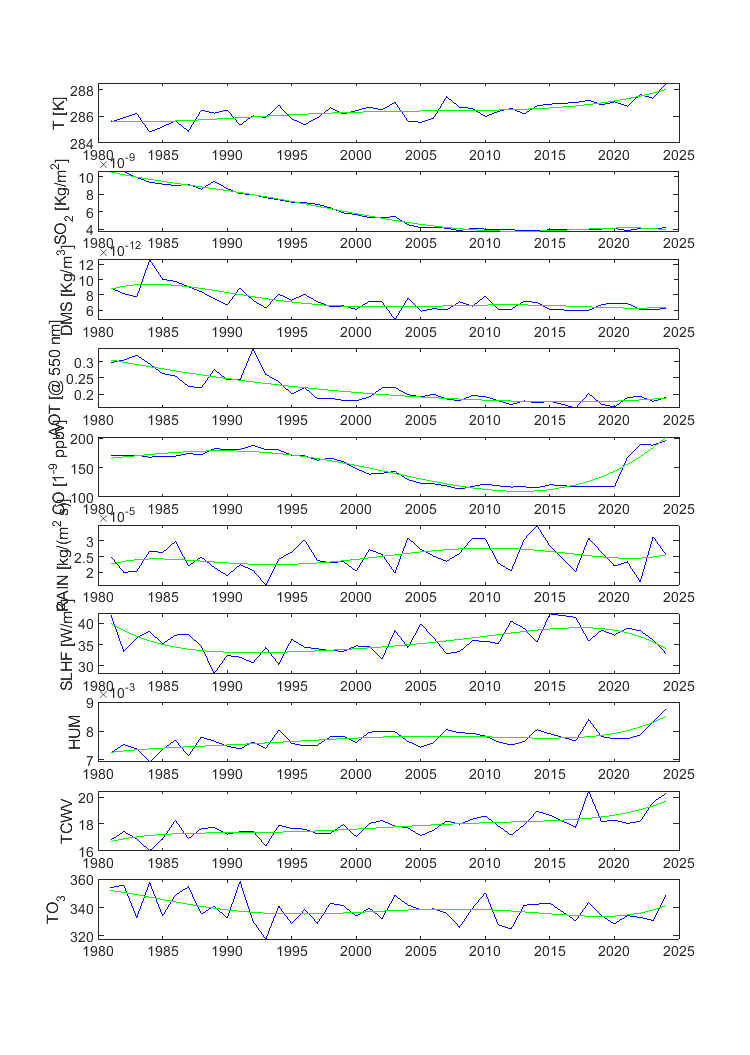

In [20]:
% Processing of atmospheric data

% load the data. The file Atmospheric_data_for_Norcia.mat is the example data for Amatrice-Norcia 2016 EQ;
% otherwise, the file Atmospheric_data_from_MERRA2.mat is the data downloaded before.
 load("data/Atmospheric_data_for_Norcia.mat");
% load('data/Atmospheric_data_from_MERRA2.mat');
% Set the parameter of global warming. This is the degree of the polynomial that is subtracted from multi-years trend of atmospheric data.
% global_warming_correction = 0 means no correction for global warming. global_warming_correction = 1 means linear trend is removed.
global_warming_correction = 5;
% Calculus of time and space constraints for the atmospheric analysis 
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
number_of_analysed_days = time_end - time_start + 1
[year_end1, month_end1, day_end1] = datevec(time_end);
% Set the last year for the atmospheric analysis which is basically the previous year, except the earthquake occurred in the present year.
[year_end, ~] = datevec(now); % For example, 2025;
if EQ_year < year_end
    year_end = year_end -1; %Stop the analysis the year before the present one.
end

% Set the starting year of the atmospheric analysis, considering that the dataset started in 1980.
% If the period would exceed the 1st January 1980, the starting year is shifted to 1981.
if (datenum([1980 month_end1 day_end1]) - number_of_analysed_days) < datenum([1980 1 1])
    year_start = 1981;
else
    year_start = 1980;
end
% Calculate the total number of analysed years
number_of_years_to_be_analysed = year_end-year_start;
% Setup the variables necessary for the preliminary historical average of each atmospheric parameter
mean_SO2 = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_DMS = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_AOT = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_CO = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_SAT = nan(number_of_analysed_days, number_of_years_to_be_analysed);
mean_HUM = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_SLHF = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_RAIN = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_TCWV = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_TO3 = nan(number_of_analysed_days,number_of_years_to_be_analysed);
% setup the variables with the values recorded in the year of the earthquake occurrence.
mean_SO2_EQ_year = zeros(number_of_analysed_days, 1);
mean_DMS_EQ_year  = zeros(number_of_analysed_days, 1);
mean_AOT_EQ_year  = zeros(number_of_analysed_days, 1);
mean_CO_EQ_year  = zeros(number_of_analysed_days, 1);
mean_SAT_EQ_year  = zeros(number_of_analysed_days, 1);
mean_HUM_EQ_year  = zeros(number_of_analysed_days, 1);
mean_SLHF_EQ_year  = zeros(number_of_analysed_days, 1);
mean_RAIN_EQ_year  = zeros(number_of_analysed_days, 1);
mean_TCWV_EQ_year  = zeros(number_of_analysed_days, 1);
mean_TO3_EQ_year  = zeros(number_of_analysed_days, 1);

% transferring the atmospheric variables from the stored files to the ones used in the following calculus 
SO2_EQ = SO2;
DMS_EQ = DMS;
AOT_EQ = AOT;
CO_EQ = CO;
SAT_EQ = SAT;
HUM_EQ = HUM;
SLHF_EQ = SLHF;
RAIN_EQ = RAIN;
TCWV_EQ = TCWV;
TO3_EQ = TO3;
% Despite each atmospheric parameter having its time, only one is preserved as all the parameters are retrieved for the same time interval
time_atmospheric_data = SO2_time;

% variable that counts the year in the historical mean. It excludes the year of the earthquake
index_year_historic = 1;
% Cicle on all the years of the time series
for year_i=number_of_years_to_be_analysed:-1:0 
    % Calculate the year under investigation (year_to_be_analysed)
    year_to_be_analysed = year_end-year_i;
    end_date = datenum([year_to_be_analysed EQ_month EQ_day]);
    start_date = end_date - number_of_analysed_days+1;
    % The following lines of code are necessary to afford the bysestile
    % year. In fact, the number of analysed year must be the same and in
    % case an year include the 29 February this day must be excluded from
    % the time series. In the same time the automatic calculus of the
    % start_date must be checked to anticipate of one day if the year under
    % the analysis contains the 29 February
    if EQ_month == 1 || (EQ_month == 2 && EQ_day < 29)
        year_to_be_checked_for_leap = year_to_be_analysed - 1;
    else
        year_to_be_checked_for_leap = year_to_be_analysed;
    end
    Leap_day = datenum([year_to_be_checked_for_leap 2 29]);
    [~, ~, day_check] = datevec(Leap_day);
    if day_check == 29 && start_date <= Leap_day && end_date >= Leap_day
        start_date = start_date - 1;
    end
    
    index_day_tba = 1;
    
    for i=start_date:end_date
        [~, mese_p, giorno_p] = datevec(i);
        index_data = find(time_atmospheric_data == i);
        if not(mese_p == 2 && giorno_p == 29)
            
            
            % , SO2_EQ, DMS_EQ, AOT_EQ, CO_EQ, SAT_EQ, HUM_EQ, SLHF_EQ,
            % RAIN_EQ time_atmospheric_data
            
            if year_to_be_analysed == EQ_year
                mean_SO2_EQ_year(index_day_tba,1) = SO2_EQ(index_data);
                mean_DMS_EQ_year(index_day_tba,1) = DMS_EQ(index_data);
                mean_AOT_EQ_year(index_day_tba,1) = AOT_EQ(index_data);
                mean_CO_EQ_year(index_day_tba,1) = CO_EQ(index_data);
                mean_SAT_EQ_year(index_day_tba,1) = SAT_EQ(index_data);
                mean_RAIN_EQ_year(index_day_tba,1) = RAIN_EQ(index_data);
                mean_SLHF_EQ_year(index_day_tba,1) = SLHF_EQ(index_data);
                mean_HUM_EQ_year(index_day_tba,1) = HUM_EQ(index_data);
                mean_TCWV_EQ_year(index_day_tba,1) = TCWV_EQ(index_data);
                mean_TO3_EQ_year(index_day_tba,1) = TO3_EQ(index_data);
            else
                mean_SO2(index_day_tba,index_year_historic) = SO2_EQ(index_data);
                mean_DMS(index_day_tba,index_year_historic) = DMS_EQ(index_data);
                mean_AOT(index_day_tba,index_year_historic) = AOT_EQ(index_data);
                mean_CO(index_day_tba,index_year_historic) = CO_EQ(index_data);
                mean_SAT(index_day_tba,index_year_historic) = SAT_EQ(index_data);
                mean_RAIN(index_day_tba,index_year_historic) = RAIN_EQ(index_data);
                mean_SLHF(index_day_tba,index_year_historic) = SLHF_EQ(index_data);
                mean_HUM(index_day_tba,index_year_historic) = HUM_EQ(index_data);
                mean_TCWV(index_day_tba,index_year_historic) = TCWV_EQ(index_data);
                mean_TO3(index_day_tba,index_year_historic) = TO3_EQ(index_data);
            end
            
            index_day_tba = index_day_tba + 1;
        end
    end
    if year_to_be_analysed ~= EQ_year
        index_year_historic = index_year_historic + 1;
    end
end
if global_warming_correction == 0
    yarly_SAT = (mean(mean_SAT,1))';
    yarly_SAT = yarly_SAT(1:end-1);
    year_considered = (year_start:year_end)';
    year_considered = year_considered(year_considered ~= EQ_year);
    fit_global_warming_SAT = polyfit(year_considered,yarly_SAT,1);
    year_k = 1;
    for year_tbcorrected = year_start:year_end
        if year_tbcorrected ~= EQ_year
            mean_SAT(:,year_k) = mean_SAT(:,year_k) - fit_global_warming_SAT(1)*(year_tbcorrected - year_start);
        else
            mean_SAT_EQ_year = mean_SAT_EQ_year - fit_global_warming_SAT(1)*(year_tbcorrected - year_start);
        end
        year_k = year_k + 1;
    end
elseif global_warming_correction > 0
    yarly_SAT = (mean(mean_SAT,1))';
    yarly_SO2 = (mean(mean_SO2,1))';
    yarly_DMS = (mean(mean_DMS,1))';
    yarly_AOT = (mean(mean_AOT,1))';
    yarly_CO = (mean(mean_CO,1))';
    yarly_RAIN = (mean(mean_RAIN,1))';
    yarly_SLHF = (mean(mean_SLHF,1))';
    yarly_HUM = (mean(mean_HUM,1))';
    yearly_TCWV = (mean(mean_TCWV,1))';
    yearly_TO3 = (mean(mean_TO3,1))';
    year_considered = (year_start:year_end)';
    year_considered = year_considered(year_considered ~= EQ_year);
    
    fit_global_warming_SAT = polyfit(year_considered,yarly_SAT,global_warming_correction);
    fit_global_warming_SO2 = polyfit(year_considered,yarly_SO2,global_warming_correction);
    fit_global_warming_DMS = polyfit(year_considered,yarly_DMS,global_warming_correction);
    fit_global_warming_AOT = polyfit(year_considered,yarly_AOT,global_warming_correction);
    fit_global_warming_CO = polyfit(year_considered,yarly_CO,global_warming_correction);
    fit_global_warming_RAIN = polyfit(year_considered,yarly_RAIN,global_warming_correction);
    fit_global_warming_SLHF = polyfit(year_considered,yarly_SLHF,global_warming_correction);
    fit_global_warming_HUM = polyfit(year_considered,yarly_HUM,global_warming_correction);
    fit_global_warming_TCWV = polyfit(year_considered,yearly_TCWV,global_warming_correction);
    fit_global_warming_TO3 = polyfit(year_considered,yearly_TO3,global_warming_correction);

        figure('Position', [1,1,600,1500])
        subplot(10,1,1)
        plot(year_considered,yarly_SAT, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SAT, year_considered), '-g');
        ylabel('T [K]');
        subplot(10,1,2)
        plot(year_considered,yarly_SO2, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SO2, year_considered), '-g');
        ylabel('SO_2 [Kg/m^2]');
        subplot(10,1,3)
        plot(year_considered,yarly_DMS, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_DMS, year_considered), '-g');
        ylabel('DMS [Kg/m^3]');
        subplot(10,1,4)
        plot(year_considered,yarly_AOT, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_AOT, year_considered), '-g');
        ylabel('AOT [@ 550 nm]');
        subplot(10,1,5)
        plot(year_considered,yarly_CO, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_CO, year_considered), '-g');
        ylabel('CO [1^{-9} ppbv]');
        subplot(10,1,6)
        plot(year_considered,yarly_RAIN, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_RAIN, year_considered), '-g');
        ylabel('RAIN [kg/(m^2 s)]');
        subplot(10,1,7)
        plot(year_considered,yarly_SLHF, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SLHF, year_considered), '-g');
        ylabel('SLHF [W/m^2]');
        subplot(10,1,8)
        plot(year_considered,yarly_HUM, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_HUM, year_considered), '-g');
        ylabel('HUM');
        subplot(10,1,9)
        plot(year_considered,yearly_TCWV, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_TCWV, year_considered), '-g');
        ylabel('TCWV');
        subplot(10,1,10)
        plot(year_considered,yearly_TO3, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_TO3, year_considered), '-g');
        ylabel('TO_3');


        year_k = 1;
    for year_tbcorrected = year_start:year_end
        if year_tbcorrected ~= EQ_year
            mean_SAT(:,year_k) = mean_SAT(:,year_k) - polyval(fit_global_warming_SAT, year_tbcorrected) + mean(mean_SAT(:,1));
            mean_SO2(:,year_k) = mean_SO2(:,year_k) - polyval(fit_global_warming_SO2, year_tbcorrected) + mean(mean_SO2(:,1));
            mean_DMS(:,year_k) = mean_DMS(:,year_k) - polyval(fit_global_warming_DMS, year_tbcorrected) + mean(mean_DMS(:,1));
            mean_AOT(:,year_k) = mean_AOT(:,year_k) - polyval(fit_global_warming_AOT, year_tbcorrected) + mean(mean_AOT(:,1));
            mean_CO(:,year_k) = mean_CO(:,year_k) - polyval(fit_global_warming_CO, year_tbcorrected) + mean(mean_CO(:,1));
            mean_RAIN(:,year_k) = mean_RAIN(:,year_k) - polyval(fit_global_warming_RAIN, year_tbcorrected) + mean(mean_RAIN(:,1));
            mean_SLHF(:,year_k) = mean_SLHF(:,year_k) - polyval(fit_global_warming_SLHF, year_tbcorrected) + mean(mean_SLHF(:,1));
            mean_HUM(:,year_k) = mean_HUM(:,year_k) - polyval(fit_global_warming_HUM, year_tbcorrected) + mean(mean_HUM(:,1));
            mean_TCWV(:,year_k) = mean_TCWV(:,year_k) - polyval(fit_global_warming_TCWV, year_tbcorrected) + mean(mean_TCWV(:,1));
            mean_TO3(:,year_k) = mean_TO3(:,year_k) - polyval(fit_global_warming_TO3, year_tbcorrected) + mean(mean_TO3(:,1));
            year_k = year_k + 1;
        else
            mean_SAT_EQ_year = mean_SAT_EQ_year - polyval(fit_global_warming_SAT, year_tbcorrected) + mean(mean_SAT(:,1));
            mean_SO2_EQ_year = mean_SO2_EQ_year - polyval(fit_global_warming_SO2, year_tbcorrected) + mean(mean_SO2(:,1));
            mean_DMS_EQ_year = mean_DMS_EQ_year - polyval(fit_global_warming_DMS, year_tbcorrected) + mean(mean_DMS(:,1));
            mean_AOT_EQ_year = mean_AOT_EQ_year - polyval(fit_global_warming_AOT, year_tbcorrected) + mean(mean_AOT(:,1));
            mean_CO_EQ_year = mean_CO_EQ_year - polyval(fit_global_warming_CO, year_tbcorrected) + mean(mean_CO(:,1));
            mean_RAIN_EQ_year = mean_RAIN_EQ_year - polyval(fit_global_warming_RAIN, year_tbcorrected) + mean(mean_RAIN(:,1));
            mean_SLHF_EQ_year = mean_SLHF_EQ_year - polyval(fit_global_warming_SLHF, year_tbcorrected) + mean(mean_SLHF(:,1));
            mean_HUM_EQ_year = mean_HUM_EQ_year - polyval(fit_global_warming_HUM, year_tbcorrected) + mean(mean_HUM(:,1));
            mean_TCWV_EQ_year = mean_TCWV_EQ_year - polyval(fit_global_warming_TCWV, year_tbcorrected) + mean(mean_TCWV(:,1));
            mean_TO3_EQ_year = mean_TO3_EQ_year - polyval(fit_global_warming_TO3, year_tbcorrected) + mean(mean_TO3(:,1));
        end
        
    end
end

sd_SO2 = nanstd(mean_SO2, 0, 2);
sd_DMS = nanstd(mean_DMS, 0, 2);
sd_AOT = nanstd(mean_AOT, 0, 2);
sd_CO = nanstd(mean_CO, 0, 2);
sd_SAT = nanstd(mean_SAT, 0, 2);
sd_RAIN = nanstd(mean_RAIN, 0, 2);
sd_SLHF = nanstd(mean_SLHF, 0, 2);
sd_HUM = nanstd(mean_HUM, 0, 2);
sd_TCWV = nanstd(mean_TCWV, 0, 2);
sd_TO3 = nanstd(mean_TO3, 0, 2);

threshold_SO2 = median(nanmedian(mean_SO2, 2)) + 10*median(sd_SO2);
threshold_DMS = median(nanmedian(mean_DMS, 2)) + 10*median(sd_DMS);
threshold_AOT = median(nanmedian(mean_AOT, 2)) + 10*median(sd_AOT);
threshold_CO = median(nanmedian(mean_CO, 2)) + 10*median(sd_CO);
threshold_SAT = median(nanmedian(mean_SAT, 2)) + 10*median(sd_SAT);
threshold_RAIN = median(nanmedian(mean_RAIN, 2)) + 10*median(sd_RAIN);
threshold_SLHF = median(nanmedian(mean_SLHF, 2)) + 10*median(sd_SLHF);
threshold_HUM = median(nanmedian(mean_SAT, 2)) + 10*median(sd_HUM);
threshold_TCWV = median(nanmedian(mean_TCWV, 2)) + 10*median(sd_TCWV);
threshold_TO3 = median(nanmedian(mean_TO3, 2)) + 10*median(sd_TO3);

mean_SO2h = []; %vettore per immaganizzare i dati "buoni"

mean_DMSh = [];
mean_AOTh = [];
mean_COh = [];
mean_SATh = [];
mean_RAINh = [];
mean_SLHFh = [];
mean_HUMh = [];
mean_TCWVh = [];
mean_TO3h = [];

excluded_years_SO2 = [];
excluded_years_DMS = [];
excluded_years_AOT = [];
excluded_years_CO = [];
excluded_years_SAT = [];
excluded_years_RAIN = [];
excluded_years_SLHF = [];
excluded_years_HUM = [];
excluded_years_TCWV = [];
excluded_years_TO3 = [];

w=1;
for i=1:size(mean_SO2,2)
    if max(mean_SO2(:,i)) < threshold_SO2 %&& max(mean_SO2(:,i)) < threshold_SO2 %% max(mean_DMS(:,i)) < threshold_DMS &&
        mean_SO2h = [mean_SO2h, mean_SO2(:,i)];
    else
        excluded_years_SO2 = [excluded_years_SO2; year_start-1+i];
    end
    mean_DMSh = [mean_DMSh, mean_DMS(:,i)];
    if max(mean_AOT(:,i)) < threshold_AOT %% max(mean_DMS(:,i)) < threshold_DMS &&
        mean_AOTh = [mean_AOTh, mean_AOT(:,i)];
    else
        excluded_years_AOT = [excluded_years_AOT; year_start-1+i];
    end
    if max(mean_CO(:,i)) < threshold_CO % && max(mean_AOT(:,i)) < threshold_AOT %% max(mean_DMS(:,i)) < threshold_DMS &&
        mean_COh = [mean_COh, mean_CO(:,i)];
    else
        excluded_years_CO = [excluded_years_CO; year_start-1+i];
    end
    if max(mean_SAT(:,i)) < threshold_SAT
        mean_SATh = [mean_SATh, mean_SAT(:,i)];
    else
        excluded_years_SAT = [excluded_years_SAT; year_start-1+i];
    end
    mean_RAINh = [mean_RAINh, mean_RAIN(:,i)];
    mean_SLHFh = [mean_SLHFh, mean_SLHF(:,i)];
    mean_HUMh = [mean_HUMh, mean_HUM(:,i)];
    if max(mean_TCWV(:,i)) < threshold_TCWV
        mean_TCWVh = [mean_TCWVh, mean_TCWV(:,i)];
    else
        excluded_years_TCWV = [excluded_years_TCWV; year_start-1+i];
    end
    if max(mean_TO3(:,i)) < threshold_TO3
        mean_TO3h = [mean_TO3h, mean_TO3(:,i)];
    else
        excluded_years_TO3 = [excluded_years_TO3; year_start-1+i];
    end
end

sd_SO2 = nanstd(mean_SO2h, 0, 2);
mean_SO2 = nanmean(mean_SO2h, 2);
sd_DMS = nanstd(mean_DMSh, 0, 2);
mean_DMS = nanmean(mean_DMSh, 2);
sd_AOT = nanstd(mean_AOTh, 0, 2);
mean_AOT = nanmean(mean_AOTh, 2);
sd_CO = nanstd(mean_COh, 0, 2);
mean_CO = nanmean(mean_COh, 2);
sd_SAT = nanstd(mean_SATh, 0, 2);
mean_SAT = nanmean(mean_SATh, 2);
sd_RAIN = nanstd(mean_RAINh, 0, 2);
mean_RAIN = nanmean(mean_RAINh, 2);
sd_SLHF = nanstd(mean_SLHFh, 0, 2);
mean_SLHF = nanmean(mean_SLHFh, 2);
sd_HUM = nanstd(mean_HUMh, 0, 2);
mean_HUM = nanmean(mean_HUMh, 2);
sd_TCWV = nanstd(mean_TCWVh, 0, 2);
mean_TCWV = nanmean(mean_TCWVh, 2);
sd_TO3 = nanstd(mean_TO3h, 0, 2);
mean_TO3 = nanmean(mean_TO3h, 2);

atmospheric_anomalies = []; %1 SO2, 2 DMS, 3 AOT, 4 CO, 5 Temp., 6 SLHF, 7 HUM 8 TCWV 9 TO3
for i=1:size(mean_SO2, 1)
    if (mean_SO2_EQ_year(i) > (mean_SO2(i) + 2 * sd_SO2(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 1];
    end
    if (mean_DMS_EQ_year(i) > (mean_DMS(i) + 2 * sd_DMS(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 2];
    end
    if (mean_AOT_EQ_year(i) > (mean_AOT(i) + 2 * sd_AOT(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 3];
    end
    if (mean_CO_EQ_year(i) > (mean_CO(i) + 2 * sd_CO(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 4];
    end
    if (mean_SAT_EQ_year(i) > (mean_SAT(i) + 2 * sd_SAT(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 5];
    end
    if (mean_SLHF_EQ_year(i) > (mean_SLHF(i) + 2 * sd_SLHF(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 6];
    end
    if (mean_HUM_EQ_year(i) < (mean_HUM(i) - 2 * sd_HUM(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 7];
    end
    if (mean_TCWV_EQ_year(i) < (mean_TCWV(i) - 2 * sd_TCWV(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 8];
    end
    if (mean_TO3_EQ_year(i) < (mean_TO3(i) - 2 * sd_TO3(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 9];
    end
end



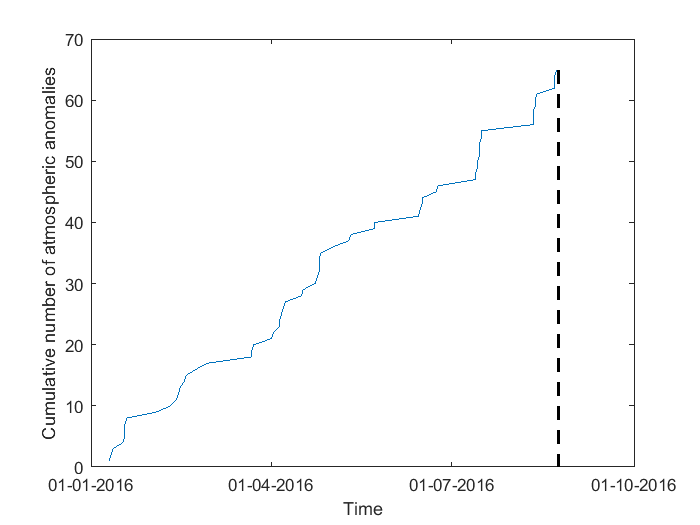

In [21]:
figure
atmospheric_anomalies = sortrows(atmospheric_anomalies,1);
cumulate_atmosphere = (1:size(atmospheric_anomalies, 1))';
plot(time_start-1+atmospheric_anomalies(:,1), cumulate_atmosphere)
line([EQ_time, EQ_time], [0 cumulate_atmosphere(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
datetick('x', 'dd-mm-yyyy');
xlabel('Time');
ylabel('Cumulative number of atmospheric anomalies');

## Ionospheric analysis
In this session, the magnetic data from Swarm three-identical satellites are analysed.

Data must be downloaded from ESA's ftp dissemination service, which requires a free EO user account (you can create one here: https://eoiam-idp.eo.esa.int/) and placed in one folder of your computer were the VRE is running.

In the following example the data are inside the folder **ndir** = E:\Swarm_data  
The ESA Swarm file names appear as:  
SW_OPER_MAGA_LR_1B_20131125T110252_20131125T235959_0602_MDR_MAG_LR.cdf  
SW_OPER_MAGA_LR_1B_20201027T134456_20201027T150128_0605_MDR_MAG_LR.cdf  
...  
SW_OPER_MAGC_LR_1B_20140524T000000_20140524T235959_0602_MDR_MAG_LR.cdf


A full description of the method used for this analysis can be found in the following papers:
1. De Santis, A.; Balasis, G.; Pavón-Carrasco, F.J.; Cianchini, G.; Mandea, M. Potential earthquake precursory pattern from space: The 2015 Nepal event as seen by magnetic Swarm satellites. Earth Planet. Sci. Lett. 2017, 461, 119–126. <a href="http://doi.org/10.1016/j.epsl.2016.12.037"> doi:10.1016/j.epsl.2016.12.037</a>.
2. De Santis, A.; Marchetti, D.; Pavón-Carrasco, F.J.; Cianchini, G.; Perrone, L.; Abbattista, C.; Alfonsi, L.; Amoruso, L.; Campuzano, S.A.; Carbone, M.; et al. Precursory worldwide signatures of earthquake occurrences on Swarm satellite data. Sci. Rep. 2019, 9, 20287. <a href="http://doi.org/10.1038/s41598-019-56599-1">doi:10.1038/s41598-019-56599-1</a>.  
3. Marchetti, D.; De Santis, A.; Campuzano, S.A.; Zhu, K.; Soldani, M.; D’Arcangelo, S.; Orlando, M.; Wang, T.; Cianchini, G.; Di Mauro, D.; et al. Worldwide Statistical Correlation of Eight Years of Swarm Satellite Data with M5.5+ Earthquakes: New Hints about the Preseismic Phenomena from Space. Remote Sens. 2022, 14, 2649. <a href="https://doi.org/10.3390/rs14112649">doi:10.3390/rs14112649</a>.


The first part of the following code selects the data in the time range defined for the analysis of the earthquake.

Data are downloaded from ESA ftp dissemination service which requires a free EO user account (you can create one here: https://eoiam-idp.eo.esa.int/)

Credits for the password tool:   
Serge (2025). passwordtools (https://github.com/serg3y/MatLab-passwordtools/releases/tag/1.2.2), GitHub. Retrieved January 30, 2025.the passw

In [2]:
threshold = 4; %Threshold to identify Swarm magnetic anomalies
width_window = 3; %Lenght of the latitudinal window to search for anomalies
ndir = 'E:\dati_magnetici_swarm/';

EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;

YYYY = EQ_year;
MM = EQ_month;
DD = EQ_day;
DB = day_before;
DA = day_after;

files = dir([ndir, '*cdf.dat']);
files = {files.name}';

k=1;
newfiles={};
for i=1:size(files,1)
    a=files{i};
    t=datenum([str2double(a(20:23)),str2double(a(24:25)),str2double(a(26:27))]);
    if t>=time_start && t<=time_end
        newfiles(k,:)=files(i);
        k = k + 1;
    end
end


### Here we defined some functions that are necessary to properly exectute the code that processes the Swarm satellite magnetic data
The following cell defines a function called *"dat_order_alpha"* that permits to organise the satellite data from Swarm.  
In particular, it adds a column with a number corresponding to which satellite the data belongs (1=*Alpha*, 2=*Bravo*, 3=*Charlie*) and determines the semi-orbit number.  

In [3]:
function [yn]=dat_orden_alpha(x,SAT)
Mmlat=70;% maximum and minimum latitude (outside the polar areas)
if SAT=='A';sat=1;end
if SAT=='B';sat=2;end
if SAT=='C';sat=3;end
if SAT=='S';sat=4;end
%We add 2 new colums: SAT YYYY MM DD HH MM SS TRACK-NUMBER LAT LONG R X Y Z F
y=x(abs(x(:,7))<=Mmlat,:);
nn=size(y,1);
yn=zeros(nn-1,size(y,2)+2);
if nn>1
    k=1;m=1;
    while k<=nn-1
        yn(k,:)=[sat,y(k,1:6),m,y(k,7:end)];
        if abs(y(k,7)-y(k+1,7))>.5 || abs(y(k,8)-y(k+1,8))>1;
            m=m+1;
        end
        k=k+1;
    end
end
return

The following cell defines a function called *"geograph2geomag"* that permits to transform (i.e., rotate) the geographic coordinates of longitude and latitude in geomagnetic coordinates (i.e., geomagnetic latitude and longitude).  
The conversion is performed using the coordinates of the magnetic pole provided in the file `polos_igrf_swarm.dat` into the data folder.

In [4]:
function [mlat,mlong]=geograph2geomag(lat,long,time)
%lat, lon = geographic latitude and longitude
%time expressed in year. For example if you have 30/01/2016 time must be only 2016
format long
polo=load(fullfile("data", "polos_igrf_swarm.dat"));
fact=pi/180;
%latitude and longitude of magnetic pole in the year "time" (according to IGRF).
Dlat = polo(polo(:,1)==time,2)*fact; %latitude of geoamgentic pole
Dlong = (360+polo(polo(:,1)==time,3))*fact;%Geomagnetic longitude of the pole
%program
glong=long*fact;
glat=lat*fact;
x=cos(glat).*cos(glong);
y=cos(glat).*sin(glong);
z=sin(glat);
dato=[x,y,z];
%first rotation of the equator plane from the Greenwich meridian to the pole meridian.
M1=[cos(Dlong) sin(Dlong) 0;-sin(Dlong) cos(Dlong) 0;0 0 1];
S1=M1*dato';
%second rotation in the plane of the current meridian from the geographic pole to the magnetic pole.
M2=[cos(pi/2-Dlat) 0 -sin(pi/2-Dlat);0 1 0;sin(pi/2-Dlat) 0 cos(pi/2-Dlat)];
S2=M2*S1;
S2=S2';
%The last transformation
mlat=atan(S2(:,3)./sqrt(S2(:,1).^2+S2(:,2).^2));
mlat=mlat/fact;
mlong=atan(S2(:,2)./S2(:,1));
mlong=mlong/fact;
return

The following cell defines a function called *"geomagnetic_indexes"* that extracts the Dst and ap geomagnetic indexes at the time of interest  


In [5]:
function [dst,ap]=geomagnetic_indexes(z,a,b)
a1=a(a(:,1)==z(1) & a(:,2)==z(2) & a(:,3)==z(3),4:end);
b1=b(b(:,1)==z(1) & b(:,2)==z(2) & b(:,3)==z(3),4:end);
dst=a1(1, round(z(4))+1);
ap=b1(1, round(z(4))+1);
return

The following code extracts the Swarm magnetic data inside the Dobrovolsky's area and stores in struct variable **"tracks"** for further processing.  
Total number of extracted tracks is shown as i_tr

In [11]:
idst=load(fullfile("data", "dst_index2.dat"));
iap=load(fullfile("data", "ap_index2.dat"));
load(fullfile("data", "Solar_activity_SW_and_F_1min.mat"));
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
directory_to_save_Swarm_tracks = fullfile("data", "Swarm_tracks");

tracks = {};
i_tr = 1;
% The following line is limited to the first 10 files for quick execution.
for i=1:10 %size(newfiles,1)
    a=newfiles{i};
    y=load(fullfile(ndir,newfiles{i}));%Read the .cdf.dat file.
    yn=dat_orden_alpha(y,a(12));% Include the number of track for each day
    y=yn( abs(yn(:,10)-epilon)<=(radius_Dobrovolsky+15),:);
    if size(y,1) > 50
        %Create a file name with a progressive index 
        filename_Swarm = ['Swarm_track_', num2str(i_tr, '%05d'), '.mat'];
        save(fullfile(directory_to_save_Swarm_tracks, filename_Swarm), "y", "-mat");
        %tracks{i_tr} = y; %It is not necessary as it's created in the following cell
        i_tr = i_tr + 1;
    end
end
i_tr


i_tr = 11

The following section calculated the magnetic residual along the tracks. The residual of the magnetic field in this case is the part of data that may contains eventual non ordinary signals, i.e. eventual earthquake induced signals.  

In [15]:
format compact
directory_to_read_Swarm_tracks = fullfile("data", "Swarm_tracks");
% Read the directory to list all files that contain Swarm data in the proper folder
list_of_Swarm_files = dir(fullfile(directory_to_read_Swarm_tracks, "Swarm_track*.mat"));
list_of_Swarm_files = {list_of_Swarm_files.name}';

% Read the Swarm data and store it in the struct called "tracks" 
tracks = {};
i_tr = 1;
for i=1:size(list_of_Swarm_files, 1)
    file_to_be_read = list_of_Swarm_files{i};
    load(fullfile(directory_to_read_Swarm_tracks, file_to_be_read));
    tracks{i_tr} = y;
    i_tr = i_tr + 1;
end

residuals = {};
i_res = 1;
for i=1:size(tracks,2)
    y = tracks{i};
    p1=y(1,8):y(end,8);
    for j=1:length(p1)
        z=y(y(:,8)==p1(j),:); %select the data of a specific track
        if size(z,1)>10 %if the track is longer than 10 data
            [dst,ap]=geomagnetic_indexes(z(1,2:5),idst,iap);
            z=sortrows(z,9);
            tt1=z(abs(z(:,9)-epilat)<radius_Dobrovolsky,5)+z(abs(z(:,9)-epilat)<radius_Dobrovolsky,6)/60+z(abs(z(:,9)-epilat)<radius_Dobrovolsky,7)/3600;%UTC TIME in decimal hour for the track
            tt1_v=datevec(mean(tt1)/24);
            delta_solar_time = abs(solar_activity(:,1) - datenum([z(1,2:4), tt1_v(4:6)]));
            if delta_solar_time < 1/24
                [~, index_solar] = min(delta_solar_time);
                solar_condition = solar_activity(index_solar, 2);
            else
                solar_condition = -1;
            end
            z = z(z(:,13) <= 9 & z(:,14) <= 18 & z(:,15) <= 1, :);
            %The difference with A, B and C is not correct because in ASM burst mode for all the satellites, these parameters need to be considered
            if size(z,1)>1000
                latmag=geograph2geomag(z(:,9),z(:,10),z(1,2)); %geomagnetic latitude.
                D1=z(:,end-2);
                d=diff(D1);
                tt1s = z(:,5)*3600+z(:,6)*60+z(:,7);
                for tem=1:size(d, 1)
                    d(tem) = d(tem) / (tt1s(tem+1) - tt1s(tem));
                end
                latmag = latmag(1:end-1)/2 + latmag(2:end)/2;
                if size(d,1)>50
                    spline_fit = fit(latmag, d, 'smoothingspline', 'SmoothingParam', 20/size(d,1));
                else
                    spline_fit = fit(latmag, d, 'smoothingspline', 'SmoothingParam', 10/size(d,1));
                end
                fitted_value = feval(spline_fit, latmag);
                val = d - fitted_value; % residual for further processing (e.g., researching anomalies).
                val = val(abs(latmag) <= 50);
                z = z(1:end-1,:)/2 + z(2:end,:)/2;
                z = z(abs(latmag) <= 50, :);
                latmag = latmag(abs(latmag) <= 50);
                residuals{i_res}.residual = val;
                residuals{i_res}.latmag = latmag;
                residuals{i_res}.track = z;
                residuals{i_res}.geomag_index = [dst, ap, solar_condition];
                i_res = i_res + 1;
            end
        end
    end
end
i_res

i_res =         2545

The following code plots 10 tracks selcted randomically among all the selected data.

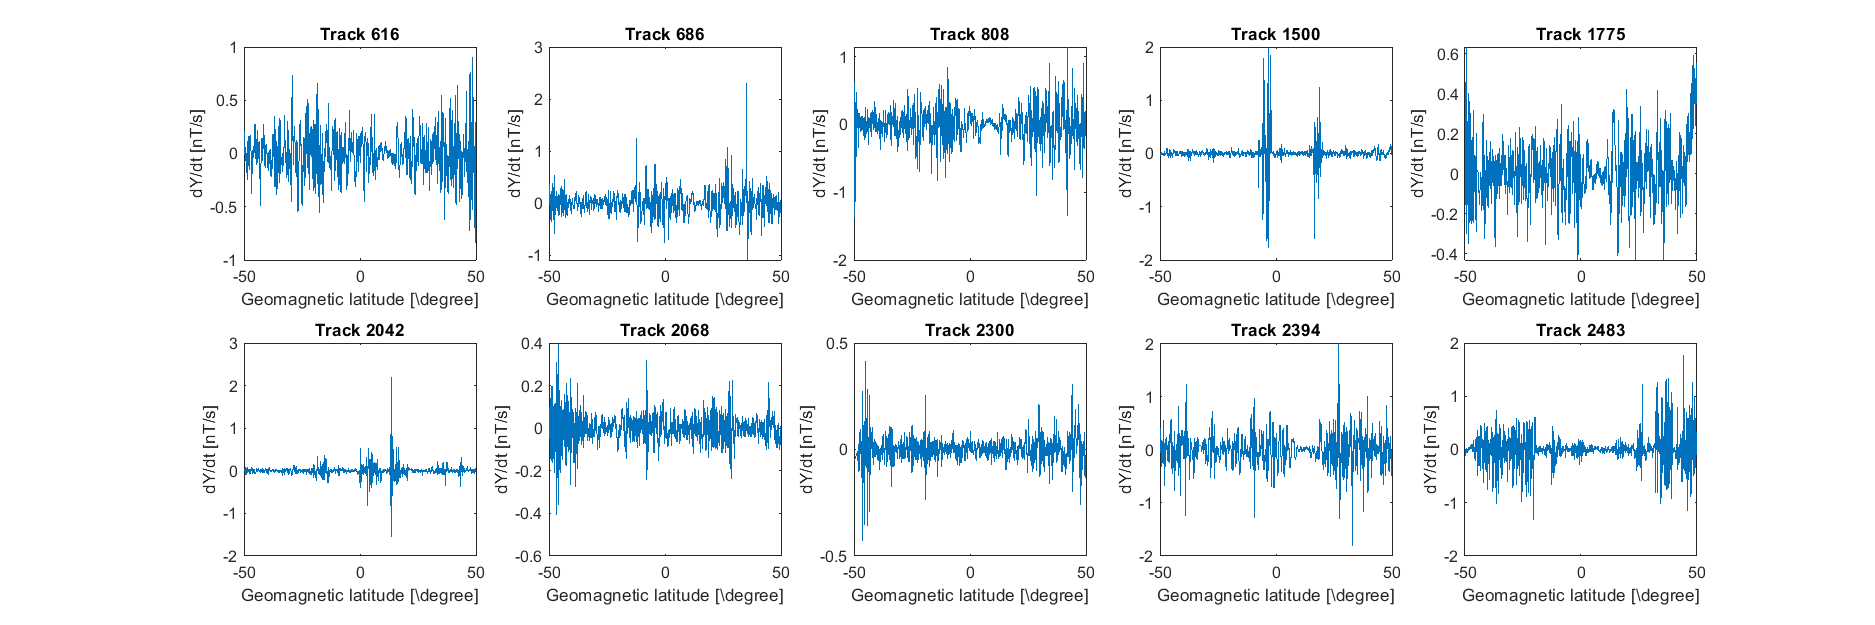

In [16]:
figure_index = fix(1+rand(10,1)*size(residuals,2));
figure_index = sortrows(figure_index);
figure('Position', [1, 1, 1500, 500])
for i=1:size(figure_index,1)
    latmag = residuals{figure_index(i)}.latmag;
    val = residuals{figure_index(i)}.residual;
    subplot(2,5,i)
    %plot(latmag, d);
    %hold on;
    %plot(latmag, fitted_value)
    %xlabel('Geoamgnetic latitude [\degree]', 'Interpreter', 'latex');
    %ylabel('dY/dt [nT/s]');
    %title('Numerical derivative of Y component');
    %subplot(2,1,2)
    plot(latmag, val)
    ylabel('dY/dt [nT/s]');
    xlabel('Geomagnetic latitude [\degree]', 'Interpreter', 'latex');
    title(['Track ', num2str(figure_index(i), '%d')]);
end

The following section extracted the anomalous magnetic signal from the previous selected tracs. 

In [18]:
max_dst = 20;
max_ap = 10;
anomalous_windows = {};
k_window = 1;
anomalous_track = nan(size(residuals,2), 9);
i_anom_track = 1;
for i=1:size(residuals,2)
    latmag = residuals{i}.latmag;
    val = residuals{i}.residual;
    z = residuals{i}.track;
    geomag_indexes = residuals{i}.geomag_index;
    track_threshold = threshold*nanstd(val);
    number_of_anomalous_windows = 0;
    geomag_lat_start = -50;
    geomag_lat_end = +50;
    step = width_window / 5;
    window_center = geomag_lat_start;
    while window_center <= geomag_lat_end
        window_rms = nanstd(val(abs(latmag - window_center) <= width_window / 2));
        if window_rms > track_threshold && abs(geomag_indexes(1)) <= max_dst && geomag_indexes(2) <= max_ap
            number_of_anomalous_windows = number_of_anomalous_windows + 1;
            anomalous_windows{k_window,1}.latmag = window_center;
            anomalous_windows{k_window,1}.latgeo = nanmean(z(abs(latmag - window_center) <= width_window / 2, 9));
            anomalous_windows{k_window,1}.longeo = nanmean(z(abs(latmag - window_center) <= width_window / 2, 10));
            anomalous_windows{k_window,1}.time = nanmean(datenum(z(abs(latmag - window_center) <= width_window / 2, 2:7)));
            k_window =  + 1;
        end
        window_center = window_center + step;
    end
    if number_of_anomalous_windows > 0
        [~, index_sample] = min(abs(epilat - z(:,9))); %search the closest latitudinal sample to the epicenter
        anomalous_track(i_anom_track,:) = [z(index_sample,2:7), z(1,1), z(index_sample,10), number_of_anomalous_windows];
        i_anom_track = i_anom_track + 1;
    end
end
i_anom_track
anomalous_track = anomalous_track(1:i_anom_track-1,:);
anomalous_track = sortrows(anomalous_track);

i_anom_track =    109

## Visualization of the cumulative number of Swarm magnetic tracks

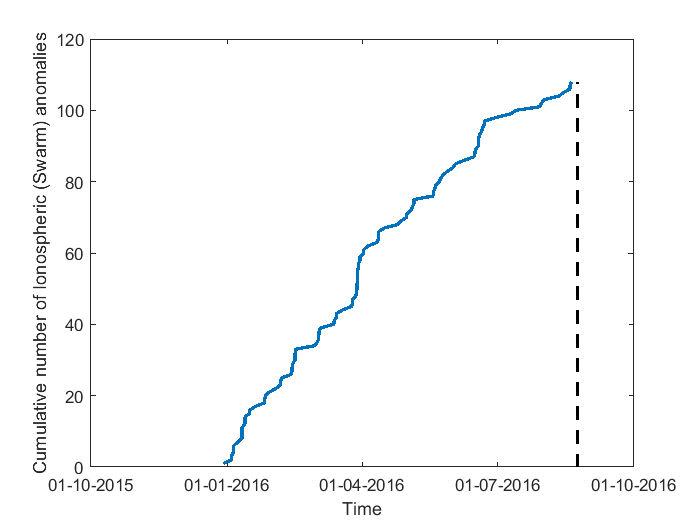

In [19]:
format compact
time_Swarm_anomalies = datenum(anomalous_track(:,1:6));
Cumulative_anomalies_Swarm = (1:size(anomalous_track,1))';
figure
plot(time_Swarm_anomalies, Cumulative_anomalies_Swarm, 'LineWidth', 2)
line([EQ_time, EQ_time], [0 Cumulative_anomalies_Swarm(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
datetick('x', 'dd-mm-yyyy');
xlabel('Time');
ylabel('Cumulative number of Ionospheric (Swarm) anomalies');

# Comparison of Lithosphere Atmosphere and Ionosphere analyses 

A final comparison of the analysed parameters is provided by the follwing code.  
The approach has been used in different earhtquake investigations in the World, as Mw = 7.5 Indonesia 2018, Mw = 7.7 Jamaica 2020, Mw = 7.1 Haiti 2021 or recent Mw = 6.8 Morocco 2023 earthquakes.  
**References:**
1. Marchetti, D. Observation of the Preparation Phase Associated with Mw = 7.2 Haiti Earthquake on 14 August 2021 from a Geophysical Data Point of View. Geosciences 2024, 14, 96. https://doi.org/10.3390/geosciences14040096

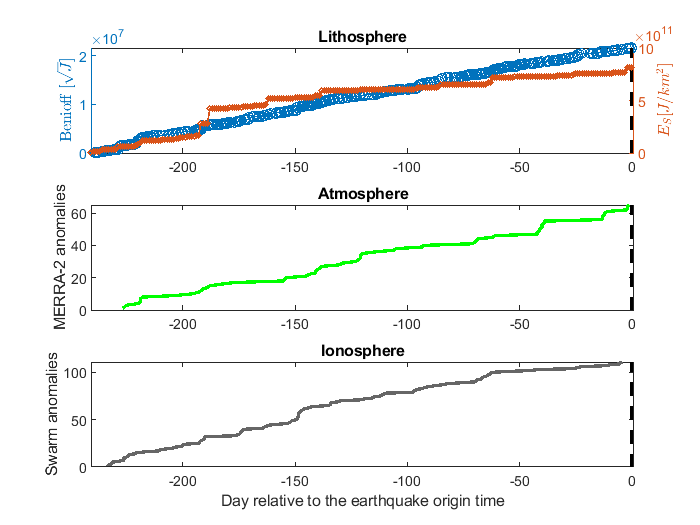

In [22]:
figure
subplot(3,1,1)
yyaxis left;
plot(time_EQ_sel - EQ_time, EQ_sqrt_energy, '-o');
line([0, 0], [0 EQ_sqrt_energy(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
ylabel('Benioff [$\sqrt{J}$]', 'Interpreter', 'latex');
yyaxis right;
plot(cumulative_ES(:,1)- EQ_time, cumulative_ES(:,2), '-o', 'Linewidth', 1, 'MarkerSize', 2.5);
ylabel('$E_S [J/km^2]$', 'Interpreter', 'latex');
title(['Lithosphere']);
xlim([-day_before-1 day_after + 1]);
subplot(3,1,2)
plot(time_start-1+atmospheric_anomalies(:,1)-EQ_time, cumulate_atmosphere, 'g', 'LineWidth', 2)
line([0, 0], [0 cumulate_atmosphere(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
ylabel('MERRA-2 anomalies');
xlim([-day_before-1 day_after + 1]);
title('Atmosphere')
subplot(3,1,3)
plot(time_Swarm_anomalies-EQ_time, Cumulative_anomalies_Swarm, 'Color', [0.4 0.4 0.4], 'LineWidth', 2)
line([0, 0], [0 Cumulative_anomalies_Swarm(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Day relative to the earthquake origin time');
ylabel('Swarm anomalies');
title('Ionosphere')
xlim([-day_before-1 day_after + 1]);
